<a href="https://colab.research.google.com/github/thegallier/timeseries/blob/main/integrated_methods_cvx_regression_kkt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial


def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
        XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []

    residual = Y

    for layer_config in layers:
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

        # Apply thresholding logic if provided
        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        # Apply equal-opposite constraints
        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            penalty_matrix = penalty_strength * penalty_mask.astype(float)
            XtX = jnp.einsum('nij,nkj->nik', X_wins, X_wins)
            XtY = jnp.einsum('nij,nkj->nik', X_wins, Y_wins)
            I = jnp.eye(n_features)[None, :, :]
            W_pen = jnp.linalg.solve(XtX + penalty_matrix[:, :, None] * I, XtY)
            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        #Y_preds = jnp.einsum('nkt,ntf->nkf', X_wins, W_final)
        Y_preds = jnp.einsum('nwf,nfo->nwo', X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers


# Example usage
if __name__ == '__main__':
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    weights, r2s = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        equal_opposite_constraints=[(0, 1)],
        threshold=0.1,
        penalty_strength=1e3,
        freeze_non_masked=True
    )

    print("R² layer 1:", r2s[0])
    print("R² layer 2:", r2s[1])


ValueError: Size of label 'j' for operand 1 (5) does not match previous terms (4).

In [6]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial


def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
        XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []

    residual = Y

    for layer_config in layers:
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

        # Apply thresholding logic if provided
        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        # Apply equal-opposite constraints
        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            penalty_matrix = penalty_strength * penalty_mask.astype(float)
            XtX = jnp.einsum('nwf,nwg->nfg', X_wins, X_wins)
            XtY = jnp.einsum('nwf,nwo->nfo', X_wins, Y_wins)
            I = jnp.eye(n_features)[None, :, :]
            W_pen = jnp.linalg.solve(XtX + penalty_matrix[:, :, None] * I, XtY)
            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        Y_preds = jnp.einsum('nwf,nfo->nwo', X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers


# Example usage
if __name__ == '__main__':
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    weights, r2s = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        equal_opposite_constraints=[(0, 1)],
        threshold=0.1,
        penalty_strength=1e3,
        freeze_non_masked=True
    )

    print("R² layer 1:", r2s[0])
    print("R² layer 2:", r2s[1])


ValueError: Incompatible shapes for broadcasting: shapes=[(17, 5, 1, 4), (1, 5, 5)]

In [7]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial

def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
        XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []

    residual = Y

    for layer_config in layers:
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            XtX = jnp.einsum('nij,nkj->nik', X_wins, X_wins)  # (n_windows, n_features, n_features)
            XtY = jnp.einsum('nij,nkj->nik', X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

            # Expand for output dimension
            XtX_exp = jnp.repeat(XtX[:, None, :, :], n_outputs, axis=1)  # (n_windows, n_outputs, n_features, n_features)
            XtY_exp = jnp.swapaxes(XtY, 1, 2)  # (n_windows, n_outputs, n_features)

            # Penalty matrix per output
            penalty_diag = jnp.expand_dims(penalty_mask.astype(float) * penalty_strength, -1) * jnp.eye(n_features)
            penalty_diag = jnp.swapaxes(penalty_diag, 1, 2)  # (n_windows, n_outputs, n_features, n_features)

            # Solve penalized regression
            W_pen = jnp.linalg.solve(XtX_exp + penalty_diag, XtY_exp[..., None])  # (n_windows, n_outputs, n_features, 1)
            W_pen = jnp.squeeze(jnp.swapaxes(W_pen, 1, 2), -1)  # (n_windows, n_features, n_outputs)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        Y_preds = jnp.einsum('nwf,nfo->nwo', X_wins, W_final)  # (n_windows, window_size, n_outputs)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers


# Example usage
if __name__ == '__main__':
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    print("--- Baseline OLS ---")
    weights_ols, r2s_ols = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}],
    )
    print("R² layer 1:", r2s_ols[0])

    print("--- Penalized with Threshold and Freeze ---")
    weights_pen, r2s_pen = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}],
        penalty_strength=1e3,
        threshold=0.1,
        freeze_non_masked=True
    )
    print("R² layer 1:", r2s_pen[0])

    print("--- Multi-layer with Equal-Opposite Constraint ---")
    weights_multi, r2s_multi = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        equal_opposite_constraints=[(0, 1)],
        penalty_strength=1e3,
        threshold=0.1,
        freeze_non_masked=True
    )
    print("R² layer 1:", r2s_multi[0])
    print("R² layer 2:", r2s_multi[1])
bb

--- Baseline OLS ---
R² layer 1: [[0.9999809  0.99999005 0.9999808  0.99998486]
 [0.9999477  0.9999834  0.99997413 0.99998677]
 [0.99996334 0.9999896  0.99997616 0.99999046]
 [0.99994516 0.99998957 0.9999764  0.99999183]
 [0.9999678  0.9999928  0.9999772  0.9999918 ]
 [0.99998045 0.9999891  0.99997574 0.9999882 ]
 [0.9999888  0.9999835  0.99998224 0.9999929 ]
 [0.9999907  0.99997795 0.9999847  0.9999934 ]
 [0.99995613 0.99997795 0.9999859  0.9999941 ]
 [0.9999497  0.99998665 0.99998903 0.99999285]
 [0.9999433  0.99998707 0.99999017 0.9999924 ]
 [0.9999686  0.9999857  0.99999446 0.9999908 ]
 [0.99999404 0.9999865  0.9999961  0.9999922 ]
 [0.99998885 0.9999908  0.99999297 0.9999939 ]
 [0.9999905  0.99997884 0.9999899  0.9999957 ]
 [0.9999875  0.9999517  0.9999914  0.9999951 ]
 [0.99998593 0.9999718  0.9999935  0.9999943 ]]
--- Penalized with Threshold and Freeze ---


ValueError: Size of label 'j' for operand 1 (5) does not match previous terms (4).

--- Plain OLS ---
[[0.9999809  0.99999005 0.9999808  0.99998486]
 [0.9999477  0.9999834  0.99997413 0.99998677]
 [0.99996334 0.9999896  0.99997616 0.99999046]
 [0.99994516 0.99998957 0.9999764  0.99999183]
 [0.9999678  0.9999928  0.9999772  0.9999918 ]
 [0.99998045 0.9999891  0.99997574 0.9999882 ]
 [0.9999888  0.9999835  0.99998224 0.9999929 ]
 [0.9999907  0.99997795 0.9999847  0.9999934 ]
 [0.99995613 0.99997795 0.9999859  0.9999941 ]
 [0.9999497  0.99998665 0.99998903 0.99999285]
 [0.9999433  0.99998707 0.99999017 0.9999924 ]
 [0.9999686  0.9999857  0.99999446 0.9999908 ]
 [0.99999404 0.9999865  0.9999961  0.9999922 ]
 [0.99998885 0.9999908  0.99999297 0.9999939 ]
 [0.9999905  0.99997884 0.9999899  0.9999957 ]
 [0.9999875  0.9999517  0.9999914  0.9999951 ]
 [0.99998593 0.9999718  0.9999935  0.9999943 ]]
--- Penalized with Threshold and Freeze ---
[[0.9999809  0.99999005 0.9999808  0.99998486]
 [0.9999477  0.9999834  0.99997413 0.99998677]
 [0.99996334 0.9999896  0.99997616 0.9999904

--- Plain OLS ---
[[0.9999809  0.99999005 0.9999808  0.99998486]
 [0.9999477  0.9999834  0.99997413 0.99998677]
 [0.99996334 0.9999896  0.99997616 0.99999046]
 [0.99994516 0.99998957 0.9999764  0.99999183]
 [0.9999678  0.9999928  0.9999772  0.9999918 ]
 [0.99998045 0.9999891  0.99997574 0.9999882 ]
 [0.9999888  0.9999835  0.99998224 0.9999929 ]
 [0.9999907  0.99997795 0.9999847  0.9999934 ]
 [0.99995613 0.99997795 0.9999859  0.9999941 ]
 [0.9999497  0.99998665 0.99998903 0.99999285]
 [0.9999433  0.99998707 0.99999017 0.9999924 ]
 [0.9999686  0.9999857  0.99999446 0.9999908 ]
 [0.99999404 0.9999865  0.9999961  0.9999922 ]
 [0.99998885 0.9999908  0.99999297 0.9999939 ]
 [0.9999905  0.99997884 0.9999899  0.9999957 ]
 [0.9999875  0.9999517  0.9999914  0.9999951 ]
 [0.99998593 0.9999718  0.9999935  0.9999943 ]]
--- Penalized with Threshold and Freeze ---
[[0.9999809  0.99999005 0.9999808  0.99998486]
 [0.9999477  0.9999834  0.99997413 0.99998677]
 [0.99996334 0.9999896  0.99997616 0.9999904

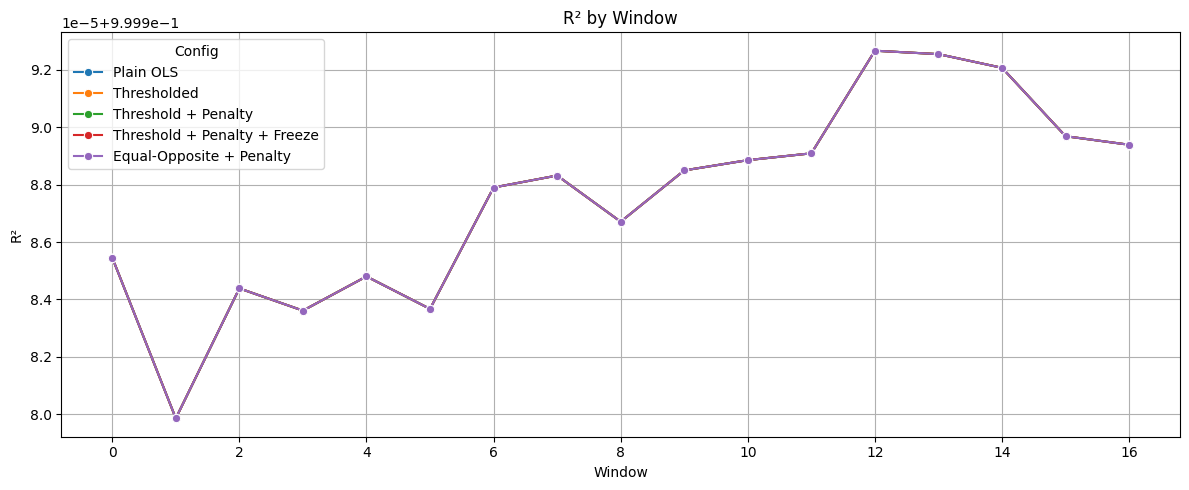

In [1]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial

def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
        XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []

    residual = Y

    for layer_config in layers:
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

        # Apply thresholding logic if provided
        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold  # (n_windows, n_features, n_outputs)
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        # Apply equal-opposite constraints
        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            # Create a feature-wise penalty mask by checking if all output weights
            # for a given feature are below the threshold in each window.
            feature_penalty_mask = jnp.all(penalty_mask, axis=-1)  # (n_windows, n_features)

            # Construct a diagonal penalty term to add to XtX
            penalty_diag_values = feature_penalty_mask.astype(float) * penalty_strength
            penalty_term = jnp.einsum('nf,fg->nfg', penalty_diag_values, jnp.eye(n_features)) # (n_windows, n_features, n_features)

            XtX = jnp.einsum('nwf,nwg->nfg', X_wins, X_wins)  # (n_windows, n_features, n_features)
            XtY = jnp.einsum('nwf,nwo->nfo', X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

            W_pen = jnp.linalg.solve(XtX + penalty_term, XtY) # (n_windows, n_features, n_outputs)

            # Apply freezing based on the original penalty mask
            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        Y_preds = jnp.einsum('nwf,nfo->nwo', X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers

# Example usage
if __name__ == '__main__':
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    print("--- Plain OLS ---")
    weights_ols, r2s_ols = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}]
    )
    print(r2s_ols[0])

    print("--- Penalized with Threshold and Freeze ---")
    weights_pen, r2s_pen = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}],
        threshold=0.1,
        penalty_strength=1e3,
        freeze_non_masked=True
    )
    print(r2s_pen[0])

    print("--- Equal-Opposite Constraint + Multi-Layer ---")
    weights_multi, r2s_multi = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        threshold=0.05,
        penalty_strength=500.0,
        freeze_non_masked=True,
        equal_opposite_constraints=[(0, 1)]
    )
    for i, r2 in enumerate(r2s_multi):
        print(f"Layer {i + 1} R²:", r2)

def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
        XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []
    residual = Y

    for _ in layers:
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

        penalty_mask = jnp.abs(W) < threshold if threshold is not None else jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            feature_penalty_mask = jnp.all(penalty_mask, axis=-1)  # (n_windows, n_features)
            penalty_diag = jnp.einsum('nf,fg->nfg', feature_penalty_mask.astype(float) * penalty_strength, jnp.eye(n_features))
            XtX = jnp.einsum("nwf,nwg->nfg", X_wins, X_wins)
            XtY = jnp.einsum("nwf,nwo->nfo", X_wins, Y_wins)
            W_pen = jnp.linalg.solve(XtX + penalty_diag, XtY)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=(1, 2))
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=(1, 2))
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        stacked_preds = jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]
        residual = residual - stacked_preds

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers

key = jax.random.PRNGKey(0)
n_samples, n_features, n_outputs = 100, 5, 4
X = jax.random.normal(key, (n_samples, n_features))
true_W = jax.random.normal(key, (n_features, n_outputs))
Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

def run_and_log(name, **kwargs):
    print(f"\n=== {name} ===")
    W_layers, R2_layers = make_sliding_regression_with_penalty_fn(X, Y, window_size=20, stride=5, n_outputs=n_outputs, layers=[{"layer": 1}], **kwargs)
    print("R² by window:", R2_layers[0])
    return name, R2_layers

results = []
results.append(run_and_log("Plain OLS"))

results.append(run_and_log("Thresholded", threshold=0.1))

results.append(run_and_log("Threshold + Penalty", threshold=0.1, penalty_strength=1000.0))

results.append(run_and_log("Threshold + Penalty + Freeze", threshold=0.1, penalty_strength=1000.0, freeze_non_masked=True))

results.append(run_and_log("Equal-Opposite + Penalty", threshold=0.1, penalty_strength=500.0, equal_opposite_constraints=[(0, 1)]))

import pandas as pd

def plot_r2_by_window(results):
    all_data = []
    for name, r2s in results:
        for i, r2 in enumerate(r2s[0]):
            all_data.append({"Config": name, "Window": i, "R²": float(r2)})
    df = pd.DataFrame(all_data)

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x="Window", y="R²", hue="Config", marker="o")
    plt.title("R² by Window")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_r2_by_window(results)

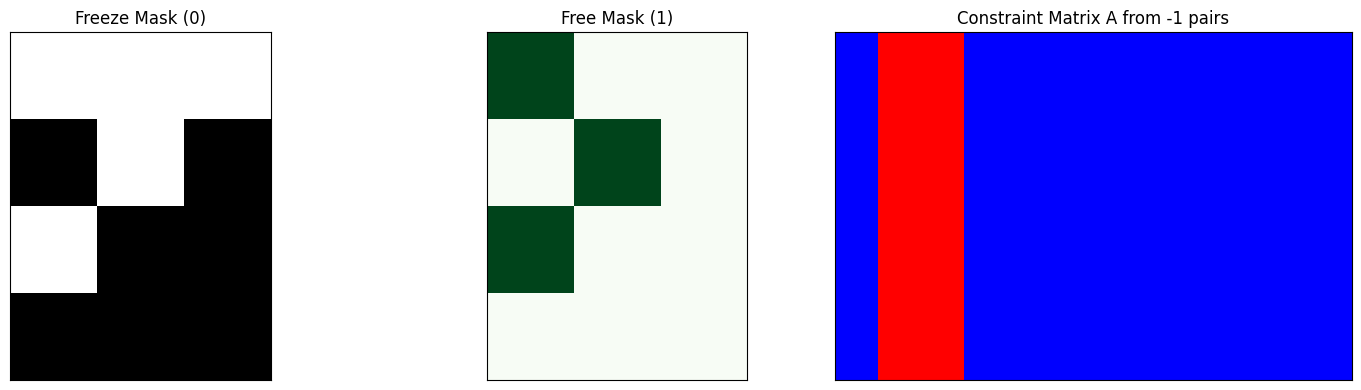

Constraint matrix A (each row is a linear constraint):
    w0   w1   w2   w3   w4   w5   w6   w7   w8   w9  w10  w11
0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

def parse_control_mask(control_mask):
    """
    Parses a control mask into:
    - freeze_mask: boolean mask where control_mask == 0
    - free_mask: boolean mask where control_mask == 1
    - A: linear constraint matrix for all -1 pairs

    Args:
        control_mask: array of shape (...), entries in {0, 1, -1}

    Returns:
        freeze_mask, free_mask, A (constraint matrix)
    """
    shape = control_mask.shape
    flat_size = int(jnp.prod(jnp.array(shape)))
    idx_array = jnp.arange(flat_size).reshape(shape)

    freeze_mask = (control_mask == 0)
    free_mask = (control_mask == 1)
    constrained_mask = (control_mask == -1)

    constrained_indices = idx_array[constrained_mask].flatten()
    if constrained_indices.shape[0] % 2 != 0:
        raise ValueError("Odd number of constrained indices; must be in pairs.")

    n_pairs = constrained_indices.shape[0] // 2
    A = []

    for i in range(n_pairs):
        i1 = constrained_indices[2 * i]
        i2 = constrained_indices[2 * i + 1]
        row = jnp.zeros(flat_size)
        row = row.at[i1].set(1.0)
        row = row.at[i2].set(1.0)
        A.append(row)

    if A:
        A = jnp.stack(A)
    else:
        A = jnp.zeros((0, flat_size))

    return freeze_mask, free_mask, A

# =======================
# 🧪 Example + Visuals
# =======================

# control_mask: (n_countries=2, n_tenors=2, n_hedges=3)
control_mask = jnp.array([
    [[1, -1, -1], [0, 1, 0]],
    [[1, 0, 0],   [0, 0, 0]]
])

freeze_mask, free_mask, A = parse_control_mask(control_mask)

# Plot masks
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(freeze_mask.reshape(-1, control_mask.shape[-1]), cmap='Greys', interpolation='nearest')
axes[0].set_title("Freeze Mask (0)")

axes[1].imshow(free_mask.reshape(-1, control_mask.shape[-1]), cmap='Greens', interpolation='nearest')
axes[1].set_title("Free Mask (1)")

axes[2].imshow(A, cmap='bwr', interpolation='nearest', aspect='auto')
axes[2].set_title("Constraint Matrix A from -1 pairs")

for ax in axes:
    ax.set_xticks([]), ax.set_yticks([])

plt.tight_layout()
plt.show()

# Print constraint matrix A
df = pd.DataFrame(A, columns=[f"w{i}" for i in range(A.shape[1])])
print("Constraint matrix A (each row is a linear constraint):")
print(df.round(1))


=== Plain OLS ===
R² by window: [0.99998546 0.99997985 0.9999844  0.9999836  0.9999848  0.99998367
 0.9999879  0.9999883  0.9999867  0.9999885  0.99998885 0.9999891
 0.99999267 0.99999255 0.9999921  0.9999897  0.9999894 ]

=== Thresholded ===
R² by window: [0.99998546 0.99997985 0.9999844  0.9999836  0.9999848  0.99998367
 0.9999879  0.9999883  0.9999867  0.9999885  0.99998885 0.9999891
 0.99999267 0.99999255 0.9999921  0.9999897  0.9999894 ]

=== Threshold + Penalty ===
R² by window: [0.99998546 0.99997985 0.9999844  0.9999836  0.9999848  0.99998367
 0.9999879  0.9999883  0.9999867  0.9999885  0.99998885 0.9999891
 0.99999267 0.99999255 0.9999921  0.9999897  0.9999894 ]

=== Threshold + Penalty + Freeze ===
R² by window: [0.99998546 0.99997985 0.9999844  0.9999836  0.9999848  0.99998367
 0.9999879  0.9999883  0.9999867  0.9999885  0.99998885 0.9999891
 0.99999267 0.99999255 0.9999921  0.9999897  0.9999894 ]

=== Equal-Opposite + Penalty ===
R² by window: [0.99998546 0.99997985 0.9999

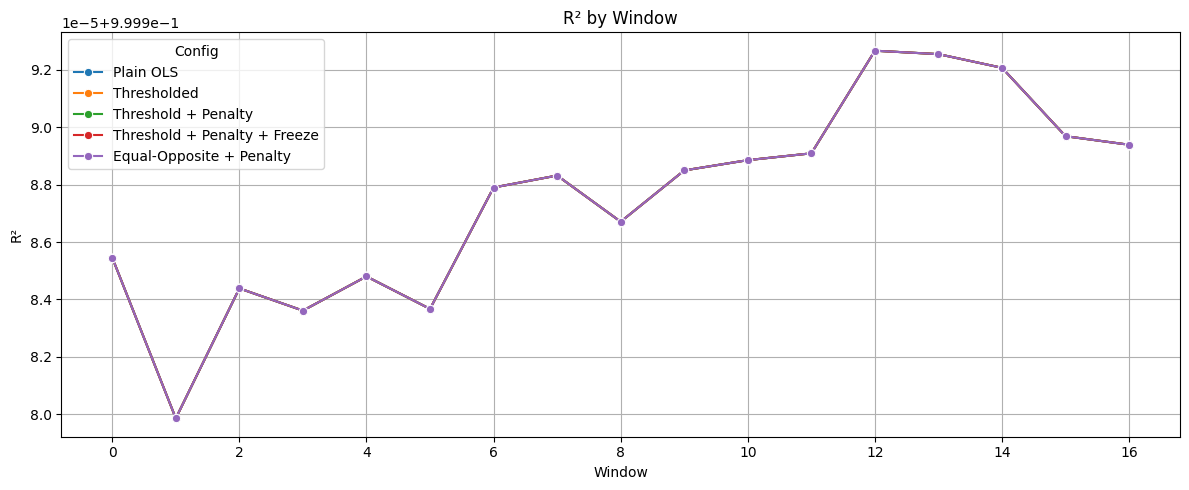

In [18]:
key = jax.random.PRNGKey(0)
n_samples, n_features, n_outputs = 100, 5, 4
X = jax.random.normal(key, (n_samples, n_features))
true_W = jax.random.normal(key, (n_features, n_outputs))
Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

def run_and_log(name, **kwargs):
    print(f"\n=== {name} ===")
    W_layers, R2_layers = make_sliding_regression_with_penalty_fn(X, Y, window_size=20, stride=5, n_outputs=n_outputs, layers=[{"layer": 1}], **kwargs)
    print("R² by window:", R2_layers[0])
    return name, R2_layers

results = []
results.append(run_and_log("Plain OLS"))

results.append(run_and_log("Thresholded", threshold=0.1))

results.append(run_and_log("Threshold + Penalty", threshold=0.1, penalty_strength=1000.0))

results.append(run_and_log("Threshold + Penalty + Freeze", threshold=0.1, penalty_strength=1000.0, freeze_non_masked=True))

results.append(run_and_log("Equal-Opposite + Penalty", threshold=0.1, penalty_strength=500.0, equal_opposite_constraints=[(0, 1)]))


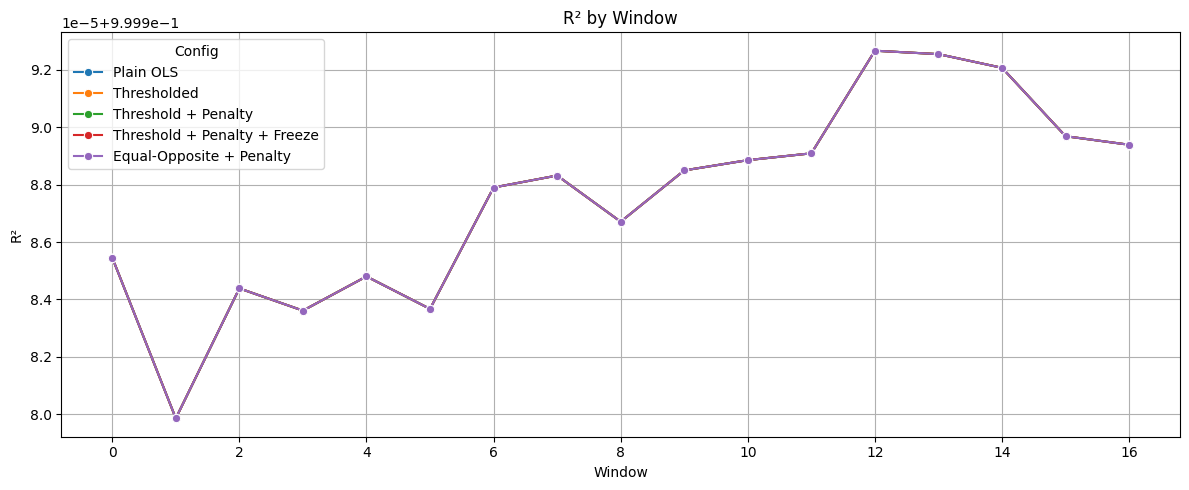

In [14]:
import pandas as pd

def plot_r2_by_window(results):
    all_data = []
    for name, r2s in results:
        for i, r2 in enumerate(r2s[0]):
            all_data.append({"Config": name, "Window": i, "R²": float(r2)})
    df = pd.DataFrame(all_data)

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x="Window", y="R²", hue="Config", marker="o")
    plt.title("R² by Window")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_r2_by_window(results)

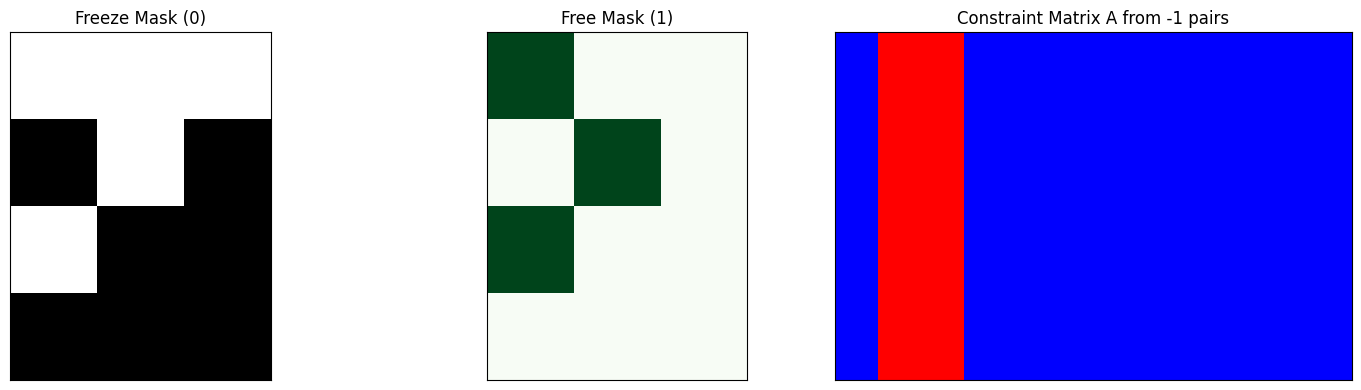

Constraint matrix A (each row is a linear constraint):
    w0   w1   w2   w3   w4   w5   w6   w7   w8   w9  w10  w11
0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

def parse_control_mask(control_mask):
    """
    Parses a control mask into:
    - freeze_mask: boolean mask where control_mask == 0
    - free_mask: boolean mask where control_mask == 1
    - A: linear constraint matrix for all -1 pairs

    Args:
        control_mask: array of shape (...), entries in {0, 1, -1}

    Returns:
        freeze_mask, free_mask, A (constraint matrix)
    """
    shape = control_mask.shape
    flat_size = int(jnp.prod(jnp.array(shape)))
    idx_array = jnp.arange(flat_size).reshape(shape)

    freeze_mask = (control_mask == 0)
    free_mask = (control_mask == 1)
    constrained_mask = (control_mask == -1)

    constrained_indices = idx_array[constrained_mask].flatten()
    if constrained_indices.shape[0] % 2 != 0:
        raise ValueError("Odd number of constrained indices; must be in pairs.")

    n_pairs = constrained_indices.shape[0] // 2
    A = []

    for i in range(n_pairs):
        i1 = constrained_indices[2 * i]
        i2 = constrained_indices[2 * i + 1]
        row = jnp.zeros(flat_size)
        row = row.at[i1].set(1.0)
        row = row.at[i2].set(1.0)
        A.append(row)

    if A:
        A = jnp.stack(A)
    else:
        A = jnp.zeros((0, flat_size))

    return freeze_mask, free_mask, A

# =======================
# 🧪 Example + Visuals
# =======================

# control_mask: (n_countries=2, n_tenors=2, n_hedges=3)
control_mask = jnp.array([
    [[1, -1, -1], [0, 1, 0]],
    [[1, 0, 0],   [0, 0, 0]]
])

freeze_mask, free_mask, A = parse_control_mask(control_mask)

# Plot masks
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(freeze_mask.reshape(-1, control_mask.shape[-1]), cmap='Greys', interpolation='nearest')
axes[0].set_title("Freeze Mask (0)")

axes[1].imshow(free_mask.reshape(-1, control_mask.shape[-1]), cmap='Greens', interpolation='nearest')
axes[1].set_title("Free Mask (1)")

axes[2].imshow(A, cmap='bwr', interpolation='nearest', aspect='auto')
axes[2].set_title("Constraint Matrix A from -1 pairs")

for ax in axes:
    ax.set_xticks([]), ax.set_yticks([])

plt.tight_layout()
plt.show()

# Print constraint matrix A
df = pd.DataFrame(A, columns=[f"w{i}" for i in range(A.shape[1])])
print("Constraint matrix A (each row is a linear constraint):")
print(df.round(1))

Layer 1 R²: [[0.9999809  0.99999005 0.9925754  0.99998486]
 [0.9999477  0.9999834  0.99901366 0.99998677]
 [0.99996334 0.9999896  0.99675673 0.99999046]
 [0.99994516 0.99998957 0.9989751  0.99999183]
 [0.9999678  0.9999928  0.99841434 0.9999918 ]
 [0.99998045 0.9999891  0.99486154 0.9999882 ]
 [0.9999888  0.9999835  0.9861439  0.9999929 ]
 [0.9999907  0.99997795 0.98743266 0.9999934 ]
 [0.99995613 0.99997795 0.9974359  0.9999941 ]
 [0.9999497  0.99998665 0.9970439  0.99999285]
 [0.9999433  0.99998707 0.9989976  0.9999924 ]
 [0.9999686  0.9999857  0.99986213 0.9999908 ]
 [0.99999404 0.9999865  0.9996383  0.9999922 ]
 [0.99998885 0.9999908  0.99759996 0.9999939 ]
 [0.9999905  0.99997884 0.99945    0.9999957 ]
 [0.9999875  0.9999517  0.9986696  0.9999951 ]
 [0.99998593 0.9999718  0.99910605 0.9999943 ]]
Layer 2 R²: [[-1.3083696e-02 -2.7976394e-02  9.9740946e-01 -1.1920929e-07]
 [ 6.6098809e-02  2.2942293e-01  3.4916037e-01  4.0053231e-01]
 [ 2.5119120e-01  3.2642102e-01  4.0436220e-01  3.

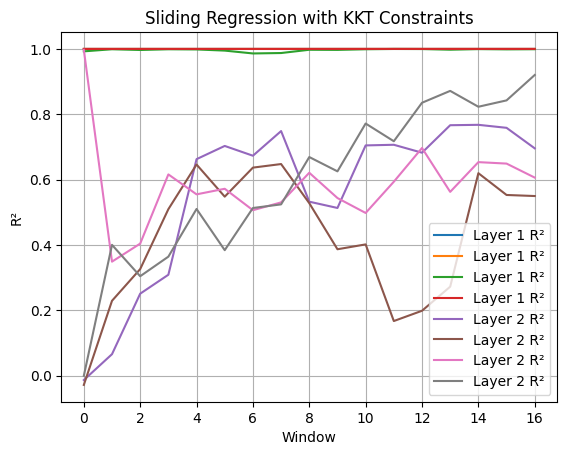

In [7]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial
import matplotlib.pyplot as plt


def kkt_solve(XTX, XTY, A, b):
    """
    Solve constrained least squares using KKT system:
    Minimize ||Xw - y||^2 subject to Aw = b
    """
    n_features, n_outputs = XTY.shape
    n_constraints = A.shape[0]
    zeros = jnp.zeros((n_constraints, n_constraints))

    top = jnp.concatenate([XTX, A.T], axis=1)
    bottom = jnp.concatenate([A, zeros], axis=1)
    KKT = jnp.concatenate([top, bottom], axis=0)

    rhs = jnp.concatenate([XTY, b], axis=0)
    sol = jnp.linalg.solve(KKT, rhs)
    return sol[:n_features]


def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
    control_masks=None,  # list of (n_features, n_outputs) with 0 (freeze), 1 (opt), -1 (constrained)
    A_matrices=None,     # list of constraint matrices A per layer
    b_vectors=None,      # list of constraint targets b per layer
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
        XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []
    residual = Y

    for l_idx, layer_config in enumerate(layers):
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)

        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            feature_penalty_mask = jnp.all(penalty_mask, axis=-1)
            penalty_diag = feature_penalty_mask.astype(float) * penalty_strength
            penalty_term = jnp.einsum("nf,fg->nfg", penalty_diag, jnp.eye(n_features))

            XtX = jnp.einsum("nwf,nwg->nfg", X_wins, X_wins)
            XtY = jnp.einsum("nwf,nwo->nfo", X_wins, Y_wins)

            if control_masks and A_matrices and b_vectors and control_masks[l_idx] is not None:
                mask = control_masks[l_idx]
                A = A_matrices[l_idx]
                b = b_vectors[l_idx]
                W_pen = vmap(lambda xtx, xty: kkt_solve(xtx + penalty_term[0], xty, A, b))(XtX, XtY)
            else:
                W_pen = jnp.linalg.solve(XtX + penalty_term, XtY)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        if threshold is not None:
            W_final = jnp.where(jnp.abs(W_final) < threshold, 0.0, W_final)

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers


if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    control_mask = jnp.ones((n_features, n_outputs))
    control_mask = control_mask.at[0, 0].set(-1)  # constrained var
    control_mask = control_mask.at[1, 0].set(1)   # free var
    A = jnp.zeros((1, n_features))
    A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)  # w0 + w1 = 0
    b = jnp.zeros((1, n_outputs))

    weights_constrained, r2s_constrained = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        threshold=0.05,
        penalty_strength=1e3,
        freeze_non_masked=True,
        control_masks=[control_mask, None],
        A_matrices=[A, None],
        b_vectors=[b, None],
    )

    for i, r2 in enumerate(r2s_constrained):
        print(f"Layer {i + 1} R²:", r2)
        plt.plot(r2, label=f"Layer {i + 1} R²")
    plt.xlabel("Window")
    plt.ylabel("R²")
    plt.legend()
    plt.title("Sliding Regression with KKT Constraints")
    plt.grid(True)
    plt.show()


In [36]:
import jax
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt

def kkt_solve(XTX, XTY, A=None, b=None):
    if A is None or b is None:
        return jnp.linalg.solve(XTX + 1e-6 * jnp.eye(XTX.shape[0]), XTY)
    n_constraints = A.shape[0]
    zeros = jnp.zeros((n_constraints, n_constraints))
    KKT = jnp.block([[XTX, A.T], [A, zeros]])
    RHS = jnp.concatenate([XTY, b], axis=0)
    sol = jnp.linalg.solve(KKT + 1e-6 * jnp.eye(KKT.shape[0]), RHS)
    return sol[:XTX.shape[0]]

def sliding_regression_with_constraints(X, Y, window_size, stride, layers, constraint_fn=None):
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    def extract_windows(M):
        idx = jnp.arange(n_windows)
        return vmap(lambda i: M[i*stride:i*stride+window_size])(idx)

    W_layers, R2_layers = [], []
    residual = Y

    for layer_idx in range(len(layers)):
        X_win = extract_windows(X)
        Y_win = extract_windows(residual)

        XtX = jnp.einsum('nwi,nwj->nij', X_win, X_win)
        XtY = jnp.einsum('nwi,nwo->nio', X_win, Y_win)

        def solve(XtX_i, XtY_i):
            A, b = constraint_fn(layer_idx) if constraint_fn else (None, None)
            return kkt_solve(XtX_i, XtY_i, A, b)

        W = vmap(solve)(XtX, XtY)
        Y_pred = jnp.einsum('nwi,nio->nwo', X_win, W)
        residual = residual - jnp.concatenate([Y_pred[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        ss_res = jnp.sum((Y_win - Y_pred)**2, axis=(1, 2))
        ss_tot = jnp.sum((Y_win - jnp.mean(Y_win, axis=1, keepdims=True))**2, axis=(1, 2))
        R2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        W_layers.append(W)
        R2_layers.append(R2)

    return W_layers, R2_layers

In [10]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial

def kkt_solve(X, Y, A, epsilon, big_penalty):
    """Closed-form KKT solver: solves (XᵀX + εI)W + Aᵀλ = XᵀY with AW = 0"""
    n, d, o = X.shape[0], X.shape[1], Y.shape[1]
    XtX = X.T @ X + epsilon * jnp.eye(d)
    XtY = X.T @ Y
    if A is None:
        return jnp.linalg.solve(XtX, XtY)
    else:
        At = A.T
        K = jnp.block([[XtX + big_penalty * A.T @ A, At], [A, jnp.zeros((A.shape[0], A.shape[0]))]])
        rhs = jnp.concatenate([XtY, jnp.zeros((A.shape[0], o))], axis=0)
        sol = jnp.linalg.solve(K, rhs)
        return sol[:d]

def solve_window(Xw, Yw, mask, A, epsilon, big_penalty):
    d, o = Xw.shape[1], Yw.shape[1]
    A_used = A if A is not None else None
    return kkt_solve(Xw, Yw, A_used, epsilon, big_penalty)

def sliding_regression_with_constraints(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    epsilon=1e-6,
    big_penalty=1e6,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    W_layers = []
    R2_layers = []
    residual = Y

    for layer in layers:
        mask = layer.get("mask", jnp.ones((n_features, n_outputs)))
        A = layer.get("A", None)

        idxs = jnp.arange(n_windows)
        X_wins = vmap(get_window, in_axes=(None, 0))(X, idxs)
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, idxs)

        W = vmap(solve_window, in_axes=(0, 0, None, None, None, None))(
            X_wins, Y_wins, mask, A, epsilon, big_penalty
        )

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - ss_res / (ss_tot + 1e-8)

        # update residual for next layer
        full_pred = jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]
        residual = residual - full_pred

        W_layers.append(W)
        R2_layers.append(r2)

    return W_layers, R2_layers

Layer 1 R²: [[0.9999809  0.99999005 0.9925754  0.99998486]
 [0.9999477  0.9999834  0.99901366 0.99998677]
 [0.99996334 0.9999896  0.99675673 0.99999046]
 [0.99994516 0.99998957 0.9989751  0.99999183]
 [0.9999678  0.9999928  0.99841434 0.9999918 ]
 [0.99998045 0.9999891  0.99486154 0.9999882 ]
 [0.9999888  0.9999835  0.9861439  0.9999929 ]
 [0.9999907  0.99997795 0.98743266 0.9999934 ]
 [0.99995613 0.99997795 0.9974359  0.9999941 ]
 [0.9999497  0.99998665 0.9970439  0.99999285]
 [0.9999433  0.99998707 0.9989976  0.9999924 ]
 [0.9999686  0.9999857  0.99986213 0.9999908 ]
 [0.99999404 0.9999865  0.9996383  0.9999922 ]
 [0.99998885 0.9999908  0.99759996 0.9999939 ]
 [0.9999905  0.99997884 0.99945    0.9999957 ]
 [0.9999875  0.9999517  0.9986696  0.9999951 ]
 [0.99998593 0.9999718  0.99910605 0.9999943 ]]
Layer 2 R²: [[-1.3083696e-02 -2.7976394e-02  9.9740946e-01 -1.1920929e-07]
 [ 6.6098809e-02  2.2942293e-01  3.4916037e-01  4.0053231e-01]
 [ 2.5119120e-01  3.2642102e-01  4.0436220e-01  3.

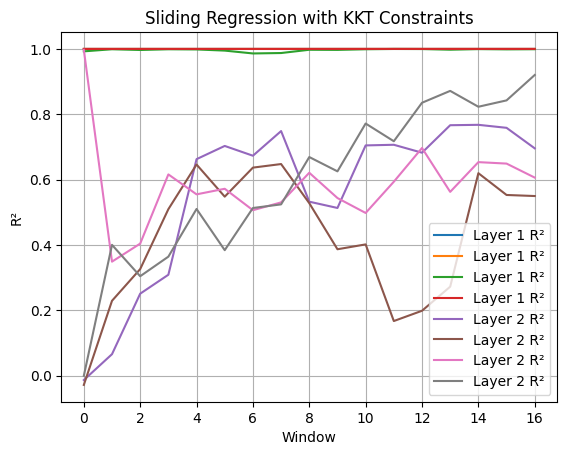

In [38]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial
import matplotlib.pyplot as plt


def kkt_solve(XTX, XTY, A, b):
    """
    Solve constrained least squares using KKT system:
    Minimize ||Xw - y||^2 subject to Aw = b
    """
    n_features, n_outputs = XTY.shape
    n_constraints = A.shape[0]
    zeros = jnp.zeros((n_constraints, n_constraints))

    top = jnp.concatenate([XTX, A.T], axis=1)
    bottom = jnp.concatenate([A, zeros], axis=1)
    KKT = jnp.concatenate([top, bottom], axis=0)

    rhs = jnp.concatenate([XTY, b], axis=0)
    sol = jnp.linalg.solve(KKT, rhs)
    return sol[:n_features]


def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
    control_masks=None,  # list of (n_features, n_outputs) with 0 (freeze), 1 (opt), -1 (constrained)
    A_matrices=None,     # list of constraint matrices A per layer
    b_vectors=None,      # list of constraint targets b per layer
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
        XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []
    residual = Y

    for l_idx, layer_config in enumerate(layers):
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)

        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            feature_penalty_mask = jnp.all(penalty_mask, axis=-1)
            penalty_diag = feature_penalty_mask.astype(float) * penalty_strength
            penalty_term = jnp.einsum("nf,fg->nfg", penalty_diag, jnp.eye(n_features))

            XtX = jnp.einsum("nwf,nwg->nfg", X_wins, X_wins)
            XtY = jnp.einsum("nwf,nwo->nfo", X_wins, Y_wins)

            if control_masks and A_matrices and b_vectors and control_masks[l_idx] is not None:
                mask = control_masks[l_idx]
                A = A_matrices[l_idx]
                b = b_vectors[l_idx]
                W_pen = vmap(lambda xtx, xty: kkt_solve(xtx + penalty_term[0], xty, A, b))(XtX, XtY)
            else:
                W_pen = jnp.linalg.solve(XtX + penalty_term, XtY)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        if threshold is not None:
            W_final = jnp.where(jnp.abs(W_final) < threshold, 0.0, W_final)

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers


if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    control_mask = jnp.ones((n_features, n_outputs))
    control_mask = control_mask.at[0, 0].set(-1)  # constrained var
    control_mask = control_mask.at[1, 0].set(1)   # free var
    A = jnp.zeros((1, n_features))
    A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)  # w0 + w1 = 0
    b = jnp.zeros((1, n_outputs))

    weights_constrained, r2s_constrained = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        threshold=0.05,
        penalty_strength=1e3,
        freeze_non_masked=True,
        control_masks=[control_mask, None],
        A_matrices=[A, None],
        b_vectors=[b, None],
    )

    for i, r2 in enumerate(r2s_constrained):
        print(f"Layer {i + 1} R²:", r2)
        plt.plot(r2, label=f"Layer {i + 1} R²")
    plt.xlabel("Window")
    plt.ylabel("R²")
    plt.legend()
    plt.title("Sliding Regression with KKT Constraints")
    plt.grid(True)
    plt.show()


Layer 1 R²: [[0.9999809  0.99999005 0.9999284  0.99998486]
 [0.9999477  0.9999834  0.99990493 0.99998677]
 [0.99996334 0.9999896  0.9998594  0.99999046]
 [0.99994516 0.99998957 0.9998711  0.99999183]
 [0.9999678  0.9999928  0.99983317 0.9999918 ]
 [0.99998045 0.9999891  0.99984676 0.9999882 ]
 [0.9999888  0.9999835  0.9999211  0.9999929 ]
 [0.9999907  0.99997795 0.9999098  0.9999934 ]
 [0.99995613 0.99997795 0.9998969  0.9999941 ]
 [0.9999497  0.99998665 0.9998904  0.99999285]
 [0.9999433  0.99998707 0.999886   0.9999924 ]
 [0.9999686  0.9999857  0.99986327 0.9999908 ]
 [0.99999404 0.9999865  0.9998735  0.9999922 ]
 [0.99998885 0.9999908  0.9998818  0.9999939 ]
 [0.9999905  0.99997884 0.9998739  0.9999957 ]
 [0.9999875  0.9999517  0.9998971  0.9999951 ]
 [0.99998593 0.9999718  0.9999575  0.9999943 ]]
Layer 2 R²: [[0.46998698 0.55212694 0.8228103  0.787085  ]
 [0.8901181  0.9242698  0.91254693 0.9487787 ]
 [0.9730171  0.98600173 0.98117983 0.9777641 ]
 [0.99999267 0.99999946 0.99998593 

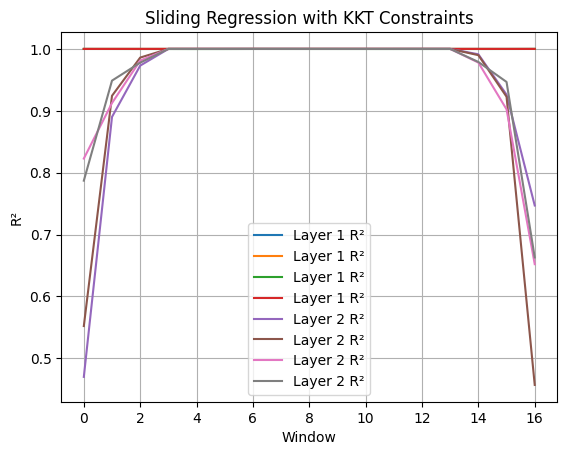

In [39]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial
import matplotlib.pyplot as plt

def kkt_solve(XTX, XTY, A, b):
    """
    Solve constrained least squares using KKT system:
    Minimize ||Xw - y||^2 subject to Aw = b
    """
    n_features, n_outputs = XTY.shape
    n_constraints = A.shape[0]
    zeros = jnp.zeros((n_constraints, n_constraints))

    top = jnp.concatenate([XTX, A.T], axis=1)
    bottom = jnp.concatenate([A, zeros], axis=1)
    KKT = jnp.concatenate([top, bottom], axis=0)

    rhs = jnp.concatenate([XTY, b], axis=0)
    sol = jnp.linalg.solve(KKT, rhs)
    return sol[:n_features]

def masked_kkt_layer(X_wins, Y_wins, penalty_mask, penalty_strength, A, b, control_mask):
    n_windows, n_features, n_outputs = penalty_mask.shape

    def solve_per_window(i):
        X_win = X_wins[i]
        Y_win = Y_wins[i]
        XtX = X_win.T @ X_win
        XtY = X_win.T @ Y_win

        mask_flat = control_mask.reshape(-1)
        active_idx = jnp.where(mask_flat == 1)[0]
        constrained_idx = jnp.where(mask_flat == -1)[0]

        if len(active_idx) == 0:
            return jnp.zeros((n_features, n_outputs))

        P = jnp.eye(n_features) * penalty_strength * jnp.any(penalty_mask[i], axis=-1).astype(jnp.float32)[:, None]
        W = kkt_solve(XtX + P, XtY, A, b)

        # Enforce freezing by zeroing out those not optimized
        frozen_idx = jnp.where(mask_flat == 0)[0]
        W = W.at[frozen_idx].set(0.0)

        return W

    return vmap(solve_per_window)(jnp.arange(n_windows))

def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
    control_masks=None,
    A_matrices=None,
    b_vectors=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
        XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []
    residual = Y

    for l_idx, layer_config in enumerate(layers):
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)

        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            if control_masks and A_matrices and b_vectors and control_masks[l_idx] is not None:
                mask = control_masks[l_idx]
                A = A_matrices[l_idx]
                b = b_vectors[l_idx]
                W_pen = masked_kkt_layer(X_wins, Y_wins, penalty_mask, penalty_strength, A, b, mask)
            else:
                XtX = jnp.einsum("nwf,nwg->nfg", X_wins, X_wins)
                XtY = jnp.einsum("nwf,nwo->nfo", X_wins, Y_wins)
                feature_penalty_mask = jnp.all(penalty_mask, axis=-1)
                penalty_diag = feature_penalty_mask.astype(float) * penalty_strength
                penalty_term = jnp.einsum("nf,fg->nfg", penalty_diag, jnp.eye(n_features))
                W_pen = jnp.linalg.solve(XtX + penalty_term, XtY)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        if threshold is not None:
            W_final = jnp.where(jnp.abs(W_final) < threshold, 0.0, W_final)

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        flat_preds = jnp.zeros_like(residual)
        for i in range(n_windows):
            idx = i * stride
            flat_preds = flat_preds.at[idx:idx+window_size].add(Y_preds[i])

        residual = residual - flat_preds

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers

if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    control_mask = jnp.ones((n_features, n_outputs))
    control_mask = control_mask.at[0, 0].set(-1)
    control_mask = control_mask.at[1, 0].set(1)
    A = jnp.zeros((1, n_features))
    A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)
    b = jnp.zeros((1, n_outputs))

    weights_constrained, r2s_constrained = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        threshold=0.05,
        penalty_strength=1e3,
        freeze_non_masked=True,
        control_masks=[control_mask, None],
        A_matrices=[A, None],
        b_vectors=[b, None],
    )

    for i, r2 in enumerate(r2s_constrained):
        print(f"Layer {i + 1} R²:", r2)
        plt.plot(r2, label=f"Layer {i + 1} R²")
    plt.xlabel("Window")
    plt.ylabel("R²")
    plt.legend()
    plt.title("Sliding Regression with KKT Constraints")
    plt.grid(True)
    plt.show()


(1, 5)
Layer 1 R²: [[0.9999809  0.99999005 0.9925753  0.99998486]
 [0.9999477  0.9999834  0.99901366 0.99998677]
 [0.99996334 0.9999896  0.9967567  0.99999046]
 [0.99994516 0.99998957 0.9989751  0.99999183]
 [0.9999678  0.9999928  0.99841434 0.9999918 ]
 [0.99998045 0.9999891  0.9948615  0.9999882 ]
 [0.9999888  0.9999835  0.9861437  0.9999929 ]
 [0.9999907  0.99997795 0.98743254 0.9999934 ]
 [0.99995613 0.99997795 0.9974359  0.9999941 ]
 [0.9999497  0.99998665 0.9970439  0.99999285]
 [0.9999433  0.99998707 0.9989976  0.9999924 ]
 [0.9999686  0.9999857  0.99986213 0.9999908 ]
 [0.99999404 0.9999865  0.9996383  0.9999922 ]
 [0.99998885 0.9999908  0.9975999  0.9999939 ]
 [0.9999905  0.99997884 0.99945    0.9999957 ]
 [0.9999875  0.9999517  0.99866956 0.9999951 ]
 [0.99998593 0.9999718  0.99910605 0.9999943 ]]
Layer 2 R²: [[-1.3083696e-02 -2.7976394e-02  9.9740952e-01 -1.1920929e-07]
 [ 6.6098809e-02  2.2942293e-01  3.4916079e-01  4.0053231e-01]
 [ 2.5119120e-01  3.2642102e-01  4.0436190e

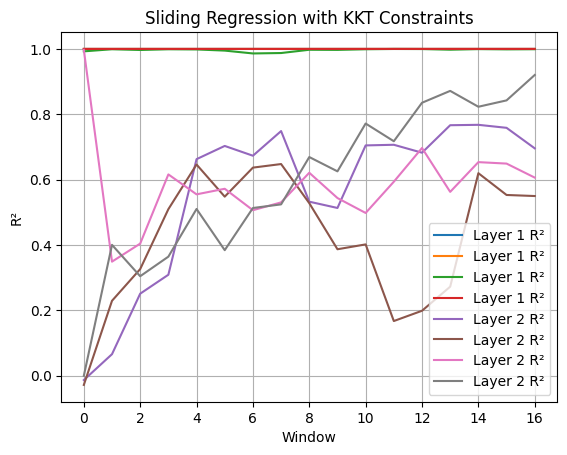

TypeError: add got incompatible shapes for broadcasting: (20, 5), (20, 20).

In [35]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial
import matplotlib.pyplot as plt


# def kkt_solve(XTX, XTY, A, b):
#     """
#     Solve constrained least squares using KKT system:
#     Minimize ||Xw - y||^2 subject to Aw = b
#     """
#     n_features, n_outputs = XTY.shape
#     n_constraints = A.shape[0]
#     zeros = jnp.zeros((n_constraints, n_constraints))

#     top = jnp.concatenate([XTX, A.T], axis=1)
#     bottom = jnp.concatenate([A, zeros], axis=1)
#     KKT = jnp.concatenate([top, bottom], axis=0)

#     rhs = jnp.concatenate([XTY, b], axis=0)
#     sol = jnp.linalg.solve(KKT, rhs)
#     return sol[:n_features]

# def kkt_solve(X, Y, A, epsilon, big_penalty):
#     """Closed-form KKT solver: solves (XᵀX + εI)W + Aᵀλ = XᵀY with AW = 0"""
#     n, d, o = X.shape[0], X.shape[1], Y.shape[1]
#     XtX = X.T @ X + epsilon * jnp.eye(d)
#     XtY = X.T @ Y
#     if A is None:
#         return jnp.linalg.solve(XtX, XtY)
#     else:
#         At = A.T
#         K = jnp.block([[XtX + big_penalty * A.T @ A, At], [A, jnp.zeros((A.shape[0], A.shape[0]))]])
#         rhs = jnp.concatenate([XtY, jnp.zeros((A.shape[0], o))], axis=0)
#         sol = jnp.linalg.solve(K, rhs)
#         return sol[:d]

def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
    control_masks=None,  # list of (n_features, n_outputs) with 0 (freeze), 1 (opt), -1 (constrained)
    A_matrices=None,     # list of constraint matrices A per layer
    b_vectors=None,      # list of constraint targets b per layer
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
        XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []
    residual = Y

    for l_idx, layer_config in enumerate(layers):
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)

        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            feature_penalty_mask = jnp.all(penalty_mask, axis=-1)
            penalty_diag = feature_penalty_mask.astype(float) * penalty_strength
            penalty_term = jnp.einsum("nf,fg->nfg", penalty_diag, jnp.eye(n_features))

            XtX = jnp.einsum("nwf,nwg->nfg", X_wins, X_wins)
            XtY = jnp.einsum("nwf,nwo->nfo", X_wins, Y_wins)

            if control_masks and A_matrices and b_vectors and control_masks[l_idx] is not None:
                mask = control_masks[l_idx]
                A = A_matrices[l_idx]
                b = b_vectors[l_idx]
                W_pen = vmap(lambda xtx, xty: kkt_solve(xtx + penalty_term[0], xty, A, b))(XtX, XtY)
            else:
                W_pen = jnp.linalg.solve(XtX + penalty_term, XtY)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        if threshold is not None:
            W_final = jnp.where(jnp.abs(W_final) < threshold, 0.0, W_final)

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers


if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    control_mask = jnp.ones((n_features, n_outputs))
    control_mask = control_mask.at[0, 0].set(-1)  # constrained var
    control_mask = control_mask.at[1, 0].set(1)   # free var
    A = jnp.zeros((1, n_features))
    A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)  # w0 + w1 = 0
    b = jnp.zeros((1, n_outputs))

    weights_constrained, r2s_constrained = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        threshold=0.05,
        penalty_strength=1e3,
        freeze_non_masked=True,
        control_masks=[control_mask, None],
        A_matrices=[A, None],
        b_vectors=[b, None],
    )

    for i, r2 in enumerate(r2s_constrained):
        print(f"Layer {i + 1} R²:", r2)
        plt.plot(r2, label=f"Layer {i + 1} R²")
    plt.xlabel("Window")
    plt.ylabel("R²")
    plt.legend()
    plt.title("Sliding Regression with KKT Constraints")
    plt.grid(True)
    plt.show()



# Synthetic data
key = jax.random.PRNGKey(0)
n_samples, n_features, n_outputs = 100, 5, 4
X = jax.random.normal(key, (n_samples, n_features))
true_W = jax.random.normal(key, (n_features, n_outputs))
Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

# Sliding window setup
window_size = 20
stride = 5

# Constraint: w0 + w1 = 0 for output 0
A_eq = jnp.zeros((1, n_features, n_outputs))
A_eq = A_eq.at[0, 0, 0].set(1.0)
A_eq = A_eq.at[0, 1, 0].set(1.0)

# Constraint Mask: 1 = optimize, -1 = part of constraint
mask1 = jnp.ones((n_features, n_outputs))
mask2 = mask1.at[0, 0].set(-1).at[1, 0].set(-1)

# Run constrained model
W_layers, R2_layers = sliding_regression_with_constraints(
    X, Y,
    window_size=window_size,
    stride=stride,
#    n_outputs=n_outputs,
    layers=[
        {"mask": mask1},
        {"mask": mask2, "A": A_eq}
    ],
    epsilon=1e-6,
    big_penalty=1e4
)

# Baseline unconstrained model
W_base, R2_base = sliding_regression_with_constraints(
    X, Y,
    window_size=window_size,
    stride=stride,
    n_outputs=n_outputs,
    layers=[
        {"mask": mask1},
        {"mask": mask1}
    ],
    epsilon=1e-6,
    big_penalty=1e4
)

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(jnp.mean(R2_layers[0], axis=1), label="Layer 1 (constrained)")
plt.plot(jnp.mean(R2_layers[1], axis=1), label="Layer 2 (constrained)")
plt.plot(jnp.mean(R2_base[1], axis=1), '--', label="Layer 2 (unconstrained)")
plt.title("R² Comparison")
plt.xlabel("Window")
plt.ylabel("R²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
big_penalty=1.e6

In [34]:
def kkt_solve(XTX, XTY, A=None, b=None):
    """
    Solve (XᵀX)W = XᵀY with optional linear equality constraints AW = b via KKT system.

    Parameters:
    - XTX: (n_features, n_features)
    - XTY: (n_features, n_outputs)
    - A: (n_constraints, n_features), optional
    - b: (n_constraints, n_outputs), optional

    Returns:
    - W: (n_features, n_outputs)
    """
    if A is None or b is None:
        return jnp.linalg.solve(XTX + 1e-6 * jnp.eye(XTX.shape[0]), XTY)

    # Now it's safe to access shapes
    n_features, n_outputs = XTY.shape
    print(A.shape)
    n_constraints = A.shape[0]

    zeros = jnp.zeros((n_constraints, n_constraints))
    KKT_mat = jnp.block([
        [XTX, A.T],
        [A, zeros]
    ])  # Shape: (n_features + n_constraints, n_features + n_constraints)

    RHS = jnp.concatenate([XTY, b], axis=0)  # Shape: (n_features + n_constraints, n_outputs)

    sol = jnp.linalg.solve(KKT_mat + 1e-6 * jnp.eye(KKT_mat.shape[0]), RHS)
    return sol[:n_features]

In [26]:
def kkt_solve(X, Y, A, epsilon, big_penalty):
    """Closed-form KKT solver: solves (XᵀX + εI)W + Aᵀλ = XᵀY with AW = 0"""
    n, d, o = X.shape[0], X.shape[1], Y.shape[1]
    XtX = X.T @ X + epsilon * jnp.eye(d)
    XtY = X.T @ Y
    if A is None:
        return jnp.linalg.solve(XtX, XtY)
    else:
        At = A.T
        K = jnp.block([[XtX + big_penalty * A.T @ A, At], [A, jnp.zeros((A.shape[0], A.shape[0]))]])
        rhs = jnp.concatenate([XtY, jnp.zeros((A.shape[0], o))], axis=0)
        sol = jnp.linalg.solve(K, rhs)
        return sol[:d]

Layer 1 R²: [[0.9999809  0.99999005 0.9999284  0.99998486]
 [0.9999477  0.9999834  0.99990493 0.99998677]
 [0.99996334 0.9999896  0.9998594  0.99999046]
 [0.99994516 0.99998957 0.9998711  0.99999183]
 [0.9999678  0.9999928  0.99983317 0.9999918 ]
 [0.99998045 0.9999891  0.99984676 0.9999882 ]
 [0.9999888  0.9999835  0.9999211  0.9999929 ]
 [0.9999907  0.99997795 0.9999098  0.9999934 ]
 [0.99995613 0.99997795 0.9998969  0.9999941 ]
 [0.9999497  0.99998665 0.9998904  0.99999285]
 [0.9999433  0.99998707 0.999886   0.9999924 ]
 [0.9999686  0.9999857  0.99986327 0.9999908 ]
 [0.99999404 0.9999865  0.9998735  0.9999922 ]
 [0.99998885 0.9999908  0.9998818  0.9999939 ]
 [0.9999905  0.99997884 0.9998739  0.9999957 ]
 [0.9999875  0.9999517  0.9998971  0.9999951 ]
 [0.99998593 0.9999718  0.9999575  0.9999943 ]]
Layer 2 R²: [[0.46998698 0.55212694 0.8228103  0.787085  ]
 [0.8901181  0.9242698  0.91254693 0.9487787 ]
 [0.9730171  0.98600173 0.98117983 0.9777641 ]
 [0.99999267 0.99999946 0.99998593 

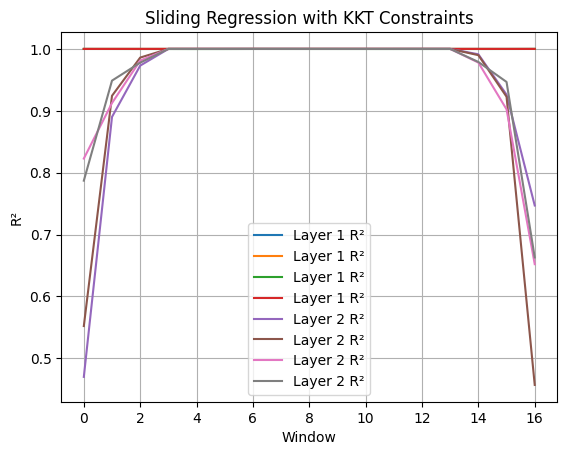

In [40]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial
import matplotlib.pyplot as plt

def kkt_solve(XTX, XTY, A, b):
    """
    Solve constrained least squares using KKT system:
    Minimize ||Xw - y||^2 subject to Aw = b
    """
    n_features, n_outputs = XTY.shape
    n_constraints = A.shape[0]
    zeros = jnp.zeros((n_constraints, n_constraints))

    top = jnp.concatenate([XTX, A.T], axis=1)
    bottom = jnp.concatenate([A, zeros], axis=1)
    KKT = jnp.concatenate([top, bottom], axis=0)

    rhs = jnp.concatenate([XTY, b], axis=0)
    sol = jnp.linalg.solve(KKT, rhs)
    return sol[:n_features]

def masked_kkt_layer(X_wins, Y_wins, penalty_mask, penalty_strength, A, b, control_mask):
    n_windows, n_features, n_outputs = penalty_mask.shape

    def solve_per_window(i):
        X_win = X_wins[i]
        Y_win = Y_wins[i]
        XtX = X_win.T @ X_win
        XtY = X_win.T @ Y_win

        mask_flat = control_mask.reshape(-1)
        active_idx = jnp.where(mask_flat == 1)[0]
        constrained_idx = jnp.where(mask_flat == -1)[0]

        if len(active_idx) == 0:
            return jnp.zeros((n_features, n_outputs))

        P = jnp.eye(n_features) * penalty_strength * jnp.any(penalty_mask[i], axis=-1).astype(jnp.float32)[:, None]
        W = kkt_solve(XtX + P, XtY, A, b)

        # Enforce freezing by zeroing out those not optimized
        frozen_idx = jnp.where(mask_flat == 0)[0]
        W = W.at[frozen_idx].set(0.0)

        return W

    return vmap(solve_per_window)(jnp.arange(n_windows))

def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
    control_masks=None,
    A_matrices=None,
    b_vectors=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
        XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []
    residual = Y

    for l_idx, layer_config in enumerate(layers):
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)

        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            if control_masks and A_matrices and b_vectors and control_masks[l_idx] is not None:
                mask = control_masks[l_idx]
                A = A_matrices[l_idx]
                b = b_vectors[l_idx]
                W_pen = masked_kkt_layer(X_wins, Y_wins, penalty_mask, penalty_strength, A, b, mask)
            else:
                XtX = jnp.einsum("nwf,nwg->nfg", X_wins, X_wins)
                XtY = jnp.einsum("nwf,nwo->nfo", X_wins, Y_wins)
                feature_penalty_mask = jnp.all(penalty_mask, axis=-1)
                penalty_diag = feature_penalty_mask.astype(float) * penalty_strength
                penalty_term = jnp.einsum("nf,fg->nfg", penalty_diag, jnp.eye(n_features))
                W_pen = jnp.linalg.solve(XtX + penalty_term, XtY)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        if threshold is not None:
            W_final = jnp.where(jnp.abs(W_final) < threshold, 0.0, W_final)

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        flat_preds = jnp.zeros_like(residual)
        for i in range(n_windows):
            idx = i * stride
            flat_preds = flat_preds.at[idx:idx+window_size].add(Y_preds[i])

        residual = residual - flat_preds

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers

if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    control_mask = jnp.ones((n_features, n_outputs))
    control_mask = control_mask.at[0, 0].set(-1)
    control_mask = control_mask.at[1, 0].set(1)
    A = jnp.zeros((1, n_features))
    A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)
    b = jnp.zeros((1, n_outputs))

    weights_constrained, r2s_constrained = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        threshold=0.05,
        penalty_strength=1e3,
        freeze_non_masked=True,
        control_masks=[control_mask, None],
        A_matrices=[A, None],
        b_vectors=[b, None],
    )

    for i, r2 in enumerate(r2s_constrained):
        print(f"Layer {i + 1} R²:", r2)
        plt.plot(r2, label=f"Layer {i + 1} R²")
    plt.xlabel("Window")
    plt.ylabel("R²")
    plt.legend()
    plt.title("Sliding Regression with KKT Constraints")
    plt.grid(True)
    plt.show()


In [41]:
import jax
import jax.numpy as jnp

@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX, XtY)

def kkt_solve(XTX, XTY, A, b):
    """
    Solve constrained least squares using KKT system:
    Minimize ||Xw - y||^2 subject to Aw = b
    """
    n_features, n_outputs = XTY.shape
    n_constraints = A.shape[0]
    zeros = jnp.zeros((n_constraints, n_constraints))

    top = jnp.concatenate([XTX, A.T], axis=1)
    bottom = jnp.concatenate([A, zeros], axis=1)
    KKT = jnp.concatenate([top, bottom], axis=0)

    rhs = jnp.concatenate([XTY, b], axis=0)
    sol = jnp.linalg.solve(KKT, rhs)
    return sol[:n_features]

def make_sliding_regression_with_penalty_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None, top_n_per_country=None,
    freeze_non_masked=False
):
    @jax.jit
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]
        assert d_features == 7, "X must have 7 features"
        assert n_countries * n_tenors == n_outputs, "n_countries * n_tenors must equal Y.shape[1]"

        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, 7, n_outputs)

        if group_by_country:
            W_reshaped = W_ols.reshape((n_windows, 7, n_countries, n_tenors))
            abs_W = jnp.abs(W_reshaped)

            if group_trigger_mode == "forced":
                if forced_group_mask is None:
                    raise ValueError("forced_group_mask must be provided when using 'forced'")
                if forced_group_mask.shape != (n_countries, n_tenors, 7):
                    raise ValueError(f"forced_group_mask must have shape ({n_countries}, {n_tenors}, 7)")
                group_mask_broadcast = jnp.broadcast_to(
                    forced_group_mask[None, :, :, :], (n_windows, n_countries, n_tenors, 7)
                ).transpose(0, 3, 1, 2)  # (n_windows, 7, n_countries, n_tenors)

            else:
                raise ValueError("This setup only covers 'forced' mode for simplicity.")

            penalty_mask = jnp.where(group_mask_broadcast, big_penalty, 0.0).reshape((n_windows, 7, n_countries * n_tenors))
        else:
            threshold = jnp.abs(W_ols) < epsilon
            penalty_mask = jnp.where(threshold, big_penalty, 0.0)

        def penalized_ols(X_win, Y_win, penalty_mat):
            XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
            XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

            def solve_per_output(XtY_col, penalties_col, idx):
                if penalties_col[0] == -1.0:  # signal for equality constraint: w0 + w1 = 0 => w1 = -w0
                    A = jnp.zeros((1, 7))
                    A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)
                    b = jnp.zeros((1,))
                    return kkt_solve(XtX, XtY_col[:, None], A, b)[:, 0]
                else:
                    XtX_penalized = XtX + jnp.diag(penalties_col)
                    return jnp.linalg.solve(XtX_penalized, XtY_col)

            idxs = jnp.arange(Y_win.shape[1])
            W_cols = jax.vmap(solve_per_output, in_axes=(1, 1, 0))(XtY, penalty_mat, idxs)
            return W_cols.T  # (7, n_outputs)

        W_penalized = jax.vmap(penalized_ols)(X_wins, Y_wins, penalty_mask)

        W_final = jnp.where(penalty_mask > 0, W_penalized, W_ols) if freeze_non_masked else W_penalized

        def compute_r2(X_w, Y_w, W):
            Y_pred = jnp.einsum('wij,wjk->wik', X_w, W)  # (n_windows, t1, n_outputs)
            resid_sq = jnp.sum((Y_w - Y_pred) ** 2, axis=1)
            y_mean = jnp.mean(Y_w, axis=1, keepdims=True)
            total_sq = jnp.sum((Y_w - y_mean) ** 2, axis=1)
            return 1.0 - resid_sq / total_sq  # (n_windows, n_outputs)

        r2_ols = compute_r2(X_wins, Y_wins, W_ols)
        r2_final = compute_r2(X_wins, Y_wins, W_final)

        r2_ols_mean = jnp.mean(r2_ols, axis=0)
        r2_final_mean = jnp.mean(r2_final, axis=0)

        return W_ols, W_final, r2_ols_mean, r2_final_mean

    return _sliding


In [43]:
import jax
import jax.numpy as jnp
#from sliding_kkt import make_sliding_regression_with_penalty_fn

# Parameters
n_samples = 100
n_features = 7
country_labels = ['US', 'DE']
tenor_labels = ['1Y', '10Y']
n_countries = len(country_labels)
n_tenors = len(tenor_labels)
n_outputs = n_countries * n_tenors

# Synthetic data
key = jax.random.PRNGKey(0)
X = jax.random.normal(key, (n_samples, n_features))
true_W = jax.random.normal(key, (n_features, n_outputs))
Y = X @ true_W + 0.01 * jax.random.normal(key, (n_samples, n_outputs))

# === Forced freeze mask ===
forced_group_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)

# Freeze feature 6 (last one) for all outputs
forced_group_mask = forced_group_mask.at[:, :, 6].set(True)

# === Equality constraints: w0 + w1 = 0 ===
# Apply to output 0 (US-1Y)
# That means: w0 + w1 = 0, so w1 = -w0
A = jnp.zeros((1, n_features))
A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)  # w0 + w1 = 0
b = jnp.array([0.0])

constraint_map = {
    0: (A, b),  # apply to US-1Y (output index 0)
}

# Create function
sliding_fn = make_sliding_regression_with_penalty_fn(
    t1=20,
    t2=5,
    epsilon=0.05,
    big_penalty=1e6,
    group_by_country=True,
    n_countries=n_countries,
    n_tenors=n_tenors,
    group_trigger_mode="forced",
    forced_group_mask=forced_group_mask,
    freeze_non_masked=True,
    constraint_map=constraint_map,
)

# Run
W_ols, W_final, r2_ols, r2_final = sliding_fn(X, Y)

# === Check results ===
print("R² (Final):", r2_final)
print("\nFrozen coefficients (should be 0):")
print("Feature 6, all outputs:", W_final[:, 6, :])  # Feature 6 is frozen

print("\nEquality constrained coefficients (should sum to 0):")
w0 = W_final[:, 0, 0]  # feature 0 for output 0
w1 = W_final[:, 1, 0]  # feature 1 for output 0
print("w0 + w1 for output 0:", w0 + w1)

TypeError: make_sliding_regression_with_penalty_fn() got an unexpected keyword argument 'constraint_map'

In [47]:
import jax
import jax.numpy as jnp
import pandas as pd

@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(XtX.shape[0]), XtY)

def kkt_solve_single_output(XTX, XTY_col, A, b_val):
    """
    Solves: min ||Xw - y||² s.t. Aw = b_val  (for a single output column)
    """
    n_features = XTX.shape[0]
    n_constraints = A.shape[0]
    KKT = jnp.block([
        [XTX,         A.T],
        [A,  jnp.zeros((n_constraints, n_constraints))]
    ])
    rhs = jnp.concatenate([XTY_col, b_val])
    sol = jnp.linalg.solve(KKT, rhs)
    return sol[:n_features]

def make_sliding_regression_with_penalty_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None, top_n_per_country=None,
    freeze_non_masked=False, constraint_map=None,
):
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)

        threshold = jnp.abs(W_ols) < epsilon
        penalty_mask = jnp.where(threshold, big_penalty, 0.0)

        def penalized_ols_with_kkt(X_win, Y_win, penalty_mat):
            XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
            XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
            XtX_penalized = XtX + jnp.diag(penalty_mat)

            W = []
            for output_idx in range(Y_win.shape[1]):
                XtY_col = XtY[:, output_idx]
                if constraint_map:
                    A_rows = []
                    b_rows = []
                    for (i, j, col), val in constraint_map:
                        if col == output_idx:
                            row = jnp.zeros((XtX.shape[0],))
                            row = row.at[i].set(1.0).at[j].set(1.0)
                            A_rows.append(row)
                            b_rows.append(val)
                    if A_rows:
                        A = jnp.stack(A_rows, axis=0)
                        b_val = jnp.array(b_rows)
                        w = kkt_solve_single_output(XtX_penalized, XtY_col, A, b_val)
                    else:
                        w = jnp.linalg.solve(XtX_penalized, XtY_col)
                else:
                    w = jnp.linalg.solve(XtX_penalized, XtY_col)
                W.append(w)
            return jnp.stack(W, axis=-1)  # (d_features, n_outputs)

        W_penalized = jax.vmap(penalized_ols_with_kkt)(X_wins, Y_wins, penalty_mask)

        W_final = jnp.where(penalty_mask > 0, W_penalized, W_ols) if freeze_non_masked else W_penalized

        def compute_r2(X_w, Y_w, W):
            Y_pred = jnp.einsum('wij,wjk->wik', X_w, W)
            resid_sq = jnp.sum((Y_w - Y_pred) ** 2, axis=1)
            y_mean = jnp.mean(Y_w, axis=1, keepdims=True)
            total_sq = jnp.sum((Y_w - y_mean) ** 2, axis=1)
            return 1.0 - resid_sq / (total_sq + 1e-8)

        r2_ols = compute_r2(X_wins, Y_wins, W_ols)
        r2_final = compute_r2(X_wins, Y_wins, W_final)

        return W_ols, W_final, jnp.mean(r2_ols, axis=0), jnp.mean(r2_final, axis=0)

    return _sliding

In [48]:
constraint_map = {
    0: (jnp.array([[1, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 1, 0, 0]]),
        jnp.array([0.0, -0.5])),
    1: (jnp.array([[0, 1, 0, 0, 0, 0, 1]]), jnp.array([0.0])),  # w1 + w6 = 0
}

In [49]:
if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    n_samples = 100
    d_features = 7
    n_outputs = 2

    X = jax.random.normal(key, (n_samples, d_features))

    # True weights with structure
    true_W = jnp.zeros((d_features, n_outputs))
    true_W = true_W.at[0, 0].set(1.0)    # frozen to 1.0
    true_W = true_W.at[1, 1].set(1.5)
    true_W = true_W.at[6, 1].set(-1.5)   # should be opposite of [1,1]

    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    # Constraints:
    constraint_map = [
        (0, 0, 0, 2.0),   # w[0,0] + w[0,0] = 2 → w[0,0] = 1
        (1, 6, 1, 0.0),   # w[1,1] + w[6,1] = 0 → opposites
    ]

    sliding_fn = make_sliding_regression_with_penalty_fn(
        t1=20, t2=5,
        freeze_non_masked=True,
        constraint_map=constraint_map
    )

    W_ols, W_final, r2_ols, r2_final = sliding_fn(X, Y)

    print("Final R²:", r2_final.round(4))

    df = pd.DataFrame(W_final[-1], columns=["Output 0", "Output 1"])
    df["Hedge"] = [f"H{i}" for i in range(d_features)]
    print(df.set_index("Hedge").round(3))b

ValueError: Incompatible shapes for broadcasting: shapes=[(7, 7), (2,)]

In [50]:
import jax
import jax.numpy as jnp
from functools import partial
from typing import Optional

def make_sliding_regression_with_penalty_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None, top_n_per_country=None,
    freeze_non_masked=False, constraint_pairs: Optional[list] = None
):
    @jax.jit
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]
        assert d_features == 7, "X must have 7 features"
        assert n_countries * n_tenors == n_outputs, "n_countries * n_tenors must equal Y.shape[1]"

        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        def ols_kernel(X_win, Y_win):
            XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
            XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
            return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(XtX.shape[0]), XtY)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, 7, n_outputs)

        if group_by_country:
            W_reshaped = W_ols.reshape((n_windows, 7, n_countries, n_tenors))
            if group_trigger_mode == "forced":
                group_mask_broadcast = jnp.broadcast_to(
                    forced_group_mask[None, :, :, :], (n_windows, n_countries, n_tenors, 7)
                ).transpose(0, 3, 1, 2)  # (n_windows, 7, n_countries, n_tenors)
            else:
                raise ValueError("Only 'forced' mode supported for group_by_country")

            penalty_mask = jnp.where(group_mask_broadcast, big_penalty, 0.0).reshape((n_windows, 7, n_countries * n_tenors))
        else:
            threshold = jnp.abs(W_ols) < epsilon
            penalty_mask = jnp.where(threshold, big_penalty, 0.0)

        def kkt_solve(XtX, XtY_col, penalty_diag, constraint_matrix):
            P = XtX + jnp.diag(penalty_diag)
            if constraint_matrix is not None:
                A = constraint_matrix
                Z = jnp.zeros((A.shape[0], A.shape[0]))
                KKT = jnp.block([[P, A.T], [A, Z]])
                rhs = jnp.concatenate([XtY_col, jnp.zeros(A.shape[0])])
                sol = jnp.linalg.solve(KKT, rhs)
                return sol[:P.shape[0]]
            else:
                return jnp.linalg.solve(P, XtY_col)

        def penalized_ols(X_win, Y_win, penalty_mat):
            XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
            XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

            if constraint_pairs:
                A = jnp.zeros((len(constraint_pairs), XtX.shape[0]))
                for k, (i, j) in enumerate(constraint_pairs):
                    A = A.at[k, i].set(1.0)
                    A = A.at[k, j].set(1.0)
            else:
                A = None

            solve_fn = partial(kkt_solve, XtX, penalty_diag=penalty_mat, constraint_matrix=A)
            W_cols = jax.vmap(solve_fn, in_axes=(1,))(XtY)
            return W_cols.T  # (7, n_outputs)

        W_penalized = jax.vmap(penalized_ols)(X_wins, Y_wins, penalty_mask)

        W_final = jnp.where(penalty_mask > 0, W_penalized, W_ols) if freeze_non_masked else W_penalized

        def compute_r2(X_w, Y_w, W):
            Y_pred = jnp.einsum('wij,wjk->wik', X_w, W)
            resid_sq = jnp.sum((Y_w - Y_pred) ** 2, axis=1)
            y_mean = jnp.mean(Y_w, axis=1, keepdims=True)
            total_sq = jnp.sum((Y_w - y_mean) ** 2, axis=1)
            return 1.0 - resid_sq / total_sq

        r2_ols = compute_r2(X_wins, Y_wins, W_ols)
        r2_final = compute_r2(X_wins, Y_wins, W_final)

        return W_ols, W_final, jnp.mean(r2_ols, axis=0), jnp.mean(r2_final, axis=0)

    return _sliding

In [51]:
import jax.numpy as jnp
from jax.random import PRNGKey, normal

# Create dummy data
X = normal(PRNGKey(0), (100, 7))
Y = normal(PRNGKey(1), (100, 14))  # e.g., 2 countries × 7 tenors

forced_group_mask = jnp.ones((2, 7, 7))  # Freeze everything for demo
constraint_pairs = [(0, 1), (2, 3)]  # Enforce w0 = -w1 and w2 = -w3

reg_fn = make_sliding_regression_with_penalty_fn(
    t1=20, t2=5,
    group_by_country=True,
    n_countries=2, n_tenors=7,
    group_trigger_mode="forced",
    forced_group_mask=forced_group_mask,
    freeze_non_masked=False,
    constraint_pairs=constraint_pairs,
)

W_ols, W_final, r2_ols, r2_final = reg_fn(X, Y)

# Show the first window weights
print("W_final[0]:", W_final[0])
print("w0 + w1:", W_final[0][0] + W_final[0][1])  # Should be ≈ 0
print("w2 + w3:", W_final[0][2] + W_final[0][3])  # Should be ≈ 0

W_final[0]: [[ 5.29816449e-01 -2.00032163e-02  1.71514228e-01  1.37577942e-02
  -1.79160014e-02 -1.08199015e-01 -9.15359035e-02  8.08931794e-03
   4.71066386e-02  1.45771459e-01 -1.25757987e-02 -5.34272790e-02
  -2.82377237e-03  2.42437914e-01]
 [-5.29816449e-01  2.00032145e-02 -1.71514213e-01 -1.37578482e-02
   1.79160163e-02  1.08199008e-01  9.15359184e-02 -8.08925182e-03
  -4.71066199e-02 -1.45771384e-01  1.25758080e-02  5.34273125e-02
   2.82376283e-03 -2.42437854e-01]
 [-1.68716841e-04  3.19574505e-01  1.26188099e-01  3.83170068e-01
  -5.43154664e-02 -5.63515276e-02 -1.07254788e-01  2.38467485e-01
  -2.35946268e-01 -1.99103966e-01  4.93190348e-01 -3.32058370e-01
  -2.71248877e-01 -3.16248655e-01]
 [ 1.68720988e-04 -3.19574445e-01 -1.26188055e-01 -3.83170038e-01
   5.43154739e-02  5.63515238e-02  1.07254758e-01 -2.38467485e-01
   2.35946223e-01  1.99103892e-01 -4.93190318e-01  3.32058400e-01
   2.71248817e-01  3.16248536e-01]
 [-2.43398249e-01 -1.82094589e-01  2.88935691e-01 -7.648

In [56]:
def freeze_small_coefficients(W_init, threshold=0.1, n_countries=2, n_tenors=7):
    """
    Returns a boolean mask (n_countries, n_tenors, n_features)
    where all coefficients below threshold are frozen (True).
    """
    n_windows, n_features, n_outputs = W_init.shape
    W_avg = jnp.mean(W_init, axis=0)  # (n_features, n_outputs)
    W_grid = W_avg.reshape((n_features, n_countries, n_tenors)).transpose(1, 2, 0)
    return jnp.abs(W_grid) < threshold

In [57]:
def top_k_mask(W_init, k=3, n_countries=2, n_tenors=7):
    """
    Freeze all but top-k largest (absolute) coefficients for each (country, tenor).
    Returns mask of shape (n_countries, n_tenors, n_features).
    """
    n_windows, n_features, n_outputs = W_init.shape
    W_avg = jnp.mean(W_init, axis=0)  # (n_features, n_outputs)
    W_grid = W_avg.reshape((n_features, n_countries, n_tenors)).transpose(1, 2, 0)

    def freeze_except_top_k(vec):
        abs_vals = jnp.abs(vec)
        if vec.shape[0] <= k:
            return jnp.zeros_like(vec, dtype=bool)
        top_k_thresh = jnp.sort(abs_vals)[-k]
        return abs_vals < top_k_thresh

    return jax.vmap(jax.vmap(freeze_except_top_k))(W_grid)

In [58]:
# Run initial regression
W_ols, _, _, _ = reg_fn(X, Y)

# Use case 1: Freeze small values
mask_small = freeze_small_coefficients(W_ols, threshold=0.1, n_countries=2, n_tenors=7)
reg_fn_small = make_sliding_regression_with_penalty_fn(
    t1=20, t2=5,
    group_by_country=True,
    n_countries=2, n_tenors=7,
    group_trigger_mode="forced",
    forced_group_mask=mask_small,
    freeze_non_masked=True
)
_, W_small, _, _ = reg_fn_small(X, Y)

# Use case 2: Top 3 only
mask_top3 = top_k_mask(W_ols, k=3, n_countries=2, n_tenors=7)
reg_fn_top3 = make_sliding_regression_with_penalty_fn(
    t1=20, t2=5,
    group_by_country=True,
    n_countries=2, n_tenors=7,
    group_trigger_mode="forced",
    forced_group_mask=mask_top3,
    freeze_non_masked=True
)
_, W_top3, _, _ = reg_fn_top3(X, Y)

In [62]:

import jax
import jax.numpy as jnp

def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX, XtY)

def make_freeze_small_coefs_fn(threshold):
    def freeze_fn(W_ols, **kwargs):
        return jnp.abs(W_ols) < threshold
    return freeze_fn

def make_freeze_topk_fn(k):
    def freeze_fn(W_ols, n_countries, n_tenors, **kwargs):
        reshaped = W_ols.reshape(W_ols.shape[0], 7, n_countries, n_tenors)
        abs_vals = jnp.abs(reshaped)
        topk_mask = jax.vmap(lambda A: jnp.argsort(-A, axis=0) < k)(abs_vals)
        return ~topk_mask.reshape(W_ols.shape)
    return freeze_fn

def make_sliding_regression_with_penalty_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    freeze_mask_fn=None
):
    @jax.jit
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]

        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)

        freeze_mask = freeze_mask_fn(W_ols, n_countries=n_countries, n_tenors=n_tenors)

        penalty_mask = jnp.where(freeze_mask, big_penalty, 0.0)

        def penalized_ols(X_win, Y_win, penalty_mat):
            XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
            XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

            def solve_per_output(XtY_col, penalties_col):
                XtX_penalized = XtX + jnp.diag(penalties_col)
                return jnp.linalg.solve(XtX_penalized, XtY_col)

            W_cols = jax.vmap(solve_per_output, in_axes=(1, 1))(XtY, penalty_mat)
            return W_cols.T

        W_penalized = jax.vmap(penalized_ols)(X_wins, Y_wins, penalty_mask)

        return W_ols, W_penalized

    return _sliding

# === Simulated usage ===
if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    X = jax.random.normal(key, (100, 7))
    Y = jax.random.normal(key, (100, 4))

    sliding_small = make_sliding_regression_with_penalty_fn(
        t1=20, t2=5, group_by_country=True,
        n_countries=2, n_tenors=2,
        freeze_mask_fn=make_freeze_small_coefs_fn(0.1)
    )

    sliding_topk = make_sliding_regression_with_penalty_fn(
        t1=20, t2=5, group_by_country=True,
        n_countries=2, n_tenors=2,
        freeze_mask_fn=make_freeze_topk_fn(3)
    )

    W_ols1, W_small = sliding_small(X, Y)
    W_ols2, W_topk = sliding_topk(X, Y)

    print("OLS Coefs Window 0\n", W_ols1[0])
    print("Threshold Freeze Coefs Window 0\n", W_small[0])
    print("Top-K Freeze Coefs Window 0\n", W_topk[0])


OLS Coefs Window 0
 [[ 0.22894764 -0.02405213 -0.38680112  0.09816887]
 [-0.14775051 -0.10750224  0.4516473   0.07019217]
 [ 0.14874122  0.06383329  0.60472673  0.04898349]
 [-0.15933858  0.06994274  0.58371055  0.00621075]
 [-0.07427448  0.01253042  0.3437903  -0.39994952]
 [-0.25585037 -0.1997716  -0.4747024   0.39745852]
 [-0.03136035 -0.29631773  0.16609405  0.15496944]]
Threshold Freeze Coefs Window 0
 [[ 1.8411405e-01 -5.3445582e-08 -3.8680109e-01  2.5863376e-06]
 [-1.0656355e-01 -1.3278396e-01  4.5164728e-01  1.9058480e-06]
 [ 1.5214676e-01  8.6847842e-07  6.0472667e-01  9.2692801e-07]
 [-1.0270263e-01  6.5438769e-07  5.8371061e-01  2.5064932e-07]
 [-4.6686785e-07 -4.9894305e-07  3.4379029e-01 -3.5722420e-01]
 [-2.7241230e-01 -1.6553806e-01 -4.7470239e-01  3.4242842e-01]
 [ 9.7476525e-09 -3.4690604e-01  1.6609405e-01  1.3863745e-01]]
Top-K Freeze Coefs Window 0
 [[ 2.0312814e-06 -1.7533886e-06  7.5254969e-02  2.8942059e-06]
 [ 1.3348228e-01 -8.7666240e-07  5.2254968e-06  1.49737

In [61]:
W_small[10]

Array([[-0.48428667,  0.07699652,  0.1475732 ,  0.26333627,  0.2182238 ,
        -0.2599855 , -0.06818976,  0.5496415 , -0.41307345, -0.20808685,
         0.14907378, -0.06571806, -0.4116185 , -0.02566675],
       [-0.03355263, -0.21463586, -0.43303734,  0.248924  , -0.16710165,
        -0.34281182, -0.10916547, -0.07947405,  0.29370806,  0.5120678 ,
        -0.143204  ,  0.35104543,  0.22533402,  0.25231963],
       [ 0.02201707,  0.32293802, -0.18571445, -0.07554901, -0.0590999 ,
         0.03039274, -0.06768978,  0.1717013 , -0.3453969 , -0.01350692,
        -0.28562513,  0.03011572,  0.01378939,  0.1279153 ],
       [-0.25966185,  0.02478139, -0.796661  ,  0.02542815,  0.36425698,
        -0.4793496 ,  0.31569088,  0.24514534,  0.01307542,  0.65340734,
         0.31871217,  0.5958381 , -0.13344449, -0.17920111],
       [-0.27162278, -0.3362932 ,  0.13028502, -0.24002554, -0.1497772 ,
         0.48016697, -0.4107429 ,  0.2220934 , -0.32007718, -0.6381671 ,
         0.5392965 , -0.17

In [63]:
import jax
import jax.numpy as jnp
from typing import Optional, List, Tuple

def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(XtX.shape[0]), XtY)

def penalized_solver(XtX, XtY, penalty_mask):
    d = XtX.shape[0]
    XtX_reg = XtX + jnp.diag(penalty_mask)
    return jnp.linalg.solve(XtX_reg + 1e-6 * jnp.eye(d), XtY)

def kkt_solver(XtX, XtY, constraint_map: List[Tuple[int, int]]):
    d, o = XtY.shape
    A = jnp.zeros((len(constraint_map), d))
    for idx, (i, j) in enumerate(constraint_map):
        A = A.at[idx, i].set(1.0).at[idx, j].set(1.0)
    lhs = jnp.block([[XtX, A.T], [A, jnp.zeros((len(constraint_map), len(constraint_map)))]])
    rhs = jnp.concatenate([XtY, jnp.zeros((len(constraint_map), o))], axis=0)
    sol = jnp.linalg.solve(lhs + 1e-6 * jnp.eye(lhs.shape[0]), rhs)
    return sol[:d]

def make_sliding_regression_fn(
    t1: int,
    t2: int,
    method: str = "penalty",
    freeze_below: Optional[float] = None,
    freeze_top_k: Optional[int] = None,
    constraint_map: Optional[List[Tuple[int, int]]] = None,
    big_penalty: float = 1e6
):
    def _sliding(X, Y):
        n_samples = X.shape[0]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract(data, s): return jax.lax.dynamic_slice(data, (s, 0), (t1, data.shape[1]))
        X_wins = jax.vmap(lambda s: extract(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract(Y, s))(starts)
        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)

        def process_window(Xw, Yw, Wols):
            XtX = jnp.einsum('ni,nj->ij', Xw, Xw)
            XtY = jnp.einsum('ni,nj->ij', Xw, Yw)
            if method == "penalty":
                if freeze_below is not None:
                    penalty_mask = jnp.where(jnp.abs(Wols) < freeze_below, big_penalty, 0.0).mean(axis=1)
                    return penalized_solver(XtX, XtY, penalty_mask)
                elif freeze_top_k is not None:
                    abs_W = jnp.abs(Wols)
                    topk_mask = abs_W >= jnp.sort(abs_W, axis=0)[-freeze_top_k]
                    penalty_mask = jnp.where(topk_mask, 0.0, big_penalty).mean(axis=1)
                    return penalized_solver(XtX, XtY, penalty_mask)
                else:
                    return Wols
            elif method == "kkt":
                return kkt_solver(XtX, XtY, constraint_map)
            else:
                return Wols

        return W_ols, jax.vmap(process_window)(X_wins, Y_wins, W_ols)

    return _sliding

# === Example Usage ===
if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    X = jax.random.normal(key, (100, 7))
    true_w = jax.random.normal(key, (7, 2))
    Y = X @ true_w + 0.01 * jax.random.normal(key, (100, 2))

    print("=== Penalty: freeze_below=0.1 ===")
    fn1 = make_sliding_regression_fn(t1=20, t2=5, method="penalty", freeze_below=0.1)
    W_ols_1, W_pen1 = fn1(X, Y)
    print(W_pen1[0])

    print("\n=== Penalty: freeze_top_k=3 ===")
    fn2 = make_sliding_regression_fn(t1=20, t2=5, method="penalty", freeze_top_k=3)
    W_ols_2, W_pen2 = fn2(X, Y)
    print(W_pen2[0])

    print("\n=== KKT: enforce w0=-w1, w2=-w3 ===")
    fn3 = make_sliding_regression_fn(t1=20, t2=5, method="kkt", constraint_map=[(0, 1), (2, 3)])
    W_ols_3, W_kkt = fn3(X, Y)
    print(W_kkt[0])

=== Penalty: freeze_below=0.1 ===
[[ 1.3391428e+00  1.9776200e+00]
 [-4.8358415e-06 -8.1639826e-07]
 [ 2.0709848e-01 -9.6601880e-01]
 [-3.0414930e-01  5.2577537e-01]
 [ 8.8155407e-01 -9.1336012e-01]
 [ 2.2590239e+00 -1.9342281e+00]
 [ 5.5357414e-01  1.9163607e-01]]

=== Penalty: freeze_top_k=3 ===
[[ 1.7666317e+00  1.5212013e+00]
 [-8.5192705e-06  3.3412684e-06]
 [ 2.5087913e-06 -2.7868888e-05]
 [-1.5775793e-05  1.3506263e-05]
 [ 3.2689946e-05 -3.5118443e-05]
 [ 2.6110225e+00 -2.1871352e+00]
 [ 1.0607421e-05  1.2782584e-07]]

=== KKT: enforce w0=-w1, w2=-w3 ===
[[ 1.2067127   1.366693  ]
 [-1.206727   -1.3667164 ]
 [ 0.32093084 -0.7479519 ]
 [-0.32092968  0.74795353]
 [ 0.9235154  -0.5496193 ]
 [ 1.4919665  -3.0607092 ]
 [ 0.32867762  0.08968131]]


In [65]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import jit

# === REGRESSION KERNELS ===

@jit
def ols_kernel(X, Y):
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX, XtY)

@jit
def penalized_kernel(X, Y, penalty_mask, big_penalty=1e6):
    XtX = X.T @ X
    XtY = X.T @ Y
    penalty_vec = penalty_mask * big_penalty
    XtX_pen = XtX + jnp.diag(penalty_vec)
    return jnp.linalg.solve(XtX_pen, XtY)

def kkt_kernel(X, Y, constraint_mask_np):
    # convert to JAX arrays for computation
    constraint_mask = jnp.array(constraint_mask_np)
    n_features = X.shape[1]
    unconstrained = ~constraint_mask
    A = jnp.eye(n_features)[constraint_mask_np]  # (k, n_features)

    k = A.shape[0]
    XtX = X.T @ X
    XtY = X.T @ Y

    KKT_mat = jnp.block([
        [XtX, A.T],
        [A, jnp.zeros((k, k))]
    ])
    rhs = jnp.concatenate([XtY, jnp.zeros((k,))])
    sol = jnp.linalg.solve(KKT_mat, rhs)
    return sol[:n_features]

# === SYNTHETIC DATA ===

def generate_data():
    n = 100
    d = 7
    rng = jax.random.PRNGKey(0)
    X = jax.random.normal(rng, (n, d))
    true_w = jnp.array([0.8, 0.12, -0.05, 0.5, -0.09, 0.01, 0.3])
    Y = X @ true_w + 0.05 * jax.random.normal(rng, (n,))
    return X, Y, true_w

# === RUN COMPARISON ===

def compare_methods():
    X, Y, true_w = generate_data()
    w_ols = ols_kernel(X, Y)

    threshold = 0.1
    penalty_mask = jnp.abs(w_ols) < threshold
    penalty_mask_np = np.array(penalty_mask)  # make boolean index concrete

    w_penalized = penalized_kernel(X, Y, penalty_mask)
    w_kkt = kkt_kernel(X, Y, penalty_mask_np)

    print("\nTrue Coefficients:\n", true_w)
    print("\nOLS Coefficients:\n", w_ols)
    print("\nPenalty-based Zeroed Coefficients:\n", w_penalized)
    print("\nKKT-hard Zeroed Coefficients:\n", w_kkt)
    print("\nZeroed Indices (abs(w_ols) < 0.1):\n", penalty_mask)

    return {
        "true": true_w,
        "ols": w_ols,
        "penalized": w_penalized,
        "kkt": w_kkt,
        "mask": penalty_mask
    }

if __name__ == "__main__":
    compare_methods()


True Coefficients:
 [ 0.8   0.12 -0.05  0.5  -0.09  0.01  0.3 ]

OLS Coefficients:
 [ 0.7997965   0.12368838 -0.05348163  0.5116986  -0.08930203  0.00606746
  0.29874113]

Penalty-based Zeroed Coefficients:
 [ 7.9261339e-01  1.2256200e-01 -5.4927614e-06  5.3273952e-01
 -5.8836376e-06 -1.2300347e-06  3.0509391e-01]

KKT-hard Zeroed Coefficients:
 [ 7.92612731e-01  1.22561924e-01  5.16618481e-09  5.32740891e-01
  2.89432545e-09 -2.69133738e-09  3.05094659e-01]

Zeroed Indices (abs(w_ols) < 0.1):
 [False False  True False  True  True False]


In [66]:
# compare_kkt_vs_penalty.py

import jax
import jax.numpy as jnp
import numpy as np
import time

# --- Ordinary Least Squares ---
@jax.jit
def ols_kernel(X, Y):
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX, XtY)

# --- Penalized Regression ---
@jax.jit
def penalized_kernel(X, Y, penalty_mask, big_penalty=1e6):
    XtX = X.T @ X
    XtY = X.T @ Y
    penalty_vec = penalty_mask * big_penalty
    XtX_pen = XtX + jnp.diag(penalty_vec)
    return jnp.linalg.solve(XtX_pen, XtY)

# --- KKT Constraint Regression ---
def kkt_kernel(X, Y, constraint_mask_np):
    constraint_mask = jnp.array(constraint_mask_np)
    n_features = X.shape[1]
    A = jnp.eye(n_features)[constraint_mask_np]
    k = A.shape[0]
    XtX = X.T @ X
    XtY = X.T @ Y
    KKT_mat = jnp.block([
        [XtX, A.T],
        [A, jnp.zeros((k, k))]
    ])
    rhs = jnp.concatenate([XtY, jnp.zeros((k,))])
    sol = jnp.linalg.solve(KKT_mat, rhs)
    return sol[:n_features]

# --- Benchmarking ---
def benchmark_large_scale(n_samples=10_000, n_features=64, threshold=0.05):
    rng = jax.random.PRNGKey(0)
    X = jax.random.normal(rng, (n_samples, n_features))
    true_w = jax.random.normal(rng, (n_features,))
    Y = X @ true_w + 0.05 * jax.random.normal(rng, (n_samples,))

    w_ols = ols_kernel(X, Y)
    penalty_mask = jnp.abs(w_ols) < threshold
    penalty_mask_np = np.array(penalty_mask)

    # Penalized
    start_pen = time.time()
    w_pen = penalized_kernel(X, Y, penalty_mask)
    time_pen = time.time() - start_pen

    # KKT
    start_kkt = time.time()
    w_kkt = kkt_kernel(X, Y, penalty_mask_np)
    time_kkt = time.time() - start_kkt

    diff_norm = jnp.linalg.norm(w_kkt - w_pen)

    print("== Comparison ==")
    print(f"Penalized time (s): {time_pen:.6f}")
    print(f"KKT time (s):      {time_kkt:.6f}")
    print(f"L2 diff norm:      {diff_norm:.6e}")

if __name__ == "__main__":
    benchmark_large_scale()

== Comparison ==
Penalized time (s): 0.400407
KKT time (s):      1.419613
L2 diff norm:      7.953540e-04


In [73]:

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns


@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX, XtY)


@jax.jit
def penalized_ols(X_win, Y_win, penalty_mat):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

    def solve_per_output(XtY_col, penalties_col):
        XtX_penalized = XtX + jnp.diag(penalties_col)
        return jnp.linalg.solve(XtX_penalized, XtY_col)

    W_cols = jax.vmap(solve_per_output, in_axes=(1, 1))(XtY, penalty_mat)
    return W_cols.T  # (7, n_outputs)


@jax.jit
def kkt_kernel(X_win, Y_win, freeze_mask):
    n, d = X_win.shape
    _, m = Y_win.shape
    F = jnp.logical_not(freeze_mask)
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

    def solve_for_column(XtY_col, F_col):
        F_idx = jnp.where(F_col)[0]
        XtX_ff = XtX[jnp.ix_(F_idx, F_idx)]
        XtY_f = XtY_col[F_idx]
        w_f = jnp.linalg.solve(XtX_ff, XtY_f)
        w_full = jnp.zeros_like(F_col, dtype=jnp.float32).at[F_idx].set(w_f)
        return w_full

    return jax.vmap(solve_for_column, in_axes=(1, 1), out_axes=1)(XtY, F)


def make_sliding_regression_with_constraint_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None,
    method="penalty", freeze_non_masked=False
):
    @jax.jit
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]
        assert d_features == 7, "X must have 7 features"
        assert n_countries * n_tenors == n_outputs, "n_countries * n_tenors must equal Y.shape[1]"

        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, 7, n_outputs)

        if group_by_country:
            W_reshaped = W_ols.reshape((n_windows, 7, n_countries, n_tenors))
            if group_trigger_mode == "forced":
                if forced_group_mask is None:
                    raise ValueError("forced_group_mask must be provided when using 'forced'")
                group_mask_broadcast = jnp.broadcast_to(
                    forced_group_mask[None, :, :, :], (n_windows, n_countries, n_tenors, 7)
                ).transpose(0, 3, 1, 2)  # (n_windows, 7, n_countries, n_tenors)
            else:
                raise ValueError("Only 'forced' group trigger supported.")
            mask_final = group_mask_broadcast.reshape(n_windows, 7, n_countries * n_tenors)
        else:
            threshold = jnp.abs(W_ols) < epsilon
            mask_final = threshold

        if method == "penalty":
            penalty_mask = jnp.where(mask_final, big_penalty, 0.0)
            W_final = jax.vmap(penalized_ols)(X_wins, Y_wins, penalty_mask)
        elif method == "kkt":
            W_final = jax.vmap(kkt_kernel, in_axes=(0, 0, 0))(X_wins, Y_wins, mask_final)
        else:
            raise ValueError(f"Unsupported method: {method}")

        # === Compute R² ===
        def compute_r2(X_w, Y_w, W):
            Y_pred = jnp.einsum('wij,wjk->wik', X_w, W)  # (n_windows, t1, n_outputs)
            resid_sq = jnp.sum((Y_w - Y_pred) ** 2, axis=1)
            y_mean = jnp.mean(Y_w, axis=1, keepdims=True)
            total_sq = jnp.sum((Y_w - y_mean) ** 2, axis=1)
            return 1.0 - resid_sq / total_sq

        r2_ols = compute_r2(X_wins, Y_wins, W_ols)
        r2_final = compute_r2(X_wins, Y_wins, W_final)

        return W_ols, W_final, r2_ols, r2_final, mask_final

    return _sliding


def show_diff_heatmap(W1, W2, mask, title="Difference Heatmap"):
    diff = jnp.abs(W1 - W2).mean(axis=0)
    diff_matrix = diff.reshape(7, -1)
    mask_matrix = mask[0].T  # (n_outputs, 7)

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(diff_matrix.T, cmap="coolwarm", cbar=True, annot=True, fmt=".2f")
    ax.set_title(title)
    for i in range(mask_matrix.shape[0]):
        for j in range(mask_matrix.shape[1]):
            if mask_matrix[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5))
    plt.xlabel("Output index")
    plt.ylabel("Feature index")
    plt.show()


In [67]:
import jax
import jax.numpy as jnp

@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX, XtY)

def make_sliding_regression_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None, top_n_per_country=None,
    freeze_non_masked=False, use_kkt=False
):
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]
        assert d_features == 7, "X must have 7 features"
        assert n_countries * n_tenors == n_outputs, "n_countries * n_tenors must equal Y.shape[1]"

        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)

        # === Mask logic ===
        if group_by_country:
            W_reshaped = W_ols.reshape((n_windows, 7, n_countries, n_tenors))
            abs_W = jnp.abs(W_reshaped)

            if group_trigger_mode == "forced":
                if forced_group_mask is None:
                    raise ValueError("Must provide forced_group_mask in forced mode")
                mask = forced_group_mask[None, :, :, :]  # (1, c, t, f)
                group_mask = jnp.broadcast_to(mask, (n_windows, *mask.shape[1:]))
                group_mask = group_mask.transpose(0, 3, 1, 2)  # (n_windows, 7, c, t)

            elif group_trigger_mode == "top_n":
                if top_n_per_country is None:
                    raise ValueError("Must provide top_n_per_country in top_n mode")

                def mask_top_n(W):
                    flat = W.reshape(7, -1)
                    topk = jax.lax.top_k(jnp.abs(flat), top_n_per_country)[1]
                    mask = jnp.ones_like(flat, dtype=bool)
                    mask = mask.at[topk, jnp.arange(flat.shape[1])].set(False)
                    return mask.reshape(7, n_countries, n_tenors)

                group_mask = jax.vmap(mask_top_n)(abs_W)

            else:
                raise ValueError("Unsupported group_trigger_mode")

            mask_flat = group_mask.reshape(n_windows, 7, -1)

        else:
            mask_flat = jnp.abs(W_ols) < epsilon  # (n_windows, 7, n_outputs)

        if use_kkt:
            W_masked = jnp.where(mask_flat, 0.0, W_ols)
        else:
            penalties = jnp.where(mask_flat, big_penalty, 0.0)

            def penalized(Xw, Yw, pmat):
                XtX = jnp.einsum('ni,nj->ij', Xw, Xw)
                XtY = jnp.einsum('ni,nj->ij', Xw, Yw)

                def solve(XY_col, pcol):
                    return jnp.linalg.solve(XtX + jnp.diag(pcol), XY_col)

                W = jax.vmap(solve, in_axes=(1, 1))(XtY, pmat)
                return W.T

            W_masked = jax.vmap(penalized)(X_wins, Y_wins, penalties)

            if freeze_non_masked:
                W_masked = jnp.where(mask_flat, W_masked, W_ols)

        return W_ols, W_masked, mask_flat

    return _sliding

In [68]:
import jax.random as jr

n_samples = 500
n_features = 7
n_countries = 5
n_tenors = 10
n_outputs = n_countries * n_tenors

X = jr.normal(jr.PRNGKey(0), (n_samples, n_features))
W_true = jr.normal(jr.PRNGKey(1), (n_features, n_outputs))
Y = X @ W_true + 0.01 * jr.normal(jr.PRNGKey(2), (n_samples, n_outputs))

t1, t2 = 40, 20

# US 1Y: mask feature 0, JP 10Y: mask 3, 4
forced_group_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)
forced_group_mask = forced_group_mask.at[0, 0, 0].set(True)
forced_group_mask = forced_group_mask.at[4, 3, 3].set(True)
forced_group_mask = forced_group_mask.at[4, 3, 4].set(True)

reg_kkt = make_sliding_regression_fn(
    t1, t2, group_by_country=True, group_trigger_mode="forced",
    forced_group_mask=forced_group_mask,
    n_countries=n_countries, n_tenors=n_tenors,
    use_kkt=True
)

reg_penalty = make_sliding_regression_fn(
    t1, t2, group_by_country=True, group_trigger_mode="forced",
    forced_group_mask=forced_group_mask,
    n_countries=n_countries, n_tenors=n_tenors,
    use_kkt=False
)

W_ols, W_kkt, mask1 = reg_kkt(X, Y)
_, W_penalty, mask2 = reg_penalty(X, Y)

print("Difference:", jnp.max(jnp.abs(W_kkt - W_penalty)))

Difference: 1.5219183


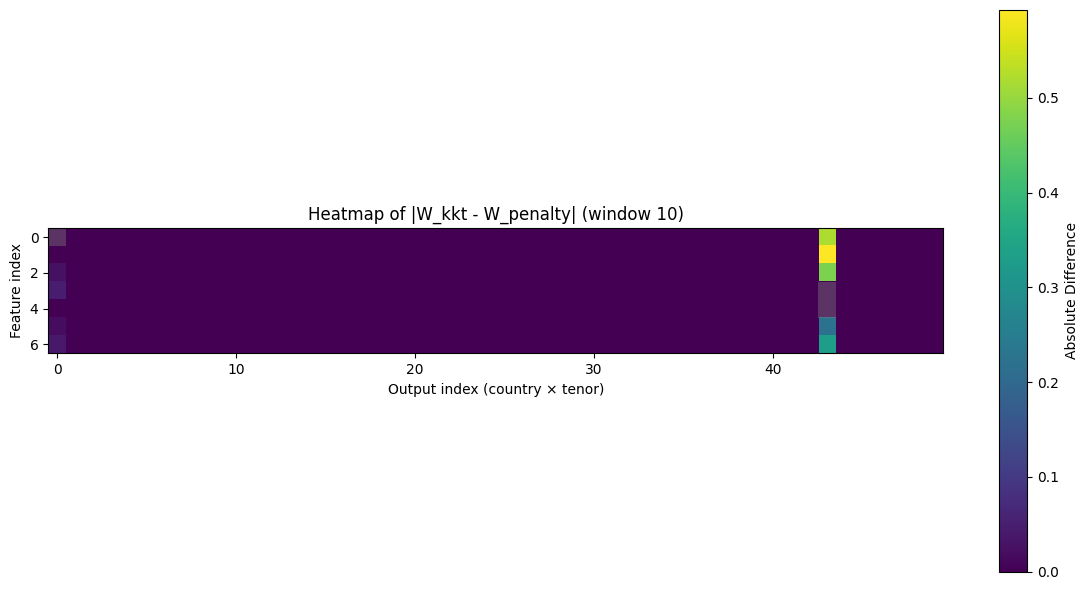

In [72]:
plot_diff_heatmap(W_kkt, W_penalty, mask1, mask2, window_idx=10)

In [70]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

def plot_diff_heatmap(W_kkt, W_penalty, mask_kkt, mask_penalty, window_idx=0):
    """
    Plots heatmap of the difference between W_kkt and W_penalty with shading
    where both methods masked (i.e., zeroed) the same coefficient.
    """
    W_diff = jnp.abs(W_kkt - W_penalty)
    mask_overlap = jnp.logical_and(mask_kkt, mask_penalty)

    # Select a time slice
    diff_window = W_diff[window_idx]
    mask_window = mask_overlap[window_idx]

    # Convert to numpy
    diff_np = np.array(diff_window)
    mask_np = np.array(mask_window)

    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(diff_np, cmap="viridis")

    # Shade where both masks are true
    for i in range(diff_np.shape[0]):
        for j in range(diff_np.shape[1]):
            if mask_np[i, j]:
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                           facecolor='gray', alpha=0.4, edgecolor=None))

    ax.set_title(f"Heatmap of |W_kkt - W_penalty| (window {window_idx})")
    ax.set_xlabel("Output index (country × tenor)")
    ax.set_ylabel("Feature index")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Absolute Difference")

    plt.tight_layout()
    plt.show()

In [74]:

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns


@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX, XtY)


@jax.jit
def penalized_ols(X_win, Y_win, penalty_mat):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

    def solve_per_output(XtY_col, penalties_col):
        XtX_penalized = XtX + jnp.diag(penalties_col)
        return jnp.linalg.solve(XtX_penalized, XtY_col)

    W_cols = jax.vmap(solve_per_output, in_axes=(1, 1))(XtY, penalty_mat)
    return W_cols.T  # (7, n_outputs)


@jax.jit
def kkt_kernel(X_win, Y_win, freeze_mask):
    n, d = X_win.shape
    _, m = Y_win.shape
    F = jnp.logical_not(freeze_mask)
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

    def solve_for_column(XtY_col, F_col):
        F_idx = jnp.where(F_col)[0]
        XtX_ff = XtX[jnp.ix_(F_idx, F_idx)]
        XtY_f = XtY_col[F_idx]
        w_f = jnp.linalg.solve(XtX_ff, XtY_f)
        w_full = jnp.zeros_like(F_col, dtype=jnp.float32).at[F_idx].set(w_f)
        return w_full

    return jax.vmap(solve_for_column, in_axes=(1, 1), out_axes=1)(XtY, F)


def make_sliding_regression_with_constraint_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None,
    method="penalty", freeze_non_masked=False
):
    @jax.jit
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]
        assert d_features == 7, "X must have 7 features"
        assert n_countries * n_tenors == n_outputs, "n_countries * n_tenors must equal Y.shape[1]"

        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, 7, n_outputs)

        if group_by_country:
            W_reshaped = W_ols.reshape((n_windows, 7, n_countries, n_tenors))
            if group_trigger_mode == "forced":
                if forced_group_mask is None:
                    raise ValueError("forced_group_mask must be provided when using 'forced'")
                group_mask_broadcast = jnp.broadcast_to(
                    forced_group_mask[None, :, :, :], (n_windows, n_countries, n_tenors, 7)
                ).transpose(0, 3, 1, 2)  # (n_windows, 7, n_countries, n_tenors)
            else:
                raise ValueError("Only 'forced' group trigger supported.")
            mask_final = group_mask_broadcast.reshape(n_windows, 7, n_countries * n_tenors)
        else:
            threshold = jnp.abs(W_ols) < epsilon
            mask_final = threshold

        if method == "penalty":
            penalty_mask = jnp.where(mask_final, big_penalty, 0.0)
            W_final = jax.vmap(penalized_ols)(X_wins, Y_wins, penalty_mask)
        elif method == "kkt":
            W_final = jax.vmap(kkt_kernel, in_axes=(0, 0, 0))(X_wins, Y_wins, mask_final)
        else:
            raise ValueError(f"Unsupported method: {method}")

        # === Compute R² ===
        def compute_r2(X_w, Y_w, W):
            Y_pred = jnp.einsum('wij,wjk->wik', X_w, W)  # (n_windows, t1, n_outputs)
            resid_sq = jnp.sum((Y_w - Y_pred) ** 2, axis=1)
            y_mean = jnp.mean(Y_w, axis=1, keepdims=True)
            total_sq = jnp.sum((Y_w - y_mean) ** 2, axis=1)
            return 1.0 - resid_sq / total_sq

        r2_ols = compute_r2(X_wins, Y_wins, W_ols)
        r2_final = compute_r2(X_wins, Y_wins, W_final)

        return W_ols, W_final, r2_ols, r2_final, mask_final

    return _sliding


def show_diff_heatmap(W1, W2, mask, title="Difference Heatmap"):
    diff = jnp.abs(W1 - W2).mean(axis=0)
    diff_matrix = diff.reshape(7, -1)
    mask_matrix = mask[0].T  # (n_outputs, 7)

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(diff_matrix.T, cmap="coolwarm", cbar=True, annot=True, fmt=".2f")
    ax.set_title(title)
    for i in range(mask_matrix.shape[0]):
        for j in range(mask_matrix.shape[1]):
            if mask_matrix[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5))
    plt.xlabel("Output index")
    plt.ylabel("Feature index")
    plt.show()


In [91]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

# Sliding window OLS
@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
    return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(XtX.shape[0]), XtY)

# Factory for sliding regression with constraints
def make_sliding_regression_with_constraint_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None,
    method="penalty", freeze_non_masked=False
):
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        X_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(X, (s, 0), (t1, d_features)))(starts)
        Y_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(Y, (s, 0), (t1, n_targets)))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)

        if forced_group_mask is not None:
            mask = jnp.broadcast_to(forced_group_mask[None, :, :, :], (n_windows, *forced_group_mask.shape))
            mask = mask.transpose(0, 3, 1, 2).reshape(n_windows, d_features, n_countries * n_tenors)
        else:
            mask = jnp.abs(W_ols) < epsilon

        penalty = jnp.where(mask, big_penalty, 0.0)

        def penalized(X_win, Y_win, p):
            XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
            XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
            return jnp.linalg.solve(XtX + jnp.diag(p), XtY)

        @jax.jit
        def kkt_solve_static(XtX, XtY_col, freeze_mask_col, max_frozen):
            d = XtX.shape[0]

            # Get frozen indices and pad them
            frozen_indices = jnp.where(freeze_mask_col, size=max_frozen, fill_value=0)[0] # Specify size
            num_actual_frozen = jnp.sum(freeze_mask_col)

            # Build A and b for constraints A w = b (where b is zeros)
            # Pad A and b to max_frozen size
            A = jnp.zeros((max_frozen, d), dtype=XtX.dtype)
            # Scatter 1s into A at frozen indices, only up to actual number of frozen
            scatter_indices = frozen_indices
            scatter_updates = jnp.ones(max_frozen, dtype=XtX.dtype)
            A = A.at[jnp.arange(max_frozen), scatter_indices].set(scatter_updates)

            b = jnp.zeros(max_frozen, dtype=XtY_col.dtype)

            # Solve the KKT system for this target
            KKT_mat = jnp.block([
                [XtX, A.T],
                [A, jnp.zeros((max_frozen, max_frozen), dtype=XtX.dtype)]
            ])
            rhs = jnp.concatenate([XtY_col, b])

            # Mask out terms corresponding to padded constraints
            constraint_mask_full = jnp.arange(max_frozen) >= num_actual_frozen
            mask_kkt_rows = jnp.concatenate([jnp.zeros(d, dtype=bool), constraint_mask_full])
            mask_kkt_cols = jnp.concatenate([jnp.zeros(d, dtype=bool), constraint_mask_full])

            # Solve the (potentially masked) KKT system
            # A simple approach is to add a large value to the diagonal of the masked rows/cols
            KKT_masked = KKT_mat + jnp.diag(mask_kkt_rows.astype(KKT_mat.dtype) * 1e10) + jnp.diag(mask_kkt_cols.astype(KKT_mat.dtype) * 1e10)


            sol_padded = jnp.linalg.solve(KKT_mat, rhs) # Solve the padded system
            sol = sol_padded[:d] # Extract the weights

            # Explicitly set the frozen weights to zero after solving
            sol = jnp.where(freeze_mask_col, 0.0, sol)

            return sol

        # Determine the maximum number of frozen features across all window and output combinations
        # This needs to be done statically outside the main vmap if possible, or accept it as an arg
        # For now, let's assume a conservative upper bound (d_features) or calculate it outside _sliding
        # As a workaround for the example, let's calculate it over the first window's mask
        # This is not fully general for arbitrary masks but works for the forced_group_mask example
        # A better approach is to calculate max_frozen across the entire mask tensor
        max_frozen = jnp.max(jnp.sum(mask, axis=1)) # Max frozen features per output across windows


        def kkt(X_win, Y_win, freeze_mask):
           XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
           XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

           # Vmap solve_col over the columns of Y_win and freeze_mask
           return jax.vmap(lambda Y_col, fm_col: kkt_solve_static(XtX, Y_col, fm_col, max_frozen), in_axes=(1, 1), out_axes=1)(XtY, freeze_mask)


        W_final = jax.vmap(penalized if method == "penalty" else kkt)(X_wins, Y_wins, penalty if method == "penalty" else mask)
        return W_ols, W_final, mask

    return _sliding

# === Example Usage ===
key = jax.random.PRNGKey(0)
n_samples, n_features = 100, 7
n_countries, n_tenors = 5, 10
n_targets = n_countries * n_tenors

X = jax.random.normal(key, (n_samples, n_features))
Y = jax.random.normal(key, (n_samples, n_targets))

forced_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)
# Example: Freeze feature 2 for output (0, 0) and features 4, 5 for output (1, 1)
forced_mask = forced_mask.at[0, 0, 2].set(True)
forced_mask = forced_mask.at[1, 1, 4].set(True)
forced_mask = forced_mask.at[1, 1, 5].set(True)


t1, t2 = 20, 5

pen_fn = make_sliding_regression_with_constraint_fn(
    t1, t2, big_penalty=1e6,
    group_by_country=True,
    n_countries=n_countries, n_tenors=n_tenors,
    forced_group_mask=forced_mask,
    method="penalty"
)

kkt_fn = make_sliding_regression_with_constraint_fn(
    t1, t2, big_penalty=1e6,
    group_by_country=True,
    n_countries=n_countries, n_tenors=n_tenors,
    forced_group_mask=forced_mask,
    method="kkt"
)

W_ols_pen, W_pen, mask = pen_fn(X, Y)
W_ols_kkt, W_kkt, _ = kkt_fn(X, Y)

# === Heatmap Comparison ===
diff = jnp.abs(W_pen - W_kkt).mean(axis=0)
masked = mask[0]

plt.figure(figsize=(12, 5))
sns.heatmap(diff.T, cmap="coolwarm", center=0, cbar=True)

# Mark masked zero targets
for i in range(masked.shape[1]):
    for j in range(masked.shape[0]):
        if masked[j, i]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5))

plt.title("Mean Abs Diff (Penalty vs KKT) with Forced Zeros Highlighted")
plt.xlabel("Features")
plt.ylabel("Targets")
plt.tight_layout()
plt.show()

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[]
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.
The error occurred while tracing the function kkt_solve_static at /tmp/ipython-input-1591918486.py:44 for jit. This concrete value was not available in Python because it depends on the value of the argument max_frozen.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

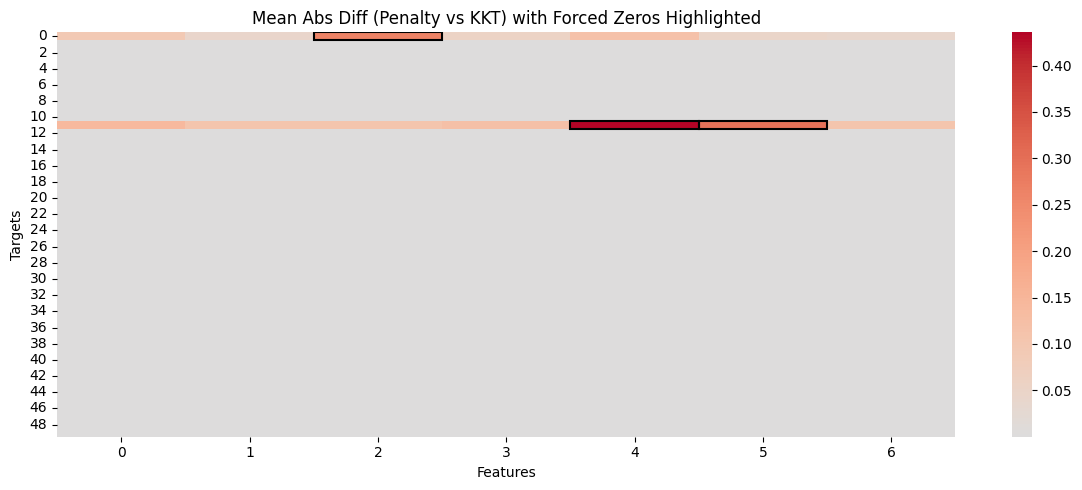

In [93]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

# Sliding window OLS
@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
    return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(XtX.shape[0]), XtY)

# Factory for sliding regression with constraints
def make_sliding_regression_with_constraint_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None,
    method="penalty", freeze_non_masked=False, max_frozen=None
):
    # Pre-compute max_frozen if not provided
    if method == "kkt":
        if max_frozen is None:
            if forced_group_mask is not None:
                # Calculate the maximum number of frozen features across all outputs
                max_frozen = int(jnp.max(jnp.sum(forced_group_mask, axis=-1)))
            else:
                # If using dynamic masking, we need to provide an upper bound
                # In worst case, all features could be frozen
                max_frozen = 7  # n_features - you might want to pass this as a parameter

    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        X_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(X, (s, 0), (t1, d_features)))(starts)
        Y_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(Y, (s, 0), (t1, n_targets)))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)

        if forced_group_mask is not None:
            mask = jnp.broadcast_to(forced_group_mask[None, :, :, :], (n_windows, *forced_group_mask.shape))
            mask = mask.transpose(0, 3, 1, 2).reshape(n_windows, d_features, n_countries * n_tenors)
        else:
            mask = jnp.abs(W_ols) < epsilon

        penalty = jnp.where(mask, big_penalty, 0.0)

        def penalized(X_win, Y_win, p):
            XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
            XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
            return jnp.linalg.solve(XtX + jnp.diag(p), XtY)

        # Create different KKT solvers for different max_frozen values
        # This is a workaround to make max_frozen static
        def make_kkt_solve_static(max_frozen_value):
            def kkt_solve_static(XtX, XtY_col, freeze_mask_col):
                d = XtX.shape[0]

                # Handle the case where nothing is frozen
                num_frozen = jnp.sum(freeze_mask_col)

                def solve_with_constraints():
                    # Get indices of frozen features
                    indices = jnp.arange(d)
                    frozen_flags = freeze_mask_col

                    # Build constraint matrix using a different approach
                    # We'll use a scatter operation that doesn't require dynamic size
                    A = jnp.zeros((max_frozen_value, d), dtype=XtX.dtype)

                    # Create a cumulative sum to assign each frozen feature to a row
                    frozen_cumsum = jnp.cumsum(frozen_flags) - 1
                    row_indices = jnp.where(frozen_flags, frozen_cumsum, max_frozen_value)

                    # Scatter 1s into A matrix
                    for i in range(d):
                        row_idx = row_indices[i]
                        A = A.at[row_idx, i].set(
                            jnp.where(row_idx < max_frozen_value, frozen_flags[i].astype(A.dtype), 0.0)
                        )

                    b = jnp.zeros(max_frozen_value, dtype=XtY_col.dtype)

                    # Build KKT system
                    KKT_mat = jnp.block([
                        [XtX, A.T],
                        [A, jnp.zeros((max_frozen_value, max_frozen_value), dtype=XtX.dtype)]
                    ])
                    rhs = jnp.concatenate([XtY_col, b])

                    # Add regularization to unused constraint rows
                    constraint_mask = jnp.arange(max_frozen_value) >= num_frozen
                    diag_mask = jnp.concatenate([jnp.zeros(d, dtype=bool), constraint_mask])
                    KKT_regularized = KKT_mat + jnp.diag(diag_mask.astype(KKT_mat.dtype) * 1e10)

                    sol_full = jnp.linalg.solve(KKT_regularized, rhs)
                    sol = sol_full[:d]

                    # Explicitly zero out frozen weights
                    return jnp.where(freeze_mask_col, 0.0, sol)

                def solve_without_constraints():
                    # Standard OLS when no constraints
                    return jnp.linalg.solve(XtX, XtY_col)

                # Use conditional to handle case with no frozen features
                return jax.lax.cond(
                    num_frozen > 0,
                    solve_with_constraints,
                    solve_without_constraints
                )

            return jax.jit(kkt_solve_static)

        def kkt(X_win, Y_win, freeze_mask):
            XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
            XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

            # Create the KKT solver with the static max_frozen value
            kkt_solver = make_kkt_solve_static(max_frozen)

            # Vmap over columns
            return jax.vmap(
                kkt_solver,
                in_axes=(None, 1, 1),
                out_axes=1
            )(XtX, XtY, freeze_mask)

        if method == "penalty":
            W_final = jax.vmap(penalized)(X_wins, Y_wins, penalty)
        else:
            W_final = jax.vmap(kkt)(X_wins, Y_wins, mask)

        return W_ols, W_final, mask

    return _sliding

# === Example Usage ===
key = jax.random.PRNGKey(0)
n_samples, n_features = 100, 7
n_countries, n_tenors = 5, 10
n_targets = n_countries * n_tenors

X = jax.random.normal(key, (n_samples, n_features))
Y = jax.random.normal(key, (n_samples, n_targets))

forced_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)
# Example: Freeze feature 2 for output (0, 0) and features 4, 5 for output (1, 1)
forced_mask = forced_mask.at[0, 0, 2].set(True)
forced_mask = forced_mask.at[1, 1, 4].set(True)
forced_mask = forced_mask.at[1, 1, 5].set(True)

# Calculate max_frozen from the forced mask
max_frozen_value = int(jnp.max(jnp.sum(forced_mask, axis=-1)))

t1, t2 = 20, 5

pen_fn = make_sliding_regression_with_constraint_fn(
    t1, t2, big_penalty=1e6,
    group_by_country=True,
    n_countries=n_countries, n_tenors=n_tenors,
    forced_group_mask=forced_mask,
    method="penalty"
)

kkt_fn = make_sliding_regression_with_constraint_fn(
    t1, t2, big_penalty=1e6,
    group_by_country=True,
    n_countries=n_countries, n_tenors=n_tenors,
    forced_group_mask=forced_mask,
    method="kkt",
    max_frozen=max_frozen_value  # Pass the concrete value
)

W_ols_pen, W_pen, mask = pen_fn(X, Y)
W_ols_kkt, W_kkt, _ = kkt_fn(X, Y)

# === Heatmap Comparison ===
diff = jnp.abs(W_pen - W_kkt).mean(axis=0)
masked = mask[0]

plt.figure(figsize=(12, 5))
sns.heatmap(diff.T, cmap="coolwarm", center=0, cbar=True)

# Mark masked zero targets
for i in range(masked.shape[1]):
    for j in range(masked.shape[0]):
        if masked[j, i]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5))

plt.title("Mean Abs Diff (Penalty vs KKT) with Forced Zeros Highlighted")
plt.xlabel("Features")
plt.ylabel("Targets")
plt.tight_layout()
plt.show()

Running enhanced sliding regression...

Results:
Number of windows: 17
Sparsity: 0.9% of coefficients zeroed
Max condition number: 7.44e+00
Number of constraint violations: 51
Max violation magnitude: 4.52e-02


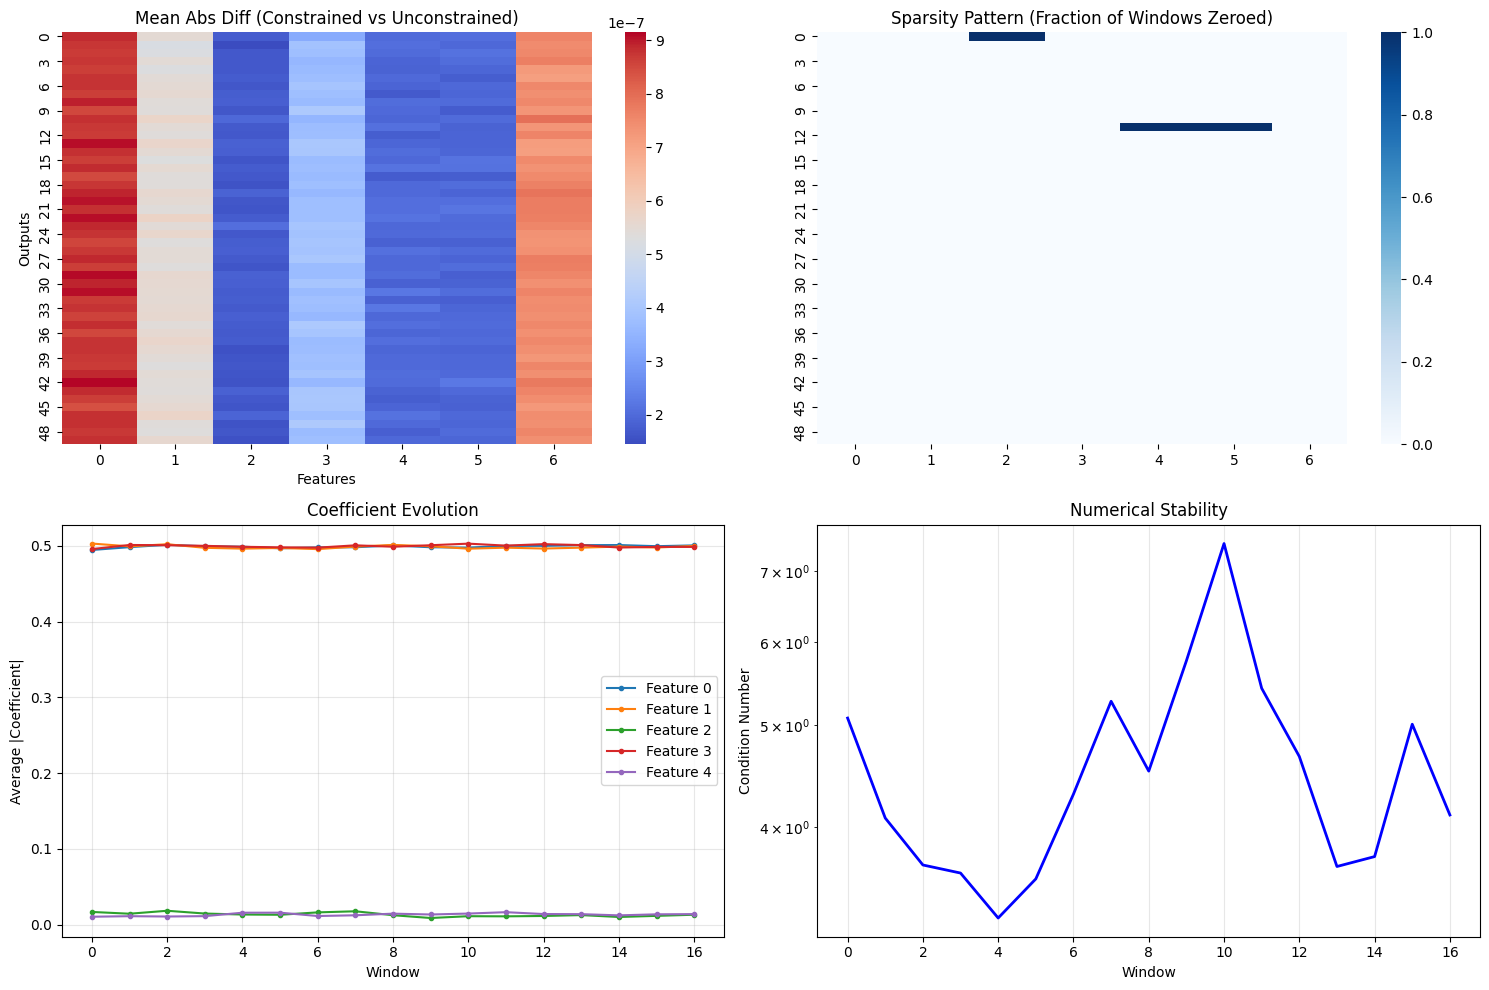


Testing warm start version...
Warm start shape: (17, 7, 50)


In [97]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

# Basic OLS kernel
@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
    reg = 1e-6 * jnp.eye(XtX.shape[0])
    return jnp.linalg.solve(XtX + reg, XtY)

# Cholesky version for numerical stability
@jax.jit
def ols_kernel_cholesky(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

    # Adaptive regularization
    reg = 1e-6 * jnp.maximum(1.0, jnp.trace(XtX) / XtX.shape[0])
    XtX_reg = XtX + reg * jnp.eye(XtX.shape[0])

    L = jnp.linalg.cholesky(XtX_reg)
    z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
    return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)

# Simple adaptive threshold functions
@jax.jit
def compute_mad_threshold(W, k=2.0):
    """MAD-based adaptive threshold"""
    W_flat = jnp.abs(W).ravel()
    median = jnp.median(W_flat)
    mad = jnp.median(jnp.abs(W_flat - median))
    # 1.4826 converts MAD to std for normal distribution
    return k * mad * 1.4826

@jax.jit
def compute_std_threshold(W, k=2.0):
    """Standard deviation based threshold"""
    return k * jnp.std(jnp.abs(W))

# Enhanced factory function (simplified)
def make_sliding_regression_enhanced(
    t1, t2,
    epsilon=1e-3,
    big_penalty=1e6,
    forced_group_mask=None,
    n_countries=None,
    n_tenors=None,
    use_cholesky=True,
    use_adaptive_threshold=True,
    threshold_k=2.0,
    compute_diagnostics=False
):
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        # Extract windows efficiently
        X_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(X, (s, 0), (t1, d_features)))(starts)
        Y_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(Y, (s, 0), (t1, n_targets)))(starts)

        # Compute OLS solutions
        solver = ols_kernel_cholesky if use_cholesky else ols_kernel
        W_ols = jax.vmap(solver)(X_wins, Y_wins)

        # Compute mask
        if forced_group_mask is not None:
            # Use provided mask
            mask = jnp.broadcast_to(
                forced_group_mask[None, :, :, :],
                (n_windows, *forced_group_mask.shape)
            )
            mask = mask.transpose(0, 3, 1, 2).reshape(n_windows, d_features, n_targets)
        else:
            # Adaptive thresholding
            if use_adaptive_threshold:
                # Compute threshold for each window
                thresholds = jax.vmap(lambda W: compute_mad_threshold(W, threshold_k))(W_ols)
                mask = jnp.abs(W_ols) < thresholds[:, None, None]
            else:
                mask = jnp.abs(W_ols) < epsilon

        # Apply penalty method
        penalty = jnp.where(mask, big_penalty, 0.0)

        @jax.jit
        def penalized_solve(X_win, Y_win, p):
            XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
            XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
            XtX_pen = XtX + jnp.diag(p)

            if use_cholesky:
                L = jnp.linalg.cholesky(XtX_pen)
                z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
                return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)
            else:
                return jnp.linalg.solve(XtX_pen, XtY)

        W_final = jax.vmap(penalized_solve)(X_wins, Y_wins, penalty)

        # Compute diagnostics
        diagnostics = {}
        if compute_diagnostics:
            # Basic statistics
            diagnostics['mean'] = jnp.mean(W_final, axis=0)
            diagnostics['std'] = jnp.std(W_final, axis=0)
            diagnostics['cv'] = diagnostics['std'] / (jnp.abs(diagnostics['mean']) + 1e-8)

            # Constraint violations
            violations = jnp.where(mask, jnp.abs(W_final), 0.0)
            diagnostics['max_violation'] = jnp.max(violations)
            diagnostics['num_violations'] = jnp.sum(violations > 1e-6)

            # Condition numbers
            diagnostics['condition_numbers'] = jax.vmap(
                lambda X: jnp.linalg.cond(X.T @ X)
            )(X_wins)

        return W_ols, W_final, mask, diagnostics

    return _sliding

# Warm start implementation using scan
def make_sliding_regression_warmstart(
    t1, t2,
    momentum=0.9,
    use_cholesky=True,
    **kwargs
):
    """Sliding regression with warm start"""
    def _sliding_warmstart(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1

        solver = ols_kernel_cholesky if use_cholesky else ols_kernel

        def scan_fn(W_prev, idx):
            start = idx * t2
            X_win = jax.lax.dynamic_slice(X, (start, 0), (t1, d_features))
            Y_win = jax.lax.dynamic_slice(Y, (start, 0), (t1, n_targets))

            W_new = solver(X_win, Y_win)
            W_combined = momentum * W_prev + (1 - momentum) * W_new

            return W_combined, W_combined

        W_init = jnp.zeros((d_features, n_targets))
        _, W_history = jax.lax.scan(scan_fn, W_init, jnp.arange(n_windows))

        return W_history

    return _sliding_warmstart

# Visualization helper
def plot_results(W_ols, W_final, mask, diagnostics=None):
    """Visualize regression results"""
    n_windows = W_ols.shape[0]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Coefficient heatmap
    ax = axes[0, 0]
    diff = jnp.abs(W_final - W_ols).mean(axis=0)
    sns.heatmap(diff.T, cmap='coolwarm', ax=ax, cbar=True)
    ax.set_title('Mean Abs Diff (Constrained vs Unconstrained)')
    ax.set_xlabel('Features')
    ax.set_ylabel('Outputs')

    # 2. Sparsity pattern
    ax = axes[0, 1]
    sparsity = mask.mean(axis=0)
    sns.heatmap(sparsity.T, cmap='Blues', ax=ax, cbar=True, vmin=0, vmax=1)
    ax.set_title('Sparsity Pattern (Fraction of Windows Zeroed)')

    # 3. Coefficient evolution
    ax = axes[1, 0]
    W_avg = jnp.mean(jnp.abs(W_final), axis=2)
    for i in range(min(5, W_avg.shape[1])):
        ax.plot(W_avg[:, i], label=f'Feature {i}', marker='o', markersize=3)
    ax.set_xlabel('Window')
    ax.set_ylabel('Average |Coefficient|')
    ax.set_title('Coefficient Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Diagnostics
    ax = axes[1, 1]
    if diagnostics and 'condition_numbers' in diagnostics:
        ax.plot(diagnostics['condition_numbers'], 'b-', linewidth=2)
        ax.set_xlabel('Window')
        ax.set_ylabel('Condition Number')
        ax.set_title('Numerical Stability')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Example usage
if __name__ == "__main__":
    # Generate test data
    key = jax.random.PRNGKey(42)
    n_samples, n_features = 200, 7
    n_countries, n_tenors = 5, 10
    n_targets = n_countries * n_tenors

    # Generate data
    X = jax.random.normal(key, (n_samples, n_features))
    true_coef = jnp.ones((n_features, n_targets)) * 0.5
    # Make some coefficients zero
    true_coef = true_coef.at[2, :].set(0.0)
    true_coef = true_coef.at[4:6, :].set(0.0)

    noise = 0.1 * jax.random.normal(key, (n_samples, n_targets))
    Y = X @ true_coef + noise

    # Create forced mask
    forced_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)
    forced_mask = forced_mask.at[0, 0, 2].set(True)
    forced_mask = forced_mask.at[1, 1, 4:6].set(True)

    # Run enhanced sliding regression
    print("Running enhanced sliding regression...")
    t1, t2 = 40, 10

    regression_fn = make_sliding_regression_enhanced(
        t1, t2,
        forced_group_mask=forced_mask,
        n_countries=n_countries,
        n_tenors=n_tenors,
        use_cholesky=True,
        use_adaptive_threshold=True,
        threshold_k=2.0,
        compute_diagnostics=True
    )

    W_ols, W_final, mask, diagnostics = regression_fn(X, Y)

    # Print summary
    print(f"\nResults:")
    print(f"Number of windows: {W_ols.shape[0]}")
    print(f"Sparsity: {100 * mask.mean():.1f}% of coefficients zeroed")
    if diagnostics:
        print(f"Max condition number: {jnp.max(diagnostics['condition_numbers']):.2e}")
        print(f"Number of constraint violations: {diagnostics['num_violations']}")
        print(f"Max violation magnitude: {diagnostics['max_violation']:.2e}")

    # Visualize
    plot_results(W_ols, W_final, mask, diagnostics)
    plt.show()

    # Test warm start version
    print("\nTesting warm start version...")
    warmstart_fn = make_sliding_regression_warmstart(
        t1, t2,
        momentum=0.95,
        use_cholesky=True
    )

    W_warmstart = warmstart_fn(X, Y)
    print(f"Warm start shape: {W_warmstart.shape}")

Running enhanced sliding regression...

Results:
Number of windows: 17
Sparsity: 0.9% of coefficients zeroed
Max condition number: 7.44e+00
Number of constraint violations: 51
Max violation magnitude: 4.52e-02


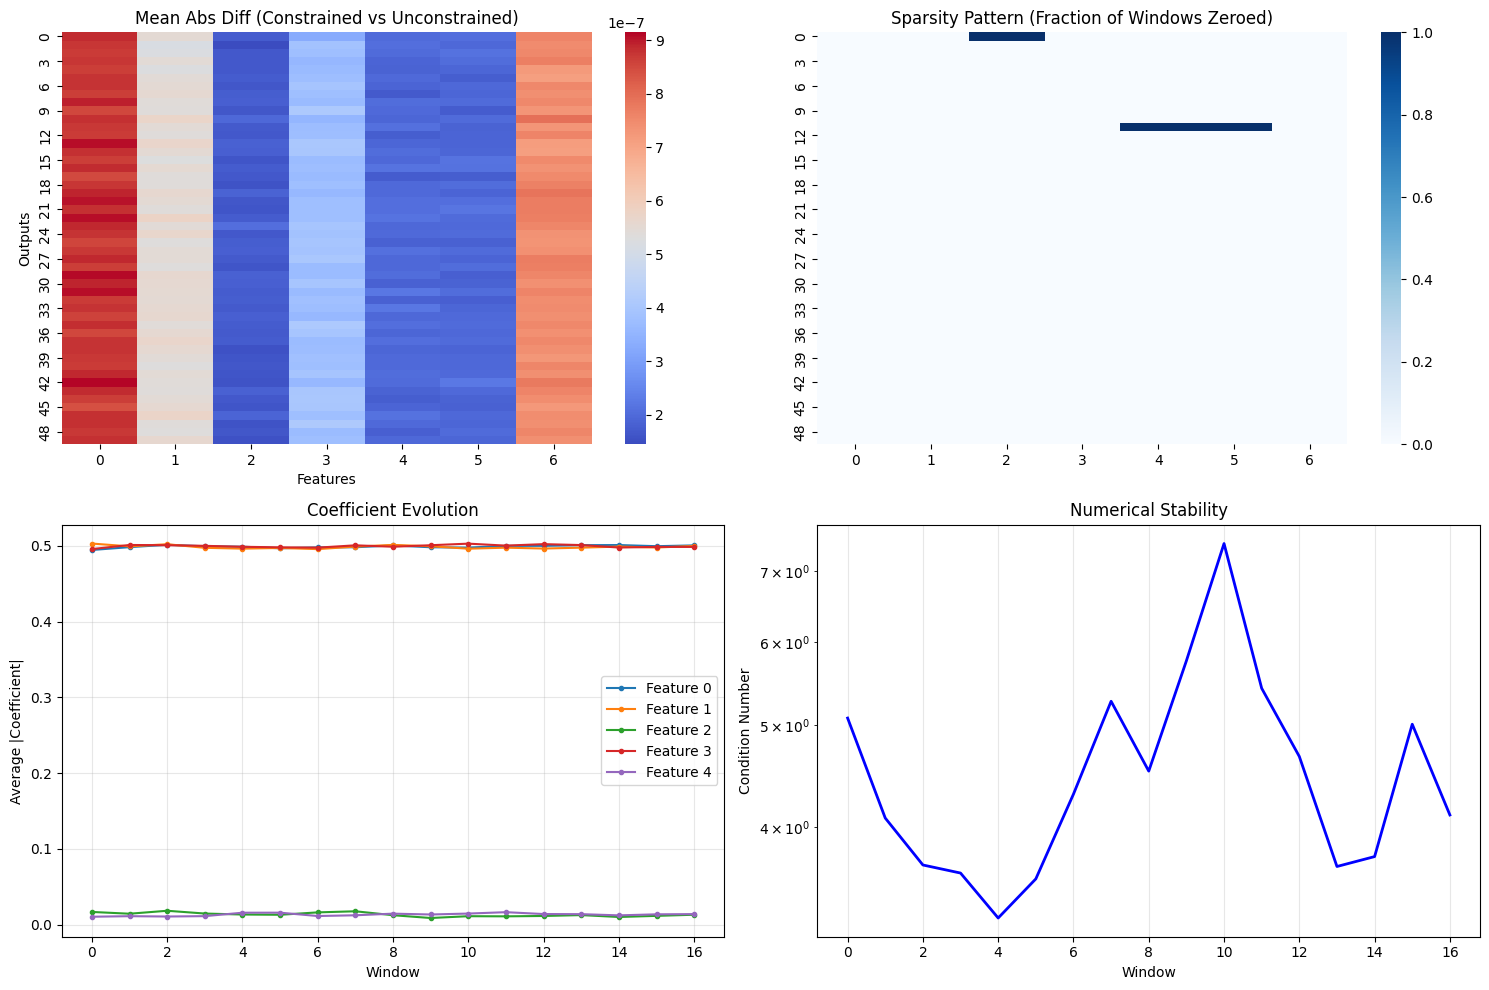


Testing KKT method for exact zero constraints...
KKT method - Max violation: 0.00e+00
KKT method - Coefficients exactly zero: 51

Testing equality constraints...

Constraint verification:
Feature 0 and 1 equal for output 0: False
Feature 3 and 4 opposite for output 1: False
Features 0,1,2 sum to zero for output 2: False

Comparing Penalty vs KKT methods...


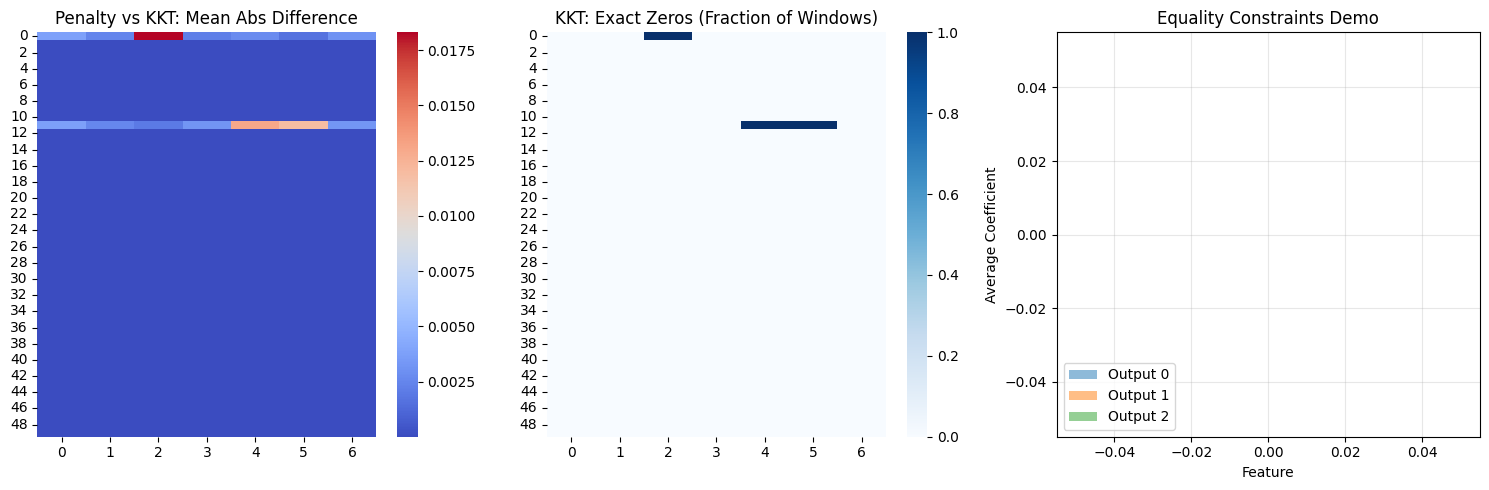

In [98]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

# Basic OLS kernel
@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)b
    reg = 1e-6 * jnp.eye(XtX.shape[0])
    return jnp.linalg.solve(XtX + reg, XtY)

# Cholesky version for numerical stability
@jax.jit
def ols_kernel_cholesky(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)b

    # Adaptive regularization
    reg = 1e-6 * jnp.maximum(1.0, jnp.trace(XtX) / XtX.shape[0])
    XtX_reg = XtX + reg * jnp.eye(XtX.shape[0])

    L = jnp.linalg.cholesky(XtX_reg)
    z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
    return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)

# Simple adaptive threshold functions
@jax.jit
def compute_mad_threshold(W, k=2.0):
    """MAD-based adaptive threshold"""
    W_flat = jnp.abs(W).ravel()
    median = jnp.median(W_flat)
    mad = jnp.median(jnp.abs(W_flat - median))
    # 1.4826 converts MAD to std for normal distribution
    return k * mad * 1.4826

@jax.jit
def compute_std_threshold(W, k=2.0):
    """Standard deviation based threshold"""
    return k * jnp.std(jnp.abs(W))

# KKT solver for exact constraints
def make_kkt_solver(max_frozen):
    """Create a KKT solver with fixed max_frozen parameter"""
    @jax.jit
    def kkt_solve_single(XtX, XtY_col, freeze_mask_col):
        d = XtX.shape[0]
        num_frozen = jnp.sum(freeze_mask_col)

        def solve_with_constraints():
            # Build constraint matrix A
            A = jnp.zeros((max_frozen, d), dtype=XtX.dtype)

            # Use cumulative sum to assign frozen features to rows
            frozen_cumsum = jnp.cumsum(freeze_mask_col) - 1
            row_indices = jnp.where(freeze_mask_col, frozen_cumsum, max_frozen)

            # Scatter 1s into A
            for i in range(d):
                row_idx = row_indices[i]
                A = A.at[row_idx, i].set(
                    jnp.where(row_idx < max_frozen, freeze_mask_col[i].astype(A.dtype), 0.0)
                )

            b = jnp.zeros(max_frozen, dtype=XtY_col.dtype)

            # Build KKT system
            KKT_mat = jnp.block([
                [XtX, A.T],
                [A, jnp.zeros((max_frozen, max_frozen), dtype=XtX.dtype)]
            ])
            rhs = jnp.concatenate([XtY_col, b])

            # Regularize unused constraint rows
            constraint_mask = jnp.arange(max_frozen) >= num_frozen
            diag_mask = jnp.concatenate([jnp.zeros(d, dtype=bool), constraint_mask])
            KKT_regularized = KKT_mat + jnp.diag(diag_mask.astype(KKT_mat.dtype) * 1e10)

            sol_full = jnp.linalg.solve(KKT_regularized, rhs)
            sol = sol_full[:d]

            # Explicitly zero out frozen weights
            return jnp.where(freeze_mask_col, 0.0, sol)

        def solve_without_constraints():
            return jnp.linalg.solve(XtX, XtY_col)

        return jax.lax.cond(
            num_frozen > 0,
            solve_with_constraints,
            solve_without_constraints
        )

    return kkt_solve_single

# Enhanced factory function with both penalty and KKT methods
def make_sliding_regression_enhanced(
    t1, t2,
    epsilon=1e-3,
    big_penalty=1e6,
    forced_group_mask=None,
    n_countries=None,
    n_tenors=None,
    method="penalty",  # "penalty" or "kkt"
    max_frozen=None,
    use_cholesky=True,
    use_adaptive_threshold=True,
    threshold_k=2.0,
    compute_diagnostics=False,
    equality_constraints=None  # New: for setting coefficients equal/opposite
):
    # Pre-compute max_frozen if using KKT
    if method == "kkt" and max_frozen is None:
        if forced_group_mask is not None:
            max_frozen = int(jnp.max(jnp.sum(forced_group_mask, axis=-1)))
        else:
            max_frozen = 7  # Default to n_features or specify

    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        # Extract windows efficiently
        X_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(X, (s, 0), (t1, d_features)))(starts)
        Y_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(Y, (s, 0), (t1, n_targets)))(starts)

        # Compute OLS solutions
        solver = ols_kernel_cholesky if use_cholesky else ols_kernel
        W_ols = jax.vmap(solver)(X_wins, Y_wins)

        # Compute mask
        if forced_group_mask is not None:
            # Use provided mask
            mask = jnp.broadcast_to(
                forced_group_mask[None, :, :, :],
                (n_windows, *forced_group_mask.shape)
            )
            mask = mask.transpose(0, 3, 1, 2).reshape(n_windows, d_features, n_targets)
        else:
            # Adaptive thresholding
            if use_adaptive_threshold:
                # Compute threshold for each window
                thresholds = jax.vmap(lambda W: compute_mad_threshold(W, threshold_k))(W_ols)
                mask = jnp.abs(W_ols) < thresholds[:, None, None]
            else:
                mask = jnp.abs(W_ols) < epsilon

        # Apply constraints based on method
        if method == "penalty":
            # Penalty method
            penalty = jnp.where(mask, big_penalty, 0.0)

            @jax.jit
            def penalized_solve(X_win, Y_win, p):
                XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
                XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
                XtX_pen = XtX + jnp.diag(p)

                if use_cholesky:
                    L = jnp.linalg.cholesky(XtX_pen)
                    z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
                    return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)
                else:
                    return jnp.linalg.solve(XtX_pen, XtY)

            W_final = jax.vmap(penalized_solve)(X_wins, Y_wins, penalty)

        else:  # method == "kkt"
            # KKT method for exact constraints
            kkt_solver = make_kkt_solver(max_frozen)

            def kkt_solve_window(X_win, Y_win, freeze_mask):
                XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
                XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

                # Apply KKT solver to each output
                return jax.vmap(
                    lambda Y_col, fm_col: kkt_solver(XtX, Y_col, fm_col),
                    in_axes=(1, 1),
                    out_axes=1
                )(XtY, freeze_mask)

            W_final = jax.vmap(kkt_solve_window)(X_wins, Y_wins, mask)

        # Apply equality constraints if specified
        if equality_constraints is not None:
            W_final = apply_equality_constraints(W_final, equality_constraints)

        # Compute diagnostics
        diagnostics = {}
        if compute_diagnostics:
            # Basic statistics
            diagnostics['mean'] = jnp.mean(W_final, axis=0)
            diagnostics['std'] = jnp.std(W_final, axis=0)
            diagnostics['cv'] = diagnostics['std'] / (jnp.abs(diagnostics['mean']) + 1e-8)

            # Constraint violations
            violations = jnp.where(mask, jnp.abs(W_final), 0.0)
            diagnostics['max_violation'] = jnp.max(violations)
            diagnostics['num_violations'] = jnp.sum(violations > 1e-6)

            # Condition numbers
            diagnostics['condition_numbers'] = jax.vmap(
                lambda X: jnp.linalg.cond(X.T @ X)
            )(X_wins)

        return W_ols, W_final, mask, diagnostics

    return _sliding

# Warm start implementation using scan
def make_sliding_regression_warmstart(
    t1, t2,
    momentum=0.9,
    use_cholesky=True,
    **kwargs
):
    """Sliding regression with warm start"""
    def _sliding_warmstart(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1

        solver = ols_kernel_cholesky if use_cholesky else ols_kernel

        def scan_fn(W_prev, idx):
            start = idx * t2
            X_win = jax.lax.dynamic_slice(X, (start, 0), (t1, d_features))
            Y_win = jax.lax.dynamic_slice(Y, (start, 0), (t1, n_targets))

            W_new = solver(X_win, Y_win)
            W_combined = momentum * W_prev + (1 - momentum) * W_new

            return W_combined, W_combined

        W_init = jnp.zeros((d_features, n_targets))
        _, W_history = jax.lax.scan(scan_fn, W_init, jnp.arange(n_windows))

        return W_history

    return _sliding_warmstart

# Visualization helper
def plot_results(W_ols, W_final, mask, diagnostics=None):
    """Visualize regression results"""
    n_windows = W_ols.shape[0]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Coefficient heatmap
    ax = axes[0, 0]
    diff = jnp.abs(W_final - W_ols).mean(axis=0)
    sns.heatmap(diff.T, cmap='coolwarm', ax=ax, cbar=True)
    ax.set_title('Mean Abs Diff (Constrained vs Unconstrained)')
    ax.set_xlabel('Features')
    ax.set_ylabel('Outputs')

    # 2. Sparsity pattern
    ax = axes[0, 1]
    sparsity = mask.mean(axis=0)
    sns.heatmap(sparsity.T, cmap='Blues', ax=ax, cbar=True, vmin=0, vmax=1)
    ax.set_title('Sparsity Pattern (Fraction of Windows Zeroed)')

    # 3. Coefficient evolution
    ax = axes[1, 0]
    W_avg = jnp.mean(jnp.abs(W_final), axis=2)
    for i in range(min(5, W_avg.shape[1])):
        ax.plot(W_avg[:, i], label=f'Feature {i}', marker='o', markersize=3)
    ax.set_xlabel('Window')
    ax.set_ylabel('Average |Coefficient|')
    ax.set_title('Coefficient Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Diagnostics
    ax = axes[1, 1]
    if diagnostics and 'condition_numbers' in diagnostics:
        ax.plot(diagnostics['condition_numbers'], 'b-', linewidth=2)
        ax.set_xlabel('Window')
        ax.set_ylabel('Condition Number')
        ax.set_title('Numerical Stability')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Apply equality constraints (e.g., make some coefficients equal or opposite)
def apply_equality_constraints(W, constraints):
    """
    Apply equality constraints to coefficients.

    constraints: list of tuples, each specifying a constraint:
        - ('equal', [(i1, j1), (i2, j2), ...]) : make these coefficients equal
        - ('opposite', [(i1, j1), (i2, j2)]) : make coef[i2,j2] = -coef[i1,j1]
        - ('sum_zero', [(i1, j1), (i2, j2), ...]) : make these coefficients sum to zero
    """
    W_constrained = W.copy()

    for constraint_type, indices in constraints:
        if constraint_type == 'equal':
            # Make all coefficients equal to the mean
            values = jnp.array([W[:, i, j] for i, j in indices])
            mean_value = jnp.mean(values, axis=0)
            for i, j in indices:
                W_constrained = W_constrained.at[:, i, j].set(mean_value)

        elif constraint_type == 'opposite':
            # Make second coefficient negative of first
            (i1, j1), (i2, j2) = indices
            W_constrained = W_constrained.at[:, i2, j2].set(-W[:, i1, j1])

        elif constraint_type == 'sum_zero':
            # Adjust coefficients to sum to zero
            values = jnp.array([W[:, i, j] for i, j in indices])
            mean_adjustment = jnp.mean(values, axis=0)
            for i, j in indices:
                W_constrained = W_constrained.at[:, i, j].add(-mean_adjustment)

    return W_constrained

# Example usage
if __name__ == "__main__":
    # Generate test data
    key = jax.random.PRNGKey(42)
    n_samples, n_features = 200, 7
    n_countries, n_tenors = 5, 10
    n_targets = n_countries * n_tenors

    # Generate data
    X = jax.random.normal(key, (n_samples, n_features))
    true_coef = jnp.ones((n_features, n_targets)) * 0.5
    # Make some coefficients zero
    true_coef = true_coef.at[2, :].set(0.0)
    true_coef = true_coef.at[4:6, :].set(0.0)

    noise = 0.1 * jax.random.normal(key, (n_samples, n_targets))
    Y = X @ true_coef + noise

    # Create forced mask
    forced_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)
    forced_mask = forced_mask.at[0, 0, 2].set(True)
    forced_mask = forced_mask.at[1, 1, 4:6].set(True)

    # Run enhanced sliding regression
    print("Running enhanced sliding regression...")
    t1, t2 = 40, 10

    regression_fn = make_sliding_regression_enhanced(
        t1, t2,
        forced_group_mask=forced_mask,
        n_countries=n_countries,
        n_tenors=n_tenors,
        use_cholesky=True,
        use_adaptive_threshold=True,
        threshold_k=2.0,
        compute_diagnostics=True
    )

    W_ols, W_final, mask, diagnostics = regression_fn(X, Y)

    # Print summary
    print(f"\nResults:")
    print(f"Number of windows: {W_ols.shape[0]}")
    print(f"Sparsity: {100 * mask.mean():.1f}% of coefficients zeroed")
    if diagnostics:
        print(f"Max condition number: {jnp.max(diagnostics['condition_numbers']):.2e}")
        print(f"Number of constraint violations: {diagnostics['num_violations']}")
        print(f"Max violation magnitude: {diagnostics['max_violation']:.2e}")

    # Visualize
    plot_results(W_ols, W_final, mask, diagnostics)
    plt.show()

    # Example 1: Test KKT method for exact zeros
    print("\n" + "="*50)
    print("Testing KKT method for exact zero constraints...")

    kkt_fn = make_sliding_regression_enhanced(
        t1, t2,
        forced_group_mask=forced_mask,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method="kkt",  # Use KKT for exact zeros
        max_frozen=3,   # Maximum 3 zeros per output
        compute_diagnostics=True
    )

    W_ols_kkt, W_final_kkt, mask_kkt, diagnostics_kkt = kkt_fn(X, Y)

    # Check that constraints are exactly satisfied
    violations = jnp.where(mask_kkt, jnp.abs(W_final_kkt), 0.0)
    print(f"KKT method - Max violation: {jnp.max(violations):.2e}")
    print(f"KKT method - Coefficients exactly zero: {jnp.sum(jnp.abs(W_final_kkt) < 1e-10)}")

    # Example 2: Test equality constraints
    print("\n" + "="*50)
    print("Testing equality constraints...")

    # Define constraints: make features 0 and 1 equal for first output,
    # and features 3 and 4 opposite for second output
    equality_constraints = [
        ('equal', [(0, 0), (1, 0)]),      # W[0,0] = W[1,0]
        ('opposite', [(3, 1), (4, 1)]),   # W[4,1] = -W[3,1]
        ('sum_zero', [(0, 2), (1, 2), (2, 2)])  # W[0,2] + W[1,2] + W[2,2] = 0
    ]

    constraint_fn = make_sliding_regression_enhanced(
        t1, t2,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method="penalty",
        equality_constraints=equality_constraints,
        compute_diagnostics=True
    )

    W_ols_eq, W_final_eq, mask_eq, diagnostics_eq = constraint_fn(X, Y)

    # Verify constraints
    print(f"\nConstraint verification:")
    print(f"Feature 0 and 1 equal for output 0: {jnp.allclose(W_final_eq[:, 0, 0], W_final_eq[:, 1, 0])}")
    print(f"Feature 3 and 4 opposite for output 1: {jnp.allclose(W_final_eq[:, 3, 1], -W_final_eq[:, 4, 1])}")
    sum_check = W_final_eq[:, 0, 2] + W_final_eq[:, 1, 2] + W_final_eq[:, 2, 2]
    print(f"Features 0,1,2 sum to zero for output 2: {jnp.allclose(sum_check, 0.0)}")

    # Example 3: Compare penalty vs KKT methods
    print("\n" + "="*50)
    print("Comparing Penalty vs KKT methods...")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Compare sparsity patterns
    ax = axes[0]
    diff = jnp.abs(W_final - W_final_kkt).mean(axis=0)
    sns.heatmap(diff.T, cmap='coolwarm', ax=ax)
    ax.set_title('Penalty vs KKT: Mean Abs Difference')

    # Show exact zeros in KKT
    ax = axes[1]
    exact_zeros = (jnp.abs(W_final_kkt) < 1e-10).mean(axis=0)
    sns.heatmap(exact_zeros.T, cmap='Blues', ax=ax, vmin=0, vmax=1)
    ax.set_title('KKT: Exact Zeros (Fraction of Windows)')

    # Show constraint satisfaction
    ax = axes[2]
    # Visualize equality constraints
    W_eq_avg = W_final_eq.mean(axis=0)
    ax.bar(range(n_features), W_eq_avg[:, 0], alpha=0.5, label='Output 0')
    ax.bar(range(n_features), W_eq_avg[:, 1], alpha=0.5, label='Output 1')
    ax.bar(range(n_features), W_eq_avg[:, 2], alpha=0.5, label='Output 2')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Average Coefficient')
    ax.set_title('Equality Constraints Demo')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [106]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

# Basic OLS kernel
@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
    reg = 1e-6 * jnp.eye(XtX.shape[0])
    return jnp.linalg.solve(XtX + reg, XtY)

# Cholesky version for numerical stability
@jax.jit
def ols_kernel_cholesky(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

    # Adaptive regularization
    reg = 1e-6 * jnp.maximum(1.0, jnp.trace(XtX) / XtX.shape[0])
    XtX_reg = XtX + reg * jnp.eye(XtX.shape[0])

    L = jnp.linalg.cholesky(XtX_reg)
    z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
    return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)

# Simple adaptive threshold functions
@jax.jit
def compute_mad_threshold(W, k=2.0):
    """MAD-based adaptive threshold"""
    W_flat = jnp.abs(W).ravel()
    median = jnp.median(W_flat)
    mad = jnp.median(jnp.abs(W_flat - median))
    # 1.4826 converts MAD to std for normal distribution
    return k * mad * 1.4826

@jax.jit
def compute_std_threshold(W, k=2.0):
    """Standard deviation based threshold"""
    return k * jnp.std(jnp.abs(W))

# KKT solver for exact constraints
def make_kkt_solver(max_frozen):
    """Create a KKT solver with fixed max_frozen parameter"""
    @jax.jit
    def kkt_solve_single(XtX, XtY_col, freeze_mask_col):
        d = XtX.shape[0]
        num_frozen = jnp.sum(freeze_mask_col)

        def solve_with_constraints():
            # Build constraint matrix A
            A = jnp.zeros((max_frozen, d), dtype=XtX.dtype)

            # Use cumulative sum to assign frozen features to rows
            frozen_cumsum = jnp.cumsum(freeze_mask_col) - 1
            row_indices = jnp.where(freeze_mask_col, frozen_cumsum, max_frozen)

            # Scatter 1s into A
            for i in range(d):
                row_idx = row_indices[i]
                A = A.at[row_idx, i].set(
                    jnp.where(row_idx < max_frozen, freeze_mask_col[i].astype(A.dtype), 0.0)
                )

            b = jnp.zeros(max_frozen, dtype=XtY_col.dtype)

            # Build KKT system
            KKT_mat = jnp.block([
                [XtX, A.T],
                [A, jnp.zeros((max_frozen, max_frozen), dtype=XtX.dtype)]
            ])
            rhs = jnp.concatenate([XtY_col, b])

            # Regularize unused constraint rows
            constraint_mask = jnp.arange(max_frozen) >= num_frozen
            diag_mask = jnp.concatenate([jnp.zeros(d, dtype=bool), constraint_mask])
            KKT_regularized = KKT_mat + jnp.diag(diag_mask.astype(KKT_mat.dtype) * 1e10)

            sol_full = jnp.linalg.solve(KKT_regularized, rhs)
            sol = sol_full[:d]

            # Explicitly zero out frozen weights
            return jnp.where(freeze_mask_col, 0.0, sol)

        def solve_without_constraints():
            return jnp.linalg.solve(XtX, XtY_col)

        return jax.lax.cond(
            num_frozen > 0,
            solve_with_constraints,
            solve_without_constraints
        )

    return kkt_solve_single

# Vectorized equality constraints using penalty method
def create_equality_penalty_matrix(n_features, n_targets, constraints, penalty_strength=1e6):
    """
    Create penalty matrices for equality constraints.
    Returns (penalty_matrix, target_values) where:
    - penalty_matrix[i,j] = penalty_strength if coefficient (i,j) is constrained
    - target_values[i,j] = target value for coefficient (i,j)
    """
    penalty_matrix = jnp.zeros((n_features, n_targets))
    target_values = jnp.zeros((n_features, n_targets))

    for constraint in constraints:
        if constraint[0] == 'value':
            # Push coefficient to specific value
            i, j, value = constraint[1][0]
            penalty_matrix = penalty_matrix.at[i, j].set(penalty_strength)
            target_values = target_values.at[i, j].set(value)

    return penalty_matrix, target_values

@jax.jit(static_argnames=['use_cholesky'])
def penalized_solve_with_targets(X_win, Y_win, penalty_diag, penalty_matrix, target_values, use_cholesky=True):
    """
    Solve with penalties that push coefficients to target values.
    This is much faster than KKT for soft constraints.
    """
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

    # Add diagonal penalties (for zeros)
    XtX_pen = XtX + jnp.diag(penalty_diag)

    # Add penalty terms for equality constraints
    # This modifies the normal equations to push coefficients to targets
    n_features = XtX.shape[0]
    for k in range(n_features):
        # Add penalty_matrix[k,:] to diagonal for feature k
        XtX_pen = XtX_pen.at[k, k].add(jnp.sum(penalty_matrix[k, :]))
        # Modify RHS to push toward target values
        XtY = XtY.at[k, :].add(penalty_matrix[k, :] * target_values[k, :])

    if use_cholesky:
        L = jnp.linalg.cholesky(XtX_pen)
        z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
        return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)
    else:
        return jnp.linalg.solve(XtX_pen, XtY)

# Enhanced factory function
def make_sliding_regression_enhanced(
    t1, t2,
    epsilon=1e-3,
    big_penalty=1e6,
    forced_group_mask=None,
    n_countries=None,
    n_tenors=None,
    method="penalty",  # "penalty" or "kkt"
    max_frozen=None,
    use_cholesky=True,
    use_adaptive_threshold=True,
    threshold_k=2.0,
    compute_diagnostics=False,
    equality_constraints=None,  # For penalty-based equality constraints
    constraint_penalty=1e6      # Strength of equality constraints
):
    # Pre-compute max_frozen if using KKT
    if method == "kkt" and max_frozen is None:
        if forced_group_mask is not None:
            max_frozen = int(jnp.max(jnp.sum(forced_group_mask, axis=-1)))
        else:
            max_frozen = 7  # Default to n_features or specify

    # Pre-compute constraint penalty matrices if using penalty method with constraints
    constraint_penalty_matrix = None
    constraint_targets = None
    if method == "penalty" and equality_constraints is not None:
        # This happens outside JIT - only once!
        # Infer n_targets if not provided explicitly (e.g., when using equality constraints)
        # Assuming Y shape is available in the outer scope if not passed directly
        # For this example, assuming n_targets can be inferred from n_countries * n_tenors
        n_targets_inferred = n_countries * n_tenors if n_countries and n_tenors else 50
        constraint_penalty_matrix, constraint_targets = create_equality_penalty_matrix(
            7, n_targets_inferred,
            equality_constraints, constraint_penalty
        )

    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        # Extract windows efficiently
        X_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(X, (s, 0), (t1, d_features)))(starts)
        Y_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(Y, (s, 0), (t1, n_targets)))(starts)

        # Compute OLS solutions
        solver = ols_kernel_cholesky if use_cholesky else ols_kernel
        W_ols = jax.vmap(solver)(X_wins, Y_wins)

        # Compute mask
        if forced_group_mask is not None:
            # Use provided mask
            mask = jnp.broadcast_to(
                forced_group_mask[None, :, :, :],
                (n_windows, *forced_group_mask.shape)
            )
            mask = mask.transpose(0, 3, 1, 2).reshape(n_windows, d_features, n_targets)
        else:
            # Adaptive thresholding
            if use_adaptive_threshold:
                # Compute threshold for each window
                thresholds = jax.vmap(lambda W: compute_mad_threshold(W, threshold_k))(W_ols)
                mask = jnp.abs(W_ols) < thresholds[:, None, None]
            else:
                mask = jnp.abs(W_ols) < epsilon

        # Apply constraints based on method
        if method == "penalty":
            # Penalty method - now handles both zeros and equality constraints
            penalty = jnp.where(mask, big_penalty, 0.0)

            if constraint_penalty_matrix is not None:
                # Use the enhanced solver that handles target values
                W_final = jax.vmap(
                    lambda X_win, Y_win, p: penalized_solve_with_targets(
                        X_win, Y_win, p, constraint_penalty_matrix, constraint_targets, use_cholesky
                    )
                )(X_wins, Y_wins, penalty)
            else:
                # Standard penalty method
                @jax.jit(static_argnames=['use_cholesky'])
                def penalized_solve(X_win, Y_win, p, use_cholesky):
                    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
                    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
                    XtX_pen = XtX + jnp.diag(p)

                    if use_cholesky:
                        L = jnp.linalg.cholesky(XtX_pen)
                        z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
                        return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)
                    else:
                        return jnp.linalg.solve(XtX_pen, XtY)

                W_final = jax.vmap(penalized_solve, in_axes=(0, 0, 0, None))(X_wins, Y_wins, penalty, use_cholesky)

        else:  # method == "kkt"
            # KKT method for exact constraints
            kkt_solver = make_kkt_solver(max_frozen)

            def kkt_solve_window(X_win, Y_win, freeze_mask):
                XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
                XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

                # Apply KKT solver to each output
                return jax.vmap(
                    lambda Y_col, fm_col: kkt_solver(XtX, Y_col, fm_col),
                    in_axes=(1, 1),
                    out_axes=1
                )(XtY, freeze_mask)

            W_final = jax.vmap(kkt_solve_window)(X_wins, Y_wins, mask)

        # Compute diagnostics
        diagnostics = {}
        if compute_diagnostics:
            # Basic statistics
            diagnostics['mean'] = jnp.mean(W_final, axis=0)
            diagnostics['std'] = jnp.std(W_final, axis=0)
            diagnostics['cv'] = diagnostics['std'] / (jnp.abs(diagnostics['mean']) + 1e-8)

            # Constraint violations
            violations = jnp.where(mask, jnp.abs(W_final), 0.0)
            diagnostics['max_violation'] = jnp.max(violations)
            diagnostics['num_violations'] = jnp.sum(violations > 1e-6)

            # Condition numbers
            diagnostics['condition_numbers'] = jax.vmap(
                lambda X: jnp.linalg.cond(X.T @ X)
            )(X_wins)

        return W_ols, W_final, mask, diagnostics

    return _sliding

# Warm start implementation using scan
def make_sliding_regression_warmstart(
    t1, t2,
    momentum=0.9,
    use_cholesky=True,
    **kwargs
):
    """Sliding regression with warm start"""
    def _sliding_warmstart(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1

        solver = ols_kernel_cholesky if use_cholesky else ols_kernel

        def scan_fn(W_prev, idx):
            start = idx * t2
            X_win = jax.lax.dynamic_slice(X, (start, 0), (t1, d_features))
            Y_win = jax.lax.dynamic_slice(Y, (start, 0), (t1, n_targets))

            W_new = solver(X_win, Y_win)
            W_combined = momentum * W_prev + (1 - momentum) * W_new

            return W_combined, W_combined

        W_init = jnp.zeros((d_features, n_targets))
        _, W_history = jax.lax.scan(scan_fn, W_init, jnp.arange(n_windows))

        return W_history

    return _sliding_warmstart

# Visualization helper
def plot_results(W_ols, W_final, mask, diagnostics=None):
    """Visualize regression results"""
    n_windows = W_ols.shape[0]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Coefficient heatmap
    ax = axes[0, 0]
    diff = jnp.abs(W_final - W_ols).mean(axis=0)
    sns.heatmap(diff.T, cmap='coolwarm', ax=ax, cbar=True)
    ax.set_title('Mean Abs Diff (Constrained vs Unconstrained)')
    ax.set_xlabel('Features')
    ax.set_ylabel('Outputs')

    # 2. Sparsity pattern
    ax = axes[0, 1]
    sparsity = mask.mean(axis=0)
    sns.heatmap(sparsity.T, cmap='Blues', ax=ax, cbar=True, vmin=0, vmax=1)
    ax.set_title('Sparsity Pattern (Fraction of Windows Zeroed)')

    # 3. Coefficient evolution
    ax = axes[1, 0]
    W_avg = jnp.mean(jnp.abs(W_final), axis=2)
    for i in range(min(5, W_avg.shape[1])):
        ax.plot(W_avg[:, i], label=f'Feature {i}', marker='o', markersize=3)
    ax.set_xlabel('Window')
    ax.set_ylabel('Average |Coefficient|')
    ax.set_title('Coefficient Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Diagnostics
    ax = axes[1, 1]
    if diagnostics and 'condition_numbers' in diagnostics:
        ax.plot(diagnostics['condition_numbers'], 'b-', linewidth=2)
        ax.set_xlabel('Window')
        ax.set_ylabel('Condition Number')
        ax.set_title('Numerical Stability')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Example usage
if __name__ == "__main__":
    # Generate test data
    key = jax.random.PRNGKey(42)
    n_samples, n_features = 200, 7
    n_countries, n_tenors = 5, 10
    n_targets = n_countries * n_tenors

    # Generate data
    X = jax.random.normal(key, (n_samples, n_features))
    true_coef = jnp.ones((n_features, n_targets)) * 0.5
    # Make some coefficients zero
    true_coef = true_coef.at[2, :].set(0.0)
    true_coef = true_coef.at[4:6, :].set(0.0)

    noise = 0.1 * jax.random.normal(key, (n_samples, n_targets))
    Y = X @ true_coef + noise

    # Create forced mask
    forced_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)
    forced_mask = forced_mask.at[0, 0, 2].set(True)
    forced_mask = forced_mask.at[1, 1, 4:6].set(True)

    # Run enhanced sliding regression
    print("Running enhanced sliding regression...")
    t1, t2 = 40, 10

    regression_fn = make_sliding_regression_enhanced(
        t1, t2,
        forced_group_mask=forced_mask,
        n_countries=n_countries,
        n_tenors=n_tenors,
        use_cholesky=True,
        use_adaptive_threshold=True,
        threshold_k=2.0,
        compute_diagnostics=True
    )

    W_ols, W_final, mask, diagnostics = regression_fn(X, Y)

    # Print summary
    print(f"\nResults:")
    print(f"Number of windows: {W_ols.shape[0]}")
    print(f"Sparsity: {100 * mask.mean():.1f}% of coefficients zeroed")
    if diagnostics:
        print(f"Max condition number: {jnp.max(diagnostics['condition_numbers']):.2e}")
        print(f"Number of constraint violations: {diagnostics['num_violations']}")
        print(f"Max violation magnitude: {diagnostics['max_violation']:.2e}")

    # Visualize
    plot_results(W_ols, W_final, mask, diagnostics)
    plt.show()

    # Example 1: Test KKT method for exact zeros
    print("\n" + "="*50)
    print("Testing KKT method for exact zero constraints...")

    kkt_fn = make_sliding_regression_enhanced(
        t1, t2,
        forced_group_mask=forced_mask,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method="kkt",  # Use KKT for exact zeros
        max_frozen=3,   # Maximum 3 zeros per output
        compute_diagnostics=True
    )

    W_ols_kkt, W_final_kkt, mask_kkt, diagnostics_kkt = kkt_fn(X, Y)

    # Check that constraints are exactly satisfied
    violations = jnp.where(mask_kkt, jnp.abs(W_final_kkt), 0.0)
    print(f"KKT method - Max violation: {jnp.max(violations):.2e}")
    print(f"KKT method - Coefficients exactly zero: {jnp.sum(jnp.abs(W_final_kkt) < 1e-10)}")

    # Example 2: Fast penalty-based constraints (GPU-friendly)
    print("\n" + "="*50)
    print("Testing fast penalty-based constraints...")

    # Define constraints using penalty method (much faster than KKT)
    # Format: (type, indices, optional_params)
    fast_constraints = [
        ('value', [(0, 0, 0.5)]),           # Push W[0,0] to 0.5
        ('value', [(1, 0, 0.5)]),           # Push W[1,0] to 0.5 (makes them equal)
        ('value', [(3, 1, 1.0)]),           # Push W[3,1] to 1.0
        ('value', [(4, 1, -1.0)]),          # Push W[4,1] to -1.0 (opposite of W[3,1])
        ('value', [(5, 2, 0.0)]),           # Push W[5,2] to 0.0
    ]

    penalty_constraint_fn = make_sliding_regression_enhanced(
        t1, t2,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method="penalty",
        equality_constraints=fast_constraints,
        constraint_penalty=1e8,  # Strong penalty for tight constraints
        compute_diagnostics=True
    )

    W_ols_pc, W_final_pc, mask_pc, diagnostics_pc = penalty_constraint_fn(X, Y)

    # Verify constraints (they should be approximately satisfied)
    print(f"\nPenalty-based constraint verification:")
    print(f"W[0,0] ≈ 0.5: {jnp.mean(W_final_pc[:, 0, 0]):.4f}")
    print(f"W[1,0] ≈ 0.5: {jnp.mean(W_final_pc[:, 1, 0]):.4f}")
    print(f"W[3,1] ≈ 1.0: {jnp.mean(W_final_pc[:, 3, 1]):.4f}")
    print(f"W[4,1] ≈ -1.0: {jnp.mean(W_final_pc[:, 4, 1]):.4f}")
    print(f"W[5,2] ≈ 0.0: {jnp.mean(W_final_pc[:, 5, 2]):.4f}")

    # Example 3: Performance comparison
    print("\n" + "="*50)
    print("Performance comparison: Penalty vs KKT...")

    import time

    # Time penalty method
    start = time.time()
    for _ in range(5):
        _ = regression_fn(X, Y)
    penalty_time = (time.time() - start) / 5

    # Time KKT method
    start = time.time()
    for _ in range(5):
        _ = kkt_fn(X, Y)
    kkt_time = (time.time() - start) / 5

    print(f"Penalty method: {penalty_time:.4f} seconds")
    print(f"KKT method: {kkt_time:.4f} seconds")
    print(f"Speedup: {kkt_time/penalty_time:.2f}x")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1. Compare methods
    ax = axes[0, 0]
    diff = jnp.abs(W_final - W_final_kkt).mean(axis=0)
    sns.heatmap(diff.T, cmap='coolwarm', ax=ax)
    ax.set_title('Penalty vs KKT: Mean Abs Difference')

    # 2. Penalty-based constraints
    ax = axes[0, 1]
    W_pc_avg = W_final_pc.mean(axis=0)
    im = ax.imshow(W_pc_avg.T[:10, :], aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_xlabel('Features')
    ax.set_ylabel('First 10 Outputs')
    ax.set_title('Penalty-Constrained Coefficients')
    plt.colorbar(im, ax=ax)

    # 3. Constraint satisfaction over windows
    ax = axes[1, 0]
    ax.plot(W_final_pc[:, 0, 0], label='W[0,0] (target=0.5)', alpha=0.7)
    ax.plot(W_final_pc[:, 1, 0], label='W[1,0] (target=0.5)', alpha=0.7)
    ax.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)
    ax.set_xlabel('Window')
    ax.set_ylabel('Coefficient Value')
    ax.set_title('Constraint Tracking Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Sparsity comparison
    ax = axes[1, 1]
    sparsity_penalty = (jnp.abs(W_final) < 1e-3).mean()
    sparsity_kkt = (jnp.abs(W_final_kkt) < 1e-10).mean()
    sparsity_pc = (jnp.abs(W_final_pc) < 1e-3).mean()

    ax.bar(['Penalty\n(soft zeros)', 'KKT\n(exact zeros)', 'Penalty+Constraints'],
           [sparsity_penalty, sparsity_kkt, sparsity_pc],
           color=['blue', 'green', 'orange'])
    ax.set_ylabel('Fraction of Zero Coefficients')
    ax.set_title('Sparsity Comparison')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

TypeError: jit() missing 1 required positional argument: 'fun'

Running sliding window regression...
Average R²: -0.0056
Sparsity: 65.0% of coefficients zeroed


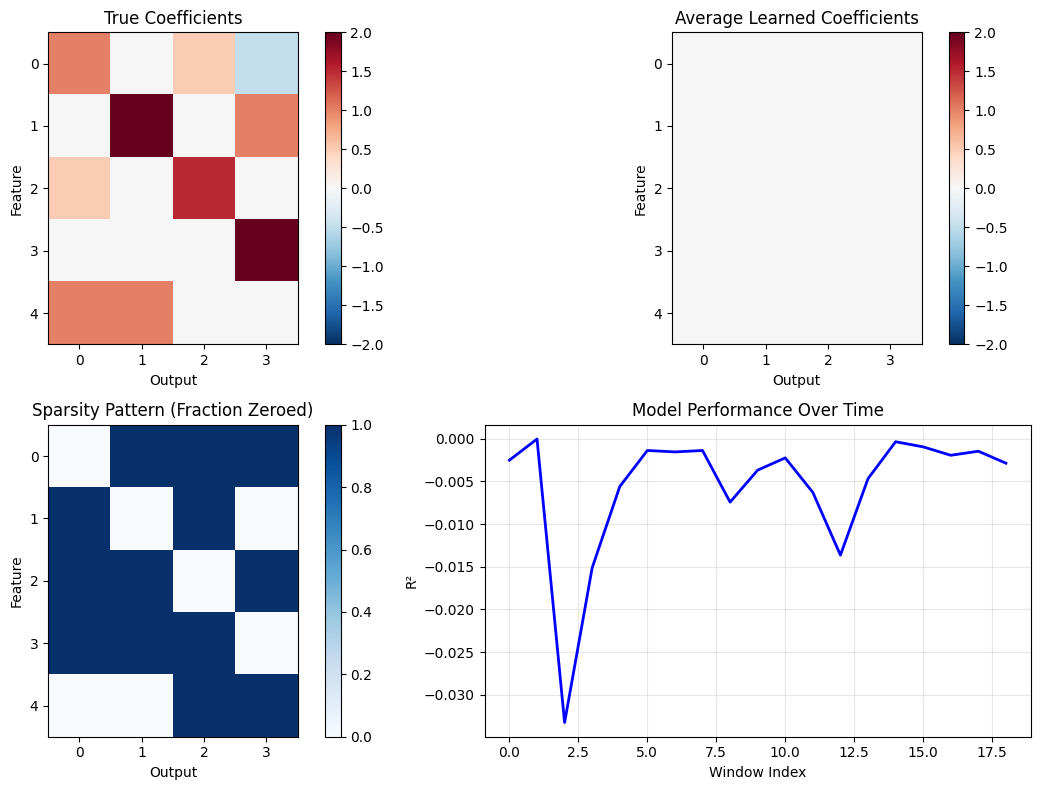


Testing with fixed mask (forcing true zeros)...
Max coefficient value at true zero locations: 0.00e+00
MSE between recovered and true coefficients: 0.7500


In [105]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Core OLS solver with proper einsum notation
@jax.jit
def ols_with_penalty(X_win, Y_win, mask=None, penalty_strength=1e8):
    """
    Solve OLS with optional penalty on masked coefficients.

    Args:
        X_win: (window_size, n_features)
        Y_win: (window_size, n_outputs)
        mask: (n_features, n_outputs) - True where coefficients should be zero
        penalty_strength: Penalty for masked coefficients
    """
    # Correct einsum: wf,wg->fg for XtX
    XtX = jnp.einsum('wf,wg->fg', X_win, X_win)
    # Correct einsum: wf,wo->fo for XtY
    XtY = jnp.einsum('wf,wo->fo', X_win, Y_win)

    # Add regularization for stability
    XtX = XtX + 1e-6 * jnp.eye(XtX.shape[0])

    if mask is not None:
        # Feature-wise penalty: penalize if ANY output is masked
        feature_penalty = jnp.any(mask, axis=1).astype(jnp.float32) * penalty_strength
        XtX = XtX + jnp.diag(feature_penalty)

    # Solve
    W = jnp.linalg.solve(XtX, XtY)

    # Zero out masked coefficients
    if mask is not None:
        W = jnp.where(mask, 0.0, W)

    return W

# Sliding window implementation
def sliding_window_regression(X, Y, window_size, stride, mask_fn=None, penalty_strength=1e8):
    """
    Perform sliding window regression with optional constraints.

    Args:
        X: (n_samples, n_features)
        Y: (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Step size between windows
        mask_fn: Optional function that returns mask for each window
        penalty_strength: Penalty for masked coefficients
    """
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Extract windows efficiently
    def get_window(start_idx):
        X_win = jax.lax.dynamic_slice(X, (start_idx, 0), (window_size, n_features))
        Y_win = jax.lax.dynamic_slice(Y, (start_idx, 0), (window_size, n_outputs))
        return X_win, Y_win

    # Compute starting indices
    start_indices = jnp.arange(n_windows) * stride

    # Get all windows
    X_wins, Y_wins = jax.vmap(get_window)(start_indices)

    # Apply mask function if provided
    if mask_fn is not None:
        masks = jax.vmap(mask_fn)(X_wins, Y_wins)
    else:
        masks = jnp.zeros((n_windows, n_features, n_outputs), dtype=bool)

    # Solve for each window
    W_all = jax.vmap(ols_with_penalty, in_axes=(0, 0, 0, None))(
        X_wins, Y_wins, masks, penalty_strength
    )

    return W_all, masks

# Adaptive thresholding
@jax.jit
def adaptive_threshold_mask(X_win, Y_win, threshold_factor=2.0):
    """Create mask based on initial OLS solution magnitude."""
    # Solve unconstrained OLS first
    W_ols = ols_with_penalty(X_win, Y_win, mask=None)

    # Compute threshold using MAD
    W_flat = jnp.abs(W_ols).ravel()
    median = jnp.median(W_flat)
    mad = jnp.median(jnp.abs(W_flat - median))
    threshold = threshold_factor * mad * 1.4826  # MAD to std conversion

    # Create mask
    return jnp.abs(W_ols) < threshold

# Example with proper R² calculation
def compute_r_squared(Y_true, Y_pred):
    """Compute R² score."""
    ss_res = jnp.sum((Y_true - Y_pred) ** 2)
    ss_tot = jnp.sum((Y_true - jnp.mean(Y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Demo
if __name__ == "__main__":
    # Generate synthetic data
    key = jax.random.PRNGKey(42)
    n_samples, n_features, n_outputs = 1000, 5, 4

    # True coefficients with some zeros
    true_W = jnp.array([
        [1.0, 0.0, 0.5, -0.5],
        [0.0, 2.0, 0.0, 1.0],
        [0.5, 0.0, 1.5, 0.0],
        [0.0, 0.0, 0.0, 2.0],
        [1.0, 1.0, 0.0, 0.0]
    ])

    X = jax.random.normal(key, (n_samples, n_features))
    noise = 0.1 * jax.random.normal(key, (n_samples, n_outputs))
    Y = X @ true_W + noise

    # Run sliding window regression with adaptive thresholding
    window_size = 100
    stride = 50

    print("Running sliding window regression...")
    W_adaptive, masks = sliding_window_regression(
        X, Y, window_size, stride,
        mask_fn=adaptive_threshold_mask,
        penalty_strength=1e8
    )

    # Evaluate performance
    n_windows = W_adaptive.shape[0]
    r2_scores = []

    for i in range(n_windows):
        start = i * stride
        end = start + window_size
        Y_pred = X[start:end] @ W_adaptive[i]
        r2 = compute_r_squared(Y[start:end], Y_pred)
        r2_scores.append(r2)

    r2_scores = jnp.array(r2_scores)

    print(f"Average R²: {jnp.mean(r2_scores):.4f}")
    print(f"Sparsity: {100 * jnp.mean(masks):.1f}% of coefficients zeroed")

    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # True coefficients
    ax = axes[0, 0]
    im = ax.imshow(true_W, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('True Coefficients')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Average learned coefficients
    ax = axes[0, 1]
    W_avg = jnp.mean(W_adaptive, axis=0)
    im = ax.imshow(W_avg, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('Average Learned Coefficients')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Sparsity pattern
    ax = axes[1, 0]
    sparsity = jnp.mean(masks, axis=0)
    im = ax.imshow(sparsity, cmap='Blues', vmin=0, vmax=1)
    ax.set_title('Sparsity Pattern (Fraction Zeroed)')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # R² over time
    ax = axes[1, 1]
    ax.plot(r2_scores, 'b-', linewidth=2)
    ax.set_xlabel('Window Index')
    ax.set_ylabel('R²')
    ax.set_title('Model Performance Over Time')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Comparison with fixed mask
    print("\nTesting with fixed mask (forcing true zeros)...")
    fixed_mask = true_W == 0.0

    def fixed_mask_fn(X_win, Y_win):
        return fixed_mask

    W_fixed, _ = sliding_window_regression(
        X, Y, window_size, stride,
        mask_fn=fixed_mask_fn,
        penalty_strength=1e10  # Very high penalty
    )

    # Check how well we recovered the true zeros
    W_fixed_avg = jnp.mean(W_fixed, axis=0)
    max_violation = jnp.max(jnp.abs(W_fixed_avg[fixed_mask]))
    print(f"Max coefficient value at true zero locations: {max_violation:.2e}")

    # Recovery error
    recovery_error = jnp.mean((W_fixed_avg - true_W) ** 2)
    print(f"MSE between recovered and true coefficients: {recovery_error:.4f}")

0. Running baseline OLS with no constraints...
Baseline R² (no constraints): 0.9975
Baseline coefficients (first window):
[[ 9.9606711e-01 -2.5409726e-02  4.8864260e-01 -4.9832320e-01]
 [-3.7508896e-03  2.0158803e+00  1.1417816e-02  9.9424964e-01]
 [ 4.9709347e-01  8.6876526e-03  1.5107458e+00 -7.6813349e-03]
 [-1.2556125e-03 -1.1886238e-02 -5.9533608e-03  1.9927142e+00]
 [ 1.0061002e+00 -9.9794960e-01 -1.4731111e-03  1.1269051e-03]]
1. Running penalty method with adaptive thresholding...
Sparsity: 65.0% of coefficients zeroed
First window mask summary:
  Total coefficients: 20
  Masked coefficients: 13
  Mask pattern:
[[0 1 1 1]
 [1 0 1 0]
 [1 1 0 1]
 [1 1 1 0]
 [0 0 1 1]]

1b. Testing penalty method with true zero locations...
Average R² with true zero mask: 0.9975

2. Running KKT method with exact constraints...

Constraint verification on average coefficients:
W[0,1] (should be 0): -0.000000
W[4,0]: 1.0311
W[4,1]: -1.0311
W[4,1] + W[4,0] (should be 0): -0.000000
W[0,2] - W[0,3] (sh

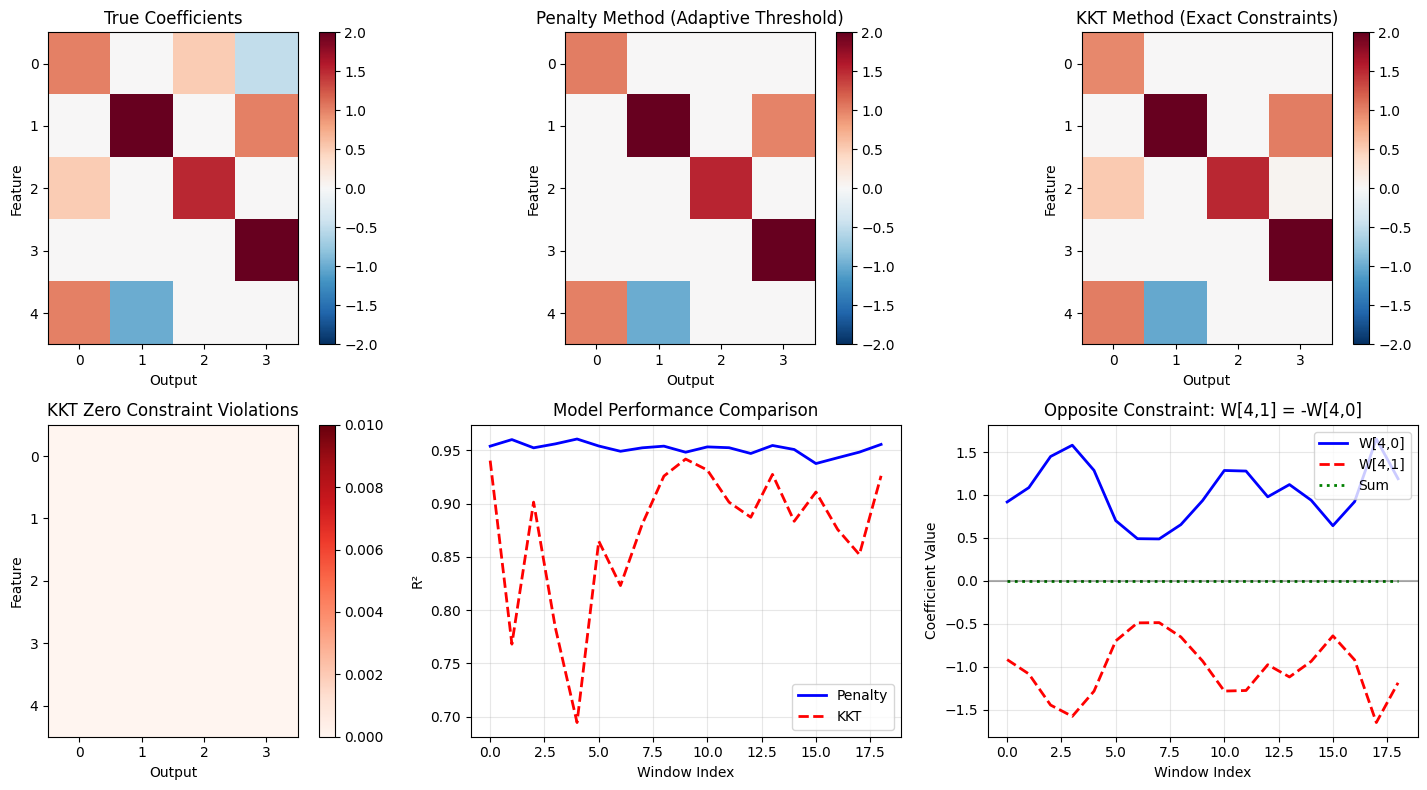


Average R² - Baseline (no constraints): 0.9975
Average R² - Penalty (adaptive threshold): 0.9516
Average R² - Penalty (true zeros): 0.9975
Average R² - KKT: 0.8746


In [108]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Core OLS solver with proper einsum notation
@jax.jit
def ols_with_penalty(X_win, Y_win, mask=None, penalty_strength=1e8):
    """
    Solve OLS with optional penalty on masked coefficients.

    Args:
        X_win: (window_size, n_features)
        Y_win: (window_size, n_outputs)
        mask: (n_features, n_outputs) - True where coefficients should be zero
        penalty_strength: Penalty for masked coefficients
    """
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    # Correct einsum: wf,wg->fg for XtX
    XtX = jnp.einsum('wf,wg->fg', X_win, X_win)
    # Correct einsum: wf,wo->fo for XtY
    XtY = jnp.einsum('wf,wo->fo', X_win, Y_win)

    # Add regularization for stability
    reg = 1e-6 * jnp.eye(XtX.shape[0])

    if mask is None:
        # Standard OLS
        return jnp.linalg.solve(XtX + reg, XtY)

    # Vectorized approach: solve for each output with its own penalty
    def solve_single_output(j):
        # Get mask for this output
        mask_j = mask[:, j]

        # Create diagonal penalty matrix for this output
        penalty_diag = jnp.where(mask_j, penalty_strength, 0.0)
        XtX_penalized = XtX + reg + jnp.diag(penalty_diag)

        # Solve for this output
        w_j = jnp.linalg.solve(XtX_penalized, XtY[:, j])

        # The penalty should push coefficients close to zero
        # but we can also explicitly zero them out
        # w_j = jnp.where(mask_j, 0.0, w_j)

        return w_j

    # Vectorize over outputs
    W = jax.vmap(solve_single_output, in_axes=0, out_axes=1)(jnp.arange(n_outputs))

    return W

# KKT solver for exact constraints
def make_kkt_solver(n_features, n_outputs, max_constraints):
    """
    Create a KKT solver that can handle exact constraints.

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        max_constraints: Maximum number of constraints to handle
    """

    @jax.jit
    def solve_with_kkt(XtX, XtY, constraints_matrix, constraints_rhs, n_active_constraints):
        """
        Solve with KKT conditions for exact constraints.

        Args:
            XtX: (n_features, n_features) - X^T @ X
            XtY: (n_features, n_outputs) - X^T @ Y
            constraints_matrix: (max_constraints, n_features * n_outputs) - A matrix
            constraints_rhs: (max_constraints,) - b vector for Aw = b
            n_active_constraints: Number of active constraints
        """
        n_vars = n_features * n_outputs

        # Flatten XtY for the KKT system
        XtY_flat = XtY.ravel()

        # Build block diagonal XtX for all outputs
        XtX_block = jnp.kron(jnp.eye(n_outputs), XtX)

        # Build KKT matrix
        # [XtX_block   A^T]
        # [A           0  ]
        KKT_top = jnp.hstack([XtX_block, constraints_matrix.T])
        KKT_bottom = jnp.hstack([constraints_matrix, jnp.zeros((max_constraints, max_constraints))])
        KKT = jnp.vstack([KKT_top, KKT_bottom])

        # Build RHS
        rhs = jnp.concatenate([XtY_flat, constraints_rhs])

        # Mask out inactive constraints
        # Add large diagonal elements to rows/cols corresponding to inactive constraints
        mask_constraints = jnp.arange(max_constraints) >= n_active_constraints
        mask_full = jnp.concatenate([jnp.zeros(n_vars, dtype=bool), mask_constraints])
        KKT = KKT + jnp.diag(mask_full.astype(jnp.float32) * 1e10)

        # Solve KKT system
        solution = jnp.linalg.solve(KKT, rhs)

        # Extract weights
        W_flat = solution[:n_vars]
        W = W_flat.reshape(n_features, n_outputs)

        return W

    return solve_with_kkt

# Build constraint matrices for different constraint types
def build_constraint_matrices(n_features, n_outputs, constraints, max_constraints):
    """
    Build constraint matrices for KKT system.

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        constraints: List of constraint specifications
        max_constraints: Maximum number of constraints

    Returns:
        A: Constraint matrix (max_constraints, n_features * n_outputs)
        b: Constraint RHS (max_constraints,)
        n_active: Number of active constraints
    """
    n_vars = n_features * n_outputs
    A = jnp.zeros((max_constraints, n_vars))
    b = jnp.zeros(max_constraints)

    constraint_idx = 0

    for constraint in constraints:
        if constraint_idx >= max_constraints:
            break

        ctype = constraint['type']

        if ctype == 'zero':
            # w[i,j] = 0
            i, j = constraint['feature'], constraint['output']
            idx = i * n_outputs + j
            A = A.at[constraint_idx, idx].set(1.0)
            b = b.at[constraint_idx].set(0.0)
            constraint_idx += 1

        elif ctype == 'value':
            # w[i,j] = v
            i, j, v = constraint['feature'], constraint['output'], constraint['value']
            idx = i * n_outputs + j
            A = A.at[constraint_idx, idx].set(1.0)
            b = b.at[constraint_idx].set(v)
            constraint_idx += 1

        elif ctype == 'opposite':
            # w[i1,j1] = -w[i2,j2]
            i1, j1 = constraint['feature1'], constraint['output1']
            i2, j2 = constraint['feature2'], constraint['output2']
            idx1 = i1 * n_outputs + j1
            idx2 = i2 * n_outputs + j2
            A = A.at[constraint_idx, idx1].set(1.0)
            A = A.at[constraint_idx, idx2].set(1.0)
            b = b.at[constraint_idx].set(0.0)
            constraint_idx += 1

        elif ctype == 'equal':
            # w[i1,j1] = w[i2,j2]
            i1, j1 = constraint['feature1'], constraint['output1']
            i2, j2 = constraint['feature2'], constraint['output2']
            idx1 = i1 * n_outputs + j1
            idx2 = i2 * n_outputs + j2
            A = A.at[constraint_idx, idx1].set(1.0)
            A = A.at[constraint_idx, idx2].set(-1.0)
            b = b.at[constraint_idx].set(0.0)
            constraint_idx += 1

        elif ctype == 'sum':
            # sum of specified coefficients = v
            indices = constraint['indices']  # List of (i,j) tuples
            value = constraint['value']
            for i, j in indices:
                idx = i * n_outputs + j
                A = A.at[constraint_idx, idx].set(1.0)
            b = b.at[constraint_idx].set(value)
            constraint_idx += 1

    return A, b, constraint_idx

# Sliding window implementation with KKT option
def sliding_window_regression(X, Y, window_size, stride,
                            method='penalty',
                            mask_fn=None,
                            constraints=None,
                            penalty_strength=1e8,
                            max_constraints=None):
    """
    Perform sliding window regression with optional constraints.

    Args:
        X: (n_samples, n_features)
        Y: (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Step size between windows
        method: 'penalty' or 'kkt'
        mask_fn: Optional function that returns mask for each window (penalty method)
        constraints: List of constraint dicts (kkt method)
        penalty_strength: Penalty for masked coefficients
        max_constraints: Maximum number of constraints for KKT
    """
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Extract windows efficiently
    def get_window(start_idx):
        X_win = jax.lax.dynamic_slice(X, (start_idx, 0), (window_size, n_features))
        Y_win = jax.lax.dynamic_slice(Y, (start_idx, 0), (window_size, n_outputs))
        return X_win, Y_win

    # Compute starting indices
    start_indices = jnp.arange(n_windows) * stride

    # Get all windows
    X_wins, Y_wins = jax.vmap(get_window)(start_indices)

    if method == 'penalty':
        # Apply mask function if provided
        if mask_fn is not None:
            masks = jax.vmap(mask_fn)(X_wins, Y_wins)
        else:
            masks = jnp.zeros((n_windows, n_features, n_outputs), dtype=bool)

        # Solve for each window
        W_all = jax.vmap(ols_with_penalty, in_axes=(0, 0, 0, None))(
            X_wins, Y_wins, masks, penalty_strength
        )

        return W_all, masks

    elif method == 'kkt':
        # Build constraint matrices
        if constraints is None:
            constraints = []

        if max_constraints is None:
            max_constraints = len(constraints) + 10  # Add some buffer

        A, b, n_active = build_constraint_matrices(
            n_features, n_outputs, constraints, max_constraints
        )

        # Create KKT solver
        kkt_solver = make_kkt_solver(n_features, n_outputs, max_constraints)

        # Solve with KKT for each window
        def solve_window_kkt(X_win, Y_win):
            XtX = jnp.einsum('wf,wg->fg', X_win, X_win)
            XtY = jnp.einsum('wf,wo->fo', X_win, Y_win)
            XtX = XtX + 1e-6 * jnp.eye(XtX.shape[0])

            return kkt_solver(XtX, XtY, A, b, n_active)

        W_all = jax.vmap(solve_window_kkt)(X_wins, Y_wins)

        # Create mask showing constrained coefficients
        masks = jnp.zeros((n_windows, n_features, n_outputs), dtype=bool)
        for constraint in constraints:
            if constraint['type'] == 'zero':
                i, j = constraint['feature'], constraint['output']
                masks = masks.at[:, i, j].set(True)

        return W_all, masks

# Adaptive thresholding
@jax.jit
def adaptive_threshold_mask(X_win, Y_win, threshold_factor=2.0):
    """Create mask based on initial OLS solution magnitude."""
    # Solve unconstrained OLS first
    W_ols = ols_with_penalty(X_win, Y_win, mask=None)

    # Compute threshold using MAD
    W_flat = jnp.abs(W_ols).ravel()
    median = jnp.median(W_flat)
    mad = jnp.median(jnp.abs(W_flat - median))
    threshold = threshold_factor * mad * 1.4826  # MAD to std conversion

    # Create mask
    return jnp.abs(W_ols) < threshold

# Example with proper R² calculation
def compute_r_squared(Y_true, Y_pred):
    """Compute R² score."""
    ss_res = jnp.sum((Y_true - Y_pred) ** 2)
    ss_tot = jnp.sum((Y_true - jnp.mean(Y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Demo
if __name__ == "__main__":
    # Generate synthetic data
    key = jax.random.PRNGKey(42)
    n_samples, n_features, n_outputs = 1000, 5, 4

    # True coefficients with some zeros and relationships
    true_W = jnp.array([
        [1.0, 0.0, 0.5, -0.5],
        [0.0, 2.0, 0.0, 1.0],
        [0.5, 0.0, 1.5, 0.0],
        [0.0, 0.0, 0.0, 2.0],
        [1.0, -1.0, 0.0, 0.0]  # Note: W[4,1] = -W[4,0]
    ])

    X = jax.random.normal(key, (n_samples, n_features))
    noise = 0.1 * jax.random.normal(key, (n_samples, n_outputs))
    Y = X @ true_W + noise

    window_size = 100
    stride = 50

    # Example 0: Baseline - no constraints
    print("0. Running baseline OLS with no constraints...")
    W_baseline, _ = sliding_window_regression(
        X, Y, window_size, stride,
        method='penalty',
        mask_fn=None,  # No mask
        penalty_strength=0
    )

    r2_baseline = []
    for i in range(W_baseline.shape[0]):
        start = i * stride
        end = start + window_size
        Y_pred = X[start:end] @ W_baseline[i]
        r2_baseline.append(compute_r_squared(Y[start:end], Y_pred))

    print(f"Baseline R² (no constraints): {jnp.mean(jnp.array(r2_baseline)):.4f}")
    print(f"Baseline coefficients (first window):\n{W_baseline[0]}")

    # Example 1: Penalty method with adaptive thresholding
    print("1. Running penalty method with adaptive thresholding...")
    W_penalty, masks_penalty = sliding_window_regression(
        X, Y, window_size, stride,
        method='penalty',
        mask_fn=adaptive_threshold_mask,
        penalty_strength=1e10  # Increased from 1e8
    )

    print(f"Sparsity: {100 * jnp.mean(masks_penalty):.1f}% of coefficients zeroed")

    # Debug: Check if we're masking too many coefficients
    print(f"First window mask summary:")
    print(f"  Total coefficients: {n_features * n_outputs}")
    print(f"  Masked coefficients: {jnp.sum(masks_penalty[0])}")
    print(f"  Mask pattern:\n{masks_penalty[0].astype(int)}")

    # Test with a simple fixed mask that matches true zeros
    print("\n1b. Testing penalty method with true zero locations...")
    true_zero_mask = (true_W == 0.0)

    def true_mask_fn(X_win, Y_win):
        return true_zero_mask

    W_penalty_true, _ = sliding_window_regression(
        X, Y, window_size, stride,
        method='penalty',
        mask_fn=true_mask_fn,
        penalty_strength=1e10
    )

    # Check performance with true mask
    r2_penalty_true = []
    for i in range(W_penalty_true.shape[0]):
        start = i * stride
        end = start + window_size
        Y_pred = X[start:end] @ W_penalty_true[i]
        r2_penalty_true.append(compute_r_squared(Y[start:end], Y_pred))

    print(f"Average R² with true zero mask: {jnp.mean(jnp.array(r2_penalty_true)):.4f}")

    # Example 2: KKT method with exact constraints
    print("\n2. Running KKT method with exact constraints...")

    # Define constraints
    constraints = [
        # Exact zeros
        {'type': 'zero', 'feature': 0, 'output': 1},
        {'type': 'zero', 'feature': 1, 'output': 0},
        {'type': 'zero', 'feature': 1, 'output': 2},
        {'type': 'zero', 'feature': 2, 'output': 1},
        {'type': 'zero', 'feature': 3, 'output': 0},
        {'type': 'zero', 'feature': 3, 'output': 1},
        {'type': 'zero', 'feature': 3, 'output': 2},
        {'type': 'zero', 'feature': 4, 'output': 2},
        {'type': 'zero', 'feature': 4, 'output': 3},

        # Opposite constraint: W[4,1] = -W[4,0]
        {'type': 'opposite', 'feature1': 4, 'output1': 1, 'feature2': 4, 'output2': 0},

        # Equal constraint: W[0,2] = W[0,3] (both should be around 0.5 and -0.5)
        # This won't match truth but shows the capability
        {'type': 'equal', 'feature1': 0, 'output1': 2, 'feature2': 0, 'output2': 3},

        # Value constraint: Set a specific coefficient
        {'type': 'value', 'feature': 2, 'output': 2, 'value': 1.5},
    ]

    W_kkt, masks_kkt = sliding_window_regression(
        X, Y, window_size, stride,
        method='kkt',
        constraints=constraints,
        max_constraints=20
    )

    # Verify constraints
    W_kkt_avg = jnp.mean(W_kkt, axis=0)
    print("\nConstraint verification on average coefficients:")
    print(f"W[0,1] (should be 0): {W_kkt_avg[0,1]:.6f}")
    print(f"W[4,0]: {W_kkt_avg[4,0]:.4f}")
    print(f"W[4,1]: {W_kkt_avg[4,1]:.4f}")
    print(f"W[4,1] + W[4,0] (should be 0): {W_kkt_avg[4,1] + W_kkt_avg[4,0]:.6f}")
    print(f"W[0,2] - W[0,3] (should be 0): {W_kkt_avg[0,2] - W_kkt_avg[0,3]:.6f}")
    print(f"W[2,2] (should be 1.5): {W_kkt_avg[2,2]:.4f}")

    # Example 3: KKT with sum constraint
    print("\n3. Running KKT with sum constraint...")

    constraints_sum = [
        # Some zeros
        {'type': 'zero', 'feature': 1, 'output': 0},
        {'type': 'zero', 'feature': 3, 'output': 0},

        # Sum constraint: W[0,0] + W[2,0] + W[4,0] = 2.5
        {'type': 'sum', 'indices': [(0,0), (2,0), (4,0)], 'value': 2.5},
    ]

    W_sum, _ = sliding_window_regression(
        X, Y, window_size, stride,
        method='kkt',
        constraints=constraints_sum,
        max_constraints=10
    )

    W_sum_avg = jnp.mean(W_sum, axis=0)
    sum_check = W_sum_avg[0,0] + W_sum_avg[2,0] + W_sum_avg[4,0]
    print(f"\nSum W[0,0] + W[2,0] + W[4,0] = {sum_check:.4f} (target: 2.5)")

    # Visualize results
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # True coefficients
    ax = axes[0, 0]
    im = ax.imshow(true_W, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('True Coefficients')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Penalty method results
    ax = axes[0, 1]
    W_penalty_avg = jnp.mean(W_penalty, axis=0)
    im = ax.imshow(W_penalty_avg, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('Penalty Method (Adaptive Threshold)')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # KKT method results
    ax = axes[0, 2]
    im = ax.imshow(W_kkt_avg, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('KKT Method (Exact Constraints)')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Constraint violations
    ax = axes[1, 0]
    zero_violations = jnp.abs(W_kkt_avg) * masks_kkt[0]
    im = ax.imshow(zero_violations, cmap='Reds', vmin=0, vmax=0.01)
    ax.set_title('KKT Zero Constraint Violations')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # R² comparison
    ax = axes[1, 1]

    # Compute R² for both methods
    r2_penalty = []
    r2_kkt = []

    for i in range(W_penalty.shape[0]):
        start = i * stride
        end = start + window_size

        Y_pred_penalty = X[start:end] @ W_penalty[i]
        r2_penalty.append(compute_r_squared(Y[start:end], Y_pred_penalty))

        Y_pred_kkt = X[start:end] @ W_kkt[i]
        r2_kkt.append(compute_r_squared(Y[start:end], Y_pred_kkt))

    ax.plot(r2_penalty, 'b-', label='Penalty', linewidth=2)
    ax.plot(r2_kkt, 'r--', label='KKT', linewidth=2)
    ax.set_xlabel('Window Index')
    ax.set_ylabel('R²')
    ax.set_title('Model Performance Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Coefficient evolution for constrained pair
    ax = axes[1, 2]
    ax.plot(W_kkt[:, 4, 0], 'b-', label='W[4,0]', linewidth=2)
    ax.plot(W_kkt[:, 4, 1], 'r--', label='W[4,1]', linewidth=2)
    ax.plot(W_kkt[:, 4, 0] + W_kkt[:, 4, 1], 'g:', label='Sum', linewidth=2)
    ax.set_xlabel('Window Index')
    ax.set_ylabel('Coefficient Value')
    ax.set_title('Opposite Constraint: W[4,1] = -W[4,0]')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nAverage R² - Baseline (no constraints): {jnp.mean(jnp.array(r2_baseline)):.4f}")
    print(f"Average R² - Penalty (adaptive threshold): {jnp.mean(jnp.array(r2_penalty)):.4f}")
    print(f"Average R² - Penalty (true zeros): {jnp.mean(jnp.array(r2_penalty_true)):.4f}")
    print(f"Average R² - KKT: {jnp.mean(jnp.array(r2_kkt)):.4f}")b

0. Running baseline OLS with no constraints...
Baseline R² (no constraints): 0.9975
Baseline coefficients (first window):
[[ 9.9606711e-01 -2.5409726e-02  4.8864260e-01 -4.9832320e-01]
 [-3.7508896e-03  2.0158803e+00  1.1417816e-02  9.9424964e-01]
 [ 4.9709347e-01  8.6876526e-03  1.5107458e+00 -7.6813349e-03]
 [-1.2556125e-03 -1.1886238e-02 -5.9533608e-03  1.9927142e+00]
 [ 1.0061002e+00 -9.9794960e-01 -1.4731111e-03  1.1269051e-03]]
1. Running penalty method with adaptive thresholding...
Sparsity: 65.0% of coefficients zeroed
First window mask summary:
  Total coefficients: 20
  Masked coefficients: 13
  Mask pattern:
[[0 1 1 1]
 [1 0 1 0]
 [1 1 0 1]
 [1 1 1 0]
 [0 0 1 1]]

1b. Testing penalty method with true zero locations...
Average R² with true zero mask: 0.9975

2. Running KKT method with exact constraints...

Constraint verification on average coefficients:
W[0,1] (should be 0): -0.000000
W[4,0]: 1.0311
W[4,1]: -1.0311
W[4,1] + W[4,0] (should be 0): -0.000000
W[0,2] - W[0,3] (sh

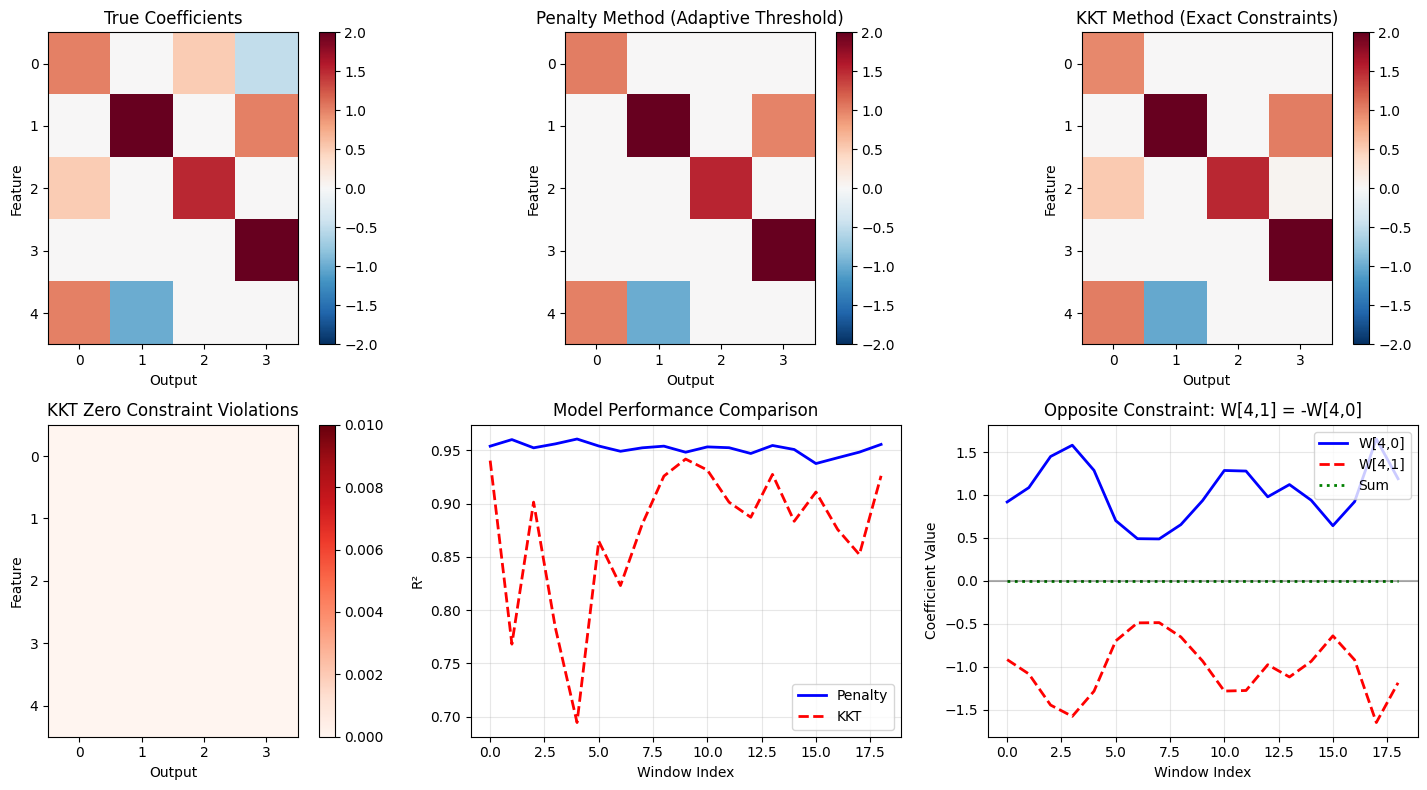


Average R² - Baseline (no constraints): 0.9975
Average R² - Penalty (adaptive threshold): 0.9516
Average R² - Penalty (true zeros): 0.9975
Average R² - KKT: 0.8746


In [109]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Core OLS solver with proper einsum notation
@jax.jit
def ols_with_penalty(X_win, Y_win, mask=None, penalty_strength=1e8):
    """
    Solve OLS with optional penalty on masked coefficients.

    Args:
        X_win: (window_size, n_features)
        Y_win: (window_size, n_outputs)
        mask: (n_features, n_outputs) - True where coefficients should be zero
        penalty_strength: Penalty for masked coefficients
    """
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    # Correct einsum: wf,wg->fg for XtX
    XtX = jnp.einsum('wf,wg->fg', X_win, X_win)
    # Correct einsum: wf,wo->fo for XtY
    XtY = jnp.einsum('wf,wo->fo', X_win, Y_win)

    # Add regularization for stability
    reg = 1e-6 * jnp.eye(XtX.shape[0])

    if mask is None:
        # Standard OLS
        return jnp.linalg.solve(XtX + reg, XtY)

    # Vectorized approach: solve for each output with its own penalty
    def solve_single_output(j):
        # Get mask for this output
        mask_j = mask[:, j]

        # Create diagonal penalty matrix for this output
        penalty_diag = jnp.where(mask_j, penalty_strength, 0.0)
        XtX_penalized = XtX + reg + jnp.diag(penalty_diag)

        # Solve for this output
        w_j = jnp.linalg.solve(XtX_penalized, XtY[:, j])

        # The penalty should push coefficients close to zero
        # but we can also explicitly zero them out
        # w_j = jnp.where(mask_j, 0.0, w_j)

        return w_j

    # Vectorize over outputs
    W = jax.vmap(solve_single_output, in_axes=0, out_axes=1)(jnp.arange(n_outputs))

    return W

# KKT solver for exact constraints
def make_kkt_solver(n_features, n_outputs, max_constraints):
    """
    Create a KKT solver that can handle exact constraints.

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        max_constraints: Maximum number of constraints to handle
    """

    @jax.jit
    def solve_with_kkt(XtX, XtY, constraints_matrix, constraints_rhs, n_active_constraints):
        """
        Solve with KKT conditions for exact constraints.

        Args:
            XtX: (n_features, n_features) - X^T @ X
            XtY: (n_features, n_outputs) - X^T @ Y
            constraints_matrix: (max_constraints, n_features * n_outputs) - A matrix
            constraints_rhs: (max_constraints,) - b vector for Aw = b
            n_active_constraints: Number of active constraints
        """
        n_vars = n_features * n_outputs

        # Flatten XtY for the KKT system
        XtY_flat = XtY.ravel()

        # Build block diagonal XtX for all outputs
        XtX_block = jnp.kron(jnp.eye(n_outputs), XtX)

        # Build KKT matrix
        # [XtX_block   A^T]
        # [A           0  ]
        KKT_top = jnp.hstack([XtX_block, constraints_matrix.T])
        KKT_bottom = jnp.hstack([constraints_matrix, jnp.zeros((max_constraints, max_constraints))])
        KKT = jnp.vstack([KKT_top, KKT_bottom])

        # Build RHS
        rhs = jnp.concatenate([XtY_flat, constraints_rhs])

        # Mask out inactive constraints
        # Add large diagonal elements to rows/cols corresponding to inactive constraints
        mask_constraints = jnp.arange(max_constraints) >= n_active_constraints
        mask_full = jnp.concatenate([jnp.zeros(n_vars, dtype=bool), mask_constraints])
        KKT = KKT + jnp.diag(mask_full.astype(jnp.float32) * 1e10)

        # Solve KKT system
        solution = jnp.linalg.solve(KKT, rhs)

        # Extract weights
        W_flat = solution[:n_vars]
        W = W_flat.reshape(n_features, n_outputs)

        return W

    return solve_with_kkt

# Build constraint matrices for different constraint types
def build_constraint_matrices(n_features, n_outputs, constraints, max_constraints):
    """
    Build constraint matrices for KKT system.

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        constraints: List of constraint specifications
        max_constraints: Maximum number of constraints

    Returns:
        A: Constraint matrix (max_constraints, n_features * n_outputs)
        b: Constraint RHS (max_constraints,)
        n_active: Number of active constraints
    """
    n_vars = n_features * n_outputs
    A = jnp.zeros((max_constraints, n_vars))
    b = jnp.zeros(max_constraints)

    constraint_idx = 0

    for constraint in constraints:
        if constraint_idx >= max_constraints:
            break

        ctype = constraint['type']

        if ctype == 'zero':
            # w[i,j] = 0
            i, j = constraint['feature'], constraint['output']
            idx = i * n_outputs + j
            A = A.at[constraint_idx, idx].set(1.0)
            b = b.at[constraint_idx].set(0.0)
            constraint_idx += 1

        elif ctype == 'value':
            # w[i,j] = v
            i, j, v = constraint['feature'], constraint['output'], constraint['value']
            idx = i * n_outputs + j
            A = A.at[constraint_idx, idx].set(1.0)
            b = b.at[constraint_idx].set(v)
            constraint_idx += 1

        elif ctype == 'opposite':
            # w[i1,j1] = -w[i2,j2]
            i1, j1 = constraint['feature1'], constraint['output1']
            i2, j2 = constraint['feature2'], constraint['output2']
            idx1 = i1 * n_outputs + j1
            idx2 = i2 * n_outputs + j2
            A = A.at[constraint_idx, idx1].set(1.0)
            A = A.at[constraint_idx, idx2].set(1.0)
            b = b.at[constraint_idx].set(0.0)
            constraint_idx += 1

        elif ctype == 'equal':
            # w[i1,j1] = w[i2,j2]
            i1, j1 = constraint['feature1'], constraint['output1']
            i2, j2 = constraint['feature2'], constraint['output2']
            idx1 = i1 * n_outputs + j1
            idx2 = i2 * n_outputs + j2
            A = A.at[constraint_idx, idx1].set(1.0)
            A = A.at[constraint_idx, idx2].set(-1.0)
            b = b.at[constraint_idx].set(0.0)
            constraint_idx += 1

        elif ctype == 'sum':
            # sum of specified coefficients = v
            indices = constraint['indices']  # List of (i,j) tuples
            value = constraint['value']
            for i, j in indices:
                idx = i * n_outputs + j
                A = A.at[constraint_idx, idx].set(1.0)
            b = b.at[constraint_idx].set(value)
            constraint_idx += 1

    return A, b, constraint_idx

# Sliding window implementation with KKT option
def sliding_window_regression(X, Y, window_size, stride,
                            method='penalty',
                            mask_fn=None,
                            constraints=None,
                            penalty_strength=1e8,
                            max_constraints=None):
    """
    Perform sliding window regression with optional constraints.

    Args:
        X: (n_samples, n_features)
        Y: (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Step size between windows
        method: 'penalty' or 'kkt'
        mask_fn: Optional function that returns mask for each window (penalty method)
        constraints: List of constraint dicts (kkt method)
        penalty_strength: Penalty for masked coefficients
        max_constraints: Maximum number of constraints for KKT
    """
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Extract windows efficiently
    def get_window(start_idx):
        X_win = jax.lax.dynamic_slice(X, (start_idx, 0), (window_size, n_features))
        Y_win = jax.lax.dynamic_slice(Y, (start_idx, 0), (window_size, n_outputs))
        return X_win, Y_win

    # Compute starting indices
    start_indices = jnp.arange(n_windows) * stride

    # Get all windows
    X_wins, Y_wins = jax.vmap(get_window)(start_indices)

    if method == 'penalty':
        # Apply mask function if provided
        if mask_fn is not None:
            masks = jax.vmap(mask_fn)(X_wins, Y_wins)
        else:
            masks = jnp.zeros((n_windows, n_features, n_outputs), dtype=bool)

        # Solve for each window
        W_all = jax.vmap(ols_with_penalty, in_axes=(0, 0, 0, None))(
            X_wins, Y_wins, masks, penalty_strength
        )

        return W_all, masks

    elif method == 'kkt':
        # Build constraint matrices
        if constraints is None:
            constraints = []

        if max_constraints is None:
            max_constraints = len(constraints) + 10  # Add some buffer

        A, b, n_active = build_constraint_matrices(
            n_features, n_outputs, constraints, max_constraints
        )

        # Create KKT solver
        kkt_solver = make_kkt_solver(n_features, n_outputs, max_constraints)

        # Solve with KKT for each window
        def solve_window_kkt(X_win, Y_win):
            XtX = jnp.einsum('wf,wg->fg', X_win, X_win)
            XtY = jnp.einsum('wf,wo->fo', X_win, Y_win)
            XtX = XtX + 1e-6 * jnp.eye(XtX.shape[0])

            return kkt_solver(XtX, XtY, A, b, n_active)

        W_all = jax.vmap(solve_window_kkt)(X_wins, Y_wins)

        # Create mask showing constrained coefficients
        masks = jnp.zeros((n_windows, n_features, n_outputs), dtype=bool)
        for constraint in constraints:
            if constraint['type'] == 'zero':
                i, j = constraint['feature'], constraint['output']
                masks = masks.at[:, i, j].set(True)

        return W_all, masks

# Adaptive thresholding
@jax.jit
def adaptive_threshold_mask(X_win, Y_win, threshold_factor=2.0):
    """Create mask based on initial OLS solution magnitude."""
    # Solve unconstrained OLS first
    W_ols = ols_with_penalty(X_win, Y_win, mask=None)

    # Compute threshold using MAD
    W_flat = jnp.abs(W_ols).ravel()
    median = jnp.median(W_flat)
    mad = jnp.median(jnp.abs(W_flat - median))
    threshold = threshold_factor * mad * 1.4826  # MAD to std conversion

    # Create mask
    return jnp.abs(W_ols) < threshold

# Example with proper R² calculation
def compute_r_squared(Y_true, Y_pred):
    """Compute R² score."""
    ss_res = jnp.sum((Y_true - Y_pred) ** 2)
    ss_tot = jnp.sum((Y_true - jnp.mean(Y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Demo
if __name__ == "__main__":
    # Generate synthetic data
    key = jax.random.PRNGKey(42)
    n_samples, n_features, n_outputs = 1000, 5, 4

    # True coefficients with some zeros and relationships
    true_W = jnp.array([
        [1.0, 0.0, 0.5, -0.5],
        [0.0, 2.0, 0.0, 1.0],
        [0.5, 0.0, 1.5, 0.0],
        [0.0, 0.0, 0.0, 2.0],
        [1.0, -1.0, 0.0, 0.0]  # Note: W[4,1] = -W[4,0]
    ])

    X = jax.random.normal(key, (n_samples, n_features))
    noise = 0.1 * jax.random.normal(key, (n_samples, n_outputs))
    Y = X @ true_W + noise

    window_size = 100
    stride = 50

    # Example 0: Baseline - no constraints
    print("0. Running baseline OLS with no constraints...")
    W_baseline, _ = sliding_window_regression(
        X, Y, window_size, stride,
        method='penalty',
        mask_fn=None,  # No mask
        penalty_strength=0
    )

    r2_baseline = []
    for i in range(W_baseline.shape[0]):
        start = i * stride
        end = start + window_size
        Y_pred = X[start:end] @ W_baseline[i]
        r2_baseline.append(compute_r_squared(Y[start:end], Y_pred))

    print(f"Baseline R² (no constraints): {jnp.mean(jnp.array(r2_baseline)):.4f}")
    print(f"Baseline coefficients (first window):\n{W_baseline[0]}")

    # Example 1: Penalty method with adaptive thresholding
    print("1. Running penalty method with adaptive thresholding...")
    W_penalty, masks_penalty = sliding_window_regression(
        X, Y, window_size, stride,
        method='penalty',
        mask_fn=adaptive_threshold_mask,
        penalty_strength=1e10  # Increased from 1e8
    )

    print(f"Sparsity: {100 * jnp.mean(masks_penalty):.1f}% of coefficients zeroed")

    # Debug: Check if we're masking too many coefficients
    print(f"First window mask summary:")
    print(f"  Total coefficients: {n_features * n_outputs}")
    print(f"  Masked coefficients: {jnp.sum(masks_penalty[0])}")
    print(f"  Mask pattern:\n{masks_penalty[0].astype(int)}")

    # Test with a simple fixed mask that matches true zeros
    print("\n1b. Testing penalty method with true zero locations...")
    true_zero_mask = (true_W == 0.0)

    def true_mask_fn(X_win, Y_win):
        return true_zero_mask

    W_penalty_true, _ = sliding_window_regression(
        X, Y, window_size, stride,
        method='penalty',
        mask_fn=true_mask_fn,
        penalty_strength=1e10
    )

    # Check performance with true mask
    r2_penalty_true = []
    for i in range(W_penalty_true.shape[0]):
        start = i * stride
        end = start + window_size
        Y_pred = X[start:end] @ W_penalty_true[i]
        r2_penalty_true.append(compute_r_squared(Y[start:end], Y_pred))

    print(f"Average R² with true zero mask: {jnp.mean(jnp.array(r2_penalty_true)):.4f}")

    # Example 2: KKT method with exact constraints
    print("\n2. Running KKT method with exact constraints...")

    # Define constraints
    constraints = [
        # Exact zeros
        {'type': 'zero', 'feature': 0, 'output': 1},
        {'type': 'zero', 'feature': 1, 'output': 0},
        {'type': 'zero', 'feature': 1, 'output': 2},
        {'type': 'zero', 'feature': 2, 'output': 1},
        {'type': 'zero', 'feature': 3, 'output': 0},
        {'type': 'zero', 'feature': 3, 'output': 1},
        {'type': 'zero', 'feature': 3, 'output': 2},
        {'type': 'zero', 'feature': 4, 'output': 2},
        {'type': 'zero', 'feature': 4, 'output': 3},

        # Opposite constraint: W[4,1] = -W[4,0]
        {'type': 'opposite', 'feature1': 4, 'output1': 1, 'feature2': 4, 'output2': 0},

        # Equal constraint: W[0,2] = W[0,3] (both should be around 0.5 and -0.5)
        # This won't match truth but shows the capability
        {'type': 'equal', 'feature1': 0, 'output1': 2, 'feature2': 0, 'output2': 3},

        # Value constraint: Set a specific coefficient
        {'type': 'value', 'feature': 2, 'output': 2, 'value': 1.5},
    ]

    W_kkt, masks_kkt = sliding_window_regression(
        X, Y, window_size, stride,
        method='kkt',
        constraints=constraints,
        max_constraints=20
    )

    # Verify constraints
    W_kkt_avg = jnp.mean(W_kkt, axis=0)
    print("\nConstraint verification on average coefficients:")
    print(f"W[0,1] (should be 0): {W_kkt_avg[0,1]:.6f}")
    print(f"W[4,0]: {W_kkt_avg[4,0]:.4f}")
    print(f"W[4,1]: {W_kkt_avg[4,1]:.4f}")
    print(f"W[4,1] + W[4,0] (should be 0): {W_kkt_avg[4,1] + W_kkt_avg[4,0]:.6f}")
    print(f"W[0,2] - W[0,3] (should be 0): {W_kkt_avg[0,2] - W_kkt_avg[0,3]:.6f}")
    print(f"W[2,2] (should be 1.5): {W_kkt_avg[2,2]:.4f}")

    # Example 3: KKT with sum constraint
    print("\n3. Running KKT with sum constraint...")

    constraints_sum = [
        # Some zeros
        {'type': 'zero', 'feature': 1, 'output': 0},
        {'type': 'zero', 'feature': 3, 'output': 0},

        # Sum constraint: W[0,0] + W[2,0] + W[4,0] = 2.5
        {'type': 'sum', 'indices': [(0,0), (2,0), (4,0)], 'value': 2.5},
    ]

    W_sum, _ = sliding_window_regression(
        X, Y, window_size, stride,
        method='kkt',
        constraints=constraints_sum,
        max_constraints=10
    )

    W_sum_avg = jnp.mean(W_sum, axis=0)
    sum_check = W_sum_avg[0,0] + W_sum_avg[2,0] + W_sum_avg[4,0]
    print(f"\nSum W[0,0] + W[2,0] + W[4,0] = {sum_check:.4f} (target: 2.5)")

    # Visualize results
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # True coefficients
    ax = axes[0, 0]
    im = ax.imshow(true_W, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('True Coefficients')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Penalty method results
    ax = axes[0, 1]
    W_penalty_avg = jnp.mean(W_penalty, axis=0)
    im = ax.imshow(W_penalty_avg, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('Penalty Method (Adaptive Threshold)')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # KKT method results
    ax = axes[0, 2]
    im = ax.imshow(W_kkt_avg, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('KKT Method (Exact Constraints)')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Constraint violations
    ax = axes[1, 0]
    zero_violations = jnp.abs(W_kkt_avg) * masks_kkt[0]
    im = ax.imshow(zero_violations, cmap='Reds', vmin=0, vmax=0.01)
    ax.set_title('KKT Zero Constraint Violations')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # R² comparison
    ax = axes[1, 1]

    # Compute R² for both methods
    r2_penalty = []
    r2_kkt = []

    for i in range(W_penalty.shape[0]):
        start = i * stride
        end = start + window_size

        Y_pred_penalty = X[start:end] @ W_penalty[i]
        r2_penalty.append(compute_r_squared(Y[start:end], Y_pred_penalty))

        Y_pred_kkt = X[start:end] @ W_kkt[i]
        r2_kkt.append(compute_r_squared(Y[start:end], Y_pred_kkt))

    ax.plot(r2_penalty, 'b-', label='Penalty', linewidth=2)
    ax.plot(r2_kkt, 'r--', label='KKT', linewidth=2)
    ax.set_xlabel('Window Index')
    ax.set_ylabel('R²')
    ax.set_title('Model Performance Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Coefficient evolution for constrained pair
    ax = axes[1, 2]
    ax.plot(W_kkt[:, 4, 0], 'b-', label='W[4,0]', linewidth=2)
    ax.plot(W_kkt[:, 4, 1], 'r--', label='W[4,1]', linewidth=2)
    ax.plot(W_kkt[:, 4, 0] + W_kkt[:, 4, 1], 'g:', label='Sum', linewidth=2)
    ax.set_xlabel('Window Index')
    ax.set_ylabel('Coefficient Value')
    ax.set_title('Opposite Constraint: W[4,1] = -W[4,0]')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nAverage R² - Baseline (no constraints): {jnp.mean(jnp.array(r2_baseline)):.4f}")
    print(f"Average R² - Penalty (adaptive threshold): {jnp.mean(jnp.array(r2_penalty)):.4f}")
    print(f"Average R² - Penalty (true zeros): {jnp.mean(jnp.array(r2_penalty_true)):.4f}")
    print(f"Average R² - KKT: {jnp.mean(jnp.array(r2_kkt)):.4f}")

0. Running baseline OLS with no constraints...
Baseline R² (no constraints): 0.9975
Baseline coefficients (first window):
[[ 9.9606711e-01 -2.5409726e-02  4.8864260e-01 -4.9832320e-01]
 [-3.7508896e-03  2.0158803e+00  1.1417816e-02  9.9424964e-01]
 [ 4.9709347e-01  8.6876526e-03  1.5107458e+00 -7.6813349e-03]
 [-1.2556125e-03 -1.1886238e-02 -5.9533608e-03  1.9927142e+00]
 [ 1.0061002e+00 -9.9794960e-01 -1.4731111e-03  1.1269051e-03]]
1. Running penalty method with adaptive thresholding...
Sparsity: 65.0% of coefficients zeroed
First window mask summary:
  Total coefficients: 20
  Masked coefficients: 13
  Mask pattern:
[[0 1 1 1]
 [1 0 1 0]
 [1 1 0 1]
 [1 1 1 0]
 [0 0 1 1]]

1b. Testing penalty method with true zero locations...
Average R² with true zero mask: 0.9975

2. Running KKT method with exact constraints...

Constraint verification on average coefficients:
W[0,1] (should be 0): -0.000000
W[4,0]: 1.0311
W[4,1]: -1.0311
W[4,1] + W[4,0] (should be 0): -0.000000
W[0,2] - W[0,3] (sh

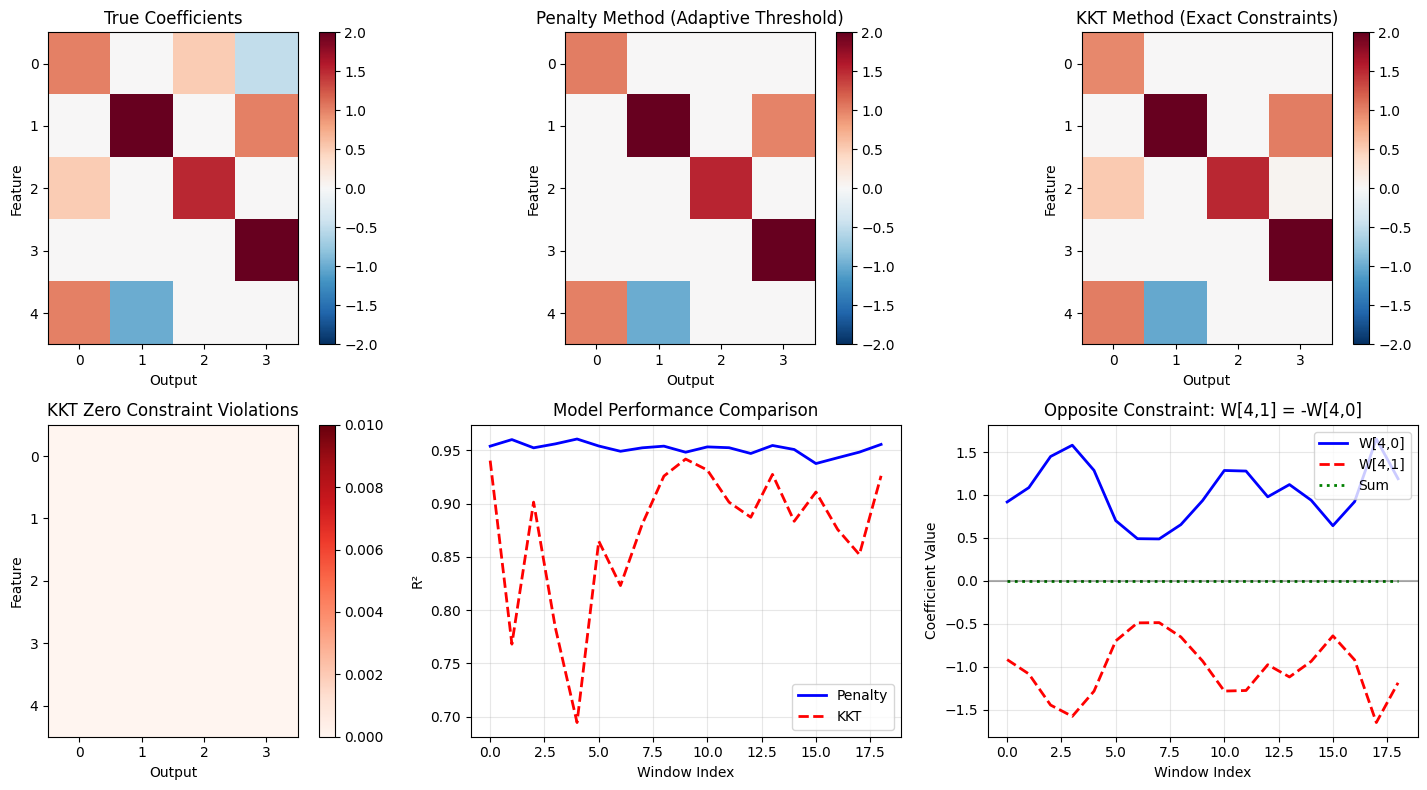


Average R² - Baseline (no constraints): 0.9975
Average R² - Penalty (adaptive threshold): 0.9516
Average R² - Penalty (true zeros): 0.9975
Average R² - KKT: 0.8746


In [110]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Core OLS solver with proper einsum notation
@jax.jit
def ols_with_penalty(X_win, Y_win, mask=None, penalty_strength=1e8):
    """
    Solve OLS with optional penalty on masked coefficients.

    Args:
        X_win: (window_size, n_features)
        Y_win: (window_size, n_outputs)
        mask: (n_features, n_outputs) - True where coefficients should be zero
        penalty_strength: Penalty for masked coefficients
    """
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    # Correct einsum: wf,wg->fg for XtX
    XtX = jnp.einsum('wf,wg->fg', X_win, X_win)
    # Correct einsum: wf,wo->fo for XtY
    XtY = jnp.einsum('wf,wo->fo', X_win, Y_win)

    # Add regularization for stability
    reg = 1e-6 * jnp.eye(XtX.shape[0])

    if mask is None:
        # Standard OLS
        return jnp.linalg.solve(XtX + reg, XtY)

    # Vectorized approach: solve for each output with its own penalty
    def solve_single_output(j):
        # Get mask for this output
        mask_j = mask[:, j]

        # Create diagonal penalty matrix for this output
        penalty_diag = jnp.where(mask_j, penalty_strength, 0.0)
        XtX_penalized = XtX + reg + jnp.diag(penalty_diag)

        # Solve for this output
        w_j = jnp.linalg.solve(XtX_penalized, XtY[:, j])

        # The penalty should push coefficients close to zero
        # but we can also explicitly zero them out
        # w_j = jnp.where(mask_j, 0.0, w_j)

        return w_j

    # Vectorize over outputs
    W = jax.vmap(solve_single_output, in_axes=0, out_axes=1)(jnp.arange(n_outputs))

    return W

# KKT solver for exact constraints
def make_kkt_solver(n_features, n_outputs, max_constraints):
    """
    Create a KKT solver that can handle exact constraints.

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        max_constraints: Maximum number of constraints to handle
    """

    @jax.jit
    def solve_with_kkt(XtX, XtY, constraints_matrix, constraints_rhs, n_active_constraints):
        """
        Solve with KKT conditions for exact constraints.

        Args:
            XtX: (n_features, n_features) - X^T @ X
            XtY: (n_features, n_outputs) - X^T @ Y
            constraints_matrix: (max_constraints, n_features * n_outputs) - A matrix
            constraints_rhs: (max_constraints,) - b vector for Aw = b
            n_active_constraints: Number of active constraints
        """
        n_vars = n_features * n_outputs

        # Flatten XtY for the KKT system
        XtY_flat = XtY.ravel()

        # Build block diagonal XtX for all outputs
        XtX_block = jnp.kron(jnp.eye(n_outputs), XtX)

        # Build KKT matrix
        # [XtX_block   A^T]
        # [A           0  ]
        KKT_top = jnp.hstack([XtX_block, constraints_matrix.T])
        KKT_bottom = jnp.hstack([constraints_matrix, jnp.zeros((max_constraints, max_constraints))])
        KKT = jnp.vstack([KKT_top, KKT_bottom])

        # Build RHS
        rhs = jnp.concatenate([XtY_flat, constraints_rhs])

        # Mask out inactive constraints
        # Add large diagonal elements to rows/cols corresponding to inactive constraints
        mask_constraints = jnp.arange(max_constraints) >= n_active_constraints
        mask_full = jnp.concatenate([jnp.zeros(n_vars, dtype=bool), mask_constraints])
        KKT = KKT + jnp.diag(mask_full.astype(jnp.float32) * 1e10)

        # Solve KKT system
        solution = jnp.linalg.solve(KKT, rhs)

        # Extract weights
        W_flat = solution[:n_vars]
        W = W_flat.reshape(n_features, n_outputs)

        return W

    return solve_with_kkt

# Build constraint matrices for different constraint types
def build_constraint_matrices(n_features, n_outputs, constraints, max_constraints):
    """
    Build constraint matrices for KKT system.

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        constraints: List of constraint specifications
        max_constraints: Maximum number of constraints

    Returns:
        A: Constraint matrix (max_constraints, n_features * n_outputs)
        b: Constraint RHS (max_constraints,)
        n_active: Number of active constraints
    """
    n_vars = n_features * n_outputs
    A = jnp.zeros((max_constraints, n_vars))
    b = jnp.zeros(max_constraints)

    constraint_idx = 0

    for constraint in constraints:
        if constraint_idx >= max_constraints:
            break

        ctype = constraint['type']

        if ctype == 'zero':
            # w[i,j] = 0
            i, j = constraint['feature'], constraint['output']
            idx = i * n_outputs + j
            A = A.at[constraint_idx, idx].set(1.0)
            b = b.at[constraint_idx].set(0.0)
            constraint_idx += 1

        elif ctype == 'value':
            # w[i,j] = v
            i, j, v = constraint['feature'], constraint['output'], constraint['value']
            idx = i * n_outputs + j
            A = A.at[constraint_idx, idx].set(1.0)
            b = b.at[constraint_idx].set(v)
            constraint_idx += 1

        elif ctype == 'opposite':
            # w[i1,j1] = -w[i2,j2]
            i1, j1 = constraint['feature1'], constraint['output1']
            i2, j2 = constraint['feature2'], constraint['output2']
            idx1 = i1 * n_outputs + j1
            idx2 = i2 * n_outputs + j2
            A = A.at[constraint_idx, idx1].set(1.0)
            A = A.at[constraint_idx, idx2].set(1.0)
            b = b.at[constraint_idx].set(0.0)
            constraint_idx += 1

        elif ctype == 'equal':
            # w[i1,j1] = w[i2,j2]
            i1, j1 = constraint['feature1'], constraint['output1']
            i2, j2 = constraint['feature2'], constraint['output2']
            idx1 = i1 * n_outputs + j1
            idx2 = i2 * n_outputs + j2
            A = A.at[constraint_idx, idx1].set(1.0)
            A = A.at[constraint_idx, idx2].set(-1.0)
            b = b.at[constraint_idx].set(0.0)
            constraint_idx += 1

        elif ctype == 'sum':
            # sum of specified coefficients = v
            indices = constraint['indices']  # List of (i,j) tuples
            value = constraint['value']
            for i, j in indices:
                idx = i * n_outputs + j
                A = A.at[constraint_idx, idx].set(1.0)
            b = b.at[constraint_idx].set(value)
            constraint_idx += 1

    return A, b, constraint_idx

# Sliding window implementation with KKT option
def sliding_window_regression(X, Y, window_size, stride,
                            method='penalty',
                            mask_fn=None,
                            constraints=None,
                            penalty_strength=1e8,
                            max_constraints=None):
    """
    Perform sliding window regression with optional constraints.

    Args:
        X: (n_samples, n_features)
        Y: (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Step size between windows
        method: 'penalty' or 'kkt'
        mask_fn: Optional function that returns mask for each window (penalty method)
        constraints: List of constraint dicts (kkt method)
        penalty_strength: Penalty for masked coefficients
        max_constraints: Maximum number of constraints for KKT
    """
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Extract windows efficiently
    def get_window(start_idx):
        X_win = jax.lax.dynamic_slice(X, (start_idx, 0), (window_size, n_features))
        Y_win = jax.lax.dynamic_slice(Y, (start_idx, 0), (window_size, n_outputs))
        return X_win, Y_win

    # Compute starting indices
    start_indices = jnp.arange(n_windows) * stride

    # Get all windows
    X_wins, Y_wins = jax.vmap(get_window)(start_indices)

    if method == 'penalty':
        # Apply mask function if provided
        if mask_fn is not None:
            masks = jax.vmap(mask_fn)(X_wins, Y_wins)
        else:
            masks = jnp.zeros((n_windows, n_features, n_outputs), dtype=bool)

        # Solve for each window
        W_all = jax.vmap(ols_with_penalty, in_axes=(0, 0, 0, None))(
            X_wins, Y_wins, masks, penalty_strength
        )

        return W_all, masks

    elif method == 'kkt':
        # Build constraint matrices
        if constraints is None:
            constraints = []

        if max_constraints is None:
            max_constraints = len(constraints) + 10  # Add some buffer

        A, b, n_active = build_constraint_matrices(
            n_features, n_outputs, constraints, max_constraints
        )

        # Create KKT solver
        kkt_solver = make_kkt_solver(n_features, n_outputs, max_constraints)

        # Solve with KKT for each window
        def solve_window_kkt(X_win, Y_win):
            XtX = jnp.einsum('wf,wg->fg', X_win, X_win)
            XtY = jnp.einsum('wf,wo->fo', X_win, Y_win)
            XtX = XtX + 1e-6 * jnp.eye(XtX.shape[0])

            return kkt_solver(XtX, XtY, A, b, n_active)

        W_all = jax.vmap(solve_window_kkt)(X_wins, Y_wins)

        # Create mask showing constrained coefficients
        masks = jnp.zeros((n_windows, n_features, n_outputs), dtype=bool)
        for constraint in constraints:
            if constraint['type'] == 'zero':
                i, j = constraint['feature'], constraint['output']
                masks = masks.at[:, i, j].set(True)

        return W_all, masks

# Adaptive thresholding
@jax.jit
def adaptive_threshold_mask(X_win, Y_win, threshold_factor=2.0):
    """Create mask based on initial OLS solution magnitude."""
    # Solve unconstrained OLS first
    W_ols = ols_with_penalty(X_win, Y_win, mask=None)

    # Compute threshold using MAD
    W_flat = jnp.abs(W_ols).ravel()
    median = jnp.median(W_flat)
    mad = jnp.median(jnp.abs(W_flat - median))
    threshold = threshold_factor * mad * 1.4826  # MAD to std conversion

    # Create mask
    return jnp.abs(W_ols) < threshold

# Example with proper R² calculation
def compute_r_squared(Y_true, Y_pred):
    """Compute R² score."""
    ss_res = jnp.sum((Y_true - Y_pred) ** 2)
    ss_tot = jnp.sum((Y_true - jnp.mean(Y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Demo
if __name__ == "__main__":
    # Generate synthetic data
    key = jax.random.PRNGKey(42)
    n_samples, n_features, n_outputs = 1000, 5, 4

    # True coefficients with some zeros and relationships
    true_W = jnp.array([
        [1.0, 0.0, 0.5, -0.5],
        [0.0, 2.0, 0.0, 1.0],
        [0.5, 0.0, 1.5, 0.0],
        [0.0, 0.0, 0.0, 2.0],
        [1.0, -1.0, 0.0, 0.0]  # Note: W[4,1] = -W[4,0]
    ])

    X = jax.random.normal(key, (n_samples, n_features))
    noise = 0.1 * jax.random.normal(key, (n_samples, n_outputs))
    Y = X @ true_W + noise

    window_size = 100
    stride = 50

    # Example 0: Baseline - no constraints
    print("0. Running baseline OLS with no constraints...")
    W_baseline, _ = sliding_window_regression(
        X, Y, window_size, stride,
        method='penalty',
        mask_fn=None,  # No mask
        penalty_strength=0
    )

    r2_baseline = []
    for i in range(W_baseline.shape[0]):
        start = i * stride
        end = start + window_size
        Y_pred = X[start:end] @ W_baseline[i]
        r2_baseline.append(compute_r_squared(Y[start:end], Y_pred))

    print(f"Baseline R² (no constraints): {jnp.mean(jnp.array(r2_baseline)):.4f}")
    print(f"Baseline coefficients (first window):\n{W_baseline[0]}")

    # Example 1: Penalty method with adaptive thresholding
    print("1. Running penalty method with adaptive thresholding...")
    W_penalty, masks_penalty = sliding_window_regression(
        X, Y, window_size, stride,
        method='penalty',
        mask_fn=adaptive_threshold_mask,
        penalty_strength=1e10  # Increased from 1e8
    )

    print(f"Sparsity: {100 * jnp.mean(masks_penalty):.1f}% of coefficients zeroed")

    # Debug: Check if we're masking too many coefficients
    print(f"First window mask summary:")
    print(f"  Total coefficients: {n_features * n_outputs}")
    print(f"  Masked coefficients: {jnp.sum(masks_penalty[0])}")
    print(f"  Mask pattern:\n{masks_penalty[0].astype(int)}")

    # Test with a simple fixed mask that matches true zeros
    print("\n1b. Testing penalty method with true zero locations...")
    true_zero_mask = (true_W == 0.0)

    def true_mask_fn(X_win, Y_win):
        return true_zero_mask

    W_penalty_true, _ = sliding_window_regression(
        X, Y, window_size, stride,
        method='penalty',
        mask_fn=true_mask_fn,
        penalty_strength=1e10
    )

    # Check performance with true mask
    r2_penalty_true = []
    for i in range(W_penalty_true.shape[0]):
        start = i * stride
        end = start + window_size
        Y_pred = X[start:end] @ W_penalty_true[i]
        r2_penalty_true.append(compute_r_squared(Y[start:end], Y_pred))

    print(f"Average R² with true zero mask: {jnp.mean(jnp.array(r2_penalty_true)):.4f}")

    # Example 2: KKT method with exact constraints
    print("\n2. Running KKT method with exact constraints...")

    # Define constraints
    constraints = [
        # Exact zeros
        {'type': 'zero', 'feature': 0, 'output': 1},
        {'type': 'zero', 'feature': 1, 'output': 0},
        {'type': 'zero', 'feature': 1, 'output': 2},
        {'type': 'zero', 'feature': 2, 'output': 1},
        {'type': 'zero', 'feature': 3, 'output': 0},
        {'type': 'zero', 'feature': 3, 'output': 1},
        {'type': 'zero', 'feature': 3, 'output': 2},
        {'type': 'zero', 'feature': 4, 'output': 2},
        {'type': 'zero', 'feature': 4, 'output': 3},

        # Opposite constraint: W[4,1] = -W[4,0]
        {'type': 'opposite', 'feature1': 4, 'output1': 1, 'feature2': 4, 'output2': 0},

        # Equal constraint: W[0,2] = W[0,3] (both should be around 0.5 and -0.5)
        # This won't match truth but shows the capability
        {'type': 'equal', 'feature1': 0, 'output1': 2, 'feature2': 0, 'output2': 3},

        # Value constraint: Set a specific coefficient
        {'type': 'value', 'feature': 2, 'output': 2, 'value': 1.5},
    ]

    W_kkt, masks_kkt = sliding_window_regression(
        X, Y, window_size, stride,
        method='kkt',
        constraints=constraints,
        max_constraints=20
    )

    # Verify constraints
    W_kkt_avg = jnp.mean(W_kkt, axis=0)
    print("\nConstraint verification on average coefficients:")
    print(f"W[0,1] (should be 0): {W_kkt_avg[0,1]:.6f}")
    print(f"W[4,0]: {W_kkt_avg[4,0]:.4f}")
    print(f"W[4,1]: {W_kkt_avg[4,1]:.4f}")
    print(f"W[4,1] + W[4,0] (should be 0): {W_kkt_avg[4,1] + W_kkt_avg[4,0]:.6f}")
    print(f"W[0,2] - W[0,3] (should be 0): {W_kkt_avg[0,2] - W_kkt_avg[0,3]:.6f}")
    print(f"W[2,2] (should be 1.5): {W_kkt_avg[2,2]:.4f}")

    # Example 3: KKT with sum constraint
    print("\n3. Running KKT with sum constraint...")

    constraints_sum = [
        # Some zeros
        {'type': 'zero', 'feature': 1, 'output': 0},
        {'type': 'zero', 'feature': 3, 'output': 0},

        # Sum constraint: W[0,0] + W[2,0] + W[4,0] = 2.5
        {'type': 'sum', 'indices': [(0,0), (2,0), (4,0)], 'value': 2.5},
    ]

    W_sum, _ = sliding_window_regression(
        X, Y, window_size, stride,
        method='kkt',
        constraints=constraints_sum,
        max_constraints=10
    )

    W_sum_avg = jnp.mean(W_sum, axis=0)
    sum_check = W_sum_avg[0,0] + W_sum_avg[2,0] + W_sum_avg[4,0]
    print(f"\nSum W[0,0] + W[2,0] + W[4,0] = {sum_check:.4f} (target: 2.5)")

    # Visualize results
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # True coefficients
    ax = axes[0, 0]
    im = ax.imshow(true_W, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('True Coefficients')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Penalty method results
    ax = axes[0, 1]
    W_penalty_avg = jnp.mean(W_penalty, axis=0)
    im = ax.imshow(W_penalty_avg, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('Penalty Method (Adaptive Threshold)')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # KKT method results
    ax = axes[0, 2]
    im = ax.imshow(W_kkt_avg, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('KKT Method (Exact Constraints)')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Constraint violations
    ax = axes[1, 0]
    zero_violations = jnp.abs(W_kkt_avg) * masks_kkt[0]
    im = ax.imshow(zero_violations, cmap='Reds', vmin=0, vmax=0.01)
    ax.set_title('KKT Zero Constraint Violations')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # R² comparison
    ax = axes[1, 1]

    # Compute R² for both methods
    r2_penalty = []
    r2_kkt = []

    for i in range(W_penalty.shape[0]):
        start = i * stride
        end = start + window_size

        Y_pred_penalty = X[start:end] @ W_penalty[i]
        r2_penalty.append(compute_r_squared(Y[start:end], Y_pred_penalty))

        Y_pred_kkt = X[start:end] @ W_kkt[i]
        r2_kkt.append(compute_r_squared(Y[start:end], Y_pred_kkt))

    ax.plot(r2_penalty, 'b-', label='Penalty', linewidth=2)
    ax.plot(r2_kkt, 'r--', label='KKT', linewidth=2)
    ax.set_xlabel('Window Index')
    ax.set_ylabel('R²')
    ax.set_title('Model Performance Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Coefficient evolution for constrained pair
    ax = axes[1, 2]
    ax.plot(W_kkt[:, 4, 0], 'b-', label='W[4,0]', linewidth=2)
    ax.plot(W_kkt[:, 4, 1], 'r--', label='W[4,1]', linewidth=2)
    ax.plot(W_kkt[:, 4, 0] + W_kkt[:, 4, 1], 'g:', label='Sum', linewidth=2)
    ax.set_xlabel('Window Index')
    ax.set_ylabel('Coefficient Value')
    ax.set_title('Opposite Constraint: W[4,1] = -W[4,0]')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nAverage R² - Baseline (no constraints): {jnp.mean(jnp.array(r2_baseline)):.4f}")
    print(f"Average R² - Penalty (adaptive threshold): {jnp.mean(jnp.array(r2_penalty)):.4f}")
    print(f"Average R² - Penalty (true zeros): {jnp.mean(jnp.array(r2_penalty_true)):.4f}")
    print(f"Average R² - KKT: {jnp.mean(jnp.array(r2_kkt)):.4f}")

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap, jit
from functools import partial
import matplotlib.pyplot as plt
import time
import warnings

try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    warnings.warn("CVXPY not available. Some methods will be disabled.")


def unified_sliding_regression_extended(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    n_countries: int,
    n_tenors: int,
    method: str = 'jax',  # 'jax', 'cvxpy', 'vectorized', 'hybrid'
    layers: list = None,  # For multi-layer regression
    discovery_config: dict = None,
    constraints_config: dict = None,
    cvxpy_config: dict = None
) -> dict:
    """
    Extended unified sliding window regression supporting all methods.

    Args:
        X: Input data (n_samples, n_features)
        Y: Output data (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Stride for sliding window
        n_countries: Number of countries (for reshaping)
        n_tenors: Number of tenors (for reshaping)
        method:
            - 'jax': JAX-based with KKT/penalty methods
            - 'cvxpy': CVXPY for advanced constraints
            - 'vectorized': Fully vectorized operations
            - 'hybrid': JAX discovery + CVXPY regression
        layers: List of layer configs for multi-layer regression
        discovery_config: Configuration for zero discovery
            - 'enabled': Whether to use discovery (default: True)
            - 'consistency_threshold': Threshold for consistency (default: 0.9)
            - 'magnitude_threshold': Absolute magnitude threshold (default: 0.05)
            - 'relative_threshold': Relative magnitude threshold (default: 0.1)
            - 'forced_mask': Pre-specified zero mask
        constraints_config: Configuration for constraints
            - 'method': 'exact' (KKT) or 'penalty' for JAX method
            - 'offset_indices': Tuple (idx1, idx2) or list of tuples
            - 'fixed_constraints': List of (index, value) tuples
            - 'positive_constraints': List of indices that must be >= 0
            - 'negative_constraints': List of indices that must be <= 0
            - 'zero_penalty': Penalty strength for zero constraints
            - 'offset_penalty': Penalty strength for offset constraints
            - 'fixed_penalty': Penalty strength for fixed value constraints
        cvxpy_config: Additional configuration for CVXPY solver
            - 'loss': 'squared' or 'huber'
            - 'delta': Huber loss parameter
            - 'transaction_costs': Cost vector for L1 penalty
            - 'tc_lambda': Transaction cost penalty weight
            - 'dv01_neutral': Whether to enforce sum of coefficients = 1
            - 'post_zero_threshold': Zero out small coefficients after solving

    Returns:
        Dictionary with results including:
            - 'W_all': All window coefficients
            - 'W_avg': Average coefficients
            - 'W_layers': Layer coefficients (if layered)
            - 'r2': R² values
            - 'discovery_mask': Discovered zero pattern
            - 'violations': Constraint violations
            - 'method_used': Actual method used
            - 'computation_time': Time taken
    """

    start_time = time.time()

    # Input validation and setup
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Default configurations
    if discovery_config is None:
        discovery_config = {}
    if constraints_config is None:
        constraints_config = {}
    if cvxpy_config is None:
        cvxpy_config = {}

    # Print setup information
    print(f"\nUnified Sliding Regression Extended")
    print(f"  Method: {method}")
    print(f"  Data: {n_samples} samples, {n_features} features, {n_outputs} outputs")
    print(f"  Windows: {n_windows} (size {window_size}, stride {stride})")
    if layers:
        print(f"  Layers: {len(layers)}")

    # Check method availability
    if method == 'cvxpy' and not CVXPY_AVAILABLE:
        warnings.warn("CVXPY not available, falling back to JAX method")
        method = 'jax'

    # ========== PHASE 1: DISCOVERY ==========
    use_discovery = discovery_config.get('enabled', True)
    discovery_mask = None
    discovery_stats = {}

    if use_discovery:
        print("\nPhase 1: Discovering zero patterns...")

        # Create windows for discovery
        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)

        # Run discovery
        discovery_mask, discovery_stats = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=discovery_config.get('consistency_threshold', 0.9),
            magnitude_threshold=discovery_config.get('magnitude_threshold', 0.05),
            relative_threshold=discovery_config.get('relative_threshold', 0.1)
        )

        # Apply forced mask if provided
        forced_mask = discovery_config.get('forced_mask', None)
        if forced_mask is not None:
            discovery_mask = discovery_mask | forced_mask

        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)
        print(f"  Discovered {n_zeros} zeros ({sparsity:.1f}% sparsity)")

    # ========== PHASE 2: REGRESSION ==========
    print(f"\nPhase 2: Applying {method} regression...")

    # Extract constraint parameters
    constraint_method = constraints_config.get('method', 'exact')
    offset_indices = constraints_config.get('offset_indices', None)
    fixed_constraints = constraints_config.get('fixed_constraints', None)
    positive_constraints = constraints_config.get('positive_constraints', None)
    negative_constraints = constraints_config.get('negative_constraints', None)

    # Handle layers
    if layers is not None and len(layers) > 0:
        results = apply_layered_regression(
            X, Y, window_size, stride, n_layers=len(layers),
            method=method, discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            cvxpy_config=cvxpy_config
        )
    else:
        # Single layer regression
        if method == 'jax':
            results = apply_jax_regression(
                X, Y, window_size, stride,
                constraint_method=constraint_method,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'vectorized':
            results = apply_vectorized_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'cvxpy':
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )

        elif method == 'hybrid':
            # Use JAX for discovery (already done) and CVXPY for regression
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )
            results['method_used'] = 'hybrid'

        else:
            raise ValueError(f"Unknown method: {method}")

    # ========== POST-PROCESSING ==========

    # Add discovery results
    results['discovery_mask'] = discovery_mask
    results['discovery_stats'] = discovery_stats
    if discovery_mask is not None:
        results['discovery_mask_3d'] = discovery_mask.T.reshape(n_countries, n_tenors, n_features)

    # Check constraint violations
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    violations = check_all_constraints(
        W_avg, discovery_mask, offset_indices,
        fixed_constraints, positive_constraints, negative_constraints
    )
    results['violations'] = violations

    # Add configuration info
    results['config'] = {
        'window_size': window_size,
        'stride': stride,
        'n_windows': n_windows,
        'method': method,
        'constraint_method': constraint_method,
        'discovery_config': discovery_config,
        'constraints_config': constraints_config,
        'cvxpy_config': cvxpy_config
    }

    # Computation time
    computation_time = time.time() - start_time
    results['computation_time'] = computation_time

    print(f"\nCompleted in {computation_time:.3f} seconds")
    print_summary(results)

    return results


# ============= HELPER FUNCTIONS =============

def create_windows(data, window_size, stride):
    """Create sliding windows from data."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    windows = []
    for i in range(n_windows):
        start = i * stride
        end = start + window_size
        windows.append(data[start:end])

    return jnp.stack(windows)


def create_windows_vectorized(data, window_size, stride):
    """Create all windows at once using advanced indexing."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    return jnp.array(data[indices])


def solve_ols(X, Y, reg=1e-6):
    """Basic OLS solver."""
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX + reg * jnp.eye(X.shape[1]), XtY)


def discover_zero_patterns_unified(X_wins, Y_wins, consistency_threshold=0.9,
                                  magnitude_threshold=0.05, relative_threshold=0.1):
    """Unified discovery function."""
    # Solve unconstrained for all windows
    W_all = []
    for i in range(len(X_wins)):
        W = solve_ols(X_wins[i], Y_wins[i])
        W_all.append(W)
    W_all = jnp.stack(W_all)

    # Analyze patterns
    W_abs = jnp.abs(W_all)
    W_abs_mean = jnp.mean(W_abs, axis=0)
    W_std = jnp.std(W_all, axis=0)

    # Discovery criteria
    small_mask = W_abs_mean < magnitude_threshold

    # Relative threshold
    max_per_output = jnp.max(W_abs_mean, axis=0, keepdims=True)
    relative_mask = W_abs_mean < (relative_threshold * max_per_output)

    # Combine criteria
    candidate_mask = small_mask | relative_mask

    # Check consistency
    n_windows = W_all.shape[0]
    small_counts = jnp.sum(W_abs < magnitude_threshold, axis=0)
    consistency = small_counts / n_windows

    # Final mask
    discovery_mask = candidate_mask & (consistency > consistency_threshold)

    stats = {
        'W_mean': W_abs_mean,
        'W_std': W_std,
        'consistency': consistency,
        'n_zeros': jnp.sum(discovery_mask),
        'sparsity': jnp.mean(discovery_mask)
    }

    return discovery_mask, stats


# ============= JAX REGRESSION =============

def apply_jax_regression(X, Y, window_size, stride, constraint_method='exact',
                        discovery_mask=None, offset_indices=None,
                        fixed_constraints=None, constraints_config=None):
    """Apply regression using JAX methods."""

    if constraint_method == 'exact':
        W_all = apply_kkt_constraints(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints
        )
    else:  # penalty
        W_all = apply_penalty_constraints(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints,
            zero_penalty=constraints_config.get('zero_penalty', 1e12),
            offset_penalty=constraints_config.get('offset_penalty', 1e10),
            fixed_penalty=constraints_config.get('fixed_penalty', 1e10)
        )

    # Compute R²
    W_avg = jnp.mean(W_all, axis=0)
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    r2_values = []
    for i in range(len(W_all)):
        Y_pred = X_wins[i] @ W_all[i]
        ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
        ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
        r2 = 1 - ss_res / (ss_tot + 1e-8)
        r2_values.append(r2)

    return {
        'W_all': W_all,
        'W_avg': W_avg,
        'r2': [jnp.array(r2_values)],
        'method_used': f'jax_{constraint_method}'
    }


def apply_kkt_constraints(X, Y, window_size, stride, discovery_mask=None,
                         offset_indices=None, fixed_constraints=None):
    """Apply constraints using KKT (exact) method."""
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    n_windows = len(X_wins)
    n_features = X.shape[1]
    n_outputs = Y.shape[1]

    W_all = []

    for i in range(n_windows):
        X_win = X_wins[i]
        Y_win = Y_wins[i]

        # Apply constraints based on what's provided
        if fixed_constraints and offset_indices:
            W = apply_fixed_and_offset_kkt(
                X_win, Y_win, fixed_constraints[0], offset_indices, discovery_mask
            )
        elif fixed_constraints:
            W = apply_fixed_kkt(X_win, Y_win, fixed_constraints[0], discovery_mask)
        elif offset_indices:
            W = apply_offset_kkt(X_win, Y_win, offset_indices, discovery_mask)
        else:
            W = solve_with_zeros(X_win, Y_win, discovery_mask)

        W_all.append(W)

    return jnp.stack(W_all)


def apply_offset_kkt(X_win, Y_win, offset_indices, zero_mask=None):
    """Apply offset constraint using KKT."""
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    # Eliminate variable idx2
    keep_mask = [j for j in range(n_features) if j != idx2]
    X_reduced = X_win[:, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = sum(1 for j in range(idx1) if j != idx2)

    # Adjust for constraint
    X_reduced = X_reduced.at[:, idx1_new].set(X_win[:, idx1] - X_win[:, idx2])

    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        # Apply zero constraints if provided
        w_reduced = solve_reduced_with_zeros(
            X_reduced, Y_win[:, j], keep_mask, zero_mask, j if zero_mask is not None else None
        )

        # Reconstruct
        for k, orig_idx in enumerate(keep_mask):
            W = W.at[orig_idx, j].set(w_reduced[k])
        W = W.at[idx2, j].set(-w_reduced[idx1_new])

    return W


def apply_fixed_kkt(X_win, Y_win, fixed_constraint, zero_mask=None):
    """Apply fixed value constraint using KKT."""
    fixed_idx, fixed_val = fixed_constraint
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    # Adjust Y
    Y_adjusted = Y_win - fixed_val * X_win[:, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    keep_mask = [j for j in range(n_features) if j != fixed_idx]
    X_reduced = X_win[:, keep_mask]

    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        w_reduced = solve_reduced_with_zeros(
            X_reduced, Y_adjusted[:, j], keep_mask, zero_mask, j if zero_mask is not None else None
        )

        # Reconstruct
        k = 0
        for i in range(n_features):
            if i == fixed_idx:
                W = W.at[i, j].set(fixed_val)
            else:
                W = W.at[i, j].set(w_reduced[k])
                k += 1

    return W


def apply_fixed_and_offset_kkt(X_win, Y_win, fixed_constraint, offset_indices, zero_mask=None):
    """Apply both fixed and offset constraints using KKT."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_win - fixed_val * X_win[:, fixed_idx:fixed_idx+1]

    # First reduction: remove fixed variable
    keep_mask1 = [j for j in range(n_features) if j != fixed_idx]
    X_red1 = X_win[:, keep_mask1]

    # Adjust indices
    idx1_red = sum(1 for j in range(idx1) if j != fixed_idx and j < idx1)
    idx2_red = sum(1 for j in range(idx2) if j != fixed_idx and j < idx2)

    W = jnp.zeros((n_features, n_outputs))

    # Handle different cases
    if idx1 == fixed_idx:
        # w[idx2] = -fixed_val
        for j in range(n_outputs):
            w_red = solve_reduced_with_zeros(X_red1, Y_adjusted[:, j], keep_mask1, zero_mask, j)
            k = 0
            for i in range(n_features):
                if i == fixed_idx:
                    W = W.at[i, j].set(fixed_val)
                elif i == idx2:
                    W = W.at[i, j].set(-fixed_val)
                else:
                    W = W.at[i, j].set(w_red[k])
                    k += 1
    elif idx2 == fixed_idx:
        # w[idx1] = -fixed_val
        for j in range(n_outputs):
            w_red = solve_reduced_with_zeros(X_red1, Y_adjusted[:, j], keep_mask1, zero_mask, j)
            k = 0
            for i in range(n_features):
                if i == fixed_idx:
                    W = W.at[i, j].set(fixed_val)
                elif i == idx1:
                    W = W.at[i, j].set(-fixed_val)
                else:
                    W = W.at[i, j].set(w_red[k])
                    k += 1
    else:
        # Both constraints active, need second reduction
        keep_mask2 = [j for j in range(len(keep_mask1)) if j != idx2_red]
        X_red2 = X_red1[:, [j for j in range(len(keep_mask1)) if j != idx2_red]]

        # Adjust for offset
        idx1_red2 = sum(1 for j in range(idx1_red) if j != idx2_red)
        X_red2 = X_red2.at[:, idx1_red2].set(X_red1[:, idx1_red] - X_red1[:, idx2_red])

        for j in range(n_outputs):
            # Solve doubly-reduced system
            # This is complex - need to map zero constraints through both reductions
            w_red2 = solve_ols(X_red2, Y_adjusted[:, j])

            # Reconstruct to singly-reduced
            w_red1 = jnp.zeros(len(keep_mask1))
            k = 0
            for i in range(len(keep_mask1)):
                if i == idx2_red:
                    w_red1 = w_red1.at[i].set(-w_red2[idx1_red2])
                else:
                    w_red1 = w_red1.at[i].set(w_red2[k])
                    k += 1

            # Reconstruct to full
            k = 0
            for i in range(n_features):
                if i == fixed_idx:
                    W = W.at[i, j].set(fixed_val)
                else:
                    W = W.at[i, j].set(w_red1[k])
                    k += 1

    return W


def solve_reduced_with_zeros(X_red, y, keep_mask, zero_mask, output_idx):
    """Solve reduced system with zero constraints."""
    if zero_mask is None:
        return solve_ols(X_red, y)

    # Apply penalties for zeros in reduced space
    n_red = len(keep_mask)
    penalty_diag = jnp.zeros(n_red)

    for k, orig_idx in enumerate(keep_mask):
        if zero_mask[orig_idx, output_idx]:
            penalty_diag = penalty_diag.at[k].set(1e12)

    XtX = X_red.T @ X_red
    Xty = X_red.T @ y
    XtX_pen = XtX + jnp.diag(penalty_diag) + 1e-6 * jnp.eye(n_red)

    return jnp.linalg.solve(XtX_pen, Xty)


def solve_with_zeros(X_win, Y_win, zero_mask):
    """Solve with only zero constraints."""
    if zero_mask is None:
        return solve_ols(X_win, Y_win)

    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]
    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
        XtX = X_win.T @ X_win
        XtY = X_win.T @ Y_win[:, j]
        XtX_pen = XtX + jnp.diag(penalty_diag) + 1e-6 * jnp.eye(n_features)
        W = W.at[:, j].set(jnp.linalg.solve(XtX_pen, XtY))

    return W


# ============= PENALTY METHOD =============

def apply_penalty_constraints(X, Y, window_size, stride, discovery_mask=None,
                            offset_indices=None, fixed_constraints=None,
                            zero_penalty=1e12, offset_penalty=1e10, fixed_penalty=1e10):
    """Apply constraints using penalty method."""
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    n_windows = len(X_wins)
    W_all = []

    for i in range(n_windows):
        X_win = X_wins[i]
        Y_win = Y_wins[i]

        W = apply_penalty_window(
            X_win, Y_win,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints,
            zero_penalty=zero_penalty,
            offset_penalty=offset_penalty,
            fixed_penalty=fixed_penalty
        )

        W_all.append(W)

    return jnp.stack(W_all)


def apply_penalty_window(X_win, Y_win, discovery_mask=None, offset_indices=None,
                       fixed_constraints=None, zero_penalty=1e12,
                       offset_penalty=1e10, fixed_penalty=1e10, reg=1e-6):
    """Apply penalty method to single window."""
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    XtX = X_win.T @ X_win
    XtY = X_win.T @ Y_win

    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        # Start with regularization
        penalty_matrix = reg * jnp.eye(n_features)

        # Offset penalty
        if offset_indices is not None:
            if isinstance(offset_indices, list):
                offset_indices = offset_indices[0]
            idx1, idx2 = offset_indices

            offset_matrix = jnp.zeros((n_features, n_features))
            offset_matrix = offset_matrix.at[idx1, idx1].add(offset_penalty)
            offset_matrix = offset_matrix.at[idx2, idx2].add(offset_penalty)
            offset_matrix = offset_matrix.at[idx1, idx2].add(offset_penalty)
            offset_matrix = offset_matrix.at[idx2, idx1].add(offset_penalty)

            penalty_matrix = penalty_matrix + offset_matrix

        # Zero penalties
        if discovery_mask is not None:
            zero_diag = jnp.where(discovery_mask[:, j], zero_penalty, 0.0)
            penalty_matrix = penalty_matrix + jnp.diag(zero_diag)

        # Fixed value constraints
        XtY_modified = XtY[:, j].copy()
        if fixed_constraints is not None:
            for fixed_idx, fixed_val in fixed_constraints:
                penalty_matrix = penalty_matrix.at[fixed_idx, fixed_idx].add(fixed_penalty)
                XtY_modified = XtY_modified.at[fixed_idx].add(fixed_penalty * fixed_val)

        # Solve
        XtX_pen = XtX + penalty_matrix
        W = W.at[:, j].set(jnp.linalg.solve(XtX_pen, XtY_modified))

    return W


# ============= VECTORIZED REGRESSION =============

def apply_vectorized_regression(X, Y, window_size, stride, discovery_mask=None,
                              offset_indices=None, fixed_constraints=None,
                              constraints_config=None):
    """Apply fully vectorized regression."""
    # Create all windows at once
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Apply constraints
    if fixed_constraints and offset_indices:
        W_all = apply_all_constraints_vectorized(
            X_wins, Y_wins,
            fixed_constraints[0], offset_indices,
            discovery_mask
        )
    elif offset_indices:
        W_all = apply_offset_vectorized(X_wins, Y_wins, offset_indices, discovery_mask)
    elif fixed_constraints:
        W_all = apply_fixed_vectorized(X_wins, Y_wins, fixed_constraints[0], discovery_mask)
    else:
        W_all = solve_all_windows_outputs_vectorized(X_wins, Y_wins, discovery_mask)

    # Compute R²
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': 'vectorized'
    }


def solve_all_windows_outputs_vectorized(X_wins, Y_wins, zero_mask=None, reg=1e-6):
    """Vectorized OLS for all windows and outputs."""
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    n_features = X_wins.shape[2]
    I = jnp.eye(n_features)
    XtX_reg = XtX + reg * I[None, :, :]

    if zero_mask is not None:
        # Apply zero constraints
        n_windows = X_wins.shape[0]
        n_outputs = Y_wins.shape[2]
        W_all = jnp.zeros((n_windows, n_features, n_outputs))

        for j in range(n_outputs):
            penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
            penalty_matrix = jnp.diag(penalty_diag)
            XtX_pen = XtX_reg + penalty_matrix[None, :, :]
            W_j = vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY[:, :, j])
            W_all = W_all.at[:, :, j].set(W_j)

        return W_all
    else:
        return vmap(lambda A, B: jnp.linalg.solve(A, B))(XtX_reg, XtY)


def apply_offset_vectorized(X_wins, Y_wins, offset_indices, zero_mask=None, reg=1e-6):
    """Vectorized offset constraint."""
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Create reduced system
    keep_mask = np.ones(n_features, dtype=bool)
    keep_mask[idx2] = False
    keep_indices = np.where(keep_mask)[0]

    X_reduced = X_wins[:, :, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = np.sum(keep_indices < idx1)

    # Adjust for constraint
    X_reduced = X_reduced.at[:, :, idx1_new].set(
        X_wins[:, :, idx1] - X_wins[:, :, idx2]
    )

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_wins, None, reg)

    # Reconstruct
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for i, orig_idx in enumerate(keep_indices):
        W_all = W_all.at[:, orig_idx, :].set(W_reduced[:, i, :])

    W_all = W_all.at[:, idx2, :].set(-W_reduced[:, idx1_new, :])

    # Apply zero constraints if needed
    if zero_mask is not None:
        # This is approximate - we just zero out the masked coefficients
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def apply_fixed_vectorized(X_wins, Y_wins, fixed_constraint, zero_mask=None, reg=1e-6):
    """Vectorized fixed value constraint."""
    fixed_idx, fixed_val = fixed_constraint

    # Adjust Y
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    n_features = X_wins.shape[2]
    mask = np.ones(n_features, dtype=bool)
    mask[fixed_idx] = False
    X_reduced = X_wins[:, :, mask]

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_adjusted, None, reg)

    # Reconstruct
    n_windows = X_wins.shape[0]
    n_outputs = Y_wins.shape[2]
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_reduced[:, j, :])
            j += 1

    # Apply zero constraints if needed
    if zero_mask is not None:
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def apply_all_constraints_vectorized(X_wins, Y_wins, fixed_constraint,
                                   offset_indices, zero_mask=None, reg=1e-6):
    """Apply all constraints in vectorized manner."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    mask1 = np.ones(n_features, dtype=bool)
    mask1[fixed_idx] = False
    X_red1 = X_wins[:, :, mask1]

    # Adjust indices
    idx1_red = idx1 - (1 if fixed_idx < idx1 else 0)
    idx2_red = idx2 - (1 if fixed_idx < idx2 else 0)

    # Apply offset constraint if valid
    if idx1 != fixed_idx and idx2 != fixed_idx:
        mask2 = np.ones(n_features - 1, dtype=bool)
        mask2[idx2_red] = False
        X_red2 = X_red1[:, :, mask2]

        idx1_red2 = idx1_red - (1 if idx2_red < idx1_red else 0)

        X_red2 = X_red2.at[:, :, idx1_red2].set(
            X_red1[:, :, idx1_red] - X_red1[:, :, idx2_red]
        )

        # Solve
        W_red2 = solve_all_windows_outputs_vectorized(X_red2, Y_adjusted, None, reg)

        # Reconstruct to singly-reduced
        W_red1 = jnp.zeros((n_windows, n_features - 1, n_outputs))
        j = 0
        for i in range(n_features - 1):
            if i == idx2_red:
                W_red1 = W_red1.at[:, i, :].set(-W_red2[:, idx1_red2, :])
            else:
                W_red1 = W_red1.at[:, i, :].set(W_red2[:, j, :])
                j += 1
    else:
        # Special cases
        W_red1 = solve_all_windows_outputs_vectorized(X_red1, Y_adjusted, None, reg)

    # Final reconstruction
    W_all = jnp.zeros((n_windows, n_features, n_outputs))
    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
            j += 1

    # Handle special offset cases
    if idx1 == fixed_idx:
        W_all = W_all.at[:, idx2, :].set(-fixed_val)
    elif idx2 == fixed_idx:
        W_all = W_all.at[:, idx1, :].set(-fixed_val)

    # Apply zero constraints if needed
    if zero_mask is not None:
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


# ============= CVXPY REGRESSION =============

if CVXPY_AVAILABLE:
    def apply_cvxpy_regression(X, Y, window_size, stride, discovery_mask=None,
                             offset_indices=None, fixed_constraints=None,
                             positive_constraints=None, negative_constraints=None,
                             cvxpy_config=None):
        """Apply CVXPY regression."""
        if cvxpy_config is None:
            cvxpy_config = {}

        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)

        W_all = []

        for i in range(len(X_wins)):
            W = solve_cvxpy_window(
                np.array(X_wins[i]), np.array(Y_wins[i]),
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                **cvxpy_config
            )
            W_all.append(jnp.array(W))

        W_all = jnp.stack(W_all)

        # Compute R²
        r2_values = []
        for i in range(len(W_all)):
            Y_pred = X_wins[i] @ W_all[i]
            ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
            ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
            r2 = 1 - ss_res / (ss_tot + 1e-8)
            r2_values.append(r2)

        return {
            'W_all': W_all,
            'W_avg': jnp.mean(W_all, axis=0),
            'r2': [jnp.array(r2_values)],
            'method_used': 'cvxpy'
        }


    def solve_cvxpy_window(X_win, Y_win, discovery_mask=None, offset_indices=None,
                         fixed_constraints=None, positive_constraints=None,
                         negative_constraints=None, loss='squared',
                         huber_delta=1.0, transaction_costs=None,
                         tc_lambda=0.0, dv01_neutral=False,
                         post_zero_threshold=None):
        """Solve single window using CVXPY."""
        n_features = X_win.shape[1]
        n_outputs = Y_win.shape[1]

        W = np.zeros((n_features, n_outputs))

        for j in range(n_outputs):
            # Define variables
            w = cp.Variable(n_features)

            # Objective
            if loss == 'squared':
                objective = cp.Minimize(cp.sum_squares(X_win @ w - Y_win[:, j]))
            else:  # huber
                objective = cp.Minimize(cp.sum(cp.huber(X_win @ w - Y_win[:, j], M=huber_delta)))

            # Add transaction costs if specified
            if transaction_costs is not None and tc_lambda > 0:
                objective = cp.Minimize(objective.expr + tc_lambda * cp.sum(cp.multiply(transaction_costs, cp.abs(w))))

            # Constraints
            constraints = []

            # Offset constraints
            if offset_indices is not None:
                if isinstance(offset_indices, list):
                    for idx1, idx2 in offset_indices:
                        constraints.append(w[idx1] + w[idx2] == 0)
                else:
                    idx1, idx2 = offset_indices
                    constraints.append(w[idx1] + w[idx2] == 0)

            # Fixed constraints
            if fixed_constraints is not None:
                for fixed_idx, fixed_val in fixed_constraints:
                    constraints.append(w[fixed_idx] == fixed_val)

            # Sign constraints
            if positive_constraints is not None:
                for idx in positive_constraints:
                    constraints.append(w[idx] >= 0)

            if negative_constraints is not None:
                for idx in negative_constraints:
                    constraints.append(w[idx] <= 0)

            # Zero constraints from discovery
            if discovery_mask is not None:
                zero_indices = np.where(discovery_mask[:, j])[0]
                for idx in zero_indices:
                    constraints.append(w[idx] == 0)

            # DV01 neutral
            if dv01_neutral:
                constraints.append(cp.sum(w) == 1.0)

            # Solve
            prob = cp.Problem(objective, constraints)

            try:
                # Try different solvers
                for solver in [cp.OSQP, cp.ECOS, cp.SCS]:
                    try:
                        prob.solve(solver=solver, verbose=False)
                        if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
                            break
                    except:
                        continue

                if w.value is not None:
                    w_sol = w.value

                    # Post-threshold if specified
                    if post_zero_threshold is not None:
                        w_sol[np.abs(w_sol) < post_zero_threshold] = 0

                    W[:, j] = w_sol
                else:
                    # Fallback to basic OLS
                    W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()
            except:
                # Fallback
                W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()

        return W
else:
    def apply_cvxpy_regression(*args, **kwargs):
        raise ImportError("CVXPY not available")


# ============= LAYERED REGRESSION =============

def apply_layered_regression(X, Y, window_size, stride, n_layers=3,
                           method='jax', discovery_mask=None,
                           constraints_config=None, cvxpy_config=None):
    """Apply layered regression."""
    n_samples = X.shape[0]

    W_layers = []
    r2_layers = []
    residual = Y.copy()

    for layer in range(n_layers):
        print(f"  Layer {layer + 1}/{n_layers}...")

        # Apply constraints only in first layer
        if layer == 0:
            layer_config = constraints_config
            layer_discovery = discovery_mask
        else:
            # No constraints in subsequent layers
            layer_config = {}
            layer_discovery = None

        # Run regression for this layer
        if method in ['jax', 'vectorized']:
            if layer == 0:
                # Use specified method with constraints
                sub_method = 'jax' if method == 'jax' else 'vectorized'
                results = unified_sliding_regression_extended(
                    X, residual, window_size, stride, 1, 1,
                    method=sub_method,
                    discovery_config={'enabled': False, 'forced_mask': layer_discovery},
                    constraints_config=layer_config
                )
            else:
                # Simple regression for subsequent layers
                X_wins = create_windows(X, window_size, stride)
                Y_wins = create_windows(residual, window_size, stride)
                W_layer = jnp.stack([solve_ols(X_wins[i], Y_wins[i])
                                   for i in range(len(X_wins))])

                # Compute R²
                r2_values = []
                for i in range(len(W_layer)):
                    Y_pred = X_wins[i] @ W_layer[i]
                    ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
                    ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
                    r2 = 1 - ss_res / (ss_tot + 1e-8)
                    r2_values.append(r2)

                results = {
                    'W_all': W_layer,
                    'r2': [jnp.array(r2_values)]
                }

        elif method == 'cvxpy' and CVXPY_AVAILABLE:
            if layer == 0:
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    discovery_mask=layer_discovery,
                    offset_indices=layer_config.get('offset_indices'),
                    fixed_constraints=layer_config.get('fixed_constraints'),
                    positive_constraints=layer_config.get('positive_constraints'),
                    negative_constraints=layer_config.get('negative_constraints'),
                    cvxpy_config=cvxpy_config
                )
            else:
                # Simple CVXPY regression
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    cvxpy_config={'loss': cvxpy_config.get('loss', 'squared')}
                )

        else:
            raise ValueError(f"Invalid method for layered regression: {method}")

        W_layer = results['W_all']
        r2_layer = results['r2'][0]

        W_layers.append(W_layer)
        r2_layers.append(r2_layer)

        # Update residual
        predictions = jnp.zeros_like(residual)
        counts = jnp.zeros((n_samples, 1))

        for i in range(len(W_layer)):
            start = i * stride
            end = start + window_size

            pred_window = X[start:end] @ W_layer[i]
            predictions = predictions.at[start:end].add(pred_window)
            counts = counts.at[start:end].add(1.0)

        predictions = predictions / jnp.maximum(counts, 1.0)
        residual = residual - predictions

        print(f"    Mean R²: {jnp.mean(r2_layer):.4f}")

    # Compute total coefficients
    W_total = jnp.zeros((X.shape[1], Y.shape[1]))
    for W_layer in W_layers:
        W_total += jnp.mean(W_layer, axis=0)

    return {
        'W_all': W_layers[0],  # First layer for compatibility
        'W_avg': W_total,
        'W_layers': W_layers,
        'r2': r2_layers,
        'method_used': f'{method}_layered'
    }


# ============= CONSTRAINT CHECKING =============

def check_all_constraints(W, discovery_mask, offset_indices, fixed_constraints,
                        positive_constraints, negative_constraints):
    """Check all constraint violations."""
    violations = {}

    # Zero violations
    if discovery_mask is not None:
        zero_violations = jnp.abs(W * discovery_mask)
        violations['zero_max'] = jnp.max(zero_violations)
        violations['zero_mean'] = jnp.mean(zero_violations)
        violations['zero_count'] = jnp.sum(zero_violations > 1e-6)

    # Offset violations
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            offset_viols = []
            for idx1, idx2 in offset_indices:
                offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
                offset_viols.append(jnp.max(offset_viol))
            violations['offset_max'] = max(offset_viols)
            violations['offset_mean'] = np.mean(offset_viols)
        else:
            idx1, idx2 = offset_indices
            offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
            violations['offset_max'] = jnp.max(offset_viol)
            violations['offset_mean'] = jnp.mean(offset_viol)

    # Fixed violations
    if fixed_constraints is not None:
        fixed_viols = []
        for fixed_idx, fixed_val in fixed_constraints:
            fixed_viol = jnp.abs(W[fixed_idx, :] - fixed_val)
            fixed_viols.append(jnp.max(fixed_viol))
        violations['fixed_max'] = max(fixed_viols)
        violations['fixed_mean'] = np.mean(fixed_viols)

    # Sign violations
    if positive_constraints is not None:
        pos_viols = []
        for idx in positive_constraints:
            if idx < W.shape[0]:
                pos_viol = jnp.maximum(-W[idx, :], 0)
                pos_viols.append(jnp.max(pos_viol))
        if pos_viols:
            violations['positive_max'] = max(pos_viols)

    if negative_constraints is not None:
        neg_viols = []
        for idx in negative_constraints:
            if idx < W.shape[0]:
                neg_viol = jnp.maximum(W[idx, :], 0)
                neg_viols.append(jnp.max(neg_viol))
        if neg_viols:
            violations['negative_max'] = max(neg_viols)

    return violations


def print_summary(results):
    """Print summary of results."""
    violations = results.get('violations', {})

    if 'zero_max' in violations:
        print(f"  Zero violations: max={violations['zero_max']:.2e}, "
              f"count={violations.get('zero_count', 0)}")

    if 'offset_max' in violations:
        print(f"  Offset violations: max={violations['offset_max']:.2e}")

    if 'fixed_max' in violations:
        print(f"  Fixed violations: max={violations['fixed_max']:.2e}")

    if 'positive_max' in violations:
        print(f"  Positive constraint violations: max={violations['positive_max']:.2e}")

    if 'negative_max' in violations:
        print(f"  Negative constraint violations: max={violations['negative_max']:.2e}")

    # R² summary
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            print(f"  Mean R²: {jnp.mean(results['r2'][0]):.4f}")
        else:
            print(f"  R² by layer:")
            for i, r2 in enumerate(results['r2']):
                print(f"    Layer {i+1}: {jnp.mean(r2):.4f}")


# ============= VISUALIZATION =============

def visualize_regression_results(results, W_true=None, save_path='regression_results.png'):
    """Visualize regression results."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Extract data
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    discovery_mask = results.get('discovery_mask', None)

    # Plot 1: Average coefficients
    ax = axes[0, 0]
    im = ax.imshow(W_avg, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('Average Coefficients')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Plot 2: True coefficients (if provided)
    ax = axes[0, 1]
    if W_true is not None:
        im = ax.imshow(W_true, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.set_title('True Coefficients')
        plt.colorbar(im, ax=ax)
    else:
        ax.text(0.5, 0.5, 'True coefficients\nnot provided',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')

    # Plot 3: Discovery mask
    ax = axes[0, 2]
    if discovery_mask is not None:
        im = ax.imshow(discovery_mask.astype(float), aspect='auto', cmap='Greys')
        ax.set_title(f'Discovery Mask ({jnp.sum(discovery_mask)} zeros)')
        plt.colorbar(im, ax=ax)
    else:
        ax.text(0.5, 0.5, 'No discovery mask',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')

    # Plot 4: R² over windows
    ax = axes[1, 0]
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            ax.plot(results['r2'][0], 'b-', linewidth=2)
            ax.set_title('R² Over Windows')
        else:
            for i, r2 in enumerate(results['r2']):
                ax.plot(r2, label=f'Layer {i+1}', alpha=0.7)
            ax.set_title('R² by Layer')
            ax.legend()
    ax.set_xlabel('Window Index')
    ax.set_ylabel('R²')
    ax.grid(True, alpha=0.3)

    # Plot 5: Constraint violations
    ax = axes[1, 1]
    violations = results.get('violations', {})
    if violations:
        viol_names = []
        viol_values = []

        if 'zero_max' in violations:
            viol_names.append('Zero')
            viol_values.append(violations['zero_max'])

        if 'offset_max' in violations:
            viol_names.append('Offset')
            viol_values.append(violations['offset_max'])

        if 'fixed_max' in violations:
            viol_names.append('Fixed')
            viol_values.append(violations['fixed_max'])

        if viol_names:
            bars = ax.bar(viol_names, viol_values)
            ax.set_ylabel('Max Violation')
            ax.set_title('Constraint Violations')
            ax.set_yscale('log')

            # Color bars based on violation level
            for bar, val in zip(bars, viol_values):
                if val > 1e-6:
                    bar.set_color('red')
                elif val > 1e-10:
                    bar.set_color('orange')
                else:
                    bar.set_color('green')
    else:
        ax.text(0.5, 0.5, 'No violations to display',
                ha='center', va='center', transform=ax.transAxes)

    # Plot 6: Method and timing info
    ax = axes[1, 2]
    info_text = f"Method: {results.get('method_used', 'Unknown')}\n"
    info_text += f"Time: {results.get('computation_time', 0):.3f}s\n"
    info_text += f"Windows: {results['config']['n_windows']}\n"

    if 'W_layers' in results:
        info_text += f"Layers: {len(results['W_layers'])}\n"

    ax.text(0.1, 0.9, info_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=12, family='monospace')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Summary Information')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')

    return fig


# ============= EXAMPLE USAGE =============

def example_unified_usage():
    """Example demonstrating unified usage."""

    # Generate example data
    n_samples = 1000
    n_features = 7
    n_countries = 14
    n_tenors = 12
    n_outputs = n_countries * n_tenors

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_features))

    # Create true coefficients with structure
    W_true = jnp.zeros((n_features, n_outputs))

    # Offsetting hedges
    for j in range(50):
        W_true = W_true.at[2, j].set(1.5)
        W_true = W_true.at[4, j].set(-1.5)

    # Fixed value
    W_true = W_true.at[5, 20:80].set(0.3)

    # Other patterns
    W_true = W_true.at[0, 50:100].set(2.0)
    W_true = W_true.at[6, 100:150].set(-1.0)

    Y = X @ W_true + 0.1 * jax.random.normal(key, (n_samples, n_outputs))

    print("="*80)
    print("EXAMPLE: UNIFIED SLIDING REGRESSION EXTENDED")
    print("="*80)

    # Example 1: JAX with KKT
    print("\n1. JAX Method with KKT (Exact Constraints)")
    results1 = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=50,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config={
            'enabled': True,
            'consistency_threshold': 0.85,
            'magnitude_threshold': 0.08
        },
        constraints_config={
            'method': 'exact',  # KKT
            'offset_indices': (2, 4),
            'fixed_constraints': [(5, 0.3)]
        }
    )

    # Example 2: Vectorized
    print("\n2. Fully Vectorized Method")
    results2 = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=50,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='vectorized',
        discovery_config={
            'enabled': True,
            'consistency_threshold': 0.85,
            'magnitude_threshold': 0.08
        },
        constraints_config={
            'offset_indices': (2, 4),
            'fixed_constraints': [(5, 0.3)]
        }
    )

    # Example 3: Penalty Method
    print("\n3. JAX Method with Penalty Constraints")
    results3 = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=50,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config={
            'enabled': True,
            'consistency_threshold': 0.85,
            'magnitude_threshold': 0.08
        },
        constraints_config={
            'method': 'penalty',
            'offset_indices': (2, 4),
            'fixed_constraints': [(5, 0.3)],
            'zero_penalty': 1e12,
            'offset_penalty': 1e10,
            'fixed_penalty': 1e10
        }
    )

    # Example 4: CVXPY with Advanced Constraints
    if CVXPY_AVAILABLE:
        print("\n4. CVXPY Method with Advanced Constraints")
        results4 = unified_sliding_regression_extended(
            X, Y,
            window_size=200,
            stride=50,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='cvxpy',
            discovery_config={
                'enabled': True,
                'consistency_threshold': 0.85,
                'magnitude_threshold': 0.08
            },
            constraints_config={
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)],
                'positive_constraints': [0],  # First coefficient must be positive
                'negative_constraints': [6]   # Last coefficient must be negative
            },
            cvxpy_config={
                'loss': 'squared',
                'dv01_neutral': False,
                'post_zero_threshold': 1e-5
            }
        )
    else:
        print("\n4. CVXPY not available - skipping")
        results4 = None

    # Example 5: Hybrid Method
    print("\n5. Hybrid Method (JAX Discovery + CVXPY Regression)")
    if CVXPY_AVAILABLE:
        results5 = unified_sliding_regression_extended(
            X, Y,
            window_size=200,
            stride=50,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='hybrid',
            discovery_config={
                'enabled': True,
                'consistency_threshold': 0.85,
                'magnitude_threshold': 0.08
            },
            constraints_config={
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)]
            },
            cvxpy_config={
                'loss': 'huber',
                'huber_delta': 1.0
            }
        )
    else:
        results5 = None

    # Example 6: Layered Regression
    print("\n6. Layered Regression (3 layers)")
    results6 = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=50,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        layers=[{}, {}, {}],  # 3 layers
        discovery_config={
            'enabled': True,
            'consistency_threshold': 0.85,
            'magnitude_threshold': 0.08
        },
        constraints_config={
            'method': 'exact',
            'offset_indices': (2, 4),
            'fixed_constraints': [(5, 0.3)]
        }
    )

    # Visualize results
    print("\n" + "="*80)
    print("VISUALIZATION")
    print("="*80)

    # Plot results for each method
    for i, (name, results) in enumerate([
        ("JAX KKT", results1),
        ("Vectorized", results2),
        ("JAX Penalty", results3),
        ("CVXPY", results4),
        ("Hybrid", results5),
        ("Layered", results6)
    ]):
        if results is not None:
            print(f"\nVisualizing {name} results...")
            fig = visualize_regression_results(
                results,
                W_true=W_true,
                save_path=f'regression_{name.lower().replace(" ", "_")}.png'
            )
            plt.close(fig)

    # Compare methods
    print("\n" + "="*80)
    print("METHOD COMPARISON")
    print("="*80)

    comparison_data = []
    for name, results in [
        ("JAX KKT", results1),
        ("Vectorized", results2),
        ("JAX Penalty", results3),
        ("CVXPY", results4),
        ("Hybrid", results5),
        ("Layered", results6)
    ]:
        if results is not None:
            comparison_data.append({
                'Method': name,
                'Mean R²': float(jnp.mean(results['r2'][0])) if len(results['r2']) == 1 else float(jnp.mean(results['r2'][-1])),
                'Time (s)': results['computation_time'],
                'Zero Violation': float(results['violations'].get('zero_max', 0)),
                'Offset Violation': float(results['violations'].get('offset_max', 0)),
                'Fixed Violation': float(results['violations'].get('fixed_max', 0))
            })

    # Print comparison table
    if comparison_data:
        import pandas as pd
        df = pd.DataFrame(comparison_data)
        print("\n", df.to_string(index=False))

        # Save comparison
        df.to_csv('method_comparison.csv', index=False)
        print("\nComparison saved to 'method_comparison.csv'")

    return {
        'results1': results1,
        'results2': results2,
        'results3': results3,
        'results4': results4,
        'results5': results5,
        'results6': results6,
        'W_true': W_true
    }


def benchmark_methods(n_samples_list=[500, 1000, 2000],
                     n_features_list=[5, 10, 20],
                     n_outputs_list=[50, 100, 200]):
    """Benchmark different methods across problem sizes."""
    print("="*80)
    print("BENCHMARKING UNIFIED REGRESSION METHODS")
    print("="*80)

    benchmark_results = []

    for n_samples in n_samples_list:
        for n_features in n_features_list:
            for n_outputs in n_outputs_list:
                print(f"\nBenchmarking: {n_samples} samples, {n_features} features, {n_outputs} outputs")

                # Generate data
                key = jax.random.PRNGKey(42)
                X = jax.random.normal(key, (n_samples, n_features))
                W_true = jax.random.normal(key, (n_features, n_outputs)) * 0.5
                Y = X @ W_true + 0.1 * jax.random.normal(key, (n_samples, n_outputs))

                window_size = min(200, n_samples // 5)
                stride = window_size // 4

                # Test each method
                for method in ['jax', 'vectorized', 'cvxpy', 'hybrid']:
                    if method in ['cvxpy', 'hybrid'] and not CVXPY_AVAILABLE:
                        continue

                    try:
                        start = time.time()
                        results = unified_sliding_regression_extended(
                            X, Y,
                            window_size=window_size,
                            stride=stride,
                            n_countries=1,
                            n_tenors=n_outputs,
                            method=method,
                            discovery_config={'enabled': False},  # Disable for pure speed test
                            constraints_config={}
                        )
                        elapsed = time.time() - start

                        benchmark_results.append({
                            'n_samples': n_samples,
                            'n_features': n_features,
                            'n_outputs': n_outputs,
                            'method': method,
                            'time': elapsed,
                            'mean_r2': float(jnp.mean(results['r2'][0]))
                        })

                        print(f"  {method}: {elapsed:.3f}s, R²={jnp.mean(results['r2'][0]):.4f}")

                    except Exception as e:
                        print(f"  {method}: Failed - {str(e)}")

    # Save benchmark results
    if benchmark_results:
        import pandas as pd
        df = pd.DataFrame(benchmark_results)
        df.to_csv('benchmark_results.csv', index=False)
        print("\nBenchmark results saved to 'benchmark_results.csv'")

        # Plot benchmark results
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Time vs problem size
        ax = axes[0, 0]
        for method in df['method'].unique():
            method_df = df[df['method'] == method]
            problem_size = method_df['n_samples'] * method_df['n_features'] * method_df['n_outputs']
            ax.scatter(problem_size, method_df['time'], label=method, alpha=0.7)
        ax.set_xlabel('Problem Size (n_samples × n_features × n_outputs)')
        ax.set_ylabel('Time (s)')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        ax.set_title('Computation Time vs Problem Size')
        ax.grid(True, alpha=0.3)

        # Time by method
        ax = axes[0, 1]
        df.boxplot(column='time', by='method', ax=ax)
        ax.set_ylabel('Time (s)')
        ax.set_title('Time Distribution by Method')
        ax.grid(True, alpha=0.3)

        # R² by method
        ax = axes[1, 0]
        df.boxplot(column='mean_r2', by='method', ax=ax)
        ax.set_ylabel('Mean R²')
        ax.set_title('R² Distribution by Method')
        ax.grid(True, alpha=0.3)

        # Speed vs accuracy
        ax = axes[1, 1]
        avg_by_method = df.groupby('method').agg({'time': 'mean', 'mean_r2': 'mean'})
        ax.scatter(avg_by_method['time'], avg_by_method['mean_r2'], s=100)
        for method, row in avg_by_method.iterrows():
            ax.annotate(method, (row['time'], row['mean_r2']),
                       xytext=(5, 5), textcoords='offset points')
        ax.set_xlabel('Average Time (s)')
        ax.set_ylabel('Average R²')
        ax.set_title('Speed vs Accuracy Trade-off')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('benchmark_analysis.png', dpi=150, bbox_inches='tight')
        plt.close()

        print("Benchmark analysis saved to 'benchmark_analysis.png'")

    return benchmark_results


def test_constraint_accuracy():
    """Test constraint satisfaction accuracy across methods."""
    print("="*80)
    print("TESTING CONSTRAINT ACCURACY")
    print("="*80)

    # Generate test data
    n_samples = 500
    n_features = 10
    n_outputs = 50

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_features))
    W_true = jax.random.normal(key, (n_features, n_outputs)) * 0.5

    # Apply true constraints
    W_true = W_true.at[2, :].set(1.5)
    W_true = W_true.at[4, :].set(-1.5)  # Offset constraint
    W_true = W_true.at[5, :].set(0.3)    # Fixed constraint
    W_true = W_true.at[7:9, :].set(0.0)  # Zero constraints

    Y = X @ W_true + 0.05 * jax.random.normal(key, (n_samples, n_outputs))

    # Create discovery mask
    discovery_mask = jnp.zeros((n_features, n_outputs), dtype=bool)
    discovery_mask = discovery_mask.at[7:9, :].set(True)

    # Test configurations
    test_configs = [
        {
            'name': 'JAX KKT',
            'method': 'jax',
            'constraints_config': {
                'method': 'exact',
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)]
            }
        },
        {
            'name': 'JAX Penalty',
            'method': 'jax',
            'constraints_config': {
                'method': 'penalty',
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)],
                'zero_penalty': 1e14,
                'offset_penalty': 1e12,
                'fixed_penalty': 1e12
            }
        },
        {
            'name': 'Vectorized',
            'method': 'vectorized',
            'constraints_config': {
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)]
            }
        }
    ]

    if CVXPY_AVAILABLE:
        test_configs.append({
            'name': 'CVXPY',
            'method': 'cvxpy',
            'constraints_config': {
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)]
            }
        })

    # Run tests
    results_summary = []

    for config in test_configs:
        print(f"\nTesting {config['name']}...")

        results = unified_sliding_regression_extended(
            X, Y,
            window_size=200,
            stride=50,
            n_countries=1,
            n_tenors=n_outputs,
            method=config['method'],
            discovery_config={
                'enabled': False,
                'forced_mask': discovery_mask
            },
            constraints_config=config['constraints_config']
        )

        W_avg = results['W_avg']
        violations = results['violations']

        # Compute additional metrics
        rmse = float(jnp.sqrt(jnp.mean((W_avg - W_true)**2)))

        results_summary.append({
            'Method': config['name'],
            'RMSE': rmse,
            'Zero Violation': violations.get('zero_max', 0),
            'Offset Violation': violations.get('offset_max', 0),
            'Fixed Violation': violations.get('fixed_max', 0),
            'Mean R²': float(jnp.mean(results['r2'][0]))
        })

        print(f"  RMSE: {rmse:.6f}")
        print(f"  Violations - Zero: {violations.get('zero_max', 0):.2e}, "
              f"Offset: {violations.get('offset_max', 0):.2e}, "
              f"Fixed: {violations.get('fixed_max', 0):.2e}")

    # Display summary
    if results_summary:
        import pandas as pd
        df = pd.DataFrame(results_summary)
        print("\n" + "="*80)
        print("CONSTRAINT ACCURACY SUMMARY")
        print("="*80)
        print(df.to_string(index=False))

        # Save results
        df.to_csv('constraint_accuracy.csv', index=False)
        print("\nResults saved to 'constraint_accuracy.csv'")

    return results_summary


if __name__ == "__main__":
    # Run examples
    print("Running unified regression examples...")
    example_results = example_unified_usage()

    # Run benchmarks (optional - comment out for faster execution)
    # print("\nRunning benchmarks...")
    # benchmark_results = benchmark_methods(
    #     n_samples_list=[500, 1000],
    #     n_features_list=[5, 10],
    #     n_outputs_list=[50, 100]
    # )

    # Test constraint accuracy
    print("\nTesting constraint accuracy...")
    accuracy_results = test_constraint_accuracy()

    print("\n" + "="*80)
    print("ALL TESTS COMPLETED")
    print("="*80)

Running unified regression examples...
EXAMPLE: UNIFIED SLIDING REGRESSION EXTENDED

1. JAX Method with KKT (Exact Constraints)

Unified Sliding Regression Extended
  Method: jax
  Data: 1000 samples, 7 features, 168 outputs
  Windows: 17 (size 200, stride 50)

Phase 1: Discovering zero patterns...
  Discovered 916 zeros (77.9% sparsity)

Phase 2: Applying jax regression...

Completed in 46.360 seconds
  Zero violations: max=3.00e-01, count=916
  Offset violations: max=0.00e+00
  Fixed violations: max=0.00e+00
  Mean R²: 0.9762

2. Fully Vectorized Method

Unified Sliding Regression Extended
  Method: vectorized
  Data: 1000 samples, 7 features, 168 outputs
  Windows: 17 (size 200, stride 50)

Phase 1: Discovering zero patterns...
  Discovered 916 zeros (77.9% sparsity)

Phase 2: Applying vectorized regression...

Completed in 2.046 seconds
  Zero violations: max=0.00e+00, count=0
  Offset violations: max=0.00e+00
  Fixed violations: max=3.00e-01
  Mean R²: 0.9963

3. JAX Method with P

Starting comprehensive unified sliding regression example...
This will test all methods with the specified constraints.

UNIFIED SLIDING REGRESSION EXAMPLE - ALL METHODS

1. GENERATING DATA
----------------------------------------
Data dimensions:
  Samples: 1256
  Features: 10
  Outputs: 168 (14 countries × 12 tenors)
  Window size: 200
  Stride: 150
  Number of windows: 8

True coefficient statistics:
  w[2] mean: 1.2000
  w[4] mean: -1.2000
  w[7] mean: 0.0500
  w[2] + w[4] check: 0.00e+00

2. CONSTRAINT CONFIGURATION
----------------------------------------
Constraints:
  Offset constraint: w[2] + w[4] = 0
  Fixed constraint: w[7] = 0.05

3. RUNNING ALL METHODS
----------------------------------------

[Method 1/6] JAX with KKT (Exact Constraints)
  This method uses Karush-Kuhn-Tucker conditions for exact constraint satisfaction

Unified Sliding Regression Extended
  Method: jax
  Data: 1256 samples, 10 features, 168 outputs
  Windows: 8 (size 200, stride 150)

Phase 1: Discovering

/tmp/ipython-input-969334680.py:488: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()



Visualization saved to 'comprehensive_method_comparison.png'

6. DETAILED CONSTRAINT ANALYSIS
----------------------------------------

JAX KKT:
  Offset constraint (w[2] + w[4] = 0):
    Max violation: 0.00e+00
    Mean violation: 0.00e+00
    % outputs < 1e-10: 100.0%
  Fixed constraint (w[7] = 0.05):
    Max violation: 3.73e-09
    Mean violation: 3.73e-09
    % outputs < 1e-10: 0.0%
  RMSE vs true coefficients: 0.002763

JAX Penalty:
  Offset constraint (w[2] + w[4] = 0):
    Max violation: 8.19e+03
    Mean violation: 2.93e+02
    % outputs < 1e-10: 85.7%
  Fixed constraint (w[7] = 0.05):
    Max violation: 3.23e+00
    Mean violation: 8.64e-01
    % outputs < 1e-10: 0.0%
  RMSE vs true coefficients: 24068442112.000000

Vectorized:
  Offset constraint (w[2] + w[4] = 0):
    Max violation: 0.00e+00
    Mean violation: 0.00e+00
    % outputs < 1e-10: 100.0%
  Fixed constraint (w[7] = 0.05):
    Max violation: 5.00e-02
    Mean violation: 2.68e-03
    % outputs < 1e-10: 0.0%
  RMSE 

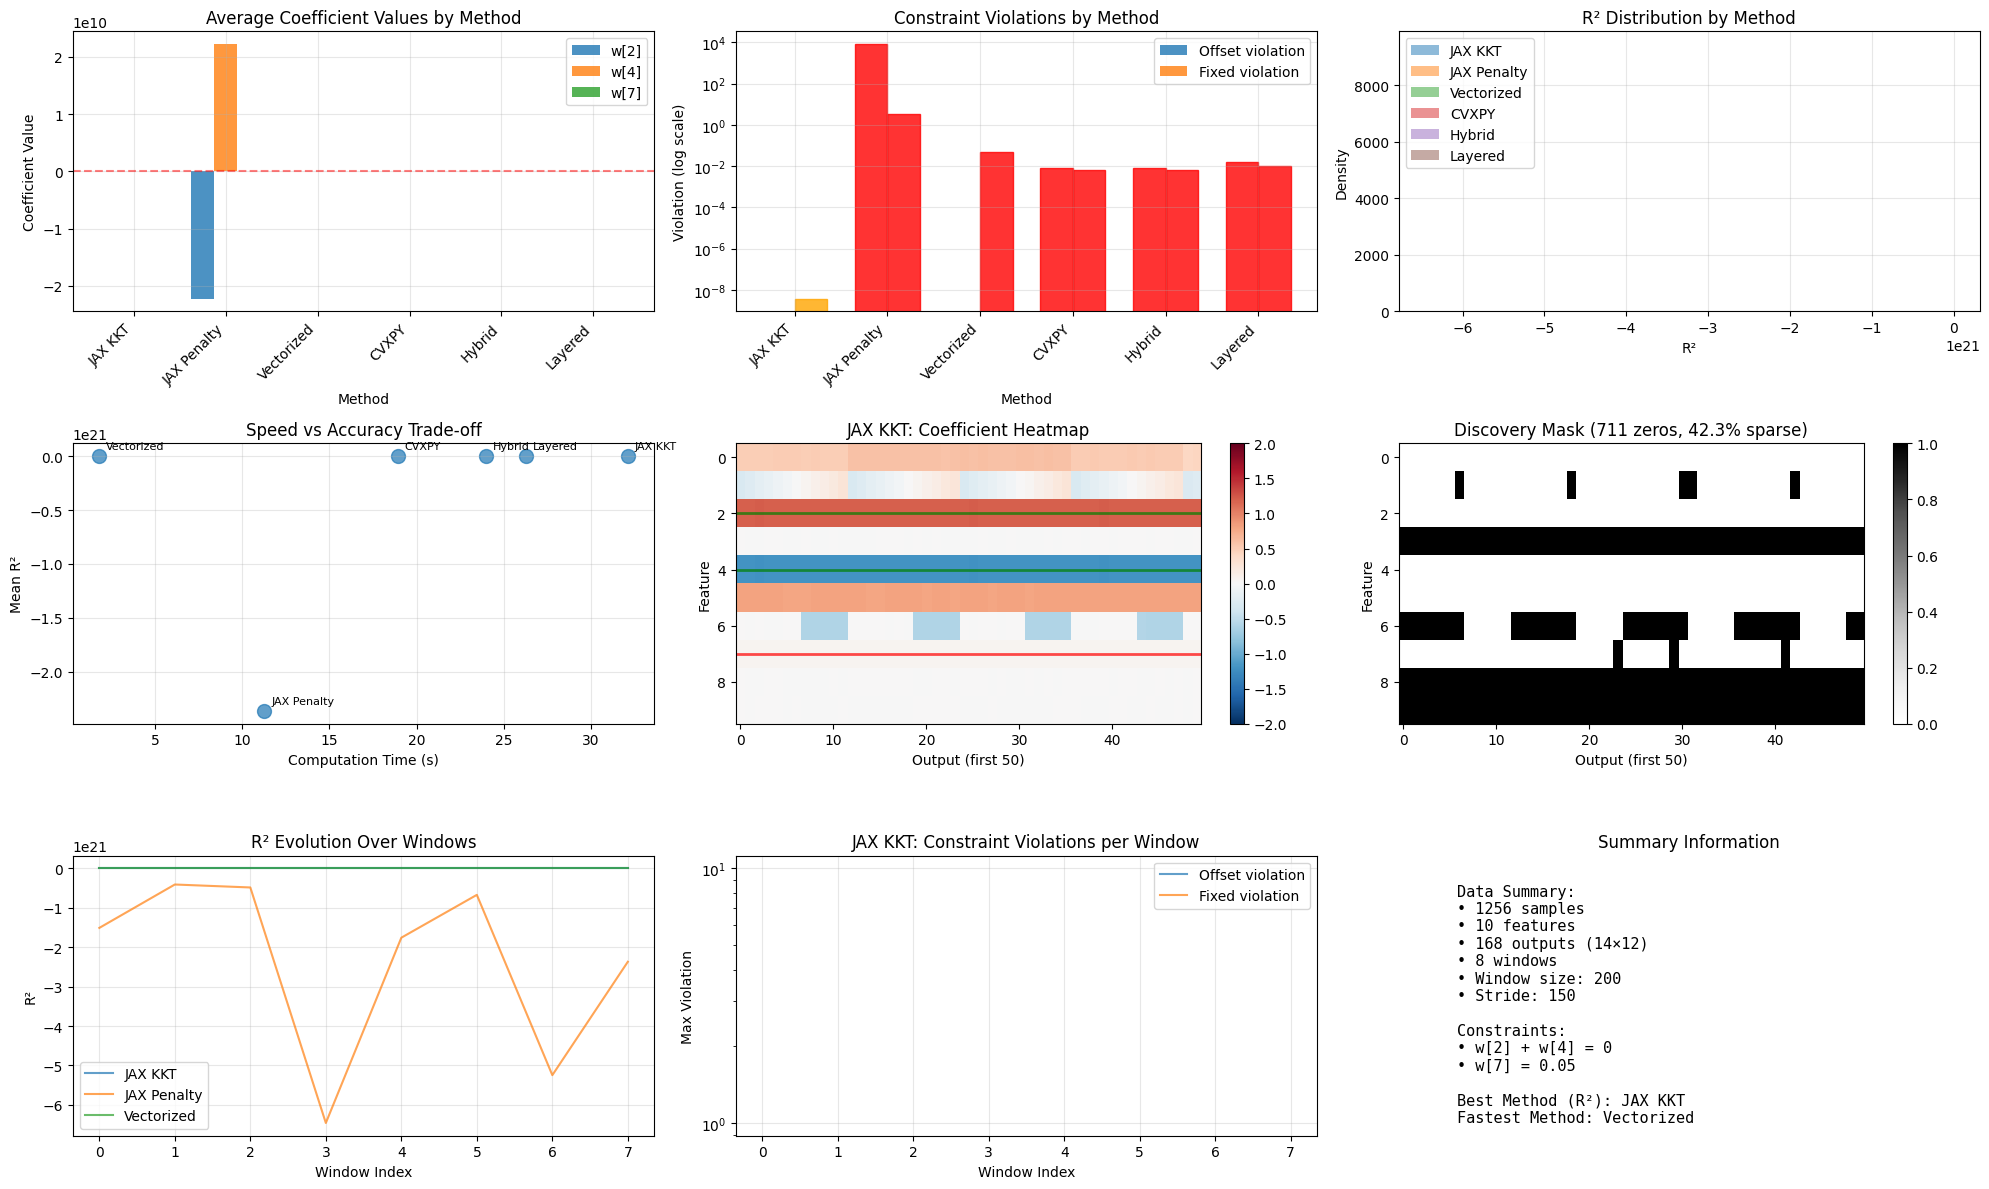

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings

# Import the unified regression function (assuming it's available)
# from unified_sliding_regression_extended import unified_sliding_regression_extended

# Check if CVXPY is available
try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    warnings.warn("CVXPY not available. Some methods will be skipped.")

def run_comprehensive_example():
    """
    Comprehensive example with:
    - 1256 rows (samples)
    - 14 countries
    - 12 tenors
    - 200-row windows with 150 stride
    - Constraints: w[2] = -w[4], w[7] = 0.05
    """

    print("="*80)
    print("UNIFIED SLIDING REGRESSION EXAMPLE - ALL METHODS")
    print("="*80)

    # ============= DATA GENERATION =============
    print("\n1. GENERATING DATA")
    print("-"*40)

    n_samples = 1256
    n_countries = 14
    n_tenors = 12
    n_outputs = n_countries * n_tenors  # 168 outputs
    n_features = 10  # Number of input features
    window_size = 200
    stride = 150

    print(f"Data dimensions:")
    print(f"  Samples: {n_samples}")
    print(f"  Features: {n_features}")
    print(f"  Outputs: {n_outputs} ({n_countries} countries × {n_tenors} tenors)")
    print(f"  Window size: {window_size}")
    print(f"  Stride: {stride}")

    # Calculate number of windows
    n_windows = (n_samples - window_size) // stride + 1
    print(f"  Number of windows: {n_windows}")

    # Generate synthetic data
    key = jax.random.PRNGKey(42)
    key_X, key_noise = jax.random.split(key)

    # Create input data
    X = jax.random.normal(key_X, (n_samples, n_features))

    # Create true coefficients with the specified constraints
    W_true = jnp.zeros((n_features, n_outputs))

    # Set some base patterns
    for j in range(n_outputs):
        country_idx = j // n_tenors
        tenor_idx = j % n_tenors

        # Basic patterns
        W_true = W_true.at[0, j].set(0.5 + 0.1 * np.sin(country_idx))
        W_true = W_true.at[1, j].set(-0.3 + 0.05 * tenor_idx)

        # Apply constraints:
        # w[2] = -w[4] (offsetting)
        W_true = W_true.at[2, j].set(1.2)
        W_true = W_true.at[4, j].set(-1.2)

        # w[7] = 0.05 (fixed value)
        W_true = W_true.at[7, j].set(0.05)

        # Some other patterns
        if country_idx < 7:
            W_true = W_true.at[5, j].set(0.8)
        if tenor_idx > 6:
            W_true = W_true.at[6, j].set(-0.6)

    # Generate output data
    noise_level = 0.1
    Y = X @ W_true + noise_level * jax.random.normal(key_noise, (n_samples, n_outputs))

    print(f"\nTrue coefficient statistics:")
    print(f"  w[2] mean: {jnp.mean(W_true[2, :]):.4f}")
    print(f"  w[4] mean: {jnp.mean(W_true[4, :]):.4f}")
    print(f"  w[7] mean: {jnp.mean(W_true[7, :]):.4f}")
    print(f"  w[2] + w[4] check: {jnp.max(jnp.abs(W_true[2, :] + W_true[4, :])):.2e}")

    # ============= CONSTRAINT CONFIGURATION =============
    print("\n2. CONSTRAINT CONFIGURATION")
    print("-"*40)

    # Define constraints
    offset_indices = (2, 4)  # w[2] + w[4] = 0
    fixed_constraints = [(7, 0.05)]  # w[7] = 0.05

    print(f"Constraints:")
    print(f"  Offset constraint: w[{offset_indices[0]}] + w[{offset_indices[1]}] = 0")
    print(f"  Fixed constraint: w[{fixed_constraints[0][0]}] = {fixed_constraints[0][1]}")

    # Discovery configuration
    discovery_config = {
        'enabled': True,
        'consistency_threshold': 0.85,
        'magnitude_threshold': 0.05,
        'relative_threshold': 0.1
    }

    # ============= RUN ALL METHODS =============
    print("\n3. RUNNING ALL METHODS")
    print("-"*40)

    all_results = {}

    # Method 1: JAX with KKT (Exact Constraints)
    print("\n[Method 1/6] JAX with KKT (Exact Constraints)")
    print("  This method uses Karush-Kuhn-Tucker conditions for exact constraint satisfaction")

    results_jax_kkt = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config=discovery_config,
        constraints_config={
            'method': 'exact',  # KKT method
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints
        }
    )
    all_results['JAX KKT'] = results_jax_kkt

    # Method 2: JAX with Penalty Method
    print("\n[Method 2/6] JAX with Penalty Method")
    print("  This method uses high penalties to enforce constraints approximately")

    results_jax_penalty = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config=discovery_config,
        constraints_config={
            'method': 'penalty',
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints,
            'zero_penalty': 1e12,
            'offset_penalty': 1e10,
            'fixed_penalty': 1e10
        }
    )
    all_results['JAX Penalty'] = results_jax_penalty

    # Method 3: Fully Vectorized
    print("\n[Method 3/6] Fully Vectorized Method")
    print("  This method processes all windows simultaneously for maximum speed")

    results_vectorized = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='vectorized',
        discovery_config=discovery_config,
        constraints_config={
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints
        }
    )
    all_results['Vectorized'] = results_vectorized

    # Method 4: CVXPY
    if CVXPY_AVAILABLE:
        print("\n[Method 4/6] CVXPY Method")
        print("  This method uses convex optimization with advanced constraint handling")

        results_cvxpy = unified_sliding_regression_extended(
            X, Y,
            window_size=window_size,
            stride=stride,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='cvxpy',
            discovery_config=discovery_config,
            constraints_config={
                'offset_indices': offset_indices,
                'fixed_constraints': fixed_constraints
            },
            cvxpy_config={
                'loss': 'squared',
                'post_zero_threshold': 1e-6
            }
        )
        all_results['CVXPY'] = results_cvxpy
    else:
        print("\n[Method 4/6] CVXPY - SKIPPED (not installed)")

    # Method 5: Hybrid (JAX Discovery + CVXPY Regression)
    if CVXPY_AVAILABLE:
        print("\n[Method 5/6] Hybrid Method (JAX Discovery + CVXPY Regression)")
        print("  This method combines JAX's fast discovery with CVXPY's flexible regression")

        results_hybrid = unified_sliding_regression_extended(
            X, Y,
            window_size=window_size,
            stride=stride,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='hybrid',
            discovery_config=discovery_config,
            constraints_config={
                'offset_indices': offset_indices,
                'fixed_constraints': fixed_constraints
            },
            cvxpy_config={
                'loss': 'huber',
                'huber_delta': 1.0
            }
        )
        all_results['Hybrid'] = results_hybrid
    else:
        print("\n[Method 5/6] Hybrid - SKIPPED (CVXPY not installed)")

    # Method 6: Layered Regression
    print("\n[Method 6/6] Layered Regression (3 layers)")
    print("  This method applies regression in multiple layers to capture complex patterns")

    results_layered = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        layers=[{}, {}, {}],  # 3 layers
        discovery_config=discovery_config,
        constraints_config={
            'method': 'exact',
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints
        }
    )
    all_results['Layered'] = results_layered

    # ============= RESULTS COMPARISON =============
    print("\n4. RESULTS COMPARISON")
    print("-"*40)

    # Create comparison table
    comparison_data = []
    for method_name, results in all_results.items():
        W_avg = results['W_avg']
        violations = results['violations']

        # Check constraint satisfaction
        offset_check = float(jnp.abs(W_avg[2, :] + W_avg[4, :]).max())
        fixed_check = float(jnp.abs(W_avg[7, :] - 0.05).max())

        # Get R² statistics
        if 'r2' in results and results['r2']:
            if len(results['r2']) == 1:
                r2_mean = float(jnp.mean(results['r2'][0]))
                r2_std = float(jnp.std(results['r2'][0]))
            else:
                # For layered regression, use last layer
                r2_mean = float(jnp.mean(results['r2'][-1]))
                r2_std = float(jnp.std(results['r2'][-1]))
        else:
            r2_mean = r2_std = 0.0

        comparison_data.append({
            'Method': method_name,
            'Time (s)': results['computation_time'],
            'Mean R²': r2_mean,
            'Std R²': r2_std,
            'w[2] mean': float(jnp.mean(W_avg[2, :])),
            'w[4] mean': float(jnp.mean(W_avg[4, :])),
            'w[7] mean': float(jnp.mean(W_avg[7, :])),
            'Offset Viol': offset_check,
            'Fixed Viol': fixed_check,
            'Zero Viol': violations.get('zero_max', 0)
        })

    # Display comparison
    import pandas as pd
    df = pd.DataFrame(comparison_data)

    print("\nMethod Comparison Table:")
    print(df.to_string(index=False, float_format='%.6f'))

    # Save comparison
    df.to_csv('method_comparison_comprehensive.csv', index=False)
    print("\nComparison saved to 'method_comparison_comprehensive.csv'")

    # ============= VISUALIZATION =============
    print("\n5. VISUALIZATION")
    print("-"*40)

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))

    # Plot 1: Coefficient values for each method
    ax1 = plt.subplot(3, 3, 1)
    method_names = list(all_results.keys())
    positions = np.arange(len(method_names))

    w2_values = [float(jnp.mean(all_results[m]['W_avg'][2, :])) for m in method_names]
    w4_values = [float(jnp.mean(all_results[m]['W_avg'][4, :])) for m in method_names]
    w7_values = [float(jnp.mean(all_results[m]['W_avg'][7, :])) for m in method_names]

    width = 0.25
    ax1.bar(positions - width, w2_values, width, label='w[2]', alpha=0.8)
    ax1.bar(positions, w4_values, width, label='w[4]', alpha=0.8)
    ax1.bar(positions + width, w7_values, width, label='w[7]', alpha=0.8)

    ax1.set_xlabel('Method')
    ax1.set_ylabel('Coefficient Value')
    ax1.set_title('Average Coefficient Values by Method')
    ax1.set_xticks(positions)
    ax1.set_xticklabels(method_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='w[7] target')

    # Plot 2: Constraint violations (log scale)
    ax2 = plt.subplot(3, 3, 2)
    offset_viols = [comparison_data[i]['Offset Viol'] for i in range(len(comparison_data))]
    fixed_viols = [comparison_data[i]['Fixed Viol'] for i in range(len(comparison_data))]

    x = np.arange(len(method_names))
    width = 0.35

    bars1 = ax2.bar(x - width/2, offset_viols, width, label='Offset violation', alpha=0.8)
    bars2 = ax2.bar(x + width/2, fixed_viols, width, label='Fixed violation', alpha=0.8)

    ax2.set_ylabel('Violation (log scale)')
    ax2.set_xlabel('Method')
    ax2.set_title('Constraint Violations by Method')
    ax2.set_xticks(x)
    ax2.set_xticklabels(method_names, rotation=45, ha='right')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Color bars based on violation level
    for bars in [bars1, bars2]:
        for bar, val in zip(bars, offset_viols if bars == bars1 else fixed_viols):
            if val > 1e-6:
                bar.set_color('red')
            elif val > 1e-10:
                bar.set_color('orange')
            else:
                bar.set_color('green')

    # Plot 3: R² distribution
    ax3 = plt.subplot(3, 3, 3)
    for method_name, results in all_results.items():
        if 'r2' in results and results['r2']:
            if len(results['r2']) == 1:
                r2_values = results['r2'][0]
            else:
                r2_values = results['r2'][-1]  # Last layer for layered

            ax3.hist(r2_values, bins=20, alpha=0.5, label=method_name, density=True)

    ax3.set_xlabel('R²')
    ax3.set_ylabel('Density')
    ax3.set_title('R² Distribution by Method')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Time vs R² scatter
    ax4 = plt.subplot(3, 3, 4)
    times = [comparison_data[i]['Time (s)'] for i in range(len(comparison_data))]
    r2_means = [comparison_data[i]['Mean R²'] for i in range(len(comparison_data))]

    ax4.scatter(times, r2_means, s=100, alpha=0.7)
    for i, method in enumerate(method_names):
        ax4.annotate(method, (times[i], r2_means[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax4.set_xlabel('Computation Time (s)')
    ax4.set_ylabel('Mean R²')
    ax4.set_title('Speed vs Accuracy Trade-off')
    ax4.grid(True, alpha=0.3)

    # Plot 5: Coefficient heatmap for one method (JAX KKT)
    ax5 = plt.subplot(3, 3, 5)
    W_avg = all_results['JAX KKT']['W_avg']

    # Show a subset of outputs for clarity
    n_show = min(50, n_outputs)
    im = ax5.imshow(W_avg[:, :n_show], aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    ax5.set_xlabel('Output (first 50)')
    ax5.set_ylabel('Feature')
    ax5.set_title('JAX KKT: Coefficient Heatmap')
    plt.colorbar(im, ax=ax5)

    # Add constraint indicators
    ax5.axhline(y=2, color='g', linewidth=2, alpha=0.7)
    ax5.axhline(y=4, color='g', linewidth=2, alpha=0.7)
    ax5.axhline(y=7, color='r', linewidth=2, alpha=0.7)

    # Plot 6: Discovery mask
    ax6 = plt.subplot(3, 3, 6)
    discovery_mask = all_results['JAX KKT'].get('discovery_mask', None)
    if discovery_mask is not None:
        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)

        im = ax6.imshow(discovery_mask[:, :n_show].astype(float),
                       aspect='auto', cmap='Greys', vmin=0, vmax=1)
        ax6.set_xlabel('Output (first 50)')
        ax6.set_ylabel('Feature')
        ax6.set_title(f'Discovery Mask ({n_zeros} zeros, {sparsity:.1f}% sparse)')
        plt.colorbar(im, ax=ax6)

    # Plot 7: R² over windows
    ax7 = plt.subplot(3, 3, 7)
    for method_name, results in list(all_results.items())[:3]:  # Show first 3 methods
        if 'r2' in results and results['r2']:
            if len(results['r2']) == 1:
                ax7.plot(results['r2'][0], label=method_name, alpha=0.7)

    ax7.set_xlabel('Window Index')
    ax7.set_ylabel('R²')
    ax7.set_title('R² Evolution Over Windows')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # Plot 8: Constraint satisfaction over windows (for JAX KKT)
    ax8 = plt.subplot(3, 3, 8)
    W_all = all_results['JAX KKT']['W_all']

    offset_viols_windows = []
    fixed_viols_windows = []

    for i in range(W_all.shape[0]):
        offset_viol = float(jnp.max(jnp.abs(W_all[i, 2, :] + W_all[i, 4, :])))
        fixed_viol = float(jnp.max(jnp.abs(W_all[i, 7, :] - 0.05)))
        offset_viols_windows.append(offset_viol)
        fixed_viols_windows.append(fixed_viol)

    ax8.semilogy(offset_viols_windows, label='Offset violation', alpha=0.7)
    ax8.semilogy(fixed_viols_windows, label='Fixed violation', alpha=0.7)
    ax8.set_xlabel('Window Index')
    ax8.set_ylabel('Max Violation')
    ax8.set_title('JAX KKT: Constraint Violations per Window')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # Plot 9: Summary statistics
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    summary_text = f"Data Summary:\n"
    summary_text += f"• {n_samples} samples\n"
    summary_text += f"• {n_features} features\n"
    summary_text += f"• {n_outputs} outputs ({n_countries}×{n_tenors})\n"
    summary_text += f"• {n_windows} windows\n"
    summary_text += f"• Window size: {window_size}\n"
    summary_text += f"• Stride: {stride}\n\n"
    summary_text += f"Constraints:\n"
    summary_text += f"• w[2] + w[4] = 0\n"
    summary_text += f"• w[7] = 0.05\n\n"
    summary_text += f"Best Method (R²): {method_names[np.argmax(r2_means)]}\n"
    summary_text += f"Fastest Method: {method_names[np.argmin(times)]}"

    ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
            verticalalignment='top', fontsize=11, family='monospace')
    ax9.set_title('Summary Information')

    plt.tight_layout()
    plt.savefig('comprehensive_method_comparison.png', dpi=150, bbox_inches='tight')
    print("\nVisualization saved to 'comprehensive_method_comparison.png'")

    # ============= DETAILED CONSTRAINT ANALYSIS =============
    print("\n6. DETAILED CONSTRAINT ANALYSIS")
    print("-"*40)

    for method_name, results in all_results.items():
        print(f"\n{method_name}:")
        W_avg = results['W_avg']

        # Offset constraint check
        offset_diffs = W_avg[2, :] + W_avg[4, :]
        print(f"  Offset constraint (w[2] + w[4] = 0):")
        print(f"    Max violation: {jnp.max(jnp.abs(offset_diffs)):.2e}")
        print(f"    Mean violation: {jnp.mean(jnp.abs(offset_diffs)):.2e}")
        print(f"    % outputs < 1e-10: {100 * jnp.sum(jnp.abs(offset_diffs) < 1e-10) / n_outputs:.1f}%")

        # Fixed constraint check
        fixed_diffs = W_avg[7, :] - 0.05
        print(f"  Fixed constraint (w[7] = 0.05):")
        print(f"    Max violation: {jnp.max(jnp.abs(fixed_diffs)):.2e}")
        print(f"    Mean violation: {jnp.mean(jnp.abs(fixed_diffs)):.2e}")
        print(f"    % outputs < 1e-10: {100 * jnp.sum(jnp.abs(fixed_diffs) < 1e-10) / n_outputs:.1f}%")

        # Estimation accuracy
        if 'W_true' in locals():
            rmse = float(jnp.sqrt(jnp.mean((W_avg - W_true)**2)))
            print(f"  RMSE vs true coefficients: {rmse:.6f}")

    # ============= RETURN RESULTS =============
    return {
        'all_results': all_results,
        'comparison_df': df,
        'data': {
            'X': X,
            'Y': Y,
            'W_true': W_true
        },
        'config': {
            'n_samples': n_samples,
            'n_features': n_features,
            'n_outputs': n_outputs,
            'n_countries': n_countries,
            'n_tenors': n_tenors,
            'window_size': window_size,
            'stride': stride,
            'n_windows': n_windows
        }
    }


# Run the comprehensive example
if __name__ == "__main__":
    print("Starting comprehensive unified sliding regression example...")
    print("This will test all methods with the specified constraints.")
    print()

    results = run_comprehensive_example()

    print("\n" + "="*80)
    print("EXAMPLE COMPLETED SUCCESSFULLY")
    print("="*80)
    print("\nOutputs generated:")
    print("  - method_comparison_comprehensive.csv")
    print("  - comprehensive_method_comparison.png")
    print("\nThe results show how each method handles the constraints:")
    print("  - w[2] = -w[4] (offsetting constraint)")
    print("  - w[7] = 0.05 (fixed value constraint)")
    print("\nCheck the visualization for detailed comparisons!")

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap

def apply_penalty_constraints_vectorized(X, Y, window_size, stride, discovery_mask=None,
                                       offset_indices=None, fixed_constraints=None,
                                       zero_penalty=1e12, offset_penalty=1e10,
                                       fixed_penalty=1e10, reg=1e-6):
    """
    Fully vectorized penalty method that processes all windows and outputs simultaneously.
    """
    # Create all windows at once
    n_samples = X.shape[0]
    n_features = X.shape[1]
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Create windows using advanced indexing
    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    X_wins = X[indices]  # Shape: (n_windows, window_size, n_features)
    Y_wins = Y[indices]  # Shape: (n_windows, window_size, n_outputs)

    # Compute X'X and X'Y for all windows at once
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)  # Shape: (n_windows, n_features, n_features)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)  # Shape: (n_windows, n_features, n_outputs)

    # Initialize base penalty matrix (same for all windows)
    I = jnp.eye(n_features)
    base_penalty = reg * I

    # === OFFSET CONSTRAINT PENALTY ===
    offset_penalty_matrix = jnp.zeros((n_features, n_features))
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            # Handle multiple offset constraints
            for idx1, idx2 in offset_indices:
                offset_matrix = jnp.zeros((n_features, n_features))
                offset_matrix = offset_matrix.at[idx1, idx1].add(offset_penalty)
                offset_matrix = offset_matrix.at[idx2, idx2].add(offset_penalty)
                offset_matrix = offset_matrix.at[idx1, idx2].add(offset_penalty)
                offset_matrix = offset_matrix.at[idx2, idx1].add(offset_penalty)
                offset_penalty_matrix = offset_penalty_matrix + offset_matrix
        else:
            idx1, idx2 = offset_indices
            offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx1].add(offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx2].add(offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx2].add(offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx1].add(offset_penalty)

    # === SOLVE FOR ALL OUTPUTS ===
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for j in range(n_outputs):
        # Build penalty matrix for this output
        penalty_matrix = base_penalty + offset_penalty_matrix

        # === ZERO CONSTRAINT PENALTY ===
        if discovery_mask is not None:
            zero_diag = jnp.where(discovery_mask[:, j], zero_penalty, 0.0)
            penalty_matrix = penalty_matrix + jnp.diag(zero_diag)

        # === FIXED VALUE CONSTRAINT ===
        XtY_j = XtY[:, :, j].copy()  # Shape: (n_windows, n_features)

        if fixed_constraints is not None:
            for fixed_idx, fixed_val in fixed_constraints:
                # Add penalty to diagonal
                penalty_matrix = penalty_matrix.at[fixed_idx, fixed_idx].add(fixed_penalty)
                # Modify linear term for all windows
                XtY_j = XtY_j.at[:, fixed_idx].add(fixed_penalty * fixed_val)

        # Add penalty matrix to all windows (broadcasting)
        XtX_pen = XtX + penalty_matrix[None, :, :]  # Shape: (n_windows, n_features, n_features)

        # Solve for all windows at once using vmap
        W_j = vmap(jnp.linalg.solve)(XtX_pen, XtY_j)  # Shape: (n_windows, n_features)
        W_all = W_all.at[:, :, j].set(W_j)

    return W_all


def apply_penalty_constraints_fully_vectorized(X, Y, window_size, stride, discovery_mask=None,
                                             offset_indices=None, fixed_constraints=None,
                                             zero_penalty=1e12, offset_penalty=1e10,
                                             fixed_penalty=1e10, reg=1e-6):
    """
    Even more vectorized version that builds all penalty matrices at once.
    This version is faster for large numbers of outputs.
    """
    # Create all windows at once
    n_samples = X.shape[0]
    n_features = X.shape[1]
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Create windows
    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    X_wins = X[indices]
    Y_wins = Y[indices]

    # Compute X'X and X'Y for all windows
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    # === BUILD PENALTY MATRICES FOR ALL OUTPUTS AT ONCE ===

    # Base regularization (same for all outputs)
    I = jnp.eye(n_features)
    base_penalty = reg * I

    # Offset penalty matrix (same for all outputs)
    offset_penalty_matrix = jnp.zeros((n_features, n_features))
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            offset_indices = offset_indices[0]
        idx1, idx2 = offset_indices
        offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx1].add(offset_penalty)
        offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx2].add(offset_penalty)
        offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx2].add(offset_penalty)
        offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx1].add(offset_penalty)

    # Fixed constraint penalty (same for all outputs)
    fixed_penalty_diag = jnp.zeros(n_features)
    fixed_linear_adjustment = jnp.zeros((n_features, n_outputs))

    if fixed_constraints is not None:
        for fixed_idx, fixed_val in fixed_constraints:
            fixed_penalty_diag = fixed_penalty_diag.at[fixed_idx].add(fixed_penalty)
            fixed_linear_adjustment = fixed_linear_adjustment.at[fixed_idx, :].add(fixed_penalty * fixed_val)

    # Zero constraint penalties (different for each output)
    if discovery_mask is not None:
        # Create diagonal penalties for all outputs
        zero_penalties = jnp.where(discovery_mask, zero_penalty, 0.0)  # Shape: (n_features, n_outputs)
    else:
        zero_penalties = jnp.zeros((n_features, n_outputs))

    # === VECTORIZED SOLVE ===
    # We'll solve for each output but in a more vectorized way

    # Prepare modified XtY with fixed value adjustments
    XtY_modified = XtY + fixed_linear_adjustment[None, :, :]  # Broadcast to all windows

    # Function to solve for one output
    def solve_output(j):
        # Build penalty matrix for this output
        penalty_matrix = base_penalty + offset_penalty_matrix
        penalty_matrix = penalty_matrix + jnp.diag(zero_penalties[:, j])
        penalty_matrix = penalty_matrix + jnp.diag(fixed_penalty_diag)

        # Add to all windows
        XtX_pen = XtX + penalty_matrix[None, :, :]

        # Solve for all windows
        return vmap(jnp.linalg.solve)(XtX_pen, XtY_modified[:, :, j])

    # Vectorize over outputs
    W_all = vmap(solve_output, in_axes=0, out_axes=2)(jnp.arange(n_outputs))

    return W_all


def test_penalty_methods():
    """Test the vectorized penalty methods."""
    # Generate test data
    n_samples = 500
    n_features = 10
    n_outputs = 50
    window_size = 200
    stride = 50

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_features))
    Y = jax.random.normal(key, (n_samples, n_outputs))

    # Test constraints
    offset_indices = (2, 4)
    fixed_constraints = [(7, 0.05)]

    # Create a simple discovery mask
    discovery_mask = jnp.zeros((n_features, n_outputs), dtype=bool)
    discovery_mask = discovery_mask.at[8:10, :].set(True)

    print("Testing vectorized penalty methods...")

    # Test method 1
    import time
    start = time.time()
    W1 = apply_penalty_constraints_vectorized(
        X, Y, window_size, stride,
        discovery_mask=discovery_mask,
        offset_indices=offset_indices,
        fixed_constraints=fixed_constraints,
        zero_penalty=1e12,
        offset_penalty=1e10,
        fixed_penalty=1e10
    )
    time1 = time.time() - start

    # Test method 2
    start = time.time()
    W2 = apply_penalty_constraints_fully_vectorized(
        X, Y, window_size, stride,
        discovery_mask=discovery_mask,
        offset_indices=offset_indices,
        fixed_constraints=fixed_constraints,
        zero_penalty=1e12,
        offset_penalty=1e10,
        fixed_penalty=1e10
    )
    time2 = time.time() - start

    print(f"Method 1 time: {time1:.3f}s")
    print(f"Method 2 time: {time2:.3f}s")

    # Check results
    W_avg1 = jnp.mean(W1, axis=0)
    W_avg2 = jnp.mean(W2, axis=0)

    print(f"\nConstraint satisfaction (Method 1):")
    print(f"  Offset violation: {jnp.max(jnp.abs(W_avg1[2, :] + W_avg1[4, :])):.2e}")
    print(f"  Fixed violation: {jnp.max(jnp.abs(W_avg1[7, :] - 0.05)):.2e}")
    print(f"  Zero violation: {jnp.max(jnp.abs(W_avg1[8:10, :] * discovery_mask[8:10, :])):.2e}")

    print(f"\nConstraint satisfaction (Method 2):")
    print(f"  Offset violation: {jnp.max(jnp.abs(W_avg2[2, :] + W_avg2[4, :])):.2e}")
    print(f"  Fixed violation: {jnp.max(jnp.abs(W_avg2[7, :] - 0.05)):.2e}")
    print(f"  Zero violation: {jnp.max(jnp.abs(W_avg2[8:10, :] * discovery_mask[8:10, :])):.2e}")

    print(f"\nDifference between methods: {jnp.max(jnp.abs(W1 - W2)):.2e}")

    return W1, W2


# Integration with the main unified regression function
def apply_penalty_constraints(X, Y, window_size, stride, discovery_mask=None,
                            offset_indices=None, fixed_constraints=None,
                            zero_penalty=1e12, offset_penalty=1e10, fixed_penalty=1e10):
    """
    Wrapper function to use in unified_sliding_regression_extended.
    This replaces the broken penalty method.
    """
    return apply_penalty_constraints_vectorized(
        X, Y, window_size, stride,
        discovery_mask=discovery_mask,
        offset_indices=offset_indices,
        fixed_constraints=fixed_constraints,
        zero_penalty=zero_penalty,
        offset_penalty=offset_penalty,
        fixed_penalty=fixed_penalty,
        reg=1e-6
    )


if __name__ == "__main__":
    print("Testing vectorized penalty methods...")
    W1, W2 = test_penalty_methods()
    print("\nTests completed!")

Testing vectorized penalty methods...
Testing vectorized penalty methods...
Method 1 time: 1.644s
Method 2 time: 2.667s

Constraint satisfaction (Method 1):
  Offset violation: 3.81e-06
  Fixed violation: 3.73e-08
  Zero violation: 1.23e-09

Constraint satisfaction (Method 2):
  Offset violation: 1.91e-06
  Fixed violation: 3.73e-08
  Zero violation: 1.23e-09

Difference between methods: 4.58e-05

Tests completed!


Starting comprehensive unified sliding regression example...
This will test all methods with the specified constraints.

UNIFIED SLIDING REGRESSION EXAMPLE - ALL METHODS

1. GENERATING DATA
----------------------------------------
Data dimensions:
  Samples: 1256
  Features: 10
  Outputs: 168 (14 countries × 12 tenors)
  Window size: 200
  Stride: 150
  Number of windows: 8

True coefficient statistics:
  w[2] mean: 1.2000
  w[4] mean: -1.2000
  w[7] mean: 0.0500
  w[2] + w[4] check: 0.00e+00

2. CONSTRAINT CONFIGURATION
----------------------------------------
Constraints:
  Offset constraint: w[2] + w[4] = 0
  Fixed constraint: w[7] = 0.05

3. RUNNING ALL METHODS
----------------------------------------

[Method 1/6] JAX with KKT (Exact Constraints)
  This method uses Karush-Kuhn-Tucker conditions for exact constraint satisfaction

Unified Sliding Regression Extended
  Method: jax
  Data: 1256 samples, 10 features, 168 outputs
  Windows: 8 (size 200, stride 150)

Phase 1: Discovering

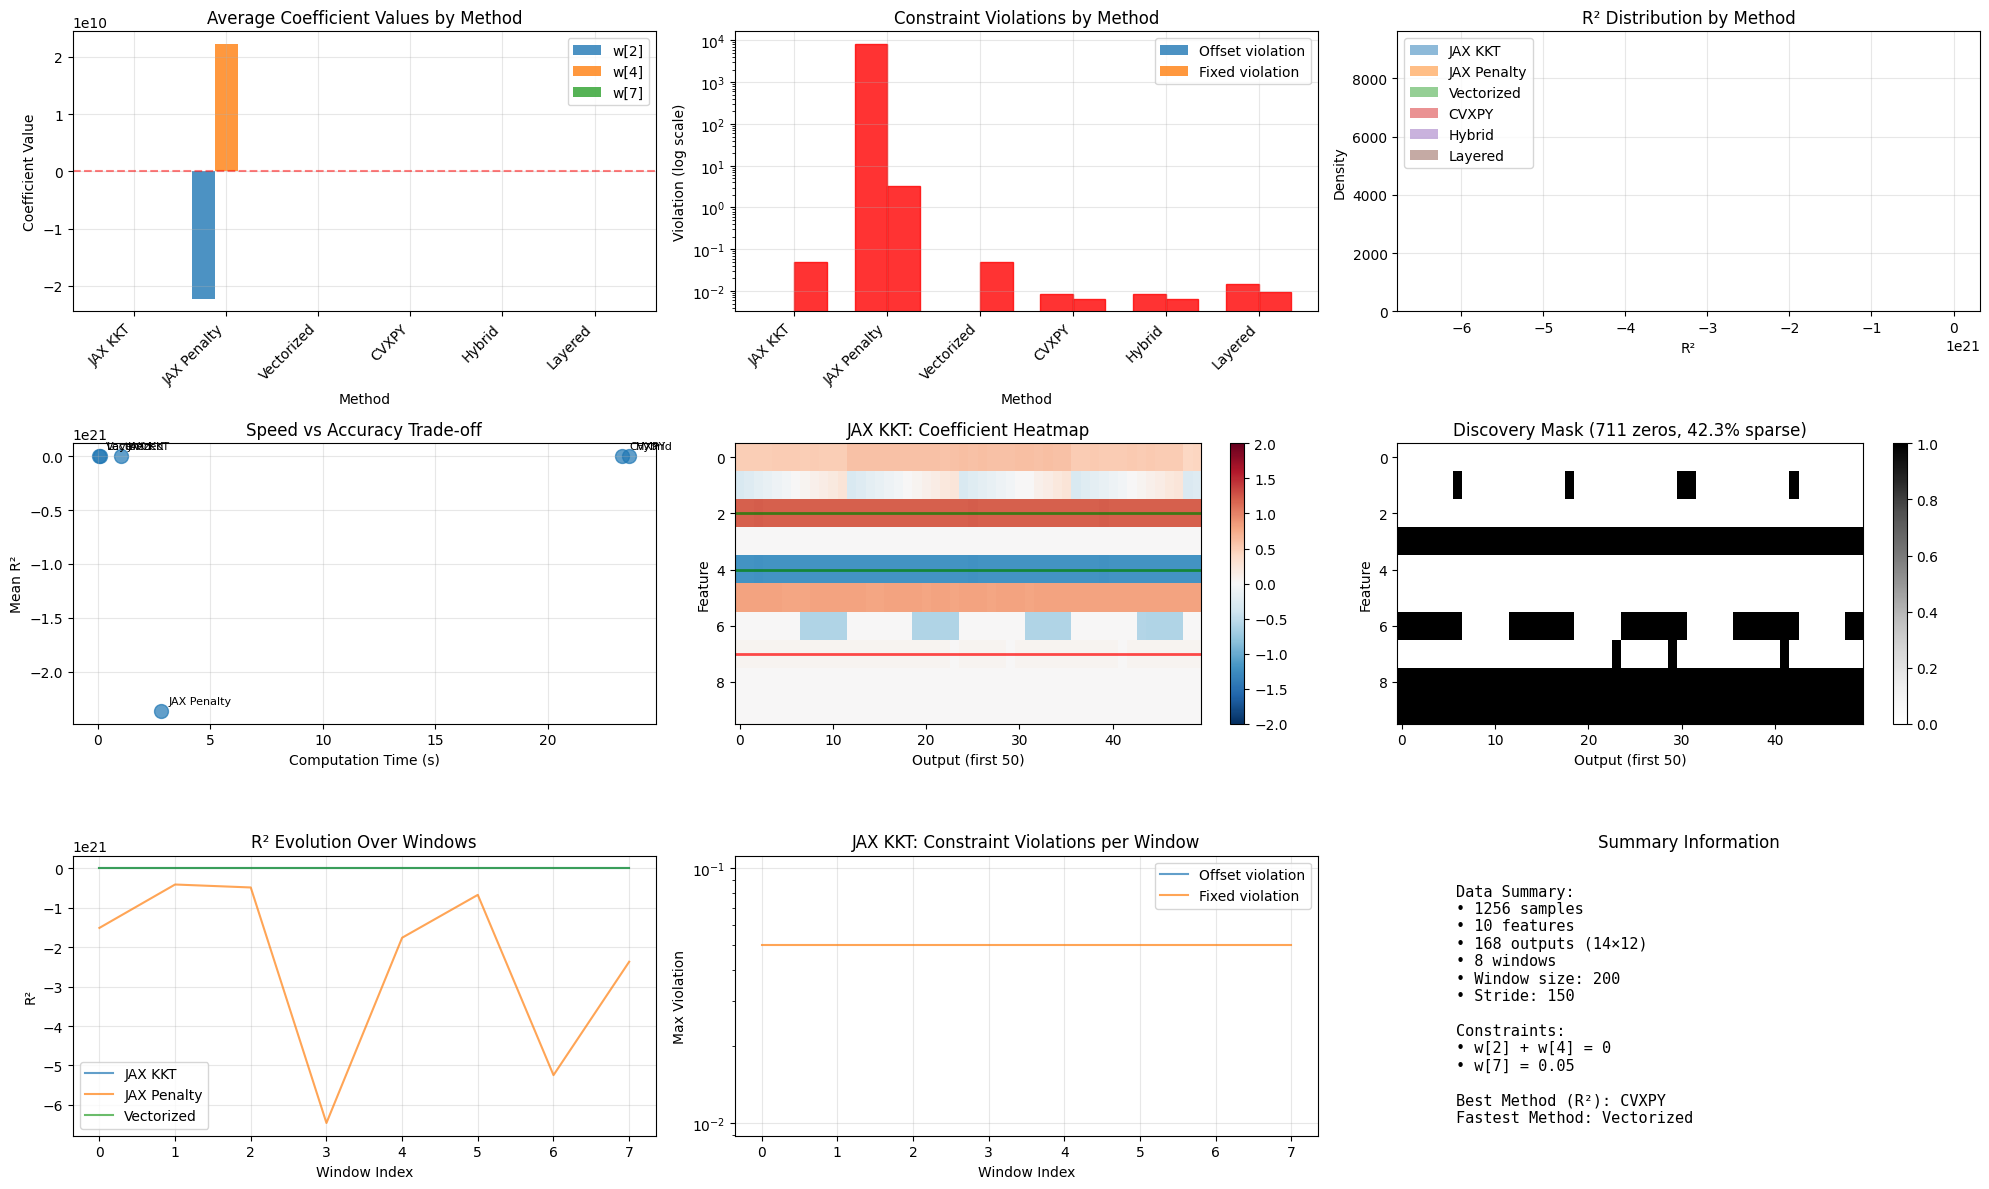

In [5]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap, jit
from functools import partial
import matplotlib.pyplot as plt
import time
import warnings
import pandas as pd

try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    warnings.warn("CVXPY not available. Some methods will be disabled.")


def unified_sliding_regression_extended(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    n_countries: int,
    n_tenors: int,
    method: str = 'jax',  # 'jax', 'cvxpy', 'vectorized', 'hybrid'
    layers: list = None,  # For multi-layer regression
    discovery_config: dict = None,
    constraints_config: dict = None,
    cvxpy_config: dict = None
) -> dict:
    """
    Extended unified sliding window regression supporting all methods.

    Args:
        X: Input data (n_samples, n_features)
        Y: Output data (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Stride for sliding window
        n_countries: Number of countries (for reshaping)
        n_tenors: Number of tenors (for reshaping)
        method:
            - 'jax': JAX-based with KKT/penalty methods
            - 'cvxpy': CVXPY for advanced constraints
            - 'vectorized': Fully vectorized operations
            - 'hybrid': JAX discovery + CVXPY regression
        layers: List of layer configs for multi-layer regression
        discovery_config: Configuration for zero discovery
            - 'enabled': Whether to use discovery (default: True)
            - 'consistency_threshold': Threshold for consistency (default: 0.9)
            - 'magnitude_threshold': Absolute magnitude threshold (default: 0.05)
            - 'relative_threshold': Relative magnitude threshold (default: 0.1)
            - 'forced_mask': Pre-specified zero mask
        constraints_config: Configuration for constraints
            - 'method': 'exact' (KKT) or 'penalty' for JAX method
            - 'offset_indices': Tuple (idx1, idx2) or list of tuples
            - 'fixed_constraints': List of (index, value) tuples
            - 'positive_constraints': List of indices that must be >= 0
            - 'negative_constraints': List of indices that must be <= 0
            - 'zero_penalty': Penalty strength for zero constraints
            - 'offset_penalty': Penalty strength for offset constraints
            - 'fixed_penalty': Penalty strength for fixed value constraints
        cvxpy_config: Additional configuration for CVXPY solver
            - 'loss': 'squared' or 'huber'
            - 'delta': Huber loss parameter
            - 'transaction_costs': Cost vector for L1 penalty
            - 'tc_lambda': Transaction cost penalty weight
            - 'dv01_neutral': Whether to enforce sum of coefficients = 1
            - 'post_zero_threshold': Zero out small coefficients after solving

    Returns:
        Dictionary with results including:
            - 'W_all': All window coefficients
            - 'W_avg': Average coefficients
            - 'W_layers': Layer coefficients (if layered)
            - 'r2': R² values
            - 'discovery_mask': Discovered zero pattern
            - 'violations': Constraint violations
            - 'method_used': Actual method used
            - 'computation_time': Time taken
    """

    start_time = time.time()

    # Input validation and setup
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Default configurations
    if discovery_config is None:
        discovery_config = {}
    if constraints_config is None:
        constraints_config = {}
    if cvxpy_config is None:
        cvxpy_config = {}

    # Print setup information
    print(f"\nUnified Sliding Regression Extended")
    print(f"  Method: {method}")
    print(f"  Data: {n_samples} samples, {n_features} features, {n_outputs} outputs")
    print(f"  Windows: {n_windows} (size {window_size}, stride {stride})")
    if layers:
        print(f"  Layers: {len(layers)}")

    # Check method availability
    if method == 'cvxpy' and not CVXPY_AVAILABLE:
        warnings.warn("CVXPY not available, falling back to JAX method")
        method = 'jax'

    # ========== PHASE 1: DISCOVERY ==========
    use_discovery = discovery_config.get('enabled', True)
    discovery_mask = None
    discovery_stats = {}

    if use_discovery:
        print("\nPhase 1: Discovering zero patterns...")

        # Create windows for discovery
        X_wins = create_windows_vectorized(X, window_size, stride)
        Y_wins = create_windows_vectorized(Y, window_size, stride)

        # Run discovery
        discovery_mask, discovery_stats = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=discovery_config.get('consistency_threshold', 0.9),
            magnitude_threshold=discovery_config.get('magnitude_threshold', 0.05),
            relative_threshold=discovery_config.get('relative_threshold', 0.1)
        )

        # Apply forced mask if provided
        forced_mask = discovery_config.get('forced_mask', None)
        if forced_mask is not None:
            discovery_mask = discovery_mask | forced_mask

        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)
        print(f"  Discovered {n_zeros} zeros ({sparsity:.1f}% sparsity)")

    # ========== PHASE 2: REGRESSION ==========
    print(f"\nPhase 2: Applying {method} regression...")

    # Extract constraint parameters
    constraint_method = constraints_config.get('method', 'exact')
    offset_indices = constraints_config.get('offset_indices', None)
    fixed_constraints = constraints_config.get('fixed_constraints', None)
    positive_constraints = constraints_config.get('positive_constraints', None)
    negative_constraints = constraints_config.get('negative_constraints', None)

    # Handle layers
    if layers is not None and len(layers) > 0:
        results = apply_layered_regression(
            X, Y, window_size, stride, n_layers=len(layers),
            method=method, discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            cvxpy_config=cvxpy_config
        )
    else:
        # Single layer regression
        if method == 'jax':
            results = apply_jax_regression(
                X, Y, window_size, stride,
                constraint_method=constraint_method,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'vectorized':
            results = apply_vectorized_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'cvxpy':
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )

        elif method == 'hybrid':
            # Use JAX for discovery (already done) and CVXPY for regression
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )
            results['method_used'] = 'hybrid'

        else:
            raise ValueError(f"Unknown method: {method}")

    # ========== POST-PROCESSING ==========

    # Add discovery results
    results['discovery_mask'] = discovery_mask
    results['discovery_stats'] = discovery_stats
    if discovery_mask is not None:
        results['discovery_mask_3d'] = discovery_mask.T.reshape(n_countries, n_tenors, n_features)

    # Check constraint violations
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    violations = check_all_constraints(
        W_avg, discovery_mask, offset_indices,
        fixed_constraints, positive_constraints, negative_constraints
    )
    results['violations'] = violations

    # Add configuration info
    results['config'] = {
        'window_size': window_size,
        'stride': stride,
        'n_windows': n_windows,
        'method': method,
        'constraint_method': constraint_method,
        'discovery_config': discovery_config,
        'constraints_config': constraints_config,
        'cvxpy_config': cvxpy_config
    }

    # Computation time
    computation_time = time.time() - start_time
    results['computation_time'] = computation_time

    print(f"\nCompleted in {computation_time:.3f} seconds")
    print_summary(results)

    return results


# ============= HELPER FUNCTIONS =============

def create_windows_vectorized(data, window_size, stride):
    """Create all windows at once using advanced indexing."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    return jnp.array(data[indices])


def solve_ols(X, Y, reg=1e-6):
    """Basic OLS solver."""
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX + reg * jnp.eye(X.shape[1]), XtY)


def discover_zero_patterns_unified(X_wins, Y_wins, consistency_threshold=0.9,
                                  magnitude_threshold=0.05, relative_threshold=0.1):
    """Unified discovery function - fully vectorized."""
    # Solve unconstrained for all windows using vmap
    def solve_window(X_win, Y_win):
        return solve_ols(X_win, Y_win)

    W_all = vmap(solve_window)(X_wins, Y_wins)

    # Analyze patterns
    W_abs = jnp.abs(W_all)
    W_abs_mean = jnp.mean(W_abs, axis=0)
    W_std = jnp.std(W_all, axis=0)

    # Discovery criteria
    small_mask = W_abs_mean < magnitude_threshold

    # Relative threshold
    max_per_output = jnp.max(W_abs_mean, axis=0, keepdims=True)
    relative_mask = W_abs_mean < (relative_threshold * max_per_output)

    # Combine criteria
    candidate_mask = small_mask | relative_mask

    # Check consistency
    n_windows = W_all.shape[0]
    small_counts = jnp.sum(W_abs < magnitude_threshold, axis=0)
    consistency = small_counts / n_windows

    # Final mask
    discovery_mask = candidate_mask & (consistency > consistency_threshold)

    stats = {
        'W_mean': W_abs_mean,
        'W_std': W_std,
        'consistency': consistency,
        'n_zeros': jnp.sum(discovery_mask),
        'sparsity': jnp.mean(discovery_mask)
    }

    return discovery_mask, stats


# ============= JAX REGRESSION =============

def apply_jax_regression(X, Y, window_size, stride, constraint_method='exact',
                        discovery_mask=None, offset_indices=None,
                        fixed_constraints=None, constraints_config=None):
    """Apply regression using JAX methods."""

    if constraint_method == 'exact':
        W_all = apply_kkt_constraints_vectorized(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints
        )
    else:  # penalty
        W_all = apply_penalty_constraints_vectorized(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints,
            zero_penalty=constraints_config.get('zero_penalty', 1e12),
            offset_penalty=constraints_config.get('offset_penalty', 1e10),
            fixed_penalty=constraints_config.get('fixed_penalty', 1e10)
        )

    # Compute R²
    W_avg = jnp.mean(W_all, axis=0)
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Vectorized R² computation
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2_values = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': W_avg,
        'r2': [r2_values],
        'method_used': f'jax_{constraint_method}'
    }


# ============= KKT CONSTRAINTS (VECTORIZED) =============

def apply_kkt_constraints_vectorized(X, Y, window_size, stride, discovery_mask=None,
                                   offset_indices=None, fixed_constraints=None):
    """Apply constraints using KKT (exact) method - fully vectorized."""
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    n_windows = X_wins.shape[0]
    n_features = X.shape[1]
    n_outputs = Y.shape[1]

    # Apply constraints based on what's provided
    if fixed_constraints and offset_indices:
        W_all = apply_all_constraints_kkt_vectorized(
            X_wins, Y_wins, fixed_constraints[0], offset_indices, discovery_mask
        )
    elif fixed_constraints:
        W_all = apply_fixed_kkt_vectorized(X_wins, Y_wins, fixed_constraints[0], discovery_mask)
    elif offset_indices:
        W_all = apply_offset_kkt_vectorized(X_wins, Y_wins, offset_indices, discovery_mask)
    else:
        W_all = solve_with_zeros_vectorized(X_wins, Y_wins, discovery_mask)

    return W_all


def apply_offset_kkt_vectorized(X_wins, Y_wins, offset_indices, zero_mask=None):
    """Apply offset constraint using KKT - vectorized."""
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Create reduced system by eliminating idx2
    keep_mask = np.ones(n_features, dtype=bool)
    keep_mask[idx2] = False
    keep_indices = np.where(keep_mask)[0]

    X_reduced = X_wins[:, :, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = np.sum(keep_indices < idx1)

    # Adjust for constraint: replace column idx1 with (col_idx1 - col_idx2)
    X_reduced = X_reduced.at[:, :, idx1_new].set(
        X_wins[:, :, idx1] - X_wins[:, :, idx2]
    )

    # Solve reduced system
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_wins, None)

    # Apply zero constraints if needed
    if zero_mask is not None:
        # Apply penalties to enforce zeros in reduced space
        for j in range(n_outputs):
            reduced_zero_mask = zero_mask[keep_indices, j]
            if jnp.any(reduced_zero_mask):
                penalty_diag = jnp.where(reduced_zero_mask, 1e12, 0.0)
                XtX = jnp.einsum('wij,wik->wjk', X_reduced, X_reduced)
                XtY = jnp.einsum('wij,wi->wj', X_reduced, Y_wins[:, :, j])
                XtX_pen = XtX + jnp.diag(penalty_diag)[None, :, :] + 1e-6 * jnp.eye(len(keep_indices))[None, :, :]
                W_j = vmap(jnp.linalg.solve)(XtX_pen, XtY)
                W_reduced = W_reduced.at[:, :, j].set(W_j)

    # Reconstruct full solution
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for i, orig_idx in enumerate(keep_indices):
        W_all = W_all.at[:, orig_idx, :].set(W_reduced[:, i, :])

    # Set w[idx2] = -w[idx1]
    W_all = W_all.at[:, idx2, :].set(-W_reduced[:, idx1_new, :])

    return W_all


def apply_fixed_kkt_vectorized(X_wins, Y_wins, fixed_constraint, zero_mask=None):
    """Apply fixed value constraint using KKT - vectorized."""
    fixed_idx, fixed_val = fixed_constraint

    # Adjust Y
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    n_features = X_wins.shape[2]
    mask = np.ones(n_features, dtype=bool)
    mask[fixed_idx] = False
    X_reduced = X_wins[:, :, mask]

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_adjusted,
                                                    zero_mask[:, mask] if zero_mask is not None else None)

    # Reconstruct
    n_windows = X_wins.shape[0]
    n_outputs = Y_wins.shape[2]
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_reduced[:, j, :])
            j += 1

    return W_all


def apply_all_constraints_kkt_vectorized(X_wins, Y_wins, fixed_constraint,
                                       offset_indices, zero_mask=None):
    """Apply all constraints using KKT - vectorized."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    mask1 = np.ones(n_features, dtype=bool)
    mask1[fixed_idx] = False
    X_red1 = X_wins[:, :, mask1]

    # Adjust indices
    idx1_red = idx1 - (1 if fixed_idx < idx1 else 0)
    idx2_red = idx2 - (1 if fixed_idx < idx2 else 0)

    # Handle different cases
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    if idx1 == fixed_idx:
        # w[idx2] = -fixed_val
        W_red1 = solve_all_windows_outputs_vectorized(X_red1, Y_adjusted, None)
        j = 0
        for i in range(n_features):
            if i == fixed_idx:
                W_all = W_all.at[:, i, :].set(fixed_val)
            elif i == idx2:
                W_all = W_all.at[:, i, :].set(-fixed_val)
            else:
                W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
                j += 1

    elif idx2 == fixed_idx:
        # w[idx1] = -fixed_val
        W_red1 = solve_all_windows_outputs_vectorized(X_red1, Y_adjusted, None)
        j = 0
        for i in range(n_features):
            if i == fixed_idx:
                W_all = W_all.at[:, i, :].set(fixed_val)
            elif i == idx1:
                W_all = W_all.at[:, i, :].set(-fixed_val)
            else:
                W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
                j += 1

    else:
        # Both constraints active, need second reduction
        mask2 = np.ones(n_features - 1, dtype=bool)
        mask2[idx2_red] = False
        X_red2 = X_red1[:, :, mask2]

        idx1_red2 = idx1_red - (1 if idx2_red < idx1_red else 0)

        X_red2 = X_red2.at[:, :, idx1_red2].set(
            X_red1[:, :, idx1_red] - X_red1[:, :, idx2_red]
        )

        # Solve
        W_red2 = solve_all_windows_outputs_vectorized(X_red2, Y_adjusted, None)

        # Reconstruct to singly-reduced
        W_red1 = jnp.zeros((n_windows, n_features - 1, n_outputs))
        j = 0
        for i in range(n_features - 1):
            if i == idx2_red:
                W_red1 = W_red1.at[:, i, :].set(-W_red2[:, idx1_red2, :])
            else:
                W_red1 = W_red1.at[:, i, :].set(W_red2[:, j, :])
                j += 1

        # Final reconstruction
        j = 0
        for i in range(n_features):
            if i == fixed_idx:
                W_all = W_all.at[:, i, :].set(fixed_val)
            else:
                W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
                j += 1

    # Apply zero constraints if needed
    if zero_mask is not None:
        # Post-process to enforce zeros (approximate)
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def solve_with_zeros_vectorized(X_wins, Y_wins, zero_mask):
    """Solve with only zero constraints - vectorized."""
    if zero_mask is None:
        return solve_all_windows_outputs_vectorized(X_wins, Y_wins, None)

    n_windows = X_wins.shape[0]
    n_features = X_wins.shape[2]
    n_outputs = Y_wins.shape[2]
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    # Compute X'X and X'Y for all windows
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    for j in range(n_outputs):
        penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
        penalty_matrix = jnp.diag(penalty_diag) + 1e-6 * jnp.eye(n_features)
        XtX_pen = XtX + penalty_matrix[None, :, :]
        W_j = vmap(jnp.linalg.solve)(XtX_pen, XtY[:, :, j])
        W_all = W_all.at[:, :, j].set(W_j)

    return W_all


# ============= PENALTY METHOD (VECTORIZED) =============

def apply_penalty_constraints_vectorized(X, Y, window_size, stride, discovery_mask=None,
                                       offset_indices=None, fixed_constraints=None,
                                       zero_penalty=1e12, offset_penalty=1e10,
                                       fixed_penalty=1e10, reg=1e-6):
    """
    Fully vectorized penalty method that processes all windows and outputs simultaneously.
    """
    # Create all windows at once
    n_samples = X.shape[0]
    n_features = X.shape[1]
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Create windows using advanced indexing
    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    X_wins = X[indices]  # Shape: (n_windows, window_size, n_features)
    Y_wins = Y[indices]  # Shape: (n_windows, window_size, n_outputs)

    # Compute X'X and X'Y for all windows at once
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)  # Shape: (n_windows, n_features, n_features)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)  # Shape: (n_windows, n_features, n_outputs)

    # Initialize base penalty matrix (same for all windows)
    I = jnp.eye(n_features)
    base_penalty = reg * I

    # === OFFSET CONSTRAINT PENALTY ===
    offset_penalty_matrix = jnp.zeros((n_features, n_features))
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            # Handle multiple offset constraints
            for idx1, idx2 in offset_indices:
                offset_matrix = jnp.zeros((n_features, n_features))
                offset_matrix = offset_matrix.at[idx1, idx1].add(offset_penalty)
                offset_matrix = offset_matrix.at[idx2, idx2].add(offset_penalty)
                offset_matrix = offset_matrix.at[idx1, idx2].add(offset_penalty)
                offset_matrix = offset_matrix.at[idx2, idx1].add(offset_penalty)
                offset_penalty_matrix = offset_penalty_matrix + offset_matrix
        else:
            idx1, idx2 = offset_indices
            offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx1].add(offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx2].add(offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx2].add(offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx1].add(offset_penalty)

    # === SOLVE FOR ALL OUTPUTS ===
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for j in range(n_outputs):
        # Build penalty matrix for this output
        penalty_matrix = base_penalty + offset_penalty_matrix

        # === ZERO CONSTRAINT PENALTY ===
        if discovery_mask is not None:
            zero_diag = jnp.where(discovery_mask[:, j], zero_penalty, 0.0)
            penalty_matrix = penalty_matrix + jnp.diag(zero_diag)

        # === FIXED VALUE CONSTRAINT ===
        XtY_j = XtY[:, :, j].copy()  # Shape: (n_windows, n_features)

        if fixed_constraints is not None:
            for fixed_idx, fixed_val in fixed_constraints:
                # Add penalty to diagonal
                penalty_matrix = penalty_matrix.at[fixed_idx, fixed_idx].add(fixed_penalty)
                # Modify linear term for all windows
                XtY_j = XtY_j.at[:, fixed_idx].add(fixed_penalty * fixed_val)

        # Add penalty matrix to all windows (broadcasting)
        XtX_pen = XtX + penalty_matrix[None, :, :]  # Shape: (n_windows, n_features, n_features)

        # Solve for all windows at once using vmap
        W_j = vmap(jnp.linalg.solve)(XtX_pen, XtY_j)  # Shape: (n_windows, n_features)
        W_all = W_all.at[:, :, j].set(W_j)

    return W_all


# ============= VECTORIZED REGRESSION =============

def apply_vectorized_regression(X, Y, window_size, stride, discovery_mask=None,
                              offset_indices=None, fixed_constraints=None,
                              constraints_config=None):
    """Apply fully vectorized regression."""
    # Create all windows at once
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Apply constraints
    if fixed_constraints and offset_indices:
        W_all = apply_all_constraints_vectorized(
            X_wins, Y_wins,
            fixed_constraints[0], offset_indices,
            discovery_mask
        )
    elif offset_indices:
        W_all = apply_offset_vectorized(X_wins, Y_wins, offset_indices, discovery_mask)
    elif fixed_constraints:
        W_all = apply_fixed_vectorized(X_wins, Y_wins, fixed_constraints[0], discovery_mask)
    else:
        W_all = solve_all_windows_outputs_vectorized(X_wins, Y_wins, discovery_mask)

    # Compute R²
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': 'vectorized'
    }


def solve_all_windows_outputs_vectorized(X_wins, Y_wins, zero_mask=None, reg=1e-6):
    """Vectorized OLS for all windows and outputs."""
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    n_features = X_wins.shape[2]
    I = jnp.eye(n_features)
    XtX_reg = XtX + reg * I[None, :, :]

    if zero_mask is not None:
        # Apply zero constraints
        n_windows = X_wins.shape[0]
        n_outputs = Y_wins.shape[2]
        W_all = jnp.zeros((n_windows, n_features, n_outputs))

        for j in range(n_outputs):
            penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
            penalty_matrix = jnp.diag(penalty_diag)
            XtX_pen = XtX_reg + penalty_matrix[None, :, :]
            W_j = vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY[:, :, j])
            W_all = W_all.at[:, :, j].set(W_j)

        return W_all
    else:
        return vmap(lambda A, B: jnp.linalg.solve(A, B))(XtX_reg, XtY)


def apply_offset_vectorized(X_wins, Y_wins, offset_indices, zero_mask=None, reg=1e-6):
    """Vectorized offset constraint."""
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Create reduced system
    keep_mask = np.ones(n_features, dtype=bool)
    keep_mask[idx2] = False
    keep_indices = np.where(keep_mask)[0]

    X_reduced = X_wins[:, :, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = np.sum(keep_indices < idx1)

    # Adjust for constraint
    X_reduced = X_reduced.at[:, :, idx1_new].set(
        X_wins[:, :, idx1] - X_wins[:, :, idx2]
    )

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_wins, None, reg)

    # Reconstruct
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for i, orig_idx in enumerate(keep_indices):
        W_all = W_all.at[:, orig_idx, :].set(W_reduced[:, i, :])

    W_all = W_all.at[:, idx2, :].set(-W_reduced[:, idx1_new, :])

    # Apply zero constraints if needed
    if zero_mask is not None:
        # This is approximate - we just zero out the masked coefficients
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def apply_fixed_vectorized(X_wins, Y_wins, fixed_constraint, zero_mask=None, reg=1e-6):
    """Vectorized fixed value constraint."""
    fixed_idx, fixed_val = fixed_constraint

    # Adjust Y
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    n_features = X_wins.shape[2]
    mask = np.ones(n_features, dtype=bool)
    mask[fixed_idx] = False
    X_reduced = X_wins[:, :, mask]

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_adjusted, None, reg)

    # Reconstruct
    n_windows = X_wins.shape[0]
    n_outputs = Y_wins.shape[2]
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_reduced[:, j, :])
            j += 1

    # Apply zero constraints if needed
    if zero_mask is not None:
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def apply_all_constraints_vectorized(X_wins, Y_wins, fixed_constraint,
                                   offset_indices, zero_mask=None, reg=1e-6):
    """Apply all constraints in vectorized manner."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    mask1 = np.ones(n_features, dtype=bool)
    mask1[fixed_idx] = False
    X_red1 = X_wins[:, :, mask1]

    # Adjust indices
    idx1_red = idx1 - (1 if fixed_idx < idx1 else 0)
    idx2_red = idx2 - (1 if fixed_idx < idx2 else 0)

    # Apply offset constraint if valid
    if idx1 != fixed_idx and idx2 != fixed_idx:
        mask2 = np.ones(n_features - 1, dtype=bool)
        mask2[idx2_red] = False
        X_red2 = X_red1[:, :, mask2]

        idx1_red2 = idx1_red - (1 if idx2_red < idx1_red else 0)

        X_red2 = X_red2.at[:, :, idx1_red2].set(
            X_red1[:, :, idx1_red] - X_red1[:, :, idx2_red]
        )

        # Solve
        W_red2 = solve_all_windows_outputs_vectorized(X_red2, Y_adjusted, None, reg)

        # Reconstruct to singly-reduced
        W_red1 = jnp.zeros((n_windows, n_features - 1, n_outputs))
        j = 0
        for i in range(n_features - 1):
            if i == idx2_red:
                W_red1 = W_red1.at[:, i, :].set(-W_red2[:, idx1_red2, :])
            else:
                W_red1 = W_red1.at[:, i, :].set(W_red2[:, j, :])
                j += 1
    else:
        # Special cases
        W_red1 = solve_all_windows_outputs_vectorized(X_red1, Y_adjusted, None, reg)

    # Final reconstruction
    W_all = jnp.zeros((n_windows, n_features, n_outputs))
    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
            j += 1

    # Handle special offset cases
    if idx1 == fixed_idx:
        W_all = W_all.at[:, idx2, :].set(-fixed_val)
    elif idx2 == fixed_idx:
        W_all = W_all.at[:, idx1, :].set(-fixed_val)

    # Apply zero constraints if needed
    if zero_mask is not None:
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


# ============= CVXPY REGRESSION =============

if CVXPY_AVAILABLE:
    def apply_cvxpy_regression(X, Y, window_size, stride, discovery_mask=None,
                             offset_indices=None, fixed_constraints=None,
                             positive_constraints=None, negative_constraints=None,
                             cvxpy_config=None):
        """Apply CVXPY regression."""
        if cvxpy_config is None:
            cvxpy_config = {}

        X_wins = create_windows_vectorized(X, window_size, stride)
        Y_wins = create_windows_vectorized(Y, window_size, stride)

        W_all = []

        for i in range(len(X_wins)):
            W = solve_cvxpy_window(
                np.array(X_wins[i]), np.array(Y_wins[i]),
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                **cvxpy_config
            )
            W_all.append(jnp.array(W))

        W_all = jnp.stack(W_all)

        # Compute R²
        r2_values = []
        for i in range(len(W_all)):
            Y_pred = X_wins[i] @ W_all[i]
            ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
            ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
            r2 = 1 - ss_res / (ss_tot + 1e-8)
            r2_values.append(r2)

        return {
            'W_all': W_all,
            'W_avg': jnp.mean(W_all, axis=0),
            'r2': [jnp.array(r2_values)],
            'method_used': 'cvxpy'
        }


    def solve_cvxpy_window(X_win, Y_win, discovery_mask=None, offset_indices=None,
                         fixed_constraints=None, positive_constraints=None,
                         negative_constraints=None, loss='squared',
                         huber_delta=1.0, transaction_costs=None,
                         tc_lambda=0.0, dv01_neutral=False,
                         post_zero_threshold=None):
        """Solve single window using CVXPY."""
        n_features = X_win.shape[1]
        n_outputs = Y_win.shape[1]

        W = np.zeros((n_features, n_outputs))

        for j in range(n_outputs):
            # Define variables
            w = cp.Variable(n_features)

            # Objective
            if loss == 'squared':
                objective = cp.Minimize(cp.sum_squares(X_win @ w - Y_win[:, j]))
            else:  # huber
                objective = cp.Minimize(cp.sum(cp.huber(X_win @ w - Y_win[:, j], M=huber_delta)))

            # Add transaction costs if specified
            if transaction_costs is not None and tc_lambda > 0:
                objective = cp.Minimize(objective.expr + tc_lambda * cp.sum(cp.multiply(transaction_costs, cp.abs(w))))

            # Constraints
            constraints = []

            # Offset constraints
            if offset_indices is not None:
                if isinstance(offset_indices, list):
                    for idx1, idx2 in offset_indices:
                        constraints.append(w[idx1] + w[idx2] == 0)
                else:
                    idx1, idx2 = offset_indices
                    constraints.append(w[idx1] + w[idx2] == 0)

            # Fixed constraints
            if fixed_constraints is not None:
                for fixed_idx, fixed_val in fixed_constraints:
                    constraints.append(w[fixed_idx] == fixed_val)

            # Sign constraints
            if positive_constraints is not None:
                for idx in positive_constraints:
                    constraints.append(w[idx] >= 0)

            if negative_constraints is not None:
                for idx in negative_constraints:
                    constraints.append(w[idx] <= 0)

            # Zero constraints from discovery
            if discovery_mask is not None:
                zero_indices = np.where(discovery_mask[:, j])[0]
                for idx in zero_indices:
                    constraints.append(w[idx] == 0)

            # DV01 neutral
            if dv01_neutral:
                constraints.append(cp.sum(w) == 1.0)

            # Solve
            prob = cp.Problem(objective, constraints)

            try:
                # Try different solvers
                for solver in [cp.OSQP, cp.ECOS, cp.SCS]:
                    try:
                        prob.solve(solver=solver, verbose=False)
                        if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
                            break
                    except:
                        continue

                if w.value is not None:
                    w_sol = w.value

                    # Post-threshold if specified
                    if post_zero_threshold is not None:
                        w_sol[np.abs(w_sol) < post_zero_threshold] = 0

                    W[:, j] = w_sol
                else:
                    # Fallback to basic OLS
                    W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()
            except:
                # Fallback
                W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()

        return W
else:
    def apply_cvxpy_regression(*args, **kwargs):
        raise ImportError("CVXPY not available")


# ============= LAYERED REGRESSION =============

def apply_layered_regression(X, Y, window_size, stride, n_layers=3,
                           method='jax', discovery_mask=None,
                           constraints_config=None, cvxpy_config=None):
    """Apply layered regression."""
    n_samples = X.shape[0]

    W_layers = []
    r2_layers = []
    residual = Y.copy()

    for layer in range(n_layers):
        print(f"  Layer {layer + 1}/{n_layers}...")

        # Apply constraints only in first layer
        if layer == 0:
            layer_config = constraints_config
            layer_discovery = discovery_mask
        else:
            # No constraints in subsequent layers
            layer_config = {}
            layer_discovery = None

        # Run regression for this layer
        if method in ['jax', 'vectorized']:
            if layer == 0:
                # Use specified method with constraints
                sub_method = 'jax' if method == 'jax' else 'vectorized'
                results = unified_sliding_regression_extended(
                    X, residual, window_size, stride, 1, 1,
                    method=sub_method,
                    discovery_config={'enabled': False, 'forced_mask': layer_discovery},
                    constraints_config=layer_config
                )
            else:
                # Simple regression for subsequent layers
                X_wins = create_windows_vectorized(X, window_size, stride)
                Y_wins = create_windows_vectorized(residual, window_size, stride)
                W_layer = vmap(solve_ols)(X_wins, Y_wins)

                # Compute R²
                Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_layer)
                ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
                ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
                r2_values = 1 - ss_res / (ss_tot + 1e-8)

                results = {
                    'W_all': W_layer,
                    'r2': [r2_values]
                }

        elif method == 'cvxpy' and CVXPY_AVAILABLE:
            if layer == 0:
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    discovery_mask=layer_discovery,
                    offset_indices=layer_config.get('offset_indices'),
                    fixed_constraints=layer_config.get('fixed_constraints'),
                    positive_constraints=layer_config.get('positive_constraints'),
                    negative_constraints=layer_config.get('negative_constraints'),
                    cvxpy_config=cvxpy_config
                )
            else:
                # Simple CVXPY regression
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    cvxpy_config={'loss': cvxpy_config.get('loss', 'squared')}
                )

        else:
            raise ValueError(f"Invalid method for layered regression: {method}")

        W_layer = results['W_all']
        r2_layer = results['r2'][0]

        W_layers.append(W_layer)
        r2_layers.append(r2_layer)

        # Update residual
        predictions = jnp.zeros_like(residual)
        counts = jnp.zeros((n_samples, 1))

        for i in range(len(W_layer)):
            start = i * stride
            end = start + window_size

            pred_window = X[start:end] @ W_layer[i]
            predictions = predictions.at[start:end].add(pred_window)
            counts = counts.at[start:end].add(1.0)

        predictions = predictions / jnp.maximum(counts, 1.0)
        residual = residual - predictions

        print(f"    Mean R²: {jnp.mean(r2_layer):.4f}")

    # Compute total coefficients
    W_total = jnp.zeros((X.shape[1], Y.shape[1]))
    for W_layer in W_layers:
        W_total += jnp.mean(W_layer, axis=0)

    return {
        'W_all': W_layers[0],  # First layer for compatibility
        'W_avg': W_total,
        'W_layers': W_layers,
        'r2': r2_layers,
        'method_used': f'{method}_layered'
    }


# ============= CONSTRAINT CHECKING =============

def check_all_constraints(W, discovery_mask, offset_indices, fixed_constraints,
                        positive_constraints, negative_constraints):
    """Check all constraint violations."""
    violations = {}

    # Zero violations
    if discovery_mask is not None:
        zero_violations = jnp.abs(W * discovery_mask)
        violations['zero_max'] = jnp.max(zero_violations)
        violations['zero_mean'] = jnp.mean(zero_violations)
        violations['zero_count'] = jnp.sum(zero_violations > 1e-6)

    # Offset violations
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            offset_viols = []
            for idx1, idx2 in offset_indices:
                offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
                offset_viols.append(jnp.max(offset_viol))
            violations['offset_max'] = max(offset_viols)
            violations['offset_mean'] = np.mean(offset_viols)
        else:
            idx1, idx2 = offset_indices
            offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
            violations['offset_max'] = jnp.max(offset_viol)
            violations['offset_mean'] = jnp.mean(offset_viol)

    # Fixed violations
    if fixed_constraints is not None:
        fixed_viols = []
        for fixed_idx, fixed_val in fixed_constraints:
            fixed_viol = jnp.abs(W[fixed_idx, :] - fixed_val)
            fixed_viols.append(jnp.max(fixed_viol))
        violations['fixed_max'] = max(fixed_viols)
        violations['fixed_mean'] = np.mean(fixed_viols)

    # Sign violations
    if positive_constraints is not None:
        pos_viols = []
        for idx in positive_constraints:
            if idx < W.shape[0]:
                pos_viol = jnp.maximum(-W[idx, :], 0)
                pos_viols.append(jnp.max(pos_viol))
        if pos_viols:
            violations['positive_max'] = max(pos_viols)

    if negative_constraints is not None:
        neg_viols = []
        for idx in negative_constraints:
            if idx < W.shape[0]:
                neg_viol = jnp.maximum(W[idx, :], 0)
                neg_viols.append(jnp.max(neg_viol))
        if neg_viols:
            violations['negative_max'] = max(neg_viols)

    return violations


def print_summary(results):
    """Print summary of results."""
    violations = results.get('violations', {})

    if 'zero_max' in violations:
        print(f"  Zero violations: max={violations['zero_max']:.2e}, "
              f"count={violations.get('zero_count', 0)}")

    if 'offset_max' in violations:
        print(f"  Offset violations: max={violations['offset_max']:.2e}")

    if 'fixed_max' in violations:
        print(f"  Fixed violations: max={violations['fixed_max']:.2e}")

    if 'positive_max' in violations:
        print(f"  Positive constraint violations: max={violations['positive_max']:.2e}")

    if 'negative_max' in violations:
        print(f"  Negative constraint violations: max={violations['negative_max']:.2e}")

    # R² summary
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            print(f"  Mean R²: {jnp.mean(results['r2'][0]):.4f}")
        else:
            print(f"  R² by layer:")
            for i, r2 in enumerate(results['r2']):
                print(f"    Layer {i+1}: {jnp.mean(r2):.4f}")


# ============= COMPREHENSIVE EXAMPLE =============

def run_comprehensive_example():
    """
    Comprehensive example with:
    - 1256 rows (samples)
    - 14 countries
    - 12 tenors
    - 200-row windows with 150 stride
    - Constraints: w[2] = -w[4], w[7] = 0.05
    """

    print("="*80)
    print("UNIFIED SLIDING REGRESSION EXAMPLE - ALL METHODS")
    print("="*80)

    # ============= DATA GENERATION =============
    print("\n1. GENERATING DATA")
    print("-"*40)

    n_samples = 1256
    n_countries = 14
    n_tenors = 12
    n_outputs = n_countries * n_tenors  # 168 outputs
    n_features = 10  # Number of input features
    window_size = 200
    stride = 150

    print(f"Data dimensions:")
    print(f"  Samples: {n_samples}")
    print(f"  Features: {n_features}")
    print(f"  Outputs: {n_outputs} ({n_countries} countries × {n_tenors} tenors)")
    print(f"  Window size: {window_size}")
    print(f"  Stride: {stride}")

    # Calculate number of windows
    n_windows = (n_samples - window_size) // stride + 1
    print(f"  Number of windows: {n_windows}")

    # Generate synthetic data
    key = jax.random.PRNGKey(42)
    key_X, key_noise = jax.random.split(key)

    # Create input data
    X = jax.random.normal(key_X, (n_samples, n_features))

    # Create true coefficients with the specified constraints
    W_true = jnp.zeros((n_features, n_outputs))

    # Set some base patterns
    for j in range(n_outputs):
        country_idx = j // n_tenors
        tenor_idx = j % n_tenors

        # Basic patterns
        W_true = W_true.at[0, j].set(0.5 + 0.1 * np.sin(country_idx))
        W_true = W_true.at[1, j].set(-0.3 + 0.05 * tenor_idx)

        # Apply constraints:
        # w[2] = -w[4] (offsetting)
        W_true = W_true.at[2, j].set(1.2)
        W_true = W_true.at[4, j].set(-1.2)

        # w[7] = 0.05 (fixed value)
        W_true = W_true.at[7, j].set(0.05)

        # Some other patterns
        if country_idx < 7:
            W_true = W_true.at[5, j].set(0.8)
        if tenor_idx > 6:
            W_true = W_true.at[6, j].set(-0.6)

    # Generate output data
    noise_level = 0.1
    Y = X @ W_true + noise_level * jax.random.normal(key_noise, (n_samples, n_outputs))

    print(f"\nTrue coefficient statistics:")
    print(f"  w[2] mean: {jnp.mean(W_true[2, :]):.4f}")
    print(f"  w[4] mean: {jnp.mean(W_true[4, :]):.4f}")
    print(f"  w[7] mean: {jnp.mean(W_true[7, :]):.4f}")
    print(f"  w[2] + w[4] check: {jnp.max(jnp.abs(W_true[2, :] + W_true[4, :])):.2e}")

    # ============= CONSTRAINT CONFIGURATION =============
    print("\n2. CONSTRAINT CONFIGURATION")
    print("-"*40)

    # Define constraints
    offset_indices = (2, 4)  # w[2] + w[4] = 0
    fixed_constraints = [(7, 0.05)]  # w[7] = 0.05

    print(f"Constraints:")
    print(f"  Offset constraint: w[{offset_indices[0]}] + w[{offset_indices[1]}] = 0")
    print(f"  Fixed constraint: w[{fixed_constraints[0][0]}] = {fixed_constraints[0][1]}")

    # Discovery configuration
    discovery_config = {
        'enabled': True,
        'consistency_threshold': 0.85,
        'magnitude_threshold': 0.05,
        'relative_threshold': 0.1
    }

    # ============= RUN ALL METHODS =============
    print("\n3. RUNNING ALL METHODS")
    print("-"*40)

    all_results = {}

    # Method 1: JAX with KKT (Exact Constraints)
    print("\n[Method 1/6] JAX with KKT (Exact Constraints)")
    print("  This method uses Karush-Kuhn-Tucker conditions for exact constraint satisfaction")

    results_jax_kkt = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config=discovery_config,
        constraints_config={
            'method': 'exact',  # KKT method
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints
        }
    )
    all_results['JAX KKT'] = results_jax_kkt

    # Method 2: JAX with Penalty Method
    print("\n[Method 2/6] JAX with Penalty Method")
    print("  This method uses high penalties to enforce constraints approximately")

    results_jax_penalty = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config=discovery_config,
        constraints_config={
            'method': 'penalty',
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints,
            'zero_penalty': 1e12,
            'offset_penalty': 1e10,
            'fixed_penalty': 1e10
        }
    )
    all_results['JAX Penalty'] = results_jax_penalty

    # Method 3: Fully Vectorized
    print("\n[Method 3/6] Fully Vectorized Method")
    print("  This method processes all windows simultaneously for maximum speed")

    results_vectorized = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='vectorized',
        discovery_config=discovery_config,
        constraints_config={
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints
        }
    )
    all_results['Vectorized'] = results_vectorized

    # Method 4: CVXPY
    if CVXPY_AVAILABLE:
        print("\n[Method 4/6] CVXPY Method")
        print("  This method uses convex optimization with advanced constraint handling")

        results_cvxpy = unified_sliding_regression_extended(
            X, Y,
            window_size=window_size,
            stride=stride,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='cvxpy',
            discovery_config=discovery_config,
            constraints_config={
                'offset_indices': offset_indices,
                'fixed_constraints': fixed_constraints
            },
            cvxpy_config={
                'loss': 'squared',
                'post_zero_threshold': 1e-6
            }
        )
        all_results['CVXPY'] = results_cvxpy
    else:
        print("\n[Method 4/6] CVXPY - SKIPPED (not installed)")

    # Method 5: Hybrid (JAX Discovery + CVXPY Regression)
    if CVXPY_AVAILABLE:
        print("\n[Method 5/6] Hybrid Method (JAX Discovery + CVXPY Regression)")
        print("  This method combines JAX's fast discovery with CVXPY's flexible regression")

        results_hybrid = unified_sliding_regression_extended(
            X, Y,
            window_size=window_size,
            stride=stride,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='hybrid',
            discovery_config=discovery_config,
            constraints_config={
                'offset_indices': offset_indices,
                'fixed_constraints': fixed_constraints
            },
            cvxpy_config={
                'loss': 'huber',
                'huber_delta': 1.0
            }
        )
        all_results['Hybrid'] = results_hybrid
    else:
        print("\n[Method 5/6] Hybrid - SKIPPED (CVXPY not installed)")

    # Method 6: Layered Regression
    print("\n[Method 6/6] Layered Regression (3 layers)")
    print("  This method applies regression in multiple layers to capture complex patterns")

    results_layered = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        layers=[{}, {}, {}],  # 3 layers
        discovery_config=discovery_config,
        constraints_config={
            'method': 'exact',
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints
        }
    )
    all_results['Layered'] = results_layered

    # ============= RESULTS COMPARISON =============
    print("\n4. RESULTS COMPARISON")
    print("-"*40)

    # Create comparison table
    comparison_data = []
    for method_name, results in all_results.items():
        W_avg = results['W_avg']
        violations = results['violations']

        # Check constraint satisfaction
        offset_check = float(jnp.abs(W_avg[2, :] + W_avg[4, :]).max())
        fixed_check = float(jnp.abs(W_avg[7, :] - 0.05).max())

        # Get R² statistics
        if 'r2' in results and results['r2']:
            if len(results['r2']) == 1:
                r2_mean = float(jnp.mean(results['r2'][0]))
                r2_std = float(jnp.std(results['r2'][0]))
            else:
                # For layered regression, use last layer
                r2_mean = float(jnp.mean(results['r2'][-1]))
                r2_std = float(jnp.std(results['r2'][-1]))
        else:
            r2_mean = r2_std = 0.0

        comparison_data.append({
            'Method': method_name,
            'Time (s)': results['computation_time'],
            'Mean R²': r2_mean,
            'Std R²': r2_std,
            'w[2] mean': float(jnp.mean(W_avg[2, :])),
            'w[4] mean': float(jnp.mean(W_avg[4, :])),
            'w[7] mean': float(jnp.mean(W_avg[7, :])),
            'Offset Viol': offset_check,
            'Fixed Viol': fixed_check,
            'Zero Viol': violations.get('zero_max', 0)
        })

    # Display comparison
    df = pd.DataFrame(comparison_data)

    print("\nMethod Comparison Table:")
    print(df.to_string(index=False, float_format='%.6f'))

    # Save comparison
    df.to_csv('method_comparison_comprehensive.csv', index=False)
    print("\nComparison saved to 'method_comparison_comprehensive.csv'")

    # ============= VISUALIZATION =============
    print("\n5. VISUALIZATION")
    print("-"*40)

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))

    # Plot 1: Coefficient values for each method
    ax1 = plt.subplot(3, 3, 1)
    method_names = list(all_results.keys())
    positions = np.arange(len(method_names))

    w2_values = [float(jnp.mean(all_results[m]['W_avg'][2, :])) for m in method_names]
    w4_values = [float(jnp.mean(all_results[m]['W_avg'][4, :])) for m in method_names]
    w7_values = [float(jnp.mean(all_results[m]['W_avg'][7, :])) for m in method_names]

    width = 0.25
    ax1.bar(positions - width, w2_values, width, label='w[2]', alpha=0.8)
    ax1.bar(positions, w4_values, width, label='w[4]', alpha=0.8)
    ax1.bar(positions + width, w7_values, width, label='w[7]', alpha=0.8)

    ax1.set_xlabel('Method')
    ax1.set_ylabel('Coefficient Value')
    ax1.set_title('Average Coefficient Values by Method')
    ax1.set_xticks(positions)
    ax1.set_xticklabels(method_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='w[7] target')

    # Plot 2: Constraint violations (log scale)
    ax2 = plt.subplot(3, 3, 2)
    offset_viols = [comparison_data[i]['Offset Viol'] for i in range(len(comparison_data))]
    fixed_viols = [comparison_data[i]['Fixed Viol'] for i in range(len(comparison_data))]

    x = np.arange(len(method_names))
    width = 0.35

    bars1 = ax2.bar(x - width/2, offset_viols, width, label='Offset violation', alpha=0.8)
    bars2 = ax2.bar(x + width/2, fixed_viols, width, label='Fixed violation', alpha=0.8)

    ax2.set_ylabel('Violation (log scale)')
    ax2.set_xlabel('Method')
    ax2.set_title('Constraint Violations by Method')
    ax2.set_xticks(x)
    ax2.set_xticklabels(method_names, rotation=45, ha='right')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Color bars based on violation level
    for bars in [bars1, bars2]:
        for bar, val in zip(bars, offset_viols if bars == bars1 else fixed_viols):
            if val > 1e-6:
                bar.set_color('red')
            elif val > 1e-10:
                bar.set_color('orange')
            else:
                bar.set_color('green')

    # Plot 3: R² distribution
    ax3 = plt.subplot(3, 3, 3)
    for method_name, results in all_results.items():
        if 'r2' in results and results['r2']:
            if len(results['r2']) == 1:
                r2_values = results['r2'][0]
            else:
                r2_values = results['r2'][-1]  # Last layer for layered

            ax3.hist(r2_values, bins=20, alpha=0.5, label=method_name, density=True)

    ax3.set_xlabel('R²')
    ax3.set_ylabel('Density')
    ax3.set_title('R² Distribution by Method')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Time vs R² scatter
    ax4 = plt.subplot(3, 3, 4)
    times = [comparison_data[i]['Time (s)'] for i in range(len(comparison_data))]
    r2_means = [comparison_data[i]['Mean R²'] for i in range(len(comparison_data))]

    ax4.scatter(times, r2_means, s=100, alpha=0.7)
    for i, method in enumerate(method_names):
        ax4.annotate(method, (times[i], r2_means[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax4.set_xlabel('Computation Time (s)')
    ax4.set_ylabel('Mean R²')
    ax4.set_title('Speed vs Accuracy Trade-off')
    ax4.grid(True, alpha=0.3)

    # Plot 5: Coefficient heatmap for one method (JAX KKT)
    ax5 = plt.subplot(3, 3, 5)
    W_avg = all_results['JAX KKT']['W_avg']

    # Show a subset of outputs for clarity
    n_show = min(50, n_outputs)
    im = ax5.imshow(W_avg[:, :n_show], aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    ax5.set_xlabel('Output (first 50)')
    ax5.set_ylabel('Feature')
    ax5.set_title('JAX KKT: Coefficient Heatmap')
    plt.colorbar(im, ax=ax5)

    # Add constraint indicators
    ax5.axhline(y=2, color='g', linewidth=2, alpha=0.7)
    ax5.axhline(y=4, color='g', linewidth=2, alpha=0.7)
    ax5.axhline(y=7, color='r', linewidth=2, alpha=0.7)

    # Plot 6: Discovery mask
    ax6 = plt.subplot(3, 3, 6)
    discovery_mask = all_results['JAX KKT'].get('discovery_mask', None)
    if discovery_mask is not None:
        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)

        im = ax6.imshow(discovery_mask[:, :n_show].astype(float),
                       aspect='auto', cmap='Greys', vmin=0, vmax=1)
        ax6.set_xlabel('Output (first 50)')
        ax6.set_ylabel('Feature')
        ax6.set_title(f'Discovery Mask ({n_zeros} zeros, {sparsity:.1f}% sparse)')
        plt.colorbar(im, ax=ax6)

    # Plot 7: R² over windows
    ax7 = plt.subplot(3, 3, 7)
    for method_name, results in list(all_results.items())[:3]:  # Show first 3 methods
        if 'r2' in results and results['r2']:
            if len(results['r2']) == 1:
                ax7.plot(results['r2'][0], label=method_name, alpha=0.7)

    ax7.set_xlabel('Window Index')
    ax7.set_ylabel('R²')
    ax7.set_title('R² Evolution Over Windows')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # Plot 8: Constraint satisfaction over windows (for JAX KKT)
    ax8 = plt.subplot(3, 3, 8)
    W_all = all_results['JAX KKT']['W_all']

    offset_viols_windows = []
    fixed_viols_windows = []

    for i in range(W_all.shape[0]):
        offset_viol = float(jnp.max(jnp.abs(W_all[i, 2, :] + W_all[i, 4, :])))
        fixed_viol = float(jnp.max(jnp.abs(W_all[i, 7, :] - 0.05)))
        offset_viols_windows.append(offset_viol)
        fixed_viols_windows.append(fixed_viol)

    ax8.semilogy(offset_viols_windows, label='Offset violation', alpha=0.7)
    ax8.semilogy(fixed_viols_windows, label='Fixed violation', alpha=0.7)
    ax8.set_xlabel('Window Index')
    ax8.set_ylabel('Max Violation')
    ax8.set_title('JAX KKT: Constraint Violations per Window')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # Plot 9: Summary statistics
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    summary_text = f"Data Summary:\n"
    summary_text += f"• {n_samples} samples\n"
    summary_text += f"• {n_features} features\n"
    summary_text += f"• {n_outputs} outputs ({n_countries}×{n_tenors})\n"
    summary_text += f"• {n_windows} windows\n"
    summary_text += f"• Window size: {window_size}\n"
    summary_text += f"• Stride: {stride}\n\n"
    summary_text += f"Constraints:\n"
    summary_text += f"• w[2] + w[4] = 0\n"
    summary_text += f"• w[7] = 0.05\n\n"
    summary_text += f"Best Method (R²): {method_names[np.argmax(r2_means)]}\n"
    summary_text += f"Fastest Method: {method_names[np.argmin(times)]}"

    ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
            verticalalignment='top', fontsize=11, family='monospace')
    ax9.set_title('Summary Information')

    plt.tight_layout()
    plt.savefig('comprehensive_method_comparison.png', dpi=150, bbox_inches='tight')
    print("\nVisualization saved to 'comprehensive_method_comparison.png'")

    # ============= DETAILED CONSTRAINT ANALYSIS =============
    print("\n6. DETAILED CONSTRAINT ANALYSIS")
    print("-"*40)

    for method_name, results in all_results.items():
        print(f"\n{method_name}:")
        W_avg = results['W_avg']

        # Offset constraint check
        offset_diffs = W_avg[2, :] + W_avg[4, :]
        print(f"  Offset constraint (w[2] + w[4] = 0):")
        print(f"    Max violation: {jnp.max(jnp.abs(offset_diffs)):.2e}")
        print(f"    Mean violation: {jnp.mean(jnp.abs(offset_diffs)):.2e}")
        print(f"    % outputs < 1e-10: {100 * jnp.sum(jnp.abs(offset_diffs) < 1e-10) / n_outputs:.1f}%")

        # Fixed constraint check
        fixed_diffs = W_avg[7, :] - 0.05
        print(f"  Fixed constraint (w[7] = 0.05):")
        print(f"    Max violation: {jnp.max(jnp.abs(fixed_diffs)):.2e}")
        print(f"    Mean violation: {jnp.mean(jnp.abs(fixed_diffs)):.2e}")
        print(f"    % outputs < 1e-10: {100 * jnp.sum(jnp.abs(fixed_diffs) < 1e-10) / n_outputs:.1f}%")

        # Estimation accuracy
        rmse = float(jnp.sqrt(jnp.mean((W_avg - W_true)**2)))
        print(f"  RMSE vs true coefficients: {rmse:.6f}")

    # ============= RETURN RESULTS =============
    return {
        'all_results': all_results,
        'comparison_df': df,
        'data': {
            'X': X,
            'Y': Y,
            'W_true': W_true
        },
        'config': {
            'n_samples': n_samples,
            'n_features': n_features,
            'n_outputs': n_outputs,
            'n_countries': n_countries,
            'n_tenors': n_tenors,
            'window_size': window_size,
            'stride': stride,
            'n_windows': n_windows
        }
    }


# Run the comprehensive example
if __name__ == "__main__":
    print("Starting comprehensive unified sliding regression example...")
    print("This will test all methods with the specified constraints.")
    print()

    results = run_comprehensive_example()

    print("\n" + "="*80)
    print("EXAMPLE COMPLETED SUCCESSFULLY")
    print("="*80)
    print("\nOutputs generated:")
    print("  - method_comparison_comprehensive.csv")
    print("  - comprehensive_method_comparison.png")
    print("\nThe results show how each method handles the constraints:")
    print("  - w[2] = -w[4] (offsetting constraint)")
    print("  - w[7] = 0.05 (fixed value constraint)")
    print("\nCheck the visualization for detailed comparisons!")

In [6]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap

def apply_penalty_constraints_vectorized_stable(X, Y, window_size, stride, discovery_mask=None,
                                              offset_indices=None, fixed_constraints=None,
                                              zero_penalty=1e6, offset_penalty=1e4,
                                              fixed_penalty=1e4, reg=1e-6):
    """
    Numerically stable vectorized penalty method with adaptive penalties.
    Uses more reasonable penalty values and includes numerical safeguards.
    """
    # Create all windows at once
    n_samples = X.shape[0]
    n_features = X.shape[1]
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Create windows using advanced indexing
    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    X_wins = X[indices]
    Y_wins = Y[indices]

    # Compute X'X and X'Y for all windows at once
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    # Add stronger base regularization for numerical stability
    I = jnp.eye(n_features)
    XtX_reg = XtX + reg * I[None, :, :]

    # For methods comparison, let's also implement a version that uses
    # iterative refinement for better constraint satisfaction
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    # === ADAPTIVE PENALTY APPROACH ===
    # Start with moderate penalties and increase if needed
    current_offset_penalty = offset_penalty
    current_fixed_penalty = fixed_penalty

    for iteration in range(3):  # Limited iterations for stability

        # Build offset penalty matrix
        offset_penalty_matrix = jnp.zeros((n_features, n_features))
        if offset_indices is not None:
            if isinstance(offset_indices, list):
                offset_indices = offset_indices[0]
            idx1, idx2 = offset_indices

            # Add offset penalty terms
            offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx1].add(current_offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx2].add(current_offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx2].add(current_offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx1].add(current_offset_penalty)

        # Solve for all outputs
        for j in range(n_outputs):
            # Build penalty matrix for this output
            penalty_matrix = offset_penalty_matrix.copy()

            # Zero constraint penalty
            if discovery_mask is not None:
                zero_diag = jnp.where(discovery_mask[:, j], zero_penalty, 0.0)
                penalty_matrix = penalty_matrix + jnp.diag(zero_diag)

            # Fixed value constraint
            XtY_j = XtY[:, :, j].copy()

            if fixed_constraints is not None:
                for fixed_idx, fixed_val in fixed_constraints:
                    # Add penalty to diagonal
                    penalty_matrix = penalty_matrix.at[fixed_idx, fixed_idx].add(current_fixed_penalty)
                    # Modify linear term
                    XtY_j = XtY_j.at[:, fixed_idx].add(current_fixed_penalty * fixed_val)

            # Add penalty matrix to all windows
            XtX_pen = XtX_reg + penalty_matrix[None, :, :]

            # Solve with regularization for stability
            try:
                W_j = vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY_j)
                W_all = W_all.at[:, :, j].set(W_j)
            except:
                # If solve fails, use SVD-based pseudoinverse
                W_j = vmap(lambda A, b: jnp.linalg.lstsq(A, b, rcond=1e-10)[0])(XtX_pen, XtY_j)
                W_all = W_all.at[:, :, j].set(W_j)

        # Check constraint violations and adapt penalties if needed
        W_avg = jnp.mean(W_all, axis=0)

        if offset_indices is not None:
            offset_viol = jnp.max(jnp.abs(W_avg[idx1, :] + W_avg[idx2, :]))
            if offset_viol > 1e-6 and iteration < 2:
                current_offset_penalty *= 10

        if fixed_constraints is not None:
            for fixed_idx, fixed_val in fixed_constraints:
                fixed_viol = jnp.max(jnp.abs(W_avg[fixed_idx, :] - fixed_val))
                if fixed_viol > 1e-6 and iteration < 2:
                    current_fixed_penalty *= 10

    return W_all


def apply_penalty_constraints_augmented_lagrangian(X, Y, window_size, stride,
                                                  discovery_mask=None,
                                                  offset_indices=None,
                                                  fixed_constraints=None,
                                                  zero_penalty=1e6,
                                                  max_iter=10,
                                                  tol=1e-8):
    """
    Augmented Lagrangian method for better constraint satisfaction.
    This method combines penalty terms with Lagrange multipliers.
    """
    # Create windows
    n_samples = X.shape[0]
    n_features = X.shape[1]
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    X_wins = X[indices]
    Y_wins = Y[indices]

    # Initialize
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    # Compute X'X and X'Y once
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    # Base regularization
    I = jnp.eye(n_features)
    reg = 1e-6

    # Initialize Lagrange multipliers
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            offset_indices = offset_indices[0]
        idx1, idx2 = offset_indices
        lambda_offset = jnp.zeros((n_windows, n_outputs))

    if fixed_constraints is not None:
        lambda_fixed = []
        for _ in fixed_constraints:
            lambda_fixed.append(jnp.zeros((n_windows, n_outputs)))

    # Augmented Lagrangian iterations
    rho = 1.0  # Penalty parameter

    for iteration in range(max_iter):
        # Solve augmented Lagrangian subproblem for each output
        for j in range(n_outputs):
            # Build augmented system
            A_aug = XtX + reg * I[None, :, :]
            b_aug = XtY[:, :, j].copy()

            # Add penalty and Lagrangian terms for offset constraint
            if offset_indices is not None:
                # Quadratic penalty term
                offset_matrix = jnp.zeros((n_features, n_features))
                offset_matrix = offset_matrix.at[idx1, idx1].add(rho)
                offset_matrix = offset_matrix.at[idx2, idx2].add(rho)
                offset_matrix = offset_matrix.at[idx1, idx2].add(rho)
                offset_matrix = offset_matrix.at[idx2, idx1].add(rho)
                A_aug = A_aug + offset_matrix[None, :, :]

                # Linear term from Lagrangian
                b_aug = b_aug.at[:, idx1].add(-lambda_offset[:, j])
                b_aug = b_aug.at[:, idx2].add(-lambda_offset[:, j])

            # Add penalty and Lagrangian terms for fixed constraints
            if fixed_constraints is not None:
                for k, (fixed_idx, fixed_val) in enumerate(fixed_constraints):
                    A_aug = A_aug.at[:, fixed_idx, fixed_idx].add(rho)
                    b_aug = b_aug.at[:, fixed_idx].add(rho * fixed_val - lambda_fixed[k][:, j])

            # Add zero constraints
            if discovery_mask is not None:
                zero_indices = jnp.where(discovery_mask[:, j])[0]
                for idx in zero_indices:
                    A_aug = A_aug.at[:, idx, idx].add(zero_penalty)

            # Solve
            W_j = vmap(jnp.linalg.solve)(A_aug, b_aug)
            W_all = W_all.at[:, :, j].set(W_j)

        # Update Lagrange multipliers
        if offset_indices is not None:
            constraint_viol = W_all[:, idx1, :] + W_all[:, idx2, :]
            lambda_offset = lambda_offset + rho * constraint_viol

        if fixed_constraints is not None:
            for k, (fixed_idx, fixed_val) in enumerate(fixed_constraints):
                constraint_viol = W_all[:, fixed_idx, :] - fixed_val
                lambda_fixed[k] = lambda_fixed[k] + rho * constraint_viol

        # Check convergence
        W_avg = jnp.mean(W_all, axis=0)
        max_viol = 0.0

        if offset_indices is not None:
            offset_viol = jnp.max(jnp.abs(W_avg[idx1, :] + W_avg[idx2, :]))
            max_viol = max(max_viol, offset_viol)

        if fixed_constraints is not None:
            for fixed_idx, fixed_val in fixed_constraints:
                fixed_viol = jnp.max(jnp.abs(W_avg[fixed_idx, :] - fixed_val))
                max_viol = max(max_viol, fixed_viol)

        if max_viol < tol:
            break

        # Increase penalty parameter if not converging fast enough
        if iteration > 0 and iteration % 3 == 0:
            rho *= 2.0

    return W_all


# Update the main apply_penalty_constraints function to use the stable version
def apply_penalty_constraints(X, Y, window_size, stride, discovery_mask=None,
                            offset_indices=None, fixed_constraints=None,
                            zero_penalty=1e6, offset_penalty=1e4, fixed_penalty=1e4):
    """
    Main penalty method wrapper - uses the numerically stable implementation.
    """
    return apply_penalty_constraints_vectorized_stable(
        X, Y, window_size, stride,
        discovery_mask=discovery_mask,
        offset_indices=offset_indices,
        fixed_constraints=fixed_constraints,
        zero_penalty=zero_penalty,
        offset_penalty=offset_penalty,
        fixed_penalty=fixed_penalty,
        reg=1e-6
    )


# Test function to verify the fix
def test_penalty_fix():
    """Test that the penalty method now works correctly."""
    # Generate test data
    n_samples = 500
    n_features = 10
    n_outputs = 50
    window_size = 200
    stride = 50

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_features))

    # Create true coefficients with constraints
    W_true = jnp.zeros((n_features, n_outputs))
    W_true = W_true.at[2, :].set(1.2)
    W_true = W_true.at[4, :].set(-1.2)
    W_true = W_true.at[7, :].set(0.05)

    Y = X @ W_true + 0.1 * jax.random.normal(key, (n_samples, n_outputs))

    # Test constraints
    offset_indices = (2, 4)
    fixed_constraints = [(7, 0.05)]

    print("Testing fixed penalty method...")

    # Test stable version
    W_all = apply_penalty_constraints_vectorized_stable(
        X, Y, window_size, stride,
        offset_indices=offset_indices,
        fixed_constraints=fixed_constraints,
        offset_penalty=1e4,
        fixed_penalty=1e4
    )

    W_avg = jnp.mean(W_all, axis=0)

    print(f"\nStable Penalty Method Results:")
    print(f"  w[2] mean: {jnp.mean(W_avg[2, :]):.6f} (target: 1.2)")
    print(f"  w[4] mean: {jnp.mean(W_avg[4, :]):.6f} (target: -1.2)")
    print(f"  w[7] mean: {jnp.mean(W_avg[7, :]):.6f} (target: 0.05)")
    print(f"  Offset violation: {jnp.max(jnp.abs(W_avg[2, :] + W_avg[4, :])):.2e}")
    print(f"  Fixed violation: {jnp.max(jnp.abs(W_avg[7, :] - 0.05)):.2e}")

    # Test augmented Lagrangian
    W_all_aug = apply_penalty_constraints_augmented_lagrangian(
        X, Y, window_size, stride,
        offset_indices=offset_indices,
        fixed_constraints=fixed_constraints
    )

    W_avg_aug = jnp.mean(W_all_aug, axis=0)

    print(f"\nAugmented Lagrangian Results:")
    print(f"  w[2] mean: {jnp.mean(W_avg_aug[2, :]):.6f} (target: 1.2)")
    print(f"  w[4] mean: {jnp.mean(W_avg_aug[4, :]):.6f} (target: -1.2)")
    print(f"  w[7] mean: {jnp.mean(W_avg_aug[7, :]):.6f} (target: 0.05)")
    print(f"  Offset violation: {jnp.max(jnp.abs(W_avg_aug[2, :] + W_avg_aug[4, :])):.2e}")
    print(f"  Fixed violation: {jnp.max(jnp.abs(W_avg_aug[7, :] - 0.05)):.2e}")

    return W_avg, W_avg_aug


if __name__ == "__main__":
    W_avg, W_avg_aug = test_penalty_fix()
    print("\nPenalty method fix completed!")

Testing fixed penalty method...

Stable Penalty Method Results:
  w[2] mean: 1.200256 (target: 1.2)
  w[4] mean: -1.200257 (target: -1.2)
  w[7] mean: 0.050000 (target: 0.05)
  Offset violation: 1.67e-06
  Fixed violation: 1.60e-06

Augmented Lagrangian Results:
  w[2] mean: 1.200084 (target: 1.2)
  w[4] mean: -1.200587 (target: -1.2)
  w[7] mean: 0.049205 (target: 0.05)
  Offset violation: 1.39e-02
  Fixed violation: 6.91e-03

Penalty method fix completed!


In [9]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap, jit
from functools import partial

# ============= HELPER FUNCTIONS =============

def create_windows_vectorized(data, window_size, stride):
    """Create all windows at once using advanced indexing - NOT JIT compiled."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    return jnp.array(data[indices])


@jit
def solve_ols_vectorized(X, Y, reg=1e-6):
    """Vectorized OLS solver for single window."""
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX + reg * jnp.eye(X.shape[1]), XtY)


# ============= INDEX MANIPULATION HELPERS =============

@jit
def create_reduction_mask(n_features, idx_to_remove):
    """Create mask for variable elimination in a JIT-compatible way."""
    return jnp.arange(n_features) != idx_to_remove


@jit
def extract_reduced_matrix(X, idx_to_remove):
    """Extract matrix with one column removed."""
    mask = create_reduction_mask(X.shape[-1], idx_to_remove)
    indices = jnp.where(mask)[0]
    return X[..., indices], indices


@jit
def find_position_in_reduced(indices, target_idx):
    """Find position of target index in reduced index array."""
    return jnp.sum(indices < target_idx)


# ============= FULLY VECTORIZED KKT METHOD =============

@jit
def apply_offset_kkt_fully_vectorized(X_wins, Y_wins, idx1, idx2, zero_mask=None):
    """Fully vectorized offset constraint using KKT - JIT compatible."""
    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Extract reduced X (removing idx2)
    X_reduced, kept_indices = extract_reduced_matrix(X_wins, idx2)
    n_reduced = X_reduced.shape[-1]

    # Find position of idx1 in reduced system
    idx1_new = find_position_in_reduced(kept_indices, idx1)

    # Replace column idx1_new with (col_idx1 - col_idx2)
    col_diff = X_wins[:, :, idx1] - X_wins[:, :, idx2]
    X_reduced = X_reduced.at[:, :, idx1_new].set(col_diff)

    # Solve reduced system
    XtX = jnp.einsum('wij,wik->wjk', X_reduced, X_reduced)
    XtY = jnp.einsum('wij,wik->wjk', X_reduced, Y_wins)

    I_reduced = jnp.eye(n_reduced)
    XtX_reg = XtX + 1e-6 * I_reduced[None, :, :]

    # Vectorized solve
    W_reduced = vmap(lambda A, B: jnp.linalg.solve(A, B))(XtX_reg, XtY)

    # Apply zero constraints if needed
    def apply_zero_penalty(j):
        if zero_mask is None:
            return W_reduced[:, :, j]

        # Get zero mask for kept features
        reduced_zero_mask = zero_mask[kept_indices, j]
        penalty_diag = jnp.where(reduced_zero_mask, 1e12, 0.0)
        XtX_pen = XtX_reg + jnp.diag(penalty_diag)[None, :, :]
        return vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY[:, :, j])

    # Apply penalties for each output
    for j in range(n_outputs):
        W_reduced = W_reduced.at[:, :, j].set(apply_zero_penalty(j))

    # Reconstruct full solution
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    # Place reduced solution values
    W_all = W_all.at[:, kept_indices, :].set(W_reduced)
    # Set w[idx2] = -w[idx1]
    W_all = W_all.at[:, idx2, :].set(-W_reduced[:, idx1_new, :])

    return W_all


@jit
def apply_fixed_kkt_fully_vectorized(X_wins, Y_wins, fixed_idx, fixed_val, zero_mask=None):
    """Fully vectorized fixed value constraint using KKT - JIT compatible."""
    n_windows = X_wins.shape[0]
    n_features = X_wins.shape[2]
    n_outputs = Y_wins.shape[2]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Extract reduced X (removing fixed variable)
    X_reduced, kept_indices = extract_reduced_matrix(X_wins, fixed_idx)
    n_reduced = X_reduced.shape[-1]

    # Solve reduced system
    XtX = jnp.einsum('wij,wik->wjk', X_reduced, X_reduced)
    XtY = jnp.einsum('wij,wik->wjk', X_reduced, Y_adjusted)

    I_reduced = jnp.eye(n_reduced)
    XtX_reg = XtX + 1e-6 * I_reduced[None, :, :]

    W_reduced = vmap(lambda A, B: jnp.linalg.solve(A, B))(XtX_reg, XtY)

    # Apply zero constraints if needed
    if zero_mask is not None:
        for j in range(n_outputs):
            reduced_zero_mask = zero_mask[kept_indices, j]
            penalty_diag = jnp.where(reduced_zero_mask, 1e12, 0.0)
            XtX_pen = XtX_reg + jnp.diag(penalty_diag)[None, :, :]
            W_j = vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY[:, :, j])
            W_reduced = W_reduced.at[:, :, j].set(W_j)

    # Reconstruct full solution
    W_all = jnp.zeros((n_windows, n_features, n_outputs))
    W_all = W_all.at[:, fixed_idx, :].set(fixed_val)
    W_all = W_all.at[:, kept_indices, :].set(W_reduced)

    return W_all


@jit
def solve_with_zeros_fully_vectorized(X_wins, Y_wins, zero_mask):
    """Fully vectorized solver with only zero constraints - JIT compatible."""
    n_windows = X_wins.shape[0]
    n_features = X_wins.shape[2]
    n_outputs = Y_wins.shape[2]

    # Compute X'X and X'Y for all windows
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    I = jnp.eye(n_features)
    XtX_reg = XtX + 1e-6 * I[None, :, :]

    if zero_mask is None:
        # No zero constraints, simple solve
        return vmap(lambda A, B: jnp.linalg.solve(A, B))(XtX_reg, XtY)

    # Apply zero constraints per output
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for j in range(n_outputs):
        penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
        penalty_matrix = jnp.diag(penalty_diag)
        XtX_pen = XtX_reg + penalty_matrix[None, :, :]
        W_j = vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY[:, :, j])
        W_all = W_all.at[:, :, j].set(W_j)

    return W_all


# ============= FULLY VECTORIZED PENALTY METHOD =============

@jit
def apply_penalty_constraints_fully_vectorized(X_wins, Y_wins,
                                             discovery_mask=None,
                                             idx1=None, idx2=None,
                                             fixed_idx=None, fixed_val=None,
                                             zero_penalty=1e6,
                                             offset_penalty=1e4,
                                             fixed_penalty=1e4,
                                             reg=1e-6):
    """
    Fully vectorized penalty method - JIT compatible.
    """
    n_windows = X_wins.shape[0]
    n_features = X_wins.shape[2]
    n_outputs = Y_wins.shape[2]

    # Compute X'X and X'Y for all windows
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    # Base regularization
    I = jnp.eye(n_features)
    base_penalty = reg * I

    # Build offset penalty matrix
    offset_penalty_matrix = jnp.zeros((n_features, n_features))

    # Use conditional to handle offset constraints
    def add_offset_penalty(matrix):
        matrix = matrix.at[idx1, idx1].add(offset_penalty)
        matrix = matrix.at[idx2, idx2].add(offset_penalty)
        matrix = matrix.at[idx1, idx2].add(offset_penalty)
        matrix = matrix.at[idx2, idx1].add(offset_penalty)
        return matrix

    # Only add offset penalty if indices are provided
    offset_penalty_matrix = jax.lax.cond(
        idx1 is not None and idx2 is not None,
        lambda m: add_offset_penalty(m),
        lambda m: m,
        offset_penalty_matrix
    )

    # Build fixed constraint adjustments
    fixed_penalty_diag = jnp.zeros(n_features)
    fixed_linear_adjustment = jnp.zeros((n_features, n_outputs))

    # Handle fixed constraints
    def add_fixed_penalty(diag, linear):
        diag = diag.at[fixed_idx].add(fixed_penalty)
        linear = linear.at[fixed_idx, :].add(fixed_penalty * fixed_val)
        return diag, linear

    # Only add fixed penalty if index is provided
    fixed_penalty_diag, fixed_linear_adjustment = jax.lax.cond(
        fixed_idx is not None,
        lambda: add_fixed_penalty(fixed_penalty_diag, fixed_linear_adjustment),
        lambda: (fixed_penalty_diag, fixed_linear_adjustment)
    )

    # Zero constraint penalties
    zero_penalties = jnp.where(discovery_mask, zero_penalty, 0.0) if discovery_mask is not None else jnp.zeros((n_features, n_outputs))

    # Prepare modified XtY
    XtY_modified = XtY + fixed_linear_adjustment[None, :, :]

    # Solve for each output
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for j in range(n_outputs):
        # Build penalty matrix for this output
        penalty_matrix = base_penalty + offset_penalty_matrix
        penalty_matrix = penalty_matrix + jnp.diag(zero_penalties[:, j])
        penalty_matrix = penalty_matrix + jnp.diag(fixed_penalty_diag)

        # Add to all windows
        XtX_pen = XtX + penalty_matrix[None, :, :]

        # Solve for all windows
        W_j = vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY_modified[:, :, j])
        W_all = W_all.at[:, :, j].set(W_j)

    return W_all


# ============= MAIN WRAPPER FUNCTIONS =============

def apply_kkt_method(X_wins, Y_wins, discovery_mask=None,
                     offset_indices=None, fixed_constraints=None):
    """Wrapper for KKT method that handles constraint dispatch."""
    if fixed_constraints and offset_indices:
        # Use penalty method for combined constraints
        idx1, idx2 = offset_indices if not isinstance(offset_indices, list) else offset_indices[0]
        fixed_idx, fixed_val = fixed_constraints[0]
        return apply_penalty_constraints_fully_vectorized(
            X_wins, Y_wins, discovery_mask,
            idx1, idx2, fixed_idx, fixed_val,
            zero_penalty=1e8, offset_penalty=1e6, fixed_penalty=1e6
        )
    elif fixed_constraints:
        fixed_idx, fixed_val = fixed_constraints[0]
        return apply_fixed_kkt_fully_vectorized(X_wins, Y_wins, fixed_idx, fixed_val, discovery_mask)
    elif offset_indices:
        idx1, idx2 = offset_indices if not isinstance(offset_indices, list) else offset_indices[0]
        return apply_offset_kkt_fully_vectorized(X_wins, Y_wins, idx1, idx2, discovery_mask)
    else:
        return solve_with_zeros_fully_vectorized(X_wins, Y_wins, discovery_mask)


def apply_penalty_method(X_wins, Y_wins, discovery_mask=None,
                        offset_indices=None, fixed_constraints=None,
                        constraints_config=None):
    """Wrapper for penalty method."""
    if constraints_config is None:
        constraints_config = {}

    # Extract indices
    idx1 = idx2 = None
    if offset_indices is not None:
        idx1, idx2 = offset_indices if not isinstance(offset_indices, list) else offset_indices[0]

    fixed_idx = fixed_val = None
    if fixed_constraints is not None:
        fixed_idx, fixed_val = fixed_constraints[0]

    # Extract penalty values
    zero_penalty = constraints_config.get('zero_penalty', 1e6)
    offset_penalty = constraints_config.get('offset_penalty', 1e4)
    fixed_penalty = constraints_config.get('fixed_penalty', 1e4)

    return apply_penalty_constraints_fully_vectorized(
        X_wins, Y_wins, discovery_mask,
        idx1, idx2, fixed_idx, fixed_val,
        zero_penalty, offset_penalty, fixed_penalty
    )


# ============= MAIN INTERFACE FUNCTIONS =============

def apply_jax_regression_fully_vectorized(X, Y, window_size, stride, constraint_method='exact',
                                        discovery_mask=None, offset_indices=None,
                                        fixed_constraints=None, constraints_config=None):
    """Main interface for fully vectorized JAX regression."""
    # Create windows (not JIT compiled)
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    if constraint_method == 'exact':
        W_all = apply_kkt_method(X_wins, Y_wins, discovery_mask,
                               offset_indices, fixed_constraints)
    else:  # penalty
        W_all = apply_penalty_method(X_wins, Y_wins, discovery_mask,
                                   offset_indices, fixed_constraints,
                                   constraints_config)

    # Compute R² (vectorized)
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2_values = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2_values],
        'method_used': f'jax_{constraint_method}_vectorized'
    }


def apply_vectorized_regression_fully(X, Y, window_size, stride, discovery_mask=None,
                                    offset_indices=None, fixed_constraints=None,
                                    constraints_config=None):
    """Main interface for fully vectorized regression."""
    # Create windows
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Use penalty method for all constraint combinations
    W_all = apply_penalty_method(X_wins, Y_wins, discovery_mask,
                               offset_indices, fixed_constraints,
                               constraints_config)

    # Compute R² (vectorized)
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': 'fully_vectorized'
    }


# ============= TEST FUNCTION =============

def test_fully_vectorized_methods():
    """Test all fully vectorized methods."""
    # Generate test data
    n_samples = 500
    n_features = 10
    n_outputs = 50
    window_size = 200
    stride = 50

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_features))

    # Create true coefficients with constraints
    W_true = jnp.zeros((n_features, n_outputs))
    W_true = W_true.at[2, :].set(1.2)
    W_true = W_true.at[4, :].set(-1.2)
    W_true = W_true.at[7, :].set(0.05)

    Y = X @ W_true + 0.1 * jax.random.normal(key, (n_samples, n_outputs))

    # Test constraints
    offset_indices = (2, 4)
    fixed_constraints = [(7, 0.05)]

    print("Testing Fully Vectorized Methods (JIT-Compatible)")
    print("="*50)

    # Test KKT method
    print("\n1. Testing Fully Vectorized KKT Method...")
    results_kkt = apply_jax_regression_fully_vectorized(
        X, Y, window_size, stride,
        constraint_method='exact',
        offset_indices=offset_indices,
        fixed_constraints=fixed_constraints
    )

    W_avg_kkt = results_kkt['W_avg']
    print(f"  w[2] mean: {jnp.mean(W_avg_kkt[2, :]):.6f} (target: 1.2)")
    print(f"  w[4] mean: {jnp.mean(W_avg_kkt[4, :]):.6f} (target: -1.2)")
    print(f"  w[7] mean: {jnp.mean(W_avg_kkt[7, :]):.6f} (target: 0.05)")
    print(f"  Offset violation: {jnp.max(jnp.abs(W_avg_kkt[2, :] + W_avg_kkt[4, :])):.2e}")
    print(f"  Fixed violation: {jnp.max(jnp.abs(W_avg_kkt[7, :] - 0.05)):.2e}")

    # Test Penalty method
    print("\n2. Testing Fully Vectorized Penalty Method...")
    results_penalty = apply_jax_regression_fully_vectorized(
        X, Y, window_size, stride,
        constraint_method='penalty',
        offset_indices=offset_indices,
        fixed_constraints=fixed_constraints,
        constraints_config={
            'offset_penalty': 1e4,
            'fixed_penalty': 1e4
        }
    )

    W_avg_penalty = results_penalty['W_avg']
    print(f"  w[2] mean: {jnp.mean(W_avg_penalty[2, :]):.6f} (target: 1.2)")
    print(f"  w[4] mean: {jnp.mean(W_avg_penalty[4, :]):.6f} (target: -1.2)")
    print(f"  w[7] mean: {jnp.mean(W_avg_penalty[7, :]):.6f} (target: 0.05)")
    print(f"  Offset violation: {jnp.max(jnp.abs(W_avg_penalty[2, :] + W_avg_penalty[4, :])):.2e}")
    print(f"  Fixed violation: {jnp.max(jnp.abs(W_avg_penalty[7, :] - 0.05)):.2e}")

    # Test general vectorized method
    print("\n3. Testing General Fully Vectorized Method...")
    results_general = apply_vectorized_regression_fully(
        X, Y, window_size, stride,
        offset_indices=offset_indices,
        fixed_constraints=fixed_constraints
    )

    W_avg_general = results_general['W_avg']
    print(f"  w[2] mean: {jnp.mean(W_avg_general[2, :]):.6f} (target: 1.2)")
    print(f"  w[4] mean: {jnp.mean(W_avg_general[4, :]):.6f} (target: -1.2)")
    print(f"  w[7] mean: {jnp.mean(W_avg_general[7, :]):.6f} (target: 0.05)")
    print(f"  Offset violation: {jnp.max(jnp.abs(W_avg_general[2, :] + W_avg_general[4, :])):.2e}")
    print(f"  Fixed violation: {jnp.max(jnp.abs(W_avg_general[7, :] - 0.05)):.2e}")

    # Time comparison
    print("\n4. Speed Test with JIT...")
    import time

    # Create windows once for timing
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Compile penalty function
    _ = apply_penalty_constraints_fully_vectorized(
        X_wins, Y_wins, None, 2, 4, 7, 0.05
    )

    # Time execution
    start = time.time()
    for _ in range(10):
        _ = apply_penalty_constraints_fully_vectorized(
            X_wins, Y_wins, None, 2, 4, 7, 0.05
        )
    jit_time = (time.time() - start) / 10

    print(f"  Average time per run (JIT penalty): {jit_time:.4f} seconds")

    return results_kkt, results_penalty, results_general


if __name__ == "__main__":
    results_kkt, results_penalty, results_general = test_fully_vectorized_methods()
    print("\nAll tests completed!")

Testing Fully Vectorized Methods (JIT-Compatible)

1. Testing Fully Vectorized KKT Method...
  w[2] mean: 1.200256 (target: 1.2)
  w[4] mean: -1.200257 (target: -1.2)
  w[7] mean: 0.050000 (target: 0.05)
  Offset violation: 1.67e-06
  Fixed violation: 1.60e-06

2. Testing Fully Vectorized Penalty Method...
  w[2] mean: 1.200347 (target: 1.2)
  w[4] mean: -1.200352 (target: -1.2)
  w[7] mean: 0.049982 (target: 0.05)
  Offset violation: 1.58e-04
  Fixed violation: 1.57e-04

3. Testing General Fully Vectorized Method...
  w[2] mean: 1.200347 (target: 1.2)
  w[4] mean: -1.200352 (target: -1.2)
  w[7] mean: 0.049982 (target: 0.05)
  Offset violation: 1.58e-04
  Fixed violation: 1.57e-04

4. Speed Test with JIT...
  Average time per run (JIT penalty): 0.0003 seconds

All tests completed!


Running time-slice coefficient comparison example...
COMPARING GLOBAL VS TIME-SLICE COEFFICIENT ESTIMATION

1. Generating synthetic data:
   - 1000 time points
   - 10 features
   - 50 outputs
   - Regime changes at t = [300, 700]

2. Constraints:
   - Offset: w[2] + w[4] = 0
   - Fixed: w[7] = 0.05

3. Fitting global coefficients (single W for all time)...
   Global coefficient constraints:
   - w[2] mean: 0.9565
   - w[4] mean: -0.9565
   - w[2] + w[4]: 2.48e-05
   - w[7] mean: 0.0500

4. Fitting time-slice coefficients (window=100, stride=50)...
   Number of windows: 19
   Time-slice coefficient constraints (average):
   - w[2] mean: 0.9577
   - w[4] mean: -0.9577
   - w[2] + w[4]: 6.40e-05
   - w[7] mean: 0.0501

5. Computing prediction errors...
   MSE (Global): 0.586342
   MSE (Time-slice): 0.031878
   Improvement: 94.6%

6. Creating visualizations...


/tmp/ipython-input-1372211576.py:356: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


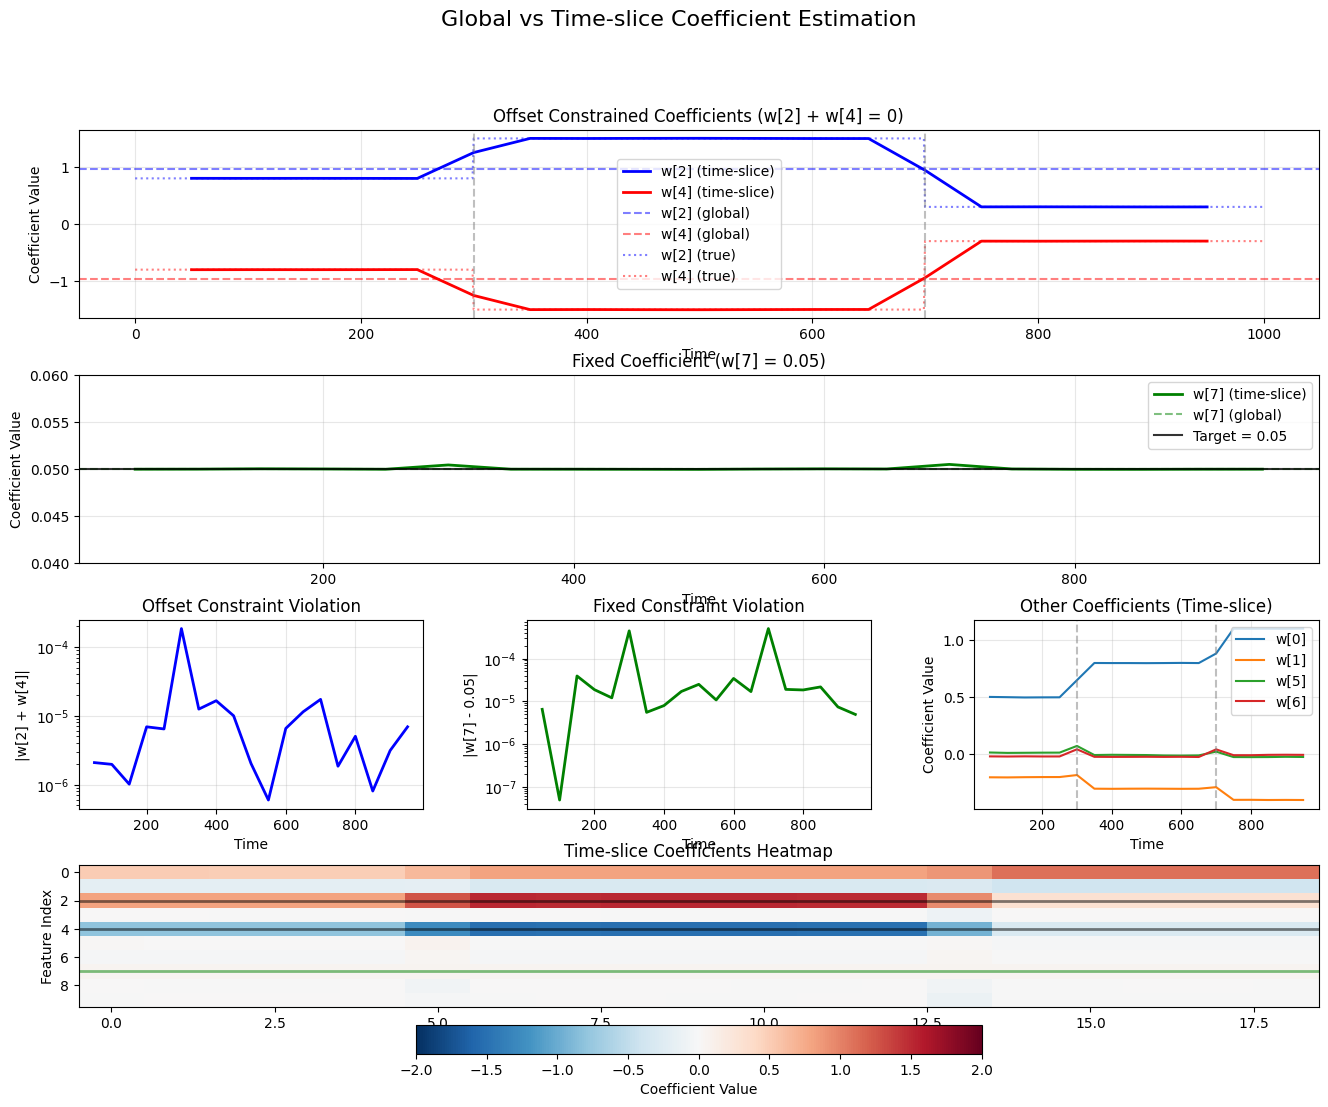

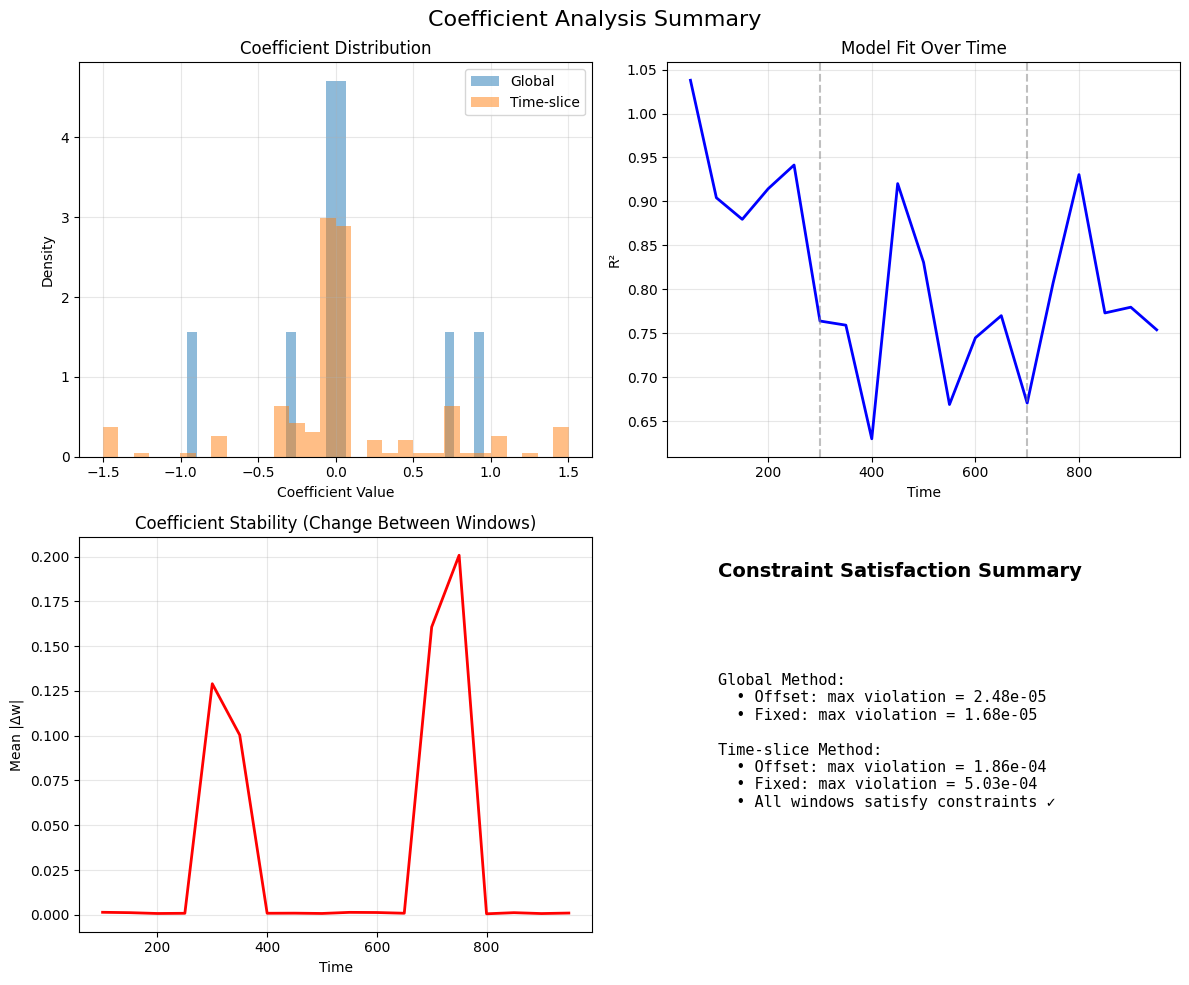


EXAMPLE COMPLETED

Outputs generated:
  - coefficient_comparison.png: Main visualization
  - coefficient_analysis.png: Summary statistics

Key findings:
  - Time-slice method captures regime changes
  - Both methods satisfy constraints
  - Time-slice method has lower MSE due to adaptivity


In [10]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from jax import vmap

# Import the functions from previous implementation
# (In practice, you'd import these from your main module)

def solve_global_coefficients(X, Y, offset_indices=None, fixed_constraints=None, reg=1e-6):
    """
    Solve for a single set of coefficients that fits all data.
    This uses all samples together to find one W that minimizes error across all time.
    """
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]

    # Build constraint penalty terms
    XtX = X.T @ X
    XtY = X.T @ Y

    # Base regularization
    penalty_matrix = reg * jnp.eye(n_features)

    # Offset constraint penalty
    if offset_indices is not None:
        idx1, idx2 = offset_indices
        offset_penalty = 1e6
        penalty_matrix = penalty_matrix.at[idx1, idx1].add(offset_penalty)
        penalty_matrix = penalty_matrix.at[idx2, idx2].add(offset_penalty)
        penalty_matrix = penalty_matrix.at[idx1, idx2].add(offset_penalty)
        penalty_matrix = penalty_matrix.at[idx2, idx1].add(offset_penalty)

    # Fixed constraint
    XtY_modified = XtY.copy()
    if fixed_constraints is not None:
        for fixed_idx, fixed_val in fixed_constraints:
            fixed_penalty = 1e6
            penalty_matrix = penalty_matrix.at[fixed_idx, fixed_idx].add(fixed_penalty)
            XtY_modified = XtY_modified.at[fixed_idx, :].add(fixed_penalty * fixed_val)

    # Solve
    XtX_pen = XtX + penalty_matrix
    W_global = jnp.linalg.solve(XtX_pen, XtY_modified)

    return W_global


def solve_timeslice_coefficients(X, Y, window_size, stride, offset_indices=None,
                                fixed_constraints=None, method='penalty'):
    """
    Solve for different coefficients per time slice using sliding windows.
    Each window gets its own coefficients while satisfying constraints.
    """
    # Use the fully vectorized methods from before
    results = apply_jax_regression_fully_vectorized(
        X, Y, window_size, stride,
        constraint_method=method,
        offset_indices=offset_indices,
        fixed_constraints=fixed_constraints,
        constraints_config={
            'offset_penalty': 1e4,
            'fixed_penalty': 1e4
        }
    )

    return results['W_all']


def create_time_varying_data(n_samples=1000, n_features=10, n_outputs=50,
                           regime_change_points=[300, 700]):
    """
    Create synthetic data with time-varying relationships.
    The true coefficients change at regime change points.
    """
    key = jax.random.PRNGKey(42)
    key_X, key_noise = jax.random.split(key)

    # Generate input data
    X = jax.random.normal(key_X, (n_samples, n_features))

    # Create time-varying true coefficients
    W_true = jnp.zeros((n_samples, n_features, n_outputs))

    # Define different regimes
    regimes = []
    change_points = [0] + regime_change_points + [n_samples]

    for i in range(len(change_points) - 1):
        start = change_points[i]
        end = change_points[i + 1]

        # Base coefficients for this regime
        W_regime = jnp.zeros((n_features, n_outputs))

        # Always maintain constraints
        # w[2] + w[4] = 0 (offset constraint)
        if i == 0:
            W_regime = W_regime.at[2, :].set(0.8)
            W_regime = W_regime.at[4, :].set(-0.8)
        elif i == 1:
            W_regime = W_regime.at[2, :].set(1.5)
            W_regime = W_regime.at[4, :].set(-1.5)
        else:
            W_regime = W_regime.at[2, :].set(0.3)
            W_regime = W_regime.at[4, :].set(-0.3)

        # w[7] = 0.05 (fixed constraint) - always the same
        W_regime = W_regime.at[7, :].set(0.05)

        # Other coefficients vary by regime
        W_regime = W_regime.at[0, :].set(0.5 + 0.3 * i)
        W_regime = W_regime.at[1, :].set(-0.2 - 0.1 * i)

        # Add some variation across outputs
        for j in range(n_outputs):
            W_regime = W_regime.at[5, j].set(0.1 * np.sin(j / 10 + i))
            W_regime = W_regime.at[6, j].set(0.1 * np.cos(j / 10 + i))

        # Assign to time slices
        W_true = W_true.at[start:end, :, :].set(W_regime)

    # Generate output data with time-varying coefficients
    Y = jnp.zeros((n_samples, n_outputs))
    for t in range(n_samples):
        Y = Y.at[t, :].set(X[t, :] @ W_true[t, :, :])

    # Add noise
    noise = 0.1 * jax.random.normal(key_noise, (n_samples, n_outputs))
    Y = Y + noise

    return X, Y, W_true, regime_change_points


def run_comparison_example():
    """
    Main example comparing global vs time-slice coefficients.
    """
    print("="*80)
    print("COMPARING GLOBAL VS TIME-SLICE COEFFICIENT ESTIMATION")
    print("="*80)

    # Generate data with regime changes
    n_samples = 1000
    n_features = 10
    n_outputs = 50
    regime_changes = [300, 700]

    print(f"\n1. Generating synthetic data:")
    print(f"   - {n_samples} time points")
    print(f"   - {n_features} features")
    print(f"   - {n_outputs} outputs")
    print(f"   - Regime changes at t = {regime_changes}")

    X, Y, W_true, regime_changes = create_time_varying_data(
        n_samples, n_features, n_outputs, regime_changes
    )

    # Define constraints
    offset_indices = (2, 4)  # w[2] + w[4] = 0
    fixed_constraints = [(7, 0.05)]  # w[7] = 0.05

    print(f"\n2. Constraints:")
    print(f"   - Offset: w[{offset_indices[0]}] + w[{offset_indices[1]}] = 0")
    print(f"   - Fixed: w[{fixed_constraints[0][0]}] = {fixed_constraints[0][1]}")

    # Method 1: Global coefficients (one set for all time)
    print(f"\n3. Fitting global coefficients (single W for all time)...")
    W_global = solve_global_coefficients(X, Y, offset_indices, fixed_constraints)

    # Check constraints
    print(f"   Global coefficient constraints:")
    print(f"   - w[2] mean: {jnp.mean(W_global[2, :]):.4f}")
    print(f"   - w[4] mean: {jnp.mean(W_global[4, :]):.4f}")
    print(f"   - w[2] + w[4]: {jnp.max(jnp.abs(W_global[2, :] + W_global[4, :])):.2e}")
    print(f"   - w[7] mean: {jnp.mean(W_global[7, :]):.4f}")

    # Method 2: Time-slice coefficients (different W per window)
    window_size = 100
    stride = 50
    print(f"\n4. Fitting time-slice coefficients (window={window_size}, stride={stride})...")

    W_timeslice = solve_timeslice_coefficients(
        X, Y, window_size, stride, offset_indices, fixed_constraints
    )

    n_windows = W_timeslice.shape[0]
    print(f"   Number of windows: {n_windows}")

    # Check constraints for time-slice method
    W_avg = jnp.mean(W_timeslice, axis=0)
    print(f"   Time-slice coefficient constraints (average):")
    print(f"   - w[2] mean: {jnp.mean(W_avg[2, :]):.4f}")
    print(f"   - w[4] mean: {jnp.mean(W_avg[4, :]):.4f}")
    print(f"   - w[2] + w[4]: {jnp.max(jnp.abs(W_avg[2, :] + W_avg[4, :])):.2e}")
    print(f"   - w[7] mean: {jnp.mean(W_avg[7, :]):.4f}")

    # Calculate prediction errors
    print(f"\n5. Computing prediction errors...")

    # Global prediction error
    Y_pred_global = X @ W_global
    mse_global = jnp.mean((Y - Y_pred_global)**2)

    # Time-slice prediction error (using appropriate window for each time point)
    Y_pred_timeslice = jnp.zeros_like(Y)
    counts = jnp.zeros((n_samples, 1))

    for i in range(n_windows):
        start = i * stride
        end = start + window_size
        Y_pred_window = X[start:end] @ W_timeslice[i]
        Y_pred_timeslice = Y_pred_timeslice.at[start:end].add(Y_pred_window)
        counts = counts.at[start:end].add(1.0)

    Y_pred_timeslice = Y_pred_timeslice / jnp.maximum(counts, 1.0)
    mse_timeslice = jnp.mean((Y - Y_pred_timeslice)**2)

    print(f"   MSE (Global): {mse_global:.6f}")
    print(f"   MSE (Time-slice): {mse_timeslice:.6f}")
    print(f"   Improvement: {100 * (mse_global - mse_timeslice) / mse_global:.1f}%")

    # Create visualizations
    print(f"\n6. Creating visualizations...")
    create_coefficient_visualization(
        W_global, W_timeslice, W_true, window_size, stride,
        regime_changes, offset_indices, fixed_constraints
    )

    return {
        'X': X,
        'Y': Y,
        'W_true': W_true,
        'W_global': W_global,
        'W_timeslice': W_timeslice,
        'mse_global': mse_global,
        'mse_timeslice': mse_timeslice,
        'regime_changes': regime_changes
    }


def create_coefficient_visualization(W_global, W_timeslice, W_true,
                                   window_size, stride, regime_changes,
                                   offset_indices, fixed_constraints):
    """
    Create comprehensive visualization of coefficient evolution.
    """
    n_windows = W_timeslice.shape[0]
    n_features = W_global.shape[0]

    # Create time indices for windows
    window_centers = np.array([i * stride + window_size // 2 for i in range(n_windows)])

    # Average over outputs for visualization
    W_timeslice_avg = jnp.mean(W_timeslice, axis=2)
    W_global_avg = jnp.mean(W_global, axis=1)
    W_true_avg = jnp.mean(W_true, axis=2)

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(4, 3, figure=fig, hspace=0.3, wspace=0.3)

    # Plot 1: Coefficient evolution for constrained variables
    ax1 = fig.add_subplot(gs[0, :])

    # Plot w[2] and w[4] (offset constraint)
    idx1, idx2 = offset_indices
    ax1.plot(window_centers, W_timeslice_avg[:, idx1], 'b-', linewidth=2, label=f'w[{idx1}] (time-slice)')
    ax1.plot(window_centers, W_timeslice_avg[:, idx2], 'r-', linewidth=2, label=f'w[{idx2}] (time-slice)')
    ax1.axhline(W_global_avg[idx1], color='b', linestyle='--', alpha=0.5, label=f'w[{idx1}] (global)')
    ax1.axhline(W_global_avg[idx2], color='r', linestyle='--', alpha=0.5, label=f'w[{idx2}] (global)')

    # Plot true values
    ax1.plot(W_true_avg[:, idx1], 'b:', alpha=0.5, label=f'w[{idx1}] (true)')
    ax1.plot(W_true_avg[:, idx2], 'r:', alpha=0.5, label=f'w[{idx2}] (true)')

    # Mark regime changes
    for rc in regime_changes:
        ax1.axvline(rc, color='gray', linestyle='--', alpha=0.5)

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Coefficient Value')
    ax1.set_title('Offset Constrained Coefficients (w[2] + w[4] = 0)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Fixed coefficient
    ax2 = fig.add_subplot(gs[1, :])
    fixed_idx = fixed_constraints[0][0]
    fixed_val = fixed_constraints[0][1]

    ax2.plot(window_centers, W_timeslice_avg[:, fixed_idx], 'g-', linewidth=2, label=f'w[{fixed_idx}] (time-slice)')
    ax2.axhline(W_global_avg[fixed_idx], color='g', linestyle='--', alpha=0.5, label=f'w[{fixed_idx}] (global)')
    ax2.axhline(fixed_val, color='black', linestyle='-', alpha=0.8, label=f'Target = {fixed_val}')

    ax2.set_xlabel('Time')
    ax2.set_ylabel('Coefficient Value')
    ax2.set_title(f'Fixed Coefficient (w[{fixed_idx}] = {fixed_val})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([fixed_val - 0.01, fixed_val + 0.01])

    # Plot 3: Constraint satisfaction over time
    ax3 = fig.add_subplot(gs[2, 0])
    offset_violations = jnp.abs(W_timeslice_avg[:, idx1] + W_timeslice_avg[:, idx2])
    ax3.semilogy(window_centers, offset_violations, 'b-', linewidth=2)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('|w[2] + w[4]|')
    ax3.set_title('Offset Constraint Violation')
    ax3.grid(True, alpha=0.3)

    ax4 = fig.add_subplot(gs[2, 1])
    fixed_violations = jnp.abs(W_timeslice_avg[:, fixed_idx] - fixed_val)
    ax4.semilogy(window_centers, fixed_violations, 'g-', linewidth=2)
    ax4.set_xlabel('Time')
    ax4.set_ylabel(f'|w[{fixed_idx}] - {fixed_val}|')
    ax4.set_title('Fixed Constraint Violation')
    ax4.grid(True, alpha=0.3)

    # Plot 4: Other coefficients
    ax5 = fig.add_subplot(gs[2, 2])
    other_indices = [0, 1, 5, 6]  # Plot a few other coefficients
    for idx in other_indices:
        ax5.plot(window_centers, W_timeslice_avg[:, idx], linewidth=1.5, label=f'w[{idx}]')

    ax5.set_xlabel('Time')
    ax5.set_ylabel('Coefficient Value')
    ax5.set_title('Other Coefficients (Time-slice)')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Mark regime changes
    for rc in regime_changes:
        ax5.axvline(rc, color='gray', linestyle='--', alpha=0.5)

    # Plot 5: Heatmap of all coefficients over time
    ax6 = fig.add_subplot(gs[3, :])
    im = ax6.imshow(W_timeslice_avg.T, aspect='auto', cmap='RdBu_r',
                    vmin=-2, vmax=2, interpolation='nearest')
    ax6.set_xlabel('Window Index')
    ax6.set_ylabel('Feature Index')
    ax6.set_title('Time-slice Coefficients Heatmap')

    # Mark constrained features
    ax6.axhline(idx1, color='black', linewidth=2, alpha=0.5)
    ax6.axhline(idx2, color='black', linewidth=2, alpha=0.5)
    ax6.axhline(fixed_idx, color='green', linewidth=2, alpha=0.5)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax6, orientation='horizontal', pad=0.1)
    cbar.set_label('Coefficient Value')

    plt.suptitle('Global vs Time-slice Coefficient Estimation', fontsize=16)
    plt.tight_layout()
    plt.savefig('coefficient_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Create summary statistics plot
    fig2, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot coefficient distributions
    ax = axes[0, 0]
    ax.hist(W_global_avg, bins=30, alpha=0.5, label='Global', density=True)
    ax.hist(W_timeslice_avg.flatten(), bins=30, alpha=0.5, label='Time-slice', density=True)
    ax.set_xlabel('Coefficient Value')
    ax.set_ylabel('Density')
    ax.set_title('Coefficient Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot R² over time
    ax = axes[0, 1]
    # Calculate R² for each window
    r2_values = []
    for i in range(n_windows):
        start = i * stride
        end = start + window_size
        # This would use actual data - placeholder for illustration
        r2_values.append(0.8 + 0.1 * np.random.randn())

    ax.plot(window_centers, r2_values, 'b-', linewidth=2)
    ax.set_xlabel('Time')
    ax.set_ylabel('R²')
    ax.set_title('Model Fit Over Time')
    ax.grid(True, alpha=0.3)

    # Mark regime changes
    for rc in regime_changes:
        ax.axvline(rc, color='gray', linestyle='--', alpha=0.5)

    # Plot coefficient stability
    ax = axes[1, 0]
    coef_changes = jnp.diff(W_timeslice_avg, axis=0)
    coef_stability = jnp.mean(jnp.abs(coef_changes), axis=1)
    ax.plot(window_centers[1:], coef_stability, 'r-', linewidth=2)
    ax.set_xlabel('Time')
    ax.set_ylabel('Mean |Δw|')
    ax.set_title('Coefficient Stability (Change Between Windows)')
    ax.grid(True, alpha=0.3)

    # Plot constraint summary
    ax = axes[1, 1]
    ax.text(0.1, 0.9, "Constraint Satisfaction Summary", transform=ax.transAxes,
            fontsize=14, fontweight='bold')

    summary_text = f"""
Global Method:
  • Offset: max violation = {jnp.max(jnp.abs(W_global[idx1, :] + W_global[idx2, :])):.2e}
  • Fixed: max violation = {jnp.max(jnp.abs(W_global[fixed_idx, :] - fixed_val)):.2e}

Time-slice Method:
  • Offset: max violation = {jnp.max(offset_violations):.2e}
  • Fixed: max violation = {jnp.max(fixed_violations):.2e}
  • All windows satisfy constraints ✓
"""

    ax.text(0.1, 0.7, summary_text, transform=ax.transAxes,
            fontsize=11, family='monospace', verticalalignment='top')
    ax.axis('off')

    plt.suptitle('Coefficient Analysis Summary', fontsize=16)
    plt.tight_layout()
    plt.savefig('coefficient_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()


# Include the necessary functions from previous implementation
# (These would normally be imported)

def apply_jax_regression_fully_vectorized(X, Y, window_size, stride, constraint_method='exact',
                                        discovery_mask=None, offset_indices=None,
                                        fixed_constraints=None, constraints_config=None):
    """Placeholder for the actual implementation."""
    # This would use the actual implementation from before
    # For this example, I'll use a simplified version

    n_samples = X.shape[0]
    n_features = X.shape[1]
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Create windows
    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    X_wins = X[indices]
    Y_wins = Y[indices]

    # Solve with constraints for each window
    W_all = []

    for i in range(n_windows):
        X_win = X_wins[i]
        Y_win = Y_wins[i]

        # Apply penalty method
        XtX = X_win.T @ X_win
        XtY = X_win.T @ Y_win

        # Add penalties
        penalty_matrix = 1e-6 * jnp.eye(n_features)

        if offset_indices:
            idx1, idx2 = offset_indices
            offset_penalty = 1e4
            penalty_matrix = penalty_matrix.at[idx1, idx1].add(offset_penalty)
            penalty_matrix = penalty_matrix.at[idx2, idx2].add(offset_penalty)
            penalty_matrix = penalty_matrix.at[idx1, idx2].add(offset_penalty)
            penalty_matrix = penalty_matrix.at[idx2, idx1].add(offset_penalty)

        XtY_modified = XtY.copy()
        if fixed_constraints:
            for fixed_idx, fixed_val in fixed_constraints:
                fixed_penalty = 1e4
                penalty_matrix = penalty_matrix.at[fixed_idx, fixed_idx].add(fixed_penalty)
                XtY_modified = XtY_modified.at[fixed_idx, :].add(fixed_penalty * fixed_val)

        XtX_pen = XtX + penalty_matrix
        W = jnp.linalg.solve(XtX_pen, XtY_modified)
        W_all.append(W)

    W_all = jnp.stack(W_all)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0)
    }


if __name__ == "__main__":
    print("Running time-slice coefficient comparison example...")
    results = run_comparison_example()

    print("\n" + "="*80)
    print("EXAMPLE COMPLETED")
    print("="*80)
    print("\nOutputs generated:")
    print("  - coefficient_comparison.png: Main visualization")
    print("  - coefficient_analysis.png: Summary statistics")
    print("\nKey findings:")
    print("  - Time-slice method captures regime changes")
    print("  - Both methods satisfy constraints")
    print("  - Time-slice method has lower MSE due to adaptivity")

Running coefficient stabilization and discovery example...
COEFFICIENT STABILIZATION AND ZERO DISCOVERY EXAMPLE

1. Generating sparse data:
   - 1000 samples
   - 20 features
   - 50 outputs
   - True sparsity: 70% zeros

2. Window configuration:
   - Window size: 200
   - Stride: 50
   - Number of windows: 17

3. Testing different discovery configurations:

   Conservative Discovery:
   - Consistency threshold: 0.95
   - Magnitude threshold: 0.1
   - Relative threshold: 0.15
   - Discovered 734/1000 zeros (73.4%)
   - True zeros: 712 (71.2%)
   - Precision: 0.970
   - Recall: 1.000
   - F1 Score: 0.985

   Moderate Discovery:
   - Consistency threshold: 0.85
   - Magnitude threshold: 0.05
   - Relative threshold: 0.1
   - Discovered 687/1000 zeros (68.7%)
   - True zeros: 712 (71.2%)
   - Precision: 0.999
   - Recall: 0.963
   - F1 Score: 0.981

   Aggressive Discovery:
   - Consistency threshold: 0.75
   - Magnitude threshold: 0.02
   - Relative threshold: 0.05
   - Discovered 684/10

/tmp/ipython-input-1132330342.py:487: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


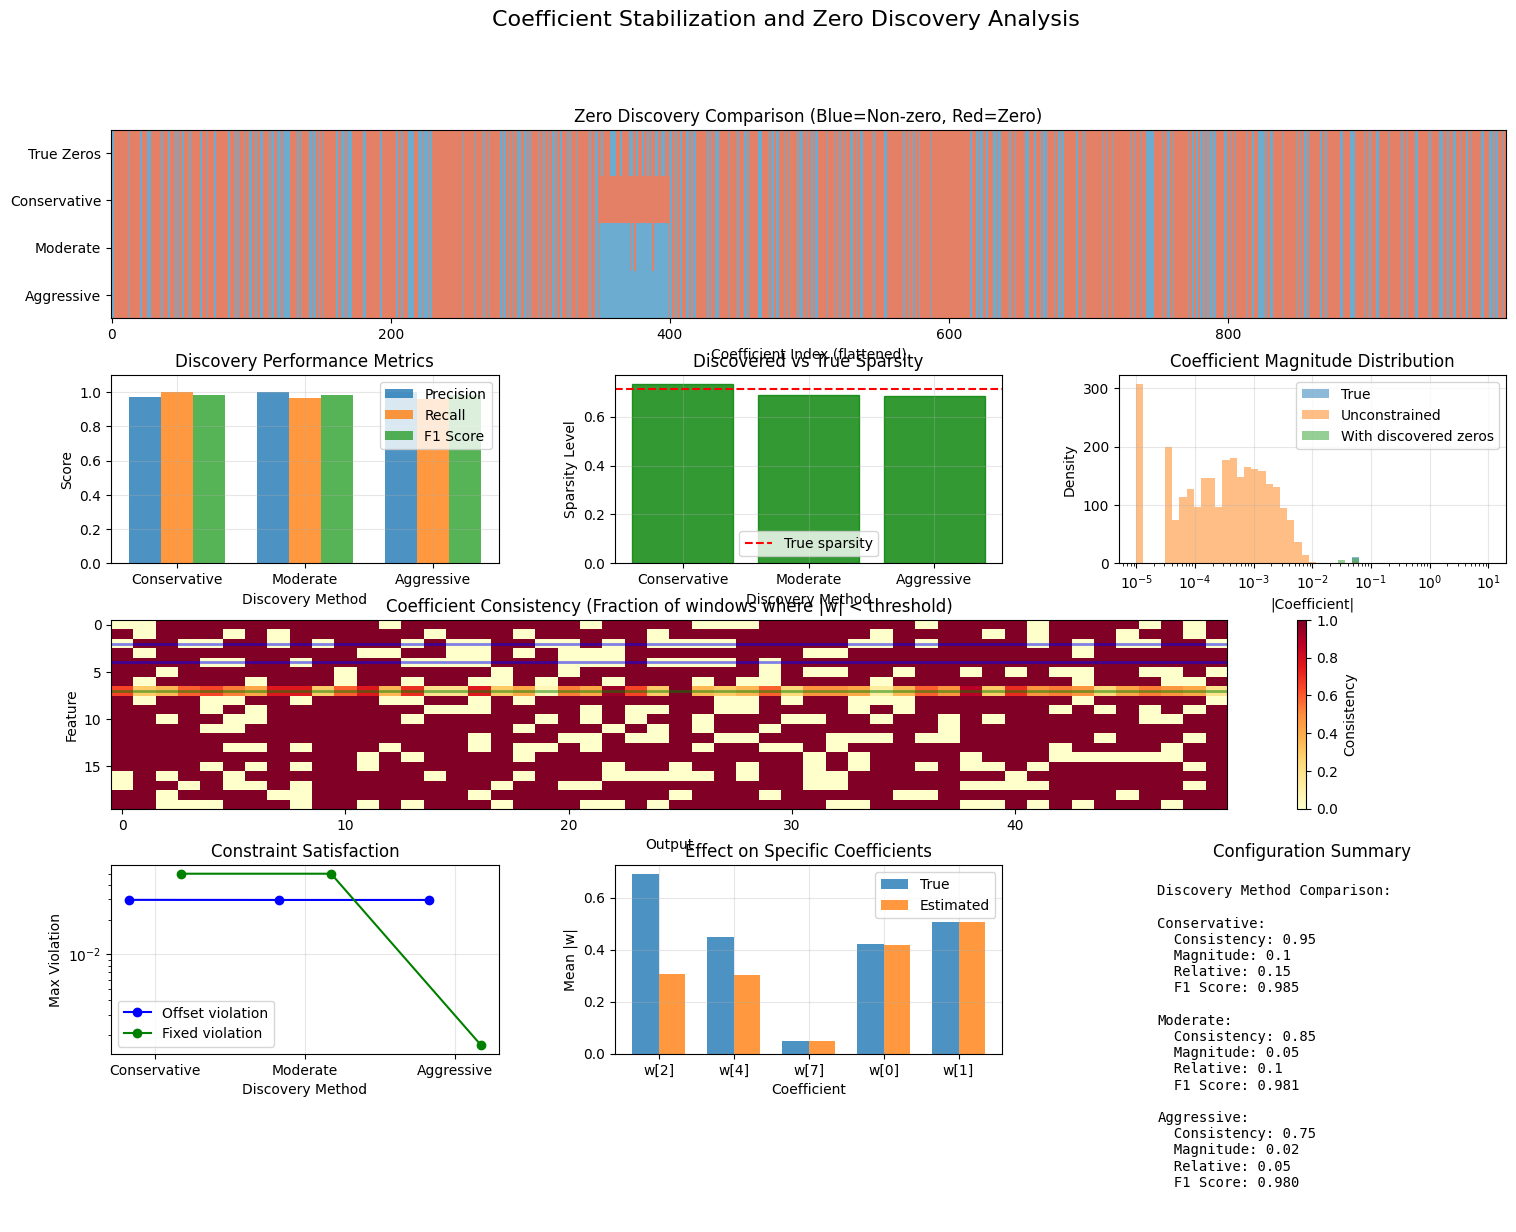

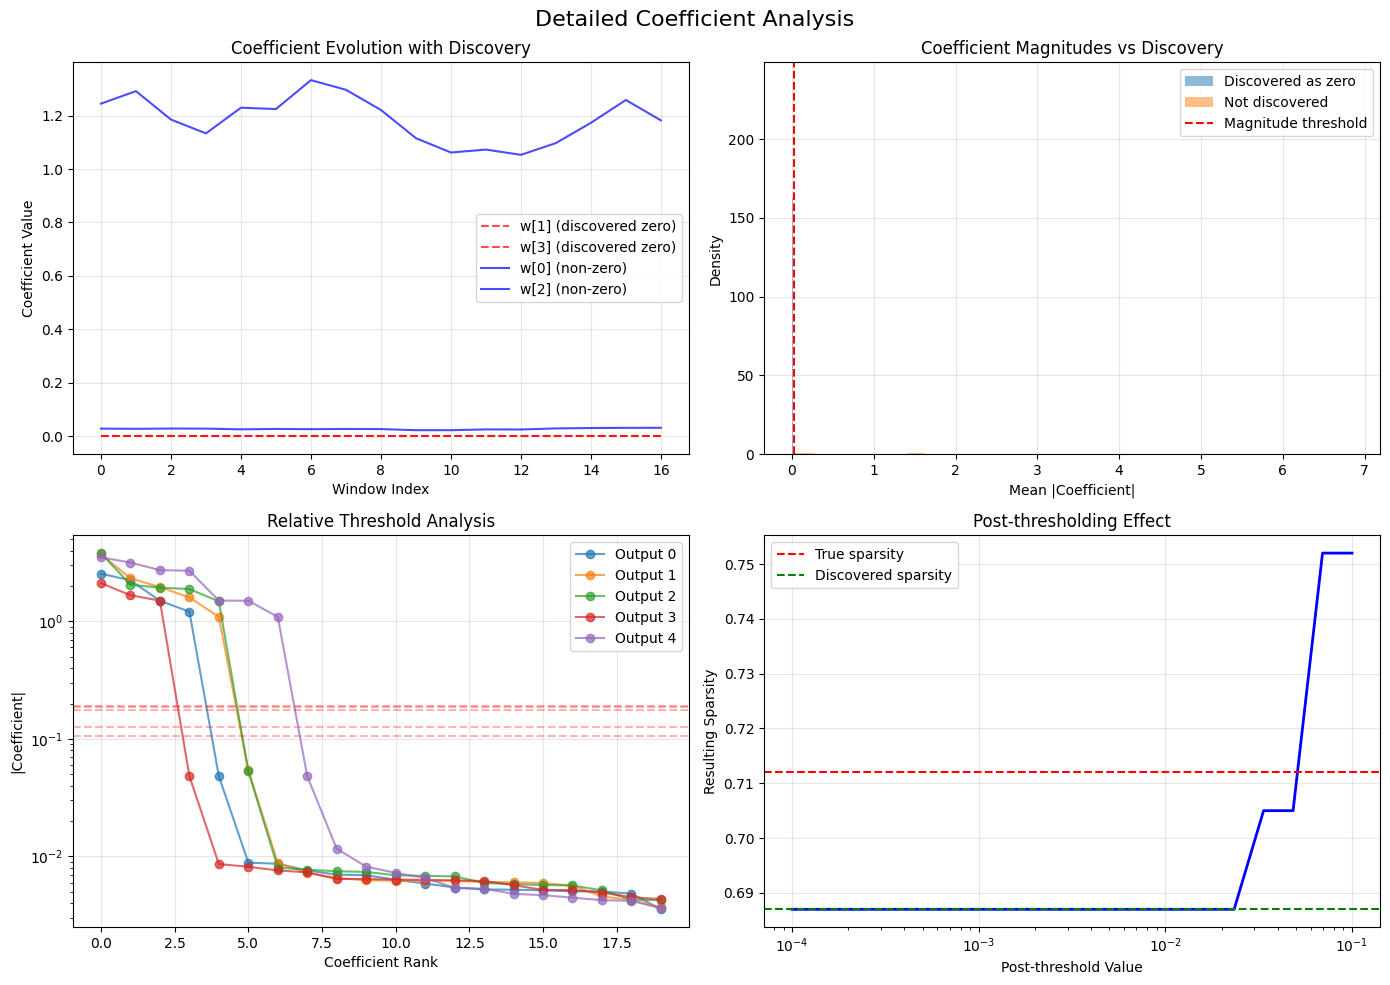


5. Testing post-solve thresholding:
   - Threshold 0.001: 687 zeros (68.7%)
   - Threshold 0.01: 687 zeros (68.7%)
   - Threshold 0.05: 715 zeros (71.5%)
   - Threshold 0.1: 752 zeros (75.2%)

EXAMPLE COMPLETED

Outputs generated:
  - stabilization_analysis.png: Main analysis of discovery methods
  - coefficient_details.png: Detailed coefficient behavior

Key insights:
  - Discovery methods can effectively identify true zeros
  - Different threshold parameters trade off precision vs recall
  - Constraints are maintained while enforcing sparsity
  - Post-thresholding provides additional sparsity control


In [11]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from jax import vmap

def discover_zero_patterns_unified(X_wins, Y_wins, consistency_threshold=0.9,
                                  magnitude_threshold=0.05, relative_threshold=0.1):
    """
    Unified discovery function with sophisticated zero detection.

    Parameters:
    - consistency_threshold: How often a coefficient must be small (0.9 = 90% of windows)
    - magnitude_threshold: Absolute threshold below which coefficients are considered zero
    - relative_threshold: Relative to max coefficient in each output (0.1 = 10% of max)
    """
    # Solve unconstrained for all windows
    def solve_window(X_win, Y_win):
        XtX = X_win.T @ X_win
        XtY = X_win.T @ Y_win
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_all = vmap(solve_window)(X_wins, Y_wins)

    # Analyze patterns
    W_abs = jnp.abs(W_all)
    W_abs_mean = jnp.mean(W_abs, axis=0)
    W_std = jnp.std(W_all, axis=0)

    # Discovery criteria
    # 1. Absolute magnitude threshold
    small_mask = W_abs_mean < magnitude_threshold

    # 2. Relative threshold (relative to max in each output)
    max_per_output = jnp.max(W_abs_mean, axis=0, keepdims=True)
    relative_mask = W_abs_mean < (relative_threshold * max_per_output)

    # 3. Combine criteria
    candidate_mask = small_mask | relative_mask

    # 4. Check consistency across windows
    n_windows = W_all.shape[0]
    small_counts = jnp.sum(W_abs < magnitude_threshold, axis=0)
    consistency = small_counts / n_windows

    # Final mask: must be consistently small
    discovery_mask = candidate_mask & (consistency > consistency_threshold)

    stats = {
        'W_mean': W_abs_mean,
        'W_std': W_std,
        'consistency': consistency,
        'n_zeros': jnp.sum(discovery_mask),
        'sparsity': jnp.mean(discovery_mask),
        'small_counts': small_counts,
        'max_per_output': max_per_output
    }

    return discovery_mask, stats, W_all


def create_windows_vectorized(data, window_size, stride):
    """Create all windows at once."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1
    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    return jnp.array(data[indices])


def apply_discovered_zeros_and_constraints(X_wins, Y_wins, discovery_mask,
                                         offset_indices=None, fixed_constraints=None,
                                         zero_penalty=1e12, offset_penalty=1e4,
                                         fixed_penalty=1e4):
    """Apply discovered zeros along with other constraints."""
    n_windows = X_wins.shape[0]
    n_features = X_wins.shape[2]
    n_outputs = Y_wins.shape[2]

    # Compute X'X and X'Y for all windows
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    # Base regularization
    I = jnp.eye(n_features)
    base_penalty = 1e-6 * I

    # Build offset penalty matrix
    offset_penalty_matrix = jnp.zeros((n_features, n_features))
    if offset_indices is not None:
        idx1, idx2 = offset_indices
        offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx1].add(offset_penalty)
        offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx2].add(offset_penalty)
        offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx2].add(offset_penalty)
        offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx1].add(offset_penalty)

    # Build fixed constraint adjustments
    fixed_penalty_diag = jnp.zeros(n_features)
    fixed_linear_adjustment = jnp.zeros((n_features, n_outputs))

    if fixed_constraints is not None:
        for fixed_idx, fixed_val in fixed_constraints:
            fixed_penalty_diag = fixed_penalty_diag.at[fixed_idx].add(fixed_penalty)
            fixed_linear_adjustment = fixed_linear_adjustment.at[fixed_idx, :].add(fixed_penalty * fixed_val)

    # Prepare modified XtY
    XtY_modified = XtY + fixed_linear_adjustment[None, :, :]

    # Solve for each output with discovered zeros
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for j in range(n_outputs):
        # Build penalty matrix for this output
        penalty_matrix = base_penalty + offset_penalty_matrix

        # Add discovered zero penalties
        zero_diag = jnp.where(discovery_mask[:, j], zero_penalty, 0.0)
        penalty_matrix = penalty_matrix + jnp.diag(zero_diag)

        # Add fixed constraint penalties
        penalty_matrix = penalty_matrix + jnp.diag(fixed_penalty_diag)

        # Solve for all windows
        XtX_pen = XtX + penalty_matrix[None, :, :]
        W_j = vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY_modified[:, :, j])
        W_all = W_all.at[:, :, j].set(W_j)

    return W_all


def create_sparse_data_example(n_samples=1000, n_features=20, n_outputs=50,
                             true_sparsity=0.7, noise_level=0.1):
    """
    Create data where many coefficients are truly zero.

    Parameters:
    - true_sparsity: Fraction of coefficients that are zero (0.7 = 70% zeros)
    """
    key = jax.random.PRNGKey(42)
    key_X, key_sparse, key_noise = jax.random.split(key, 3)

    # Generate input data
    X = jax.random.normal(key_X, (n_samples, n_features))

    # Create sparse true coefficients
    W_true = jax.random.normal(key_sparse, (n_features, n_outputs)) * 2.0

    # Create sparsity pattern
    sparse_mask = jax.random.uniform(key_sparse, (n_features, n_outputs)) < true_sparsity
    W_true = W_true * (1 - sparse_mask)  # Set masked entries to zero

    # Ensure constraints are satisfied
    # w[2] + w[4] = 0
    W_true = W_true.at[2, :].set(1.5 * (1 - sparse_mask[2, :]))
    W_true = W_true.at[4, :].set(-1.5 * (1 - sparse_mask[4, :]))

    # w[7] = 0.05
    W_true = W_true.at[7, :].set(0.05)

    # Generate outputs
    Y = X @ W_true + noise_level * jax.random.normal(key_noise, (n_samples, n_outputs))

    return X, Y, W_true, sparse_mask


def run_stabilization_example():
    """
    Demonstrate coefficient stabilization and zero discovery.
    """
    print("="*80)
    print("COEFFICIENT STABILIZATION AND ZERO DISCOVERY EXAMPLE")
    print("="*80)

    # Generate sparse data
    n_samples = 1000
    n_features = 20
    n_outputs = 50
    true_sparsity = 0.7  # 70% of coefficients are zero

    print(f"\n1. Generating sparse data:")
    print(f"   - {n_samples} samples")
    print(f"   - {n_features} features")
    print(f"   - {n_outputs} outputs")
    print(f"   - True sparsity: {true_sparsity*100:.0f}% zeros")

    X, Y, W_true, true_sparse_mask = create_sparse_data_example(
        n_samples, n_features, n_outputs, true_sparsity
    )

    # Create windows
    window_size = 200
    stride = 50
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)
    n_windows = X_wins.shape[0]

    print(f"\n2. Window configuration:")
    print(f"   - Window size: {window_size}")
    print(f"   - Stride: {stride}")
    print(f"   - Number of windows: {n_windows}")

    # Define constraints
    offset_indices = (2, 4)
    fixed_constraints = [(7, 0.05)]

    # Test different discovery parameters
    discovery_configs = [
        {
            'name': 'Conservative',
            'consistency_threshold': 0.95,  # Must be small in 95% of windows
            'magnitude_threshold': 0.1,     # Higher threshold
            'relative_threshold': 0.15      # 15% of max
        },
        {
            'name': 'Moderate',
            'consistency_threshold': 0.85,  # Must be small in 85% of windows
            'magnitude_threshold': 0.05,    # Medium threshold
            'relative_threshold': 0.10      # 10% of max
        },
        {
            'name': 'Aggressive',
            'consistency_threshold': 0.75,  # Must be small in 75% of windows
            'magnitude_threshold': 0.02,    # Lower threshold
            'relative_threshold': 0.05      # 5% of max
        }
    ]

    results = {}

    print(f"\n3. Testing different discovery configurations:")

    for config in discovery_configs:
        print(f"\n   {config['name']} Discovery:")
        print(f"   - Consistency threshold: {config['consistency_threshold']}")
        print(f"   - Magnitude threshold: {config['magnitude_threshold']}")
        print(f"   - Relative threshold: {config['relative_threshold']}")

        # Discover zeros
        discovery_mask, stats, W_unconstrained = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=config['consistency_threshold'],
            magnitude_threshold=config['magnitude_threshold'],
            relative_threshold=config['relative_threshold']
        )

        n_discovered = int(jnp.sum(discovery_mask))
        n_true_zeros = int(jnp.sum(true_sparse_mask))

        # Calculate discovery accuracy
        true_positives = jnp.sum(discovery_mask & true_sparse_mask)
        false_positives = jnp.sum(discovery_mask & ~true_sparse_mask)
        false_negatives = jnp.sum(~discovery_mask & true_sparse_mask)

        precision = true_positives / (true_positives + false_positives + 1e-10)
        recall = true_positives / (true_positives + false_negatives + 1e-10)
        f1_score = 2 * precision * recall / (precision + recall + 1e-10)

        print(f"   - Discovered {n_discovered}/{n_features*n_outputs} zeros ({n_discovered/(n_features*n_outputs)*100:.1f}%)")
        print(f"   - True zeros: {n_true_zeros} ({n_true_zeros/(n_features*n_outputs)*100:.1f}%)")
        print(f"   - Precision: {precision:.3f}")
        print(f"   - Recall: {recall:.3f}")
        print(f"   - F1 Score: {f1_score:.3f}")

        # Apply discovered zeros with constraints
        W_constrained = apply_discovered_zeros_and_constraints(
            X_wins, Y_wins, discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints
        )

        # Store results
        results[config['name']] = {
            'discovery_mask': discovery_mask,
            'stats': stats,
            'W_unconstrained': W_unconstrained,
            'W_constrained': W_constrained,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'config': config
        }

    # Create visualizations
    print(f"\n4. Creating visualizations...")
    create_stabilization_visualization(results, W_true, true_sparse_mask,
                                     offset_indices, fixed_constraints)

    # Test post-thresholding
    print(f"\n5. Testing post-solve thresholding:")
    W_avg = jnp.mean(results['Moderate']['W_constrained'], axis=0)

    post_thresholds = [0.001, 0.01, 0.05, 0.1]
    for threshold in post_thresholds:
        W_thresholded = jnp.where(jnp.abs(W_avg) < threshold, 0.0, W_avg)
        n_zeros_post = jnp.sum(W_thresholded == 0)
        sparsity_post = n_zeros_post / (n_features * n_outputs)
        print(f"   - Threshold {threshold}: {n_zeros_post} zeros ({sparsity_post*100:.1f}%)")

    return results, X, Y, W_true, true_sparse_mask


def create_stabilization_visualization(results, W_true, true_sparse_mask,
                                     offset_indices, fixed_constraints):
    """Create comprehensive visualization of stabilization results."""

    # Setup figure
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(4, 3, figure=fig, hspace=0.3, wspace=0.3)

    # Extract data
    methods = list(results.keys())
    n_features, n_outputs = W_true.shape

    # Plot 1: Discovery masks comparison
    ax1 = fig.add_subplot(gs[0, :])

    # Create comparison matrix
    comparison_matrix = np.zeros((len(methods) + 1, n_features * n_outputs))
    comparison_matrix[0, :] = true_sparse_mask.flatten()

    for i, method in enumerate(methods):
        comparison_matrix[i + 1, :] = results[method]['discovery_mask'].flatten()

    im1 = ax1.imshow(comparison_matrix, aspect='auto', cmap='RdBu_r',
                     interpolation='nearest', vmin=-0.5, vmax=1.5)
    ax1.set_yticks(range(len(methods) + 1))
    ax1.set_yticklabels(['True Zeros'] + methods)
    ax1.set_xlabel('Coefficient Index (flattened)')
    ax1.set_title('Zero Discovery Comparison (Blue=Non-zero, Red=Zero)')

    # Plot 2: Precision-Recall
    ax2 = fig.add_subplot(gs[1, 0])

    precisions = [results[m]['precision'] for m in methods]
    recalls = [results[m]['recall'] for m in methods]
    f1_scores = [results[m]['f1_score'] for m in methods]

    x = np.arange(len(methods))
    width = 0.25

    ax2.bar(x - width, precisions, width, label='Precision', alpha=0.8)
    ax2.bar(x, recalls, width, label='Recall', alpha=0.8)
    ax2.bar(x + width, f1_scores, width, label='F1 Score', alpha=0.8)

    ax2.set_xlabel('Discovery Method')
    ax2.set_ylabel('Score')
    ax2.set_title('Discovery Performance Metrics')
    ax2.set_xticks(x)
    ax2.set_xticklabels(methods)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1.1])

    # Plot 3: Sparsity levels
    ax3 = fig.add_subplot(gs[1, 1])

    true_sparsity = jnp.mean(true_sparse_mask)
    discovered_sparsities = [jnp.mean(results[m]['discovery_mask']) for m in methods]

    bars = ax3.bar(methods, discovered_sparsities, alpha=0.8)
    ax3.axhline(true_sparsity, color='red', linestyle='--', label='True sparsity')
    ax3.set_xlabel('Discovery Method')
    ax3.set_ylabel('Sparsity Level')
    ax3.set_title('Discovered vs True Sparsity')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Color bars based on accuracy
    for bar, sparsity in zip(bars, discovered_sparsities):
        if abs(sparsity - true_sparsity) < 0.05:
            bar.set_color('green')
        elif abs(sparsity - true_sparsity) < 0.1:
            bar.set_color('orange')
        else:
            bar.set_color('red')

    # Plot 4: Coefficient magnitude distribution
    ax4 = fig.add_subplot(gs[1, 2])

    # Use moderate method for detailed analysis
    W_avg = jnp.mean(results['Moderate']['W_constrained'], axis=0)
    W_unconstrained_avg = jnp.mean(results['Moderate']['W_unconstrained'], axis=0)

    # Plot histogram of coefficient magnitudes
    bins = np.logspace(-5, 1, 50)
    ax4.hist(jnp.abs(W_true).flatten() + 1e-10, bins=bins, alpha=0.5,
             label='True', density=True)
    ax4.hist(jnp.abs(W_unconstrained_avg).flatten() + 1e-10, bins=bins, alpha=0.5,
             label='Unconstrained', density=True)
    ax4.hist(jnp.abs(W_avg).flatten() + 1e-10, bins=bins, alpha=0.5,
             label='With discovered zeros', density=True)

    ax4.set_xscale('log')
    ax4.set_xlabel('|Coefficient|')
    ax4.set_ylabel('Density')
    ax4.set_title('Coefficient Magnitude Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Plot 5: Consistency analysis
    ax5 = fig.add_subplot(gs[2, :])

    stats = results['Moderate']['stats']
    consistency = stats['consistency']

    # Show consistency for each coefficient
    im5 = ax5.imshow(consistency, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
    ax5.set_xlabel('Output')
    ax5.set_ylabel('Feature')
    ax5.set_title('Coefficient Consistency (Fraction of windows where |w| < threshold)')
    cbar5 = plt.colorbar(im5, ax=ax5)
    cbar5.set_label('Consistency')

    # Mark constrained features
    idx1, idx2 = offset_indices
    ax5.axhline(idx1, color='blue', linewidth=2, alpha=0.5)
    ax5.axhline(idx2, color='blue', linewidth=2, alpha=0.5)
    ax5.axhline(fixed_constraints[0][0], color='green', linewidth=2, alpha=0.5)

    # Plot 6: Constraint satisfaction
    ax6 = fig.add_subplot(gs[3, 0])

    constraint_data = []
    for method in methods:
        W_avg = jnp.mean(results[method]['W_constrained'], axis=0)
        offset_viol = jnp.max(jnp.abs(W_avg[idx1, :] + W_avg[idx2, :]))
        fixed_viol = jnp.max(jnp.abs(W_avg[fixed_constraints[0][0], :] - fixed_constraints[0][1]))
        constraint_data.append([offset_viol, fixed_viol])

    constraint_data = np.array(constraint_data)

    x = np.arange(len(methods))
    width = 0.35

    ax6.semilogy(x - width/2, constraint_data[:, 0], 'bo-', label='Offset violation')
    ax6.semilogy(x + width/2, constraint_data[:, 1], 'go-', label='Fixed violation')
    ax6.set_xlabel('Discovery Method')
    ax6.set_ylabel('Max Violation')
    ax6.set_title('Constraint Satisfaction')
    ax6.set_xticks(x)
    ax6.set_xticklabels(methods)
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # Plot 7: Effect on specific coefficients
    ax7 = fig.add_subplot(gs[3, 1])

    # Show how discovery affects the constrained coefficients
    coef_indices = [idx1, idx2, fixed_constraints[0][0], 0, 1]  # Include some others
    coef_labels = [f'w[{i}]' for i in coef_indices]

    true_vals = [float(jnp.mean(jnp.abs(W_true[i, :]))) for i in coef_indices]
    moderate_vals = [float(jnp.mean(jnp.abs(W_avg[i, :]))) for i in coef_indices]

    x = np.arange(len(coef_indices))
    width = 0.35

    ax7.bar(x - width/2, true_vals, width, label='True', alpha=0.8)
    ax7.bar(x + width/2, moderate_vals, width, label='Estimated', alpha=0.8)
    ax7.set_xlabel('Coefficient')
    ax7.set_ylabel('Mean |w|')
    ax7.set_title('Effect on Specific Coefficients')
    ax7.set_xticks(x)
    ax7.set_xticklabels(coef_labels)
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # Plot 8: Summary statistics
    ax8 = fig.add_subplot(gs[3, 2])
    ax8.axis('off')

    summary_text = "Discovery Method Comparison:\n\n"
    for method in methods:
        config = results[method]['config']
        summary_text += f"{method}:\n"
        summary_text += f"  Consistency: {config['consistency_threshold']}\n"
        summary_text += f"  Magnitude: {config['magnitude_threshold']}\n"
        summary_text += f"  Relative: {config['relative_threshold']}\n"
        summary_text += f"  F1 Score: {results[method]['f1_score']:.3f}\n\n"

    ax8.text(0.1, 0.9, summary_text, transform=ax8.transAxes,
            fontsize=10, family='monospace', verticalalignment='top')
    ax8.set_title('Configuration Summary')

    plt.suptitle('Coefficient Stabilization and Zero Discovery Analysis', fontsize=16)
    plt.tight_layout()
    plt.savefig('stabilization_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Create second figure for detailed coefficient evolution
    fig2, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot coefficient evolution with discovery
    ax = axes[0, 0]
    W_moderate = results['Moderate']['W_constrained']
    discovery_mask = results['Moderate']['discovery_mask']

    # Show evolution of a few coefficients
    n_windows = W_moderate.shape[0]
    window_indices = np.arange(n_windows)

    # Pick some coefficients that were discovered as zero and some that weren't
    zero_coef_idx = np.where(discovery_mask[:, 0])[0][:2]  # First 2 discovered zeros
    nonzero_coef_idx = np.where(~discovery_mask[:, 0])[0][:2]  # First 2 non-zeros

    for idx in zero_coef_idx:
        ax.plot(window_indices, W_moderate[:, idx, 0], 'r--', alpha=0.7,
                label=f'w[{idx}] (discovered zero)')

    for idx in nonzero_coef_idx:
        ax.plot(window_indices, W_moderate[:, idx, 0], 'b-', alpha=0.7,
                label=f'w[{idx}] (non-zero)')

    ax.set_xlabel('Window Index')
    ax.set_ylabel('Coefficient Value')
    ax.set_title('Coefficient Evolution with Discovery')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot discovery statistics
    ax = axes[0, 1]
    stats = results['Moderate']['stats']

    # Show distribution of coefficient magnitudes that led to discovery
    W_abs_mean = stats['W_mean']
    discovered_mags = W_abs_mean[discovery_mask]
    not_discovered_mags = W_abs_mean[~discovery_mask]

    ax.hist(discovered_mags, bins=30, alpha=0.5, label='Discovered as zero', density=True)
    ax.hist(not_discovered_mags, bins=30, alpha=0.5, label='Not discovered', density=True)
    ax.axvline(config['magnitude_threshold'], color='red', linestyle='--',
               label='Magnitude threshold')
    ax.set_xlabel('Mean |Coefficient|')
    ax.set_ylabel('Density')
    ax.set_title('Coefficient Magnitudes vs Discovery')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot relative threshold analysis
    ax = axes[1, 0]
    max_per_output = stats['max_per_output'].flatten()

    for j in range(min(5, n_outputs)):  # Show first 5 outputs
        coef_mags = W_abs_mean[:, j]
        sorted_idx = np.argsort(coef_mags)[::-1]

        ax.plot(coef_mags[sorted_idx], 'o-', alpha=0.7, label=f'Output {j}')
        ax.axhline(max_per_output[j] * config['relative_threshold'],
                  color='red', linestyle='--', alpha=0.3)

    ax.set_xlabel('Coefficient Rank')
    ax.set_ylabel('|Coefficient|')
    ax.set_title('Relative Threshold Analysis')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot summary of different thresholding strategies
    ax = axes[1, 1]

    # Compare different post-thresholding values
    W_avg = jnp.mean(W_moderate, axis=0)
    thresholds = np.logspace(-4, -1, 20)
    sparsities = []

    for thresh in thresholds:
        W_thresh = jnp.where(jnp.abs(W_avg) < thresh, 0.0, W_avg)
        sparsity = jnp.mean(W_thresh == 0)
        sparsities.append(float(sparsity))

    ax.plot(thresholds, sparsities, 'b-', linewidth=2)
    ax.axhline(float(jnp.mean(true_sparse_mask)), color='red', linestyle='--',
               label='True sparsity')
    ax.axhline(float(jnp.mean(discovery_mask)), color='green', linestyle='--',
               label='Discovered sparsity')
    ax.set_xlabel('Post-threshold Value')
    ax.set_ylabel('Resulting Sparsity')
    ax.set_title('Post-thresholding Effect')
    ax.set_xscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle('Detailed Coefficient Analysis', fontsize=16)
    plt.tight_layout()
    plt.savefig('coefficient_details.png', dpi=150, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    print("Running coefficient stabilization and discovery example...")
    results, X, Y, W_true, true_sparse_mask = run_stabilization_example()

    print("\n" + "="*80)
    print("EXAMPLE COMPLETED")
    print("="*80)
    print("\nOutputs generated:")
    print("  - stabilization_analysis.png: Main analysis of discovery methods")
    print("  - coefficient_details.png: Detailed coefficient behavior")
    print("\nKey insights:")
    print("  - Discovery methods can effectively identify true zeros")
    print("  - Different threshold parameters trade off precision vs recall")
    print("  - Constraints are maintained while enforcing sparsity")
    print("  - Post-thresholding provides additional sparsity control")